## A faire ##
- adaptive timestep, par ex si la diff entre loss_old et loss new est trop grande-> reduire
- corss-validation?
- check id feature

In [3]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm # To colour dots of scatter plots
%load_ext autoreload
%autoreload 2

## Load the training data into feature matrix, class labels, and event ids:

In [4]:
from proj1_helpers import *
from UtilityFunctions import *
from datapreprocessing import *
from implementations import *
from patternsmissingvalues import *

In [5]:
DATA_TRAIN_PATH = '../data/train.csv'
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

# Exploratory Data Analysis

In [4]:
print(y.shape,tX.shape,ids.shape)

(250000,) (250000, 30) (250000,)


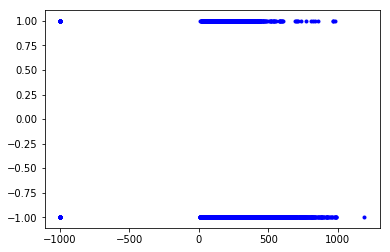

In [5]:
plt.scatter(tX[:,0],y, marker=".", color='b')
plt.show()

The values apart from the rest aren't outliers, they probably just contain -99 values.

## Correlation Matrix:

dict_keys([(4, 6), (4, 12), (4, 26), (4, 27), (4, 28), (6, 12), (6, 26), (6, 27), (6, 28), (9, 29), (12, 26), (12, 27), (12, 28), (23, 24), (23, 25), (24, 25), (26, 27), (26, 28), (27, 28)])


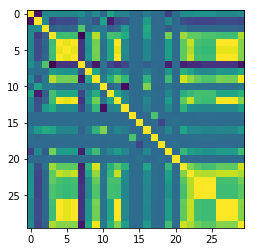

In [6]:
#corrcoef normalizes the values given by the correlation matrix
corr1 = np.corrcoef(tX.T)
plt.imshow(corr1)
res = np.where(corr1 > 0.95) #arbitrary threshold for strong correlation
listOfCoordinates= list(zip(res[0], res[1]))
listOfCoordinates = [cord for cord in listOfCoordinates if cord[0] != cord[1]] #remove diagonal
listOfCoordinates = {tuple(sorted(t)): t for t in listOfCoordinates}#remove commutative elements
print(listOfCoordinates.keys())

We identify strong correlations between the features listed above. However, these results should be interpreted carefully because a lot of the strong correlations observed might be due to the -999 missing values. However, this can still be useful if the missing values aren't distributed randomly in the data

dict_keys([(9, 21), (9, 29)])


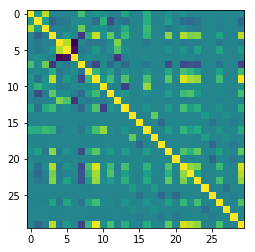

In [7]:
tX_replaced_by_mean = set_missing_explanatory_vars_to_mean(tX)
corr2 = np.corrcoef(tX_replaced_by_mean.T)
plt.imshow(corr2)
res = np.where(corr2 > 0.90) #arbitrary threshold for strong correlation
listOfCoordinates= list(zip(res[0], res[1]))
listOfCoordinates = [cord for cord in listOfCoordinates if cord[0] != cord[1]] #remove diagonal
listOfCoordinates = {tuple(sorted(t)): t for t in listOfCoordinates}#remove commutative elements
print(listOfCoordinates.keys())

We see that by replacing all the missing values by the mean of the remaining ones, the number of highly correlated values diminishes drastically. Only two pairs of feature are very strongly correlated if we select a threshold of 0.9. 

## PCA:

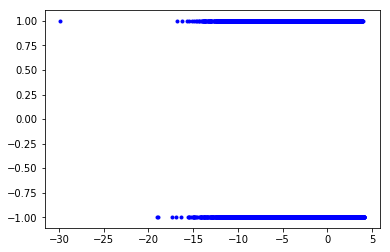

In [8]:
X_pca = pca(tX)
plt.scatter(X_pca[:,0],y, marker=".", color="b")
plt.show()

Plot of the first PCA component against the output, we conclude that the first principal component is not sufficient to separate the predictions.

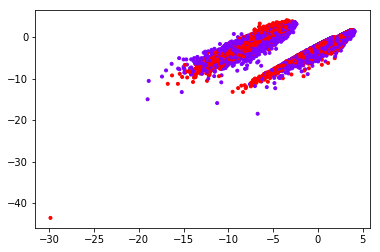

In [9]:
colors = cm.rainbow(y)
plt.scatter(X_pca[:,0],X_pca[:,1], marker=".", color=colors)
plt.show()

Plot of the first PCA component against the second PCA component. The dots are color labeled according to their output value y. Unfortunately, we notice that the clusters identified in the plot do not discriminate between the two output categories.

## Missing values positions :

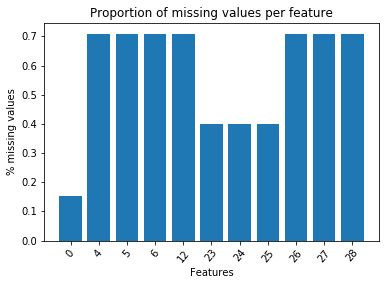

Total number of missing values:  1580052


In [11]:
#create a mask of values 0 and 1, the ones mark the positions of the missing values
missing_val = np.zeros(tX.shape)
missing_val[tX==-999] = 1
#calculate proportion of missing values per column and also per row
percentage_cols = np.sum(missing_val, axis=0)/y.shape
percentage_rows = np.sum(missing_val, axis=1)/np.shape(tX)[1]

fig, ax = plt.subplots()
plt.title('Proportion of missing values per feature')
plt.xlabel('Features')
plt.ylabel('% missing values')
y_plot = percentage_cols[percentage_cols>0.1]
x_plot = range(0,len(y_plot))
ax.bar(x_plot,y_plot)
ax.set_xticks(x_plot)
ax.set_xticklabels(np.where(percentage_cols>0.1)[0])
plt.xticks(rotation=50)
plt.show()


print("Total number of missing values: ", np.sum(tX==-999))

We notice that features 0,4,5,6,12,26,27,28 have a very high percentage of missing values, whereas other feature don't have any.

## Plot distributions of the features (w/o missing values) :

In [10]:
from matplotlib.collections import LineCollection
import matplotlib.cm as cm
from matplotlib import colors

#figure
fig,ax = plt.subplots(5, 6)
fig.suptitle('Distribution of the features values', fontsize=190)
fig.set_figheight(150)
fig.set_figwidth(150)

tX_no_missing_val = []
norm = 0

nb_bins = 30

likelihoods_bins = np.zeros((tX.shape[1],nb_bins+2))
shared_bins = np.zeros((tX.shape[1],nb_bins+1))

for ind_col in range(tX.shape[1]):
    # Removes absent values (-999s)
    tX_col_cleared = tX[:,ind_col][tX[:,ind_col]>-999]
    y_cleared = y[tX[:,ind_col]>-999]
    
    # Generating bins to make sure we use the same ones for the colors as we do for the heights of the histogram bars.
    shared_bins_col = np.histogram_bin_edges(tX_col_cleared, bins = nb_bins)
    shared_bins[ind_col,:] = shared_bins_col

    
    # Counting the number of background (y = -1) and signal (y = 1) in and finally the fraction of signal in each bin
    ind_tX_col_cleared = np.digitize(tX_col_cleared,shared_bins_col,right = False)
    nb_bg_bin = np.array([np.count_nonzero(ind_tX_col_cleared[y_cleared < 1/2] == i) for i in range(len(shared_bins_col))])
    nb_s_bin = np.array([np.count_nonzero(ind_tX_col_cleared[y_cleared > 1/2] == i) for i in range(len(shared_bins_col))])
    frac_s = nb_s_bin/(nb_bg_bin+nb_s_bin)
    frac_s[np.isnan(frac_s)] = 1/2
    frac_s[0] = frac_s[1]
    
    #print(frac_s)
    likelihoods_bins[ind_col,:] = np.append(frac_s,frac_s[-1])
    
   
    # Plot settings

    ax[int(ind_col/6),ind_col%6].tick_params(axis='both', which='major', labelsize=50)
    ax[int(ind_col/6),ind_col%6].set_title(ind_col,fontsize=80)

    
    # Plot histogram for feature
    N, bins, patches = ax[int(ind_col/6),ind_col%6].hist(tX_col_cleared, bins=shared_bins_col, log=False)
    
    # Color histogram bars by fraction of signal in corresponding bin
    norm = colors.Normalize(0, 1)
    for frac, patch in zip(frac_s[1:], patches):
        color = plt.cm.viridis(norm(frac))
        patch.set_facecolor(color)
        
    tX_no_missing_val.append(np.array(tX_col_cleared))
    
tX_no_missing_val = np.array(tX_no_missing_val).T

# Create a continuous norm to map from data points to colors
cmap = plt.cm.viridis
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([1.0, 0.3, 0.005, 0.3])
cbar = plt.colorbar(sm, cax=cbar_ax)
cbar.ax.set_ylabel('Proportion of y = 1', rotation=90,fontsize=90)
cbar.set_ticks([0.0, 0.25, 0.5, 0.75, 1.0])
cbar.ax.set_yticklabels([0.0, 0.25, 0.5, 0.75, 1.0],fontsize=90)


plt.show()


C:\Users\Balz\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide


In [7]:
#figure

num_row = 5
num_col = int(np.ceil(tX.shape[1]/num_row))

fig,ax = plt.subplots(num_row, num_col)
fig.suptitle('Proability distribution boson explanatory vars', fontsize=190)
fig.set_figheight(150)
fig.set_figwidth(150)

for ind_col,frac_s in enumerate(likelihoods_bins):
    
    ax[int(ind_col/num_col),ind_col%num_col].scatter(shared_bins[ind_col], frac_s[1:], s=200)
    ax[int(ind_col/num_col),ind_col%num_col].tick_params(axis='both', which='major', labelsize=50)
    ax[int(ind_col/num_col),ind_col%num_col].set_title(ind_col,fontsize=80)
    ax[int(ind_col/num_col),ind_col%num_col].set_ylim(-0.01,1.01)
    
      
plt.savefig("Proability_boson_explanatory_vars")
plt.show()


C:\Users\Balz\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log
C:\Users\Balz\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log


[-30.15855892 -25.94209707 -27.90293891 ... -29.96288324 -31.28565246
 -31.3641864 ]
[-24.51856965 -22.75097416 -20.91144118 ... -24.1397607  -23.91612413
 -24.05832161]
[-24.28436758 -26.09476014 -22.79815002 ... -19.13581378 -24.14352713
 -22.01808852]
[-30.80856557 -31.72185329 -29.23169999 ... -33.22801923 -31.37135389
 -32.19426801]
[-22.91846061 -26.17146446 -25.88056541 ... -23.60309298 -25.87072983
 -23.58431773]
[-22.96841291 -26.44134546 -23.85974722 ... -24.06330442 -22.17305783
 -23.39450441]


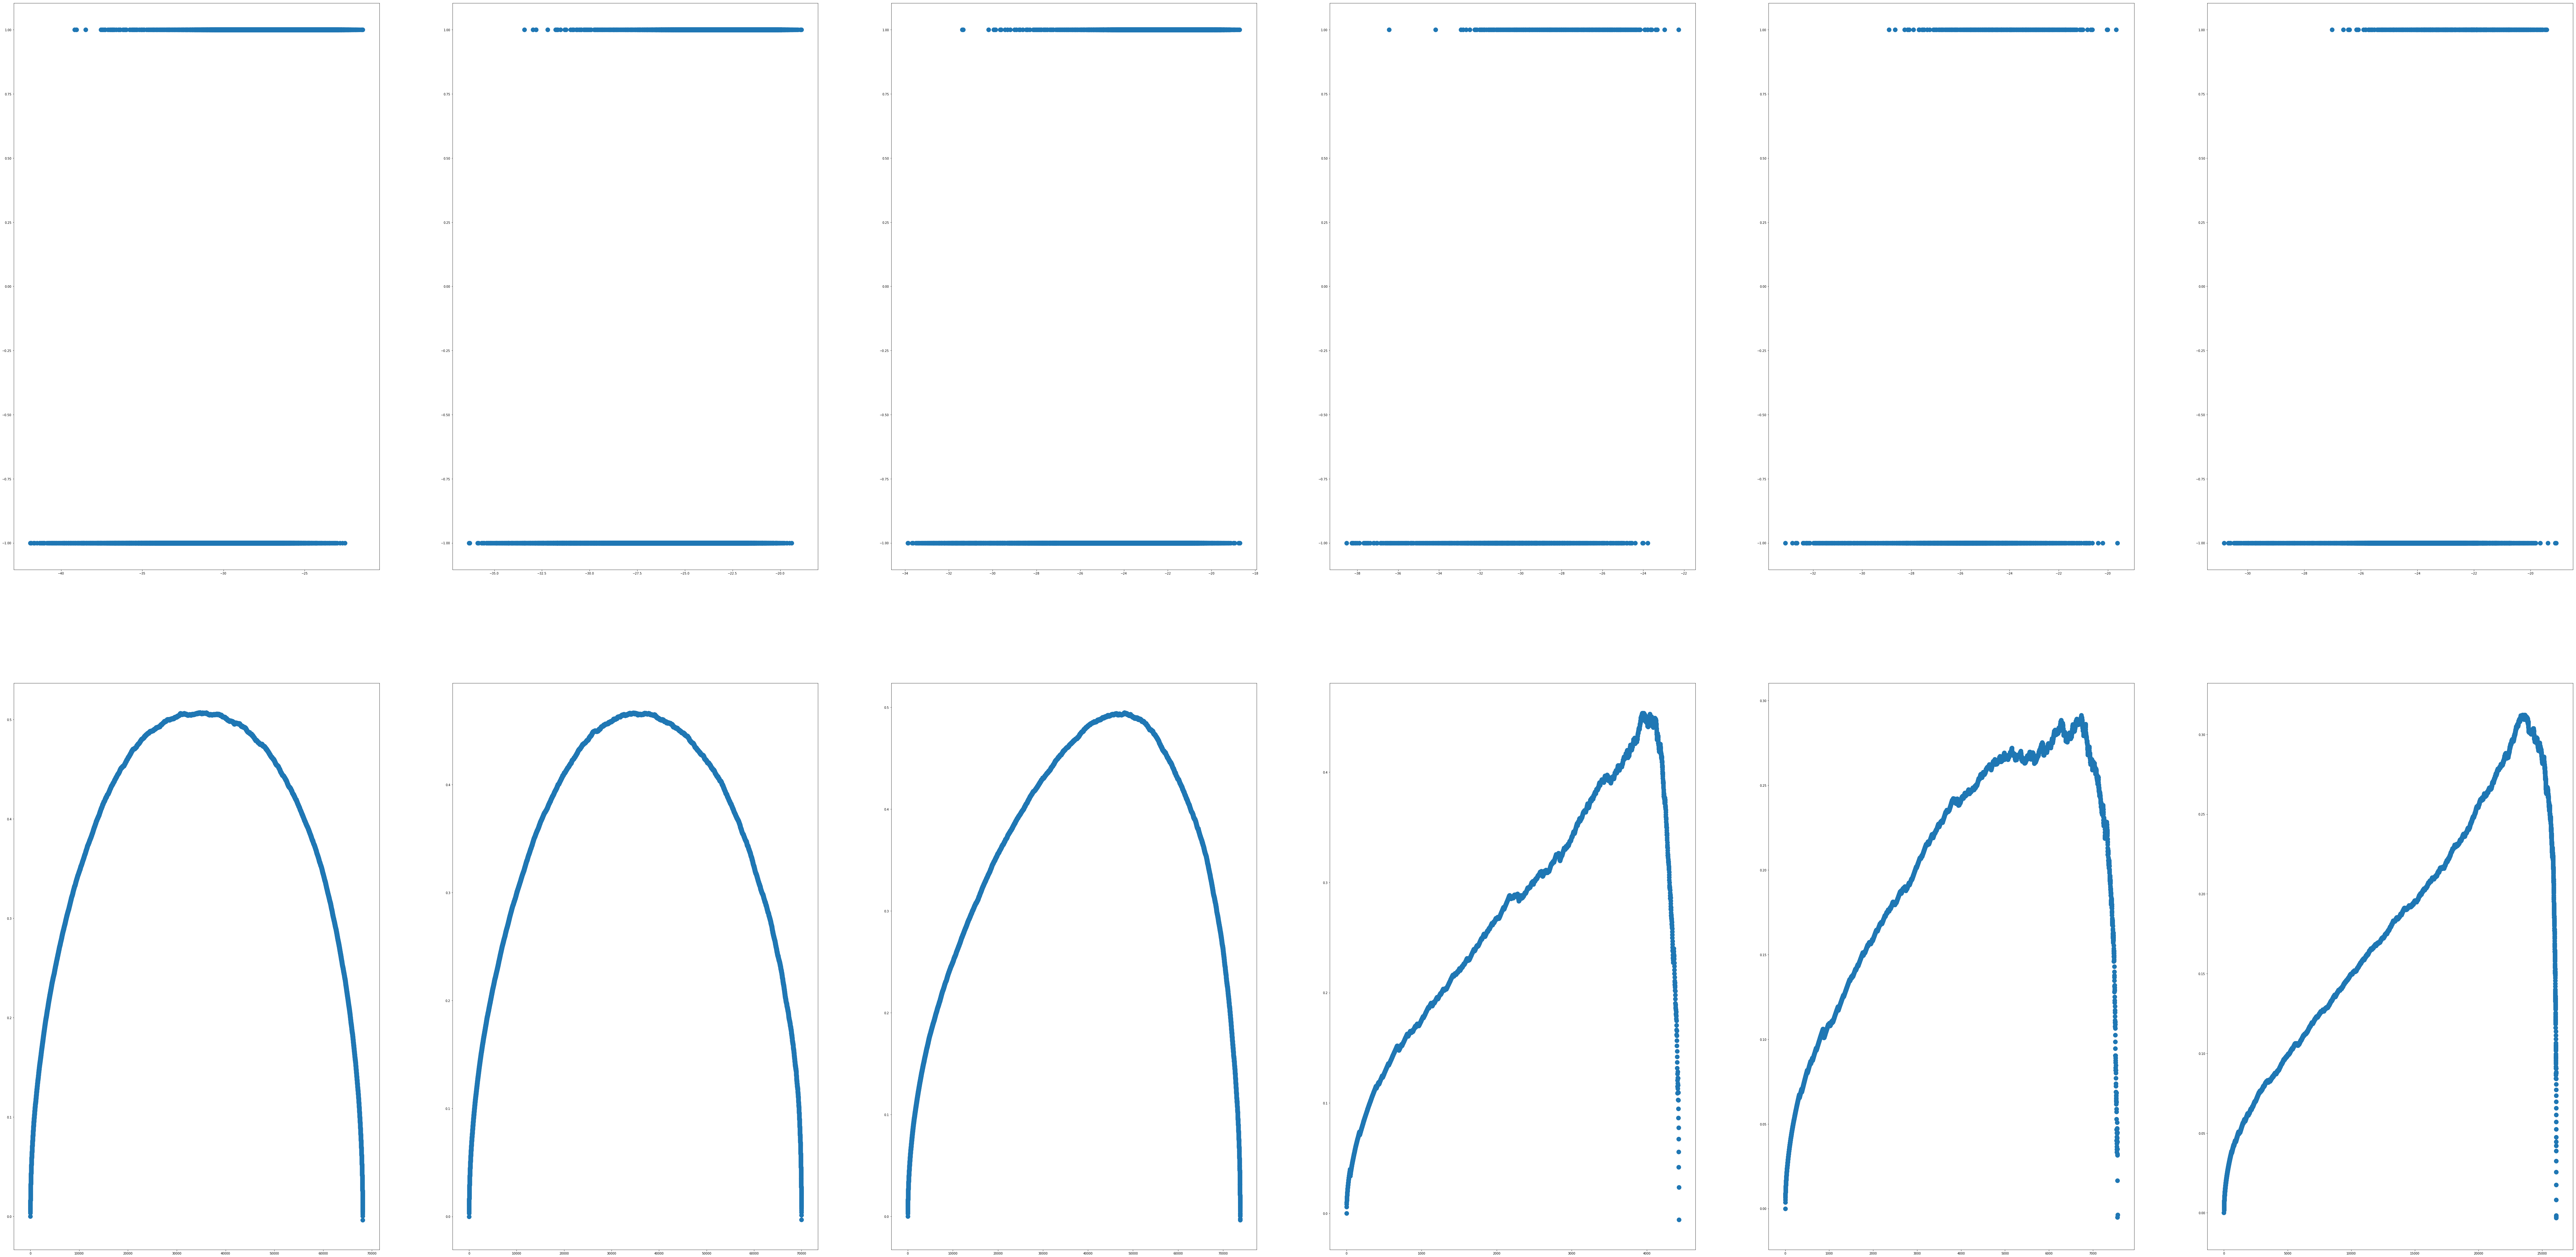

In [11]:
tX_split, ind_row_groups, groups_mv_num = split_data_according_to_pattern_of_missing_values(tX)
y_split = split_y_according_to_pattern_of_missing_values(y, ind_row_groups)

num_row = 2
num_col = int(np.ceil(2*len(y_split)/num_row))

fig,ax = plt.subplots(num_row, num_col)

#fig.suptitle('Distribution of 30 features values', fontsize=180)
fig.set_figheight(75)
fig.set_figwidth(150)

likelihoods_groups = np.copy(tX_split)

for ind_group, ind_row_group in enumerate(ind_row_groups):
    
    likelihoods_bins_group = likelihoods_bins[tX[ind_row_group[0]] > -999]
    shared_bins_group = shared_bins[tX[ind_row_group[0]] > -999]
    
    for ind_col in range(likelihoods_bins_group.shape[0]):
        #print(shared_bins_group[ind_col],tX_split[:,ind_col])
        ind_bin_tX_split_col = np.digitize(np.around(tX_split[ind_group][:,ind_col],4),shared_bins_group[ind_col,:],right = False)
        likelihoods_groups[ind_group][:,ind_col] = likelihoods_bins_group[ind_col][ind_bin_tX_split_col]

error_groups = []
threshold_likelihood_groups = np.zeros(len(ind_row_groups))
        
for ind_group, ind_row_group in enumerate(ind_row_groups):
    print(np.sum(np.log(likelihoods_groups[ind_group]),axis=1))
    y_pred_group = np.nan_to_num(np.sum(np.log(likelihoods_groups[ind_group]),axis=1))
    
    #print(y_pred_group.shape)
    ax[0,ind_group].scatter(y_pred_group,y[ind_row_group],s=200)
    ind_sorted = np.argsort(y_pred_group)
    
    nb_true_positives = np.zeros(len(ind_sorted))
    nb_false_positives = np.zeros(len(ind_sorted))
    nb_true_negatives = np.zeros(len(ind_sorted))
    nb_false_negatives = np.zeros(len(ind_sorted))
    for i in range(len(ind_sorted)):
        nb_true_positives[i] = np.count_nonzero(y[ind_row_group][ind_sorted[i+1:]] == 1)
        nb_false_positives[i] = len(ind_sorted)-i-nb_true_positives[i]
        nb_true_negatives[i] = np.count_nonzero(y[ind_row_group][ind_sorted[0:i]] == -1)
        nb_false_negatives[i] = i-nb_true_negatives[i]
    
    denom_matthews_correlation_coefficient = np.sqrt((nb_true_positives+nb_false_positives)*(nb_true_positives+nb_false_negatives)*(nb_true_negatives+nb_false_positives)*(nb_true_negatives+nb_false_negatives))
    denom_matthews_correlation_coefficient[denom_matthews_correlation_coefficient == 0] = 1
    mcc = (nb_true_positives*nb_true_negatives-nb_false_positives*nb_false_negatives)/denom_matthews_correlation_coefficient
    error_groups.append(mcc)
    threshold_likelihood_groups[ind_group] = y_pred_group[ind_sorted[np.argmax(mcc)]]
    
    ax[1,ind_group].scatter(np.arange(len(y_pred_group)),mcc,s=200)
    

plt.savefig("Proability_boson_explanatory_vars")
plt.show()

In [12]:
threshold_likelihood_groups

array([-28.60122861, -24.29850286, -22.58057545, -27.42385982,
       -23.51812897, -22.28196981])

In [14]:
DATA_TEST_PATH = "../data/test.csv"
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)
tX_split_test, ind_row_groups_test, groups_mv_num_test = split_data_according_to_pattern_of_missing_values(tX_test)   
print(len(ind_row_groups_test[0]))

likelihoods_groups_test = np.copy(tX_split_test)
y_pred_test = np.zeros(tX_test.shape[0])
y_pred_test_binary = np.zeros(tX_test.shape[0])

for ind_group, ind_row_group_test in enumerate(ind_row_groups_test):
    likelihoods_bins_group_test = likelihoods_bins[tX_test[ind_row_group_test[1]] > -999]
    shared_bins_group_test = shared_bins[tX_test[ind_row_group_test[1]] > -999]
    for ind_col in range(likelihoods_bins_group_test.shape[0]):
        ind_bin_tX_split_col_test = np.digitize(tX_split_test[ind_group][:,ind_col],shared_bins_group_test[ind_col,:],right = True)
        likelihoods_groups_test[ind_group][:,ind_col] = likelihoods_bins_group_test[ind_col][ind_bin_tX_split_col_test]

for ind_group, ind_row_group_test in enumerate(ind_row_groups_test):
    y_pred_group_test = np.nan_to_num(np.sum(np.nan_to_num(np.log(likelihoods_groups_test[ind_group])),axis=1))
    y_pred_group_test_binary = np.copy(y_pred_group_test)
    y_pred_group_test_binary[y_pred_group_test_binary > threshold_likelihood_groups[ind_group]] = 1
    y_pred_group_test_binary[y_pred_group_test_binary < 1] = -1
    print(y_pred_group_test.shape,ind_row_group_test.shape)
    y_pred_test[ind_row_group_test] = y_pred_group_test
    y_pred_test_binary[ind_row_group_test] = y_pred_group_test_binary

155460


C:\Users\Balz\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log
C:\Users\Balz\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(155460,) (155460,)
(158095,) (158095,)
(168195,) (168195,)
(9982,) (9982,)
(17243,) (17243,)
(59263,) (59263,)


In [15]:
y_pred_experimental = y_pred_test
y_pred_test = y_pred_test_binary
print(y_pred_test.shape)

(568238,)


The features number 22 is a feature with discrete values, it can only take the following values: 0. 1. 2. 3.
We also notice the very similar distributions of the features 9, 21 and 29 for which we previously identified strong correlations. We colored the plot according to which feature values were corresponding to which output. The colors of the bins reflect the proportions of y = 1 to y = -1 inside each bin. Yellow indicates y = 1 and blue indicates y = -1.

In [13]:
#detect the features with discrete values, defined as such when there are less than 1000 unique values
discrete_features=[]
for ind,el in enumerate(tX_no_missing_val):
    if(len(np.unique(np.around(el,4))) < 1000):
        discrete_features.append(ind)
        print(np.unique(np.around(el,4)))

[0. 1. 2. 3.]


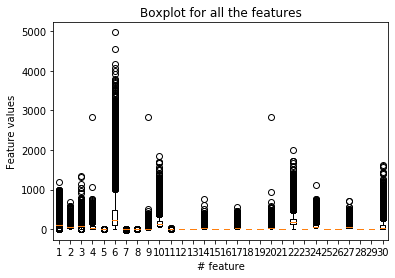

In [99]:
fig2, ax2 = plt.subplots()
ax2.set_title('Boxplot for all the features')
ax2.boxplot(tX_no_missing_val)
ax2.set_ylabel("Feature values")
ax2.set_xlabel("# feature")
plt.show()

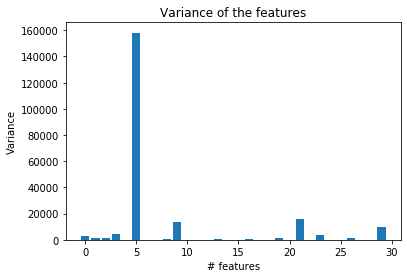

In [100]:
variance = []
for el in tX_no_missing_val:
    variance.append(np.var(el))
plt.bar(range(0,len(variance)),variance)
plt.title("Variance of the features")
plt.xlabel("# features")
plt.ylabel("Variance")
plt.show()

A closer look at the variance for each feature

# Global data preprocessing :

In [101]:
x, mean_x, std_x = standardize(tX)
tX = adding_offset(x)
xtrain,ytrain,xtest,ytest=split_data(tX,y,0.9)
pX=add_higher_degree_terms(x,5)#equivalent to build poly in multiple dimensions
pX=adding_offset(x)
xtrainpol,ytrainpol,xtestpol,ytestpol=split_data(pX, y, 0.9) #on polynomial version,with ratio = 0.9 and default seed=1

# Standard implementations

## Least squares gradient descent :

In [102]:
initial_w = np.zeros(np.shape(tX)[1])
gamma = 0.0825
max_iters = 1000
final_w_gd, final_loss_gd = least_squares_GD(y, tX, initial_w, max_iters, gamma)

Gradient Descent(1000/1000): loss=0.3804390821714642, w0=-0.017954986677314527, w1=0.172481331946264


## Least squares stochastic gradient descent :

In [103]:
gamma = 0.005
max_iters = 500
final_w_sgd, final_loss_sgd = least_squares_SGD(y, tX, initial_w, max_iters, gamma)

Gradient Descent(500/500): loss=0.43883791575075315, w0=-0.10467424644579575, w1=0.20916591234117912


## Least squares with normal equation  

In [104]:
w_ne,loss_ne= least_squares(y, tX)

Loss=0.3394455984893396, w0=-999.4173451011517, w1=0.031342169911756444


#### on polynomial version of the data set :

In [105]:
w_ne_pol, loss_ne_pol = least_squares(y, pX)

Loss=0.3394455984893396, w0=-999.4173451011517, w1=0.031342169911756444


#### and with split of test and train data :

In [106]:
w_ne_pol_train, loss_ne_pol_train=least_squares(ytrainpol, xtrainpol)
rmse_ne_pol_train=rmse(loss_ne_pol_train)
loss_ne_pol_test= compute_loss_linear(ytestpol, xtestpol, w_ne_pol_train)
rmse_ne_pol_test=rmse(loss_ne_pol_test)
print(" Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(tr=rmse_ne_pol_train, te=rmse_ne_pol_test))

Loss=0.33924422861263215, w0=-1584.1845283059572, w1=0.03149827750621196
 Training RMSE=0.824, Testing RMSE=0.826


## Ridge regression :

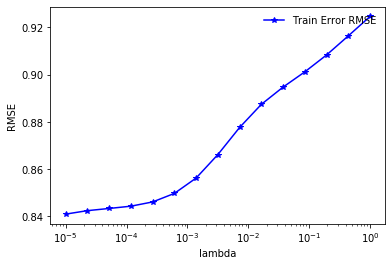

In [107]:
lambdas = np.logspace(-5, 0, 15)
rmse_rr = []
for ind, lambda_ in enumerate(lambdas):
        w_rr,loss_rr = ridge_regression(y, tX, lambda_)
        rmse_rr.append(rmse(loss_rr))

plot_implementation(rmse_rr, lambdas)

#### on polynomial version of the data set :

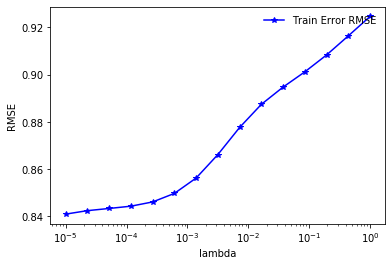

In [108]:
lambdas = np.logspace(-5, 0, 15)
rmse_rr_pol = []
for ind, lambda_ in enumerate(lambdas):
        w_rr_pol,loss_rr_pol = ridge_regression(y, pX, lambda_)
        rmse_rr_pol.append(rmse(loss_rr_pol))

plot_implementation(rmse_rr_pol, lambdas)

#### and with split of test and train data :

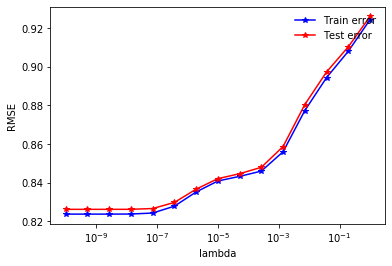

In [109]:
lambdas = np.logspace(-10, 0, 15)
rmse_rr_pol_train = []
rmse_rr_pol_test = []
for ind, lambda_ in enumerate(lambdas):
        w_rr_pol,loss_rr_pol_train = ridge_regression(ytrainpol,xtrainpol , lambda_)
        rmse_rr_pol_train.append(rmse(loss_rr_pol_train))
        rmse_rr_pol_test.append(rmse(compute_loss_linear(ytestpol,xtestpol,w_rr_pol)))
plot_train_test(rmse_rr_pol_train, rmse_rr_pol_test, lambdas)
#JEROME: plot a l'air normal, exactement meme erreur pour test et train bc the dataset is hge so there is no big difference between trin and test

## Logistic regression

### Logistic regression using gradient descent

We have to rescale y to get it between 0 and 1 for the loss function ot work properly. Moreover, this method is very sensitive so we start with an already goo approximation of the weights that we get fro the methods used previously.

In [110]:
initial_w = w_ne_pol_train
max_iters = 100
gamma=0.000001
w_lr,loss_lr=logistic_regression(rescale_y(y), tX, initial_w, max_iters,gamma)
a = rmse(compute_loss_linear(y,tX,w_lr))
print("Root mean square error: ",a)
#J: pas encore au top

Loss=142818.83288684682, w0=-1584.2051569016044, w1=0.03985680356335781
Loss=138338.45800573667, w0=-1584.2025743207325, w1=0.0536918229801693
Loss=137765.29278731783, w0=-1584.2054200861949, w1=0.06548077151688113
Loss=137554.21002444453, w0=-1584.2072761712789, w1=0.07710847877182361
Loss=137367.5087398238, w0=-1584.2092113213764, w1=0.08828974899384506
Loss=137195.34761720957, w0=-1584.2110313550306, w1=0.09910609662134831
Loss=137035.66921748556, w0=-1584.2127773250456, w1=0.10956632530713376
Loss=136886.99525207665, w0=-1584.214447804138, w1=0.11969035006140509
Loss=136748.0982985975, w0=-1584.216048960453, w1=0.12949408447137284
Loss=136617.94551659288, w0=-1584.217585438485, w1=0.1389925056005046


KeyboardInterrupt: 

#### With split of train and test data :

In [ ]:
w_lr_pol,loss_lr_pol_train = logistic_regression(rescale_y(ytrainpol),xtrainpol,initial_w, max_iters,gamma)
rmse_lr_pol_train = rmse(compute_loss_linear(ytrainpol,xtrainpol,w_lr_pol))
rmse_lr_pol_test = rmse(compute_loss_linear(ytestpol,xtestpol,w_lr_pol))
print("Root mean square error for test: {tr:.3f} and train: {te:.3f} ".format(tr=rmse_lr_pol_train, te=rmse_lr_pol_test))

### Logistic regression using Newton

In [ ]:
max_iters = 25
gamma = 0.01
initial_w = np.zeros(np.shape(tX)[1])
w_lrn, loss_lrn=logistic_regression_newton(rescale_y(y),tX,initial_w,max_iters,gamma)
#to compare with least squares error
a = rmse(compute_loss_linear(y, tX, w_lrn))
print("Root mean square error: ",a)

#### on polynomial version of the data set :

In [ ]:
w_lrn, loss_lrn=logistic_regression_newton(rescale_y(y),pX,initial_w,max_iters,gamma)
a = rmse(compute_loss_linear(y, tX, w_lrn))
print("Root mean square error: ",a)

### Regularized logistic regression

In [ ]:
lambdas = np.logspace(-10, 10, 2)
rmse_rr_pol_train = []
rmse_rr_pol_test = []
for ind, lambda_ in enumerate(lambdas):
        w_rr_pol,loss_rr_pol_train = reg_logistic_regression(ytrainpol,xtrainpol ,lambda_,initial_w,max_iters,gamma)
        rmse_rr_pol_train.append(rmse(compute_loss_linear(ytrainpol,xtrainpol,w_rr_pol)))
        rmse_rr_pol_test.append(rmse(compute_loss_linear(ytestpol,xtestpol,w_rr_pol)))
plot_train_test(rmse_rr_pol_train, rmse_rr_pol_test, lambdas)
#J: test and train error are const, inde of lambda??

Remark: to be able to compare the train et test losses, we have to calculate them both using the same loss function, we opted for the mse loss function as it's value is on the same scale as the output

## End of required functions ##
#### We now begin more complex analysis ####

In [ ]:
#### Example - base mode
gamma=0.5
ws_1,log_likelihoods_1 = logistic_regression(rescale_y(y), tX, np.random.rand(tX.shape[1])/1000000,1, gamma)
plt.scatter(rescale_predictions(compute_p(ws_1[-1],tX))[1:1000],y[1:1000], marker=".", color='b')
##AA : prend beaucoup de temps ...

In [ ]:
ws_2, log_likelihoods_2 = logistic_regression(rescale_y(y), tX, np.random.rand(tX.shape[1])/1000000,10,gamma)
#plt.scatter(rescale_predictions(compute_p(ws_2[-1],tX))[1:1000],y[1:1000], marker=".", color='b')
#np.linalg.norm(ws_1[-1]-ws_2[-1])

## Handling missing values

In [ ]:
DATA_TRAIN_PATH = '../data/train.csv'
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

The missing values set to -999 distort the variability of certain explanatory variables significantly, which might be problematic when weights are to be determined. As -999 is so far off the usual values of the variables, learning the model with observations containing missing values, the variability of the correctly measured values might be overshadowed by the presence of the faulty ones. One should therefore consider coming up with ways to handle missing values.

### replace -999 by average value

The simplest way to do so is to set each missing value to the mean over the explanatory variable without any -999s. However, this comes with a disadvantage as we introduce an information critical for the prediction, which is most likely to be inaccurate.

In [41]:
with np.printoptions(precision=2, suppress=True):
    print(tX[0:5,0:8])

[[ 138.47   51.66   97.83   27.98    0.91  124.71    2.67    3.06]
 [ 160.94   68.77  103.23   48.15 -999.   -999.   -999.      3.47]
 [-999.    162.17  125.95   35.63 -999.   -999.   -999.      3.15]
 [ 143.91   81.42   80.94    0.41 -999.   -999.   -999.      3.31]
 [ 175.86   16.91  134.81   16.41 -999.   -999.   -999.      3.89]]


In [32]:
tX_corr = set_missing_explanatory_vars_to_mean(tX)

In [39]:
with np.printoptions(precision=2, suppress=True):
    print(tX_corr[0:5,0:8])

[[138.47  51.66  97.83  27.98   0.91 124.71   2.67   3.06]
 [160.94  68.77 103.23  48.15   2.4  371.78  -0.82   3.47]
 [121.86 162.17 125.95  35.63   2.4  371.78  -0.82   3.15]
 [143.91  81.42  80.94   0.41   2.4  371.78  -0.82   3.31]
 [175.86  16.91 134.81  16.41   2.4  371.78  -0.82   3.89]]


Performing a principle component analysis on the data matrix where -999s were set to the mean over the column and plotting PCA1 vs PCA2, one sees that the two different groups that appeared previously on this plot type are mere artifacts of the arbitrary convention of setting faulty measurement values to -999.

In [35]:
tX_corr_pca = pca(tX_corr)

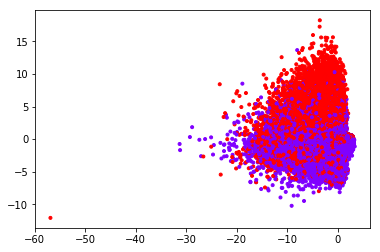

In [36]:
colors = cm.rainbow(y)
plt.scatter(tX_corr_pca[:,0],tX_corr_pca[:,1], marker=".", color=colors)
plt.show()

Furthermore, already when one considers only the first two principle components one, the signal 's' and background 'b' appear to be separable to some degree.

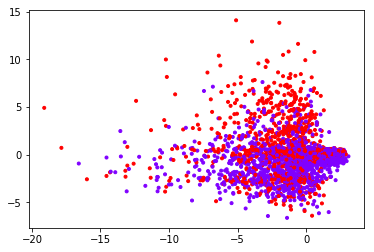

In [37]:
colors = cm.rainbow(y[1:5000])
plt.scatter(tX_corr_pca[1:5000,0],tX_corr_pca[1:5000,1], marker=".", color=colors)
plt.show()

Here we should add how this alteration changes predictions - test-train-split

### Taking into account patterns for the handling of missing values

In the following, it is shown that rather than being arbitrarily distributed in the data matrix, the missing values exhibit a clear pattern. This pattern can be accounted for in order to improve the accuracy of the prediction.

In [111]:
DATA_TEST_PATH = "../data/test.csv"
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)
DATA_TRAIN_PATH = "../data/train.csv"
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

It can easily be shown that the test and the train data matrices have missing values (-999) in the same columns :

In [112]:
# Test that in both test and train data the same columns are full of gaps
tX_mv = sum(tX == -999) # Array with columnwise count of faulty measurements in training data
tX_mv[tX_mv > 0] = 1 
tX_test_mv = sum(tX_test == -999) # Array with columnwise count of faulty measurements in test data
tX_test_mv[tX_test_mv > 0] = 1

np.array_equal(tX_mv,tX_test_mv) # "True" means both training and test data have values missing only in the excact same explanatory variables.

True

Furthermore, the number of occurences are the same in multiple columns, suggesting that there might be patterns in the distribution of absent values.

In [113]:
# Missing values don't appear to be random
tX_mv = sum(tX == -999)
tX_test_mv = sum(tX_test == -999)

print(tX_mv,tX_test_mv) # Arrays with columnwise counts of faulty measurements in training and test data

[ 38114      0      0      0 177457 177457 177457      0      0      0
      0      0 177457      0      0      0      0      0      0      0
      0      0      0  99913  99913  99913 177457 177457 177457      0] [ 86488      0      0      0 402796 402796 402796      0      0      0
      0      0 402796      0      0      0      0      0      0      0
      0      0      0 227458 227458 227458 402796 402796 402796      0]


Indeed, the manipulations below show that only six different combinations of absent explanatory variables appear in the data set.

In [114]:
ind = np.arange(tX.shape[1])
tX_col_mv = tX[:,ind[np.where(tX_mv > 0)]]
test = np.zeros(tX_col_mv.shape)
test[np.where(tX_col_mv == -999)] = 1
print(test[1:10,:]) # Extracted coulums that contain -999s. '1' represents missing value, '0' otherwise.

[[0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1.]
 [1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1.]
 [0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1.]
 [0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1.]]


In [115]:
np.flip(np.power(10,np.arange(test.shape[1]),dtype=np.int64)) # Sleight of hand: matrix multiplication with the following array.

array([10000000000,  1000000000,   100000000,    10000000,     1000000,
            100000,       10000,        1000,         100,          10,
                 1])

In [116]:
np.dot(test,np.flip(np.power(10,np.arange(test.shape[1]),dtype=np.int64))) # The pattern of missing columns is represented by an array of numbers representing all samples in the usual order. The numbers are binary code for the matrix of the extracted columns just above.

array([0.00000000e+00, 1.11100011e+09, 1.11110001e+10, ...,
       1.11100011e+09, 1.11111111e+09, 1.11111111e+10])

In [117]:
np.unique(np.dot(test,np.power(10,np.arange(test.shape[1]),dtype=np.int64))) # All the different configurations of the missing values. There are only six of them.

array([0.00000000e+00, 1.00000000e+00, 1.11000111e+10, 1.11000111e+10,
       1.11111111e+10, 1.11111111e+10])

In [118]:
# Splitting the data...
tX_split, ind_row_groups, groups_mv_num = split_data_according_to_pattern_of_missing_values(tX) # => regroupement of the steps performed above
y_split = split_y_according_to_pattern_of_missing_values(y, ind_row_groups)

tX_split_test, ind_row_groups_test, groups_mv_num_test = split_data_according_to_pattern_of_missing_values(tX_test)

np.array_equal(groups_mv_num,groups_mv_num_test) # "True" means both training and test data exhibit the excact same pattern of missing values in the explanatory variables.

/Users/jerome/Documents/EPFL/MA1/Machine Learning/Projet-Super-Genial-/project1/scripts/patternsmissingvalues.py:65: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  tX_split.append(tX_group_rows[:,ind_col[bool_mask_col_mv_group]])


True

A principle component analysis of each subgroup with its distinct pattern of missing values suggests that it might be advantageous to perform the weights on each subgroup separately.

group 1 of 6, indices of removed outliers : []
group 2 of 6, indices of removed outliers : []
group 3 of 6, indices of removed outliers : [2218]


No handles with labels found to put in legend.


group 4 of 6, indices of removed outliers : []
group 5 of 6, indices of removed outliers : []
group 6 of 6, indices of removed outliers : [21218]


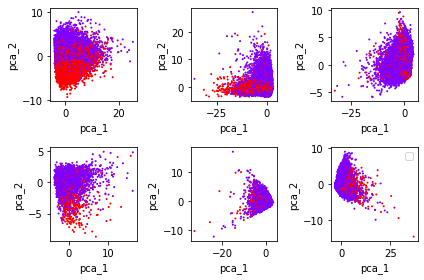

In [129]:
import matplotlib.cm as cm
'''
Define the structure of the figure:
   Every observation can be placed into one six groups according to its pattern of missing values => six subplots
'''
num_row = 2
num_col = int(np.ceil(len(tX_split)/num_row))
f, axs = plt.subplots(num_row, num_col)


for ind, tX_group in enumerate(tX_split):
    tX_group_pca = pca(tX_group[:,np.std(tX_group,0) > 0]) # The explanatory variables
    """
    # A simple version of the plot where outliers are not removed.
    colors = cm.rainbow(y_split[ind])
    ax.scatter(tX_group_pca[:,0], tX_group_pca[:,1],s=1 , color=colors)
    """
    
    # Identify outliers for improved readibility
    mean_distance_from_centre = np.mean(np.linalg.norm(tX_group_pca[:,[0,1]],axis=1))
    ind_outlier = np.arange(tX_group_pca.shape[0])[np.linalg.norm(tX_group_pca[:,[0,1]],axis=1)>20*mean_distance_from_centre]
    print('group {g} of {ng}, indices of removed outliers : {io}'.format(g = ind+1, ng = len(tX_split), io = ind_outlier))
    
    # Colour points according to classes 'b' ans 's'
    colors = cm.rainbow(np.delete(y_split[ind],ind_outlier))
    
    # Plot pca_1 against pca_2 for each subgroup
    ax = axs[ind // num_col][ind % num_col]
    ax.scatter(np.delete(tX_group_pca[:,0],ind_outlier), np.delete(tX_group_pca[:,1],ind_outlier),s=1 , color=colors)
    ax.set_xlabel("pca_1")
    ax.set_ylabel("pca_2")

#plt.suptitle("PCA plots of 6 pattern groups", y = 1.0, fontsize=16)
plt.legend()
plt.tight_layout()
plt.savefig("./plots/pca_1_vs_pca_2_of_pattern_groups")
plt.show()

Here we perform PCA on all the 6 subgroups that we defined previously according to the missing values pattern. The true detections are labeld in red ans the false ones in purple. We see that in the first group for instance, the boson detections are almost separable from the false predictions.

#### Pattern of missing values and logistic regession

In [ ]:
# Splitting the data...
tX_split, ind_row_groups, groups_mv_num = split_data_according_to_pattern_of_missing_values(tX) # => regroupement of the steps performed above
y_split = split_y_according_to_pattern_of_missing_values(y, ind_row_groups)
'''import matplotlib.cm as cm

for tX_group, y_group in zip(tX_split,y_split):
    tX_group_pca = pca(tX_group)
    colors = cm.rainbow(y_group)
    plt.scatter(tX_group_pca[:,0],tX_group_pca[:,1], marker=".", color=colors)'''

# ... and finding each subgroup's the optimal weights as well as predicting the y's of the training set using linear regression
#     => condensed version is the function 'find_optimal_weights_pattern_mv'

ws_groups = [] # list to stock weights of subgroups
y_pred = np.zeros([len(y)]) # initialize array y_pred

for tX_group, y_group, ind_row_group in zip(tX_split,y_split,ind_row_groups) :
    #print(tX_group, y_group, ind_row_group)
    
    # All-zero columns appear in the reduced data sets. They interfere with the calculation of the jacobean matrix.
    # The corresponding weights are set to zero and the other weights are determined using a further reduced dataset without those columns.
    
    ind_col_non_zero = np.arange(len(tX_group[0,:]))[sum(tX_group**2)>0]
    ws_1,log_likelihoods_1 = logistic_regression(rescale_y(y_group), tX_group[:,ind_col_non_zero], np.random.rand(tX_group[:,ind_col_non_zero].shape[1])/1000000,10,gamma)
    ws_2,log_likelihoods_2 = logistic_regression(rescale_y(y_group), tX_group[:,ind_col_non_zero], np.random.rand(tX_group[:,ind_col_non_zero].shape[1])/1000000,10,gamma)
    assert np.allclose(ws_1[-1], ws_2[-1]) # The weights are calculated twice with different initial ws => asserting that they are the same.
    w = np.zeros(len(tX_group[0,:]))
    w[ind_col_non_zero] = ws_1[-1]
    ws_groups.append(w)
    y_pred[ind_row_group] = rescale_predictions(compute_p(w,tX_group))

plt.scatter(y_pred[1:500],y[1:500], marker=".", color='b') # Plotting the predictions against the known values of the training set.

In [ ]:
tX_split_test, ind_row_groups_test, groups_mv_num_test = split_data_according_to_pattern_of_missing_values(tX_test)


''' Auxiliary function that calculates the predictions of each subgroup, joins them together in the right order
    and rescales the predictions so that they lie between -1 and 1'''
y_pred_test = predict_y_lr_weights_pattern_mv(ws_groups, tX_split_test,ind_row_groups_test,tX_test.shape[0])

In [ ]:
# The same with helper functions
DATA_TRAIN_PATH = "../data/train.csv/train.csv" # TODO: download train data and supply path here 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

In [ ]:
# Splitting the data by patterns
tX_split, ind_row_groups, groups_mv_num = split_data_according_to_pattern_of_missing_values(tX)
y_split = split_y_according_to_pattern_of_missing_values(y, ind_row_groups)

In [ ]:
# Adding interaction terms to the split data and calculating the optimal weights of each subgroup.
ws_groups, y_pred = find_optimal_weights_pattern_mv(tX_split_test, ind_row_groups,y_split,tX.shape[0])
plt.scatter(y_pred,y, marker=".", color='b')

In [ ]:
plt.scatter(y_pred[ind_row_groups[4]][0:800],y[ind_row_groups[4]][0:800], marker=".", color='b')

In [ ]:
DATA_TEST_PATH = "../data/test.csv/test.csv"
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)
tX_split_test, ind_row_groups_test, groups_mv_num_test = split_data_according_to_pattern_of_missing_values(tX_test)
y_pred_test = predict_y_lr_weights_pattern_mv(ws_groups, tX_split_test,ind_row_groups_test,tX_test.shape[0])

In [ ]:
y_pred_tX = y_pred
y_pred_test_tX = y_pred_test
ws_groups_tX = ws_groups

### Interactions between variables

In [82]:
x = np.array([[1,2,3],[4,5,6]])
print("x :\n",x,"\n")
print("add_square_terms(x) : \n",add_square_terms(x),"\n")
print("add_higher_degree_terms(x, 3) : \n",add_higher_degree_terms(x, 3),"\n")
print("add_higher_degree_terms_customized(x, (3,4)) : \n",add_higher_degree_terms_customized(x, (3,4)),"\n")
print("add_interaction_terms(x) : \n",add_interaction_terms(x))

x :
 [[1 2 3]
 [4 5 6]] 

add_square_terms(x) : 
 [[ 1  2  3  1  4  9]
 [ 4  5  6 16 25 36]] 

add_higher_degree_terms(x, 3) : 
 [[  1   2   3   1   4   9   1   8  27]
 [  4   5   6  16  25  36  64 125 216]] 

add_higher_degree_terms_customized(x, (3,4)) : 
 [[   1    2    3    1    8   27    1   16   81]
 [   4    5    6   64  125  216  256  625 1296]] 

add_interaction_terms(x) : 
 [[ 1  2  3  1  2  3  4  6  9]
 [ 4  5  6 16 20 24 25 30 36]]


# Best version so far: Pattern of missing values, interactions between variables and logistic regession

#### Squares of explanatory variables

In [ ]:
DATA_TRAIN_PATH = "../data/train.csv/train.csv" # TODO: download train data and supply path here 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

In [ ]:
# Splitting the data...
tX_split, ind_row_groups, groups_mv_num = split_data_according_to_pattern_of_missing_values(tX)
y_split = split_y_according_to_pattern_of_missing_values(y, ind_row_groups)

In [ ]:
# Adding interaction terms to the split data and calculating the optimal weights of each subgroup.
ws_groups, y_pred = find_optimal_weights_pattern_mv(add_exponential_terms_to_split_data(tX_split_test,2), ind_row_groups,y_split,tX.shape[0])
plt.scatter(y_pred,y, marker=".", color='b')

In [ ]:
plt.scatter(y_pred[ind_row_groups[4]][0:800],y[ind_row_groups[4]][0:800], marker=".", color='b')

In [ ]:
DATA_TEST_PATH = "../data/test.csv/test.csv"
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)
tX_split_test, ind_row_groups_test, groups_mv_num_test = split_data_according_to_pattern_of_missing_values(tX_test)
y_pred_test = predict_y_lr_weights_pattern_mv(ws_groups, add_exponential_terms_to_split_data(tX_split_test,2),ind_row_groups_test,tX_test.shape[0])

In [ ]:
y_pred_squares = y_pred
y_pred_test_squares = y_pred_test
ws_groups_squares = ws_groups

In [ ]:
len(y_pred_test_squares)

#### Cubic values of explanatory variables

In [ ]:
DATA_TRAIN_PATH = "../data/train.csv/train.csv" # TODO: download train data and supply path here 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

In [ ]:
# Splitting the data...
tX_split, ind_row_groups, groups_mv_num = split_data_according_to_pattern_of_missing_values(tX)
y_split = split_y_according_to_pattern_of_missing_values(y, ind_row_groups)

In [ ]:
# Adding interaction terms to the split data and calculating the optimal weights of each subgroup.
ws_groups, y_pred = find_optimal_weights_pattern_mv(add_exponential_terms_to_split_data(tX_split,3), ind_row_groups,y_split,tX.shape[0])
plt.scatter(y_pred,y, marker=".", color='b')

In [ ]:
plt.scatter(y_pred[ind_row_groups[4]][0:800],y[ind_row_groups[4]][0:800], marker=".", color='b')

In [ ]:
DATA_TEST_PATH = "../data/test.csv/test.csv"
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)
tX_split_test, ind_row_groups_test, groups_mv_num_test = split_data_according_to_pattern_of_missing_values(tX_test)
y_pred_test = predict_y_lr_weights_pattern_mv(ws_groups, add_exponential_terms_to_split_data(tX_split_test,3),ind_row_groups_test,tX_test.shape[0])

In [ ]:
y_pred_cubic = y_pred
y_pred_test_cubic = y_pred_test
ws_groups_cubic = ws_groups

In [ ]:
groups_no_conv = np.array([1,4])

In [ ]:
y_pred_comb = y_pred_cubic
for group in groups_no_conv:
    y_pred_comb[ind_row_groups[group]] = y_pred_squares[ind_row_groups[group]]

In [ ]:
plt.scatter(y_pred_comb[ind_row_groups[1]][0:800],y[ind_row_groups[1]][0:800], marker=".", color='b')

In [ ]:
for group in groups_no_conv:
    y_pred_test[ind_row_groups_test[group]] = y_pred_test_squares[ind_row_groups_test[group]]

#### Interactions beween all variables

In [ ]:
DATA_TRAIN_PATH = "../data/train.csv/train.csv" # TODO: download train data and supply path here 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

In [ ]:
# Splitting the data...
tX_split, ind_row_groups, groups_mv_num = split_data_according_to_pattern_of_missing_values(tX)
y_split = split_y_according_to_pattern_of_missing_values(y, ind_row_groups)

In [ ]:
# Adding interaction terms to the split data and calculating the optimal weights of each subgroup.
ws_groups, y_pred = find_optimal_weights_pattern_mv(add_interaction_terms_to_split_data(tX_split), ind_row_groups,y_split,tX.shape[0])
plt.scatter(y_pred,y, marker=".", color='b')

In [ ]:
# Adding interaction terms to the split data and calculating the optimal weights of each subgroup.
ws_groups, y_pred = find_optimal_weights_pattern_mv(add_interaction_terms_to_split_data(tX_split), ind_row_groups,y_split,tX.shape[0])
plt.scatter(y_pred,y, marker=".", color='b')

In [ ]:
plt.scatter(y_pred[ind_row_groups[4]][0:800],y[ind_row_groups[4]][0:800], marker=".", color='b')

In [ ]:
DATA_TEST_PATH = "../data/test.csv/test.csv"
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)
tX_split_test, ind_row_groups_test, groups_mv_num_test = split_data_according_to_pattern_of_missing_values(tX_test)
y_pred_test = predict_y_lr_weights_pattern_mv(ws_groups, add_interaction_terms_to_split_data(tX_split_test),ind_row_groups_test,tX_test.shape[0])

In [ ]:
y_pred_interact = y_pred
y_pred_test_interact = y_pred_test
ws_groups_interact = ws_groups

#### Standartization - if one uses square and cubic values they might be larger of smaller

In [ ]:
def standardize(x):

    centered_data = x - np.mean(x, axis=0)
    std_data = centered_data / np.std(centered_data, axis=0)
    
    return std_data

### !!! Overfitting

#### Tuning hyperparameters

Previously, the need for different treatment of each subgroup with its specific pattern of missing values when it comes to feature engineering became apparent. To justify and improve the empirically gained intuition for feature engineering, we preceed by tuning the hyperparameters for each subgroup in order to be able to compare different models. For reasons of simplicity and computational limitations we restrict ourselves to adding polynomial terms of each explanatory variables up to a certain degree to our data. Other interactions between different explanatory variables remain unaccounted for. Taking into account models where certain polynomial terms are left out would lead to a combinatorial explosion. Since a ridge term was included in the logistic regression, the weights corresponding to the terms with little predictive power, determined based on the data, are expected be to close to zero anyhow.

In [133]:
from proj1_helpers import *
DATA_TRAIN_PATH = "../data/train.csv"
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)
tX_split, ind_row_groups, groups_mv_num = split_data_according_to_pattern_of_missing_values(tX)
y_split = split_y_according_to_pattern_of_missing_values(y, ind_row_groups)

/Users/jerome/Documents/EPFL/MA1/Machine Learning/Projet-Super-Genial-/project1/scripts/patternsmissingvalues.py:65: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  tX_split.append(tX_group_rows[:,ind_col[bool_mask_col_mv_group]])


In [134]:
def train_test_split_logistic_regression_feature_engineering_ridge(tX, y, degree, ratio, seed, max_iters, threshold, lambdas, gamma):
    """
    The function splits the data into a test and a training, adds polynomial terms of the explanatory variables up to 
    a given degree, and finds the optimal weights by performing a penalized logistic regression on the training set
    given a set of lambdas.
    
    It returns the RMSE as well as the absolute error (0 or 1) of the predictions for the test and the training sets.
    """
    
    # ***************************************************
    # split the data, and return train and test data
    # ***************************************************
    tX_train_split,y_train_split, tX_test_split, y_test_split = split_data(tX, y, ratio, seed)
  
    # ***************************************************
    # form train and test data with polynomial basis function:
    # ***************************************************
    tX_train_split_extended = add_higher_degree_terms(tX_train_split, degree)
    tX_test_split_extended = add_higher_degree_terms(tX_test_split, degree)
    
    # ***************************************************
    # calcualte most likely weights through logistic regression with ridge term
    # ***************************************************
    ind_col_non_const = np.arange(len(tX_train_split_extended[0,:]))[np.std(tX_train_split_extended,0)>0]
    
    tX_train_split_extended = adding_offset(tX_train_split_extended)
    tX_test_split_extended = adding_offset(tX_test_split_extended)
    ind_col_non_const += 1
    ind_col_non_const = np.insert(ind_col_non_const,0, 0)
    
    rmse_tr = np.zeros(len(lambdas))
    rmse_te = np.zeros(len(lambdas))
    
    abse_tr = np.zeros(len(lambdas))
    abse_te = np.zeros(len(lambdas))
    
    for ind_lambda, lambda_ in enumerate(lambdas):
        
        log_likelihoods, ws = penalized_logistic_regression(y_train_split, tX_train_split_extended[:,ind_col_non_const], max_iters, threshold,lambda_,gamma)
    
        ind_min = np.argmin(log_likelihoods)
        w_star = np.zeros(len(tX_train_split_extended[0,:]))
        w_star[ind_col_non_const] = ws[ind_min]

        # ***************************************************
        # calculate RMSE and ABSE for train and test data, and store them in rmse_tr, abse_tr, rmse_te and abse_te respectively
        # ***************************************************
        
        log_likelihoods_train = calculate_loss_logistic_regression(y_train_split, tX_train_split_extended, w_star)
        log_likelihoods_test = calculate_loss_logistic_regression(y_test_split, tX_test_split_extended, w_star)
    
        rmse_tr[ind_lambda] = np.linalg.norm((y_train_split - compute_p(w_star,tX_train_split_extended))/y_train_split.shape[0])
        rmse_te[ind_lambda] = np.linalg.norm((y_test_split - compute_p(w_star,tX_test_split_extended))/y_test_split.shape[0])
        
        abse_tr[ind_lambda] = np.sum(abs(y_train_split - [compute_p(w_star,tX_train_split_extended) > 0.5]))
        abse_te[ind_lambda] = np.sum(abs(y_test_split - [compute_p(w_star,tX_test_split_extended) > 0.5]))
        
        print("ratio={r}, degree={d}, seed={s}, lambda={l:.3f}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}, Training loss={trl:.3f}, Testing loss={tel:.3f}, Training # Missclassification ={m_tr:.3f}, Testing # Missclassification={m_te:.3f}".format(
            r = ratio, d=degree, s=seed, l= lambda_, tr=rmse_tr[ind_lambda], te=rmse_te[ind_lambda], trl = log_likelihoods_train, tel = log_likelihoods_test, m_tr = abse_tr[ind_lambda], m_te = abse_te[ind_lambda]))
    
    return rmse_tr, rmse_te, abse_tr, abse_te

For possible values of the ridge term lambda and the maximal degree up to which polynomial terms of the explanatory variables are added to the data, the data gets split multiple times into a training and a testing set. The optimal weights are determined by penalized logistic regression using the Newton-Raphson method and the error of the prediction for both training and testing predictions are obtained.

In [135]:
seeds = range(5)
max_iters = 10
threshold = 10**(-5)
lambdas = np.logspace(-4, 0, 30)
gamma = 1
split_ratios = [0.9]
degree_max = 10
degrees = range(1,degree_max+1)

rmse_tr = np.zeros([len(ind_row_groups),len(split_ratios),len(seeds),len(degrees),len(lambdas)])
rmse_te = np.zeros([len(ind_row_groups),len(split_ratios),len(seeds),len(degrees),len(lambdas)])
abse_tr = np.zeros([len(ind_row_groups),len(split_ratios),len(seeds),len(degrees),len(lambdas)])
abse_te = np.zeros([len(ind_row_groups),len(split_ratios),len(seeds),len(degrees),len(lambdas)])

for ind_group, ind_row_group in enumerate(ind_row_groups):
    #print('group (' + str(ind_group + 1) + '/' + str(len(groups_mv_num)) + ')')
    for ind_split_ratio,split_ratio in enumerate(split_ratios):
        for ind_seed, seed in enumerate(seeds):
            for ind_degree, degree in enumerate(degrees):
                rmse_tr[ind_group,ind_split_ratio,ind_seed,ind_degree,:],rmse_te[ind_group,ind_split_ratio,ind_seed,ind_degree,:], \
                abse_tr[ind_group,ind_split_ratio,ind_seed,ind_degree,:],abse_te[ind_group,ind_split_ratio,ind_seed,ind_degree,:] = \
                train_test_split_logistic_regression_feature_engineering_ridge(tX[ind_row_group], rescale_y(y[ind_row_group]),        \
                                                degree, split_ratio, seed, max_iters, threshold,lambdas,gamma)


Current iteration=0, the loss=33465.36120470326
Current iteration=1, the loss=32703.946601400814
Current iteration=2, the loss=32649.81409978114
Current iteration=3, the loss=32649.22607873325
Current iteration=4, the loss=32649.225974331628
Current iteration=5, the loss=32649.225974331704
reached threshold
ratio=0.9, degree=1, seed=0, lambda=0.000, Training RMSE=0.002, Testing RMSE=0.005, Training loss=32649.224, Testing loss=3701.038, Training # Missclassification =16577.000, Testing # Missclassification=1901.000
Current iteration=0, the loss=33465.3635926586
Current iteration=1, the loss=32703.94745450069
Current iteration=2, the loss=32649.814938956286
Current iteration=3, the loss=32649.226919985875
Current iteration=4, the loss=32649.22681558512
Current iteration=5, the loss=32649.226815584738
reached threshold
ratio=0.9, degree=1, seed=0, lambda=0.000, Training RMSE=0.002, Testing RMSE=0.005, Training loss=32649.224, Testing loss=3701.037, Training # Missclassification =16576.00

Current iteration=4, the loss=32649.291430016143
Current iteration=5, the loss=32649.291430016176
reached threshold
ratio=0.9, degree=1, seed=0, lambda=0.016, Training RMSE=0.002, Testing RMSE=0.005, Training loss=32649.244, Testing loss=3701.002, Training # Missclassification =16577.000, Testing # Missclassification=1901.000
Current iteration=0, the loss=33465.465966550204
Current iteration=1, the loss=32704.027572035135
Current iteration=2, the loss=32649.897059460513
Current iteration=3, the loss=32649.309127920504
Current iteration=4, the loss=32649.309023558442
Current iteration=5, the loss=32649.30902355845
reached threshold
ratio=0.9, degree=1, seed=0, lambda=0.022, Training RMSE=0.002, Testing RMSE=0.005, Training loss=32649.245, Testing loss=3701.002, Training # Missclassification =16577.000, Testing # Missclassification=1901.000
Current iteration=0, the loss=33465.482234185554
Current iteration=1, the loss=32704.05076170411
Current iteration=2, the loss=32649.921013294945
Cur

Current iteration=2, the loss=27823.90274131385
Current iteration=3, the loss=27291.880602732173
Current iteration=4, the loss=27097.894891866206
Current iteration=5, the loss=27074.53503252265
Current iteration=6, the loss=27074.19979299517
Current iteration=7, the loss=27074.19971636376
Current iteration=8, the loss=27074.199716363506
reached threshold
ratio=0.9, degree=2, seed=0, lambda=0.000, Training RMSE=0.001, Testing RMSE=0.004, Training loss=27074.144, Testing loss=3305.491, Training # Missclassification =11682.000, Testing # Missclassification=1313.000
Current iteration=0, the loss=30878.738375117904
Current iteration=1, the loss=28786.809639236933
Current iteration=2, the loss=27823.922071848727
Current iteration=3, the loss=27291.901430879087
Current iteration=4, the loss=27097.915612131288
Current iteration=5, the loss=27074.55552154055
Current iteration=6, the loss=27074.220279072415
Current iteration=7, the loss=27074.22020244031
Current iteration=8, the loss=27074.22020

Current iteration=8, the loss=27075.473381749936
reached threshold
ratio=0.9, degree=2, seed=0, lambda=0.009, Training RMSE=0.001, Testing RMSE=0.004, Training loss=27074.611, Testing loss=3305.221, Training # Missclassification =11686.000, Testing # Missclassification=1312.000
Current iteration=0, the loss=30879.534024847373
Current iteration=1, the loss=28788.286551970134
Current iteration=2, the loss=27825.43526806331
Current iteration=3, the loss=27293.428311778294
Current iteration=4, the loss=27099.46508286157
Current iteration=5, the loss=27076.10924555742
Current iteration=6, the loss=27075.774037081566
Current iteration=7, the loss=27075.77396044382
Current iteration=8, the loss=27075.77396044357
reached threshold
ratio=0.9, degree=2, seed=0, lambda=0.012, Training RMSE=0.001, Testing RMSE=0.004, Training loss=27074.735, Testing loss=3305.191, Training # Missclassification =11684.000, Testing # Missclassification=1312.000
Current iteration=0, the loss=30879.6992778177
Current 

Current iteration=2, the loss=27856.329378786704
Current iteration=3, the loss=27324.66333363489
Current iteration=4, the loss=27131.154749359375
Current iteration=5, the loss=27108.042797429458
Current iteration=6, the loss=27107.715305996044
Current iteration=7, the loss=27107.71523300094
Current iteration=8, the loss=27107.715233000654
reached threshold
ratio=0.9, degree=2, seed=0, lambda=0.530, Training RMSE=0.001, Testing RMSE=0.004, Training loss=27076.300, Testing loss=3305.637, Training # Missclassification =11687.000, Testing # Missclassification=1311.000
Current iteration=0, the loss=30892.788032174354
Current iteration=1, the loss=28824.688663550583
Current iteration=2, the loss=27867.589039542232
Current iteration=3, the loss=27336.029507739542
Current iteration=4, the loss=27142.694189125195
Current iteration=5, the loss=27119.673575417004
Current iteration=6, the loss=27119.348980697774
Current iteration=7, the loss=27119.34890905779
Current iteration=8, the loss=27119.34

Current iteration=1, the loss=26747.09014297597
Current iteration=2, the loss=25826.176513629634
Current iteration=3, the loss=26109.137796774052
Current iteration=4, the loss=inf
invalid value encountered in true_divide
ratio=0.9, degree=3, seed=0, lambda=0.006, Training RMSE=0.001, Testing RMSE=0.004, Training loss=25824.554, Testing loss=2926.240, Training # Missclassification =11487.000, Testing # Missclassification=1305.000
Current iteration=0, the loss=29464.929320918985
Current iteration=1, the loss=26747.56871970394
Current iteration=2, the loss=25826.8359187979
Current iteration=3, the loss=26109.714412200334
Current iteration=4, the loss=inf
invalid value encountered in true_divide
ratio=0.9, degree=3, seed=0, lambda=0.009, Training RMSE=0.001, Testing RMSE=0.004, Training loss=25824.738, Testing loss=2926.214, Training # Missclassification =11491.000, Testing # Missclassification=1305.000
Current iteration=0, the loss=29465.19595913783
Current iteration=1, the loss=26748.183

Current iteration=2, the loss=24642.0200957962
Current iteration=3, the loss=24457.92365219124
Current iteration=4, the loss=24443.661709960354
Current iteration=5, the loss=24441.861374536
Current iteration=6, the loss=24441.735252787865
Current iteration=7, the loss=24441.734305155496
Current iteration=8, the loss=24441.734305054197
reached threshold
ratio=0.9, degree=4, seed=0, lambda=0.000, Training RMSE=0.001, Testing RMSE=0.004, Training loss=24441.678, Testing loss=3045.140, Training # Missclassification =10599.000, Testing # Missclassification=1205.000
Current iteration=0, the loss=28692.395241558093
Current iteration=1, the loss=25583.61505221801
Current iteration=2, the loss=24642.039374402128
Current iteration=3, the loss=24457.944711783523
Current iteration=4, the loss=24443.6826229311
Current iteration=5, the loss=24441.882243537646
Current iteration=6, the loss=24441.75611528461
Current iteration=7, the loss=24441.755167195184
Current iteration=8, the loss=24441.755167093

Current iteration=6, the loss=24443.744677249484
Current iteration=7, the loss=24443.743697986385
Current iteration=8, the loss=24443.743697875325
reached threshold
ratio=0.9, degree=4, seed=0, lambda=0.005, Training RMSE=0.001, Testing RMSE=0.004, Training loss=24441.954, Testing loss=3045.011, Training # Missclassification =10609.000, Testing # Missclassification=1207.000
Current iteration=0, the loss=28692.966859467157
Current iteration=1, the loss=25585.03150790115
Current iteration=2, the loss=24644.43823889017
Current iteration=3, the loss=24460.604594533965
Current iteration=4, the loss=24446.32158520903
Current iteration=5, the loss=24444.519632184052
Current iteration=6, the loss=24444.39425535849
Current iteration=7, the loss=24444.393265573617
Current iteration=8, the loss=24444.393265458777
reached threshold
ratio=0.9, degree=4, seed=0, lambda=0.006, Training RMSE=0.001, Testing RMSE=0.004, Training loss=24442.069, Testing loss=3044.997, Training # Missclassification =10610

Current iteration=0, the loss=28696.443004933055
Current iteration=1, the loss=25616.99695568438
Current iteration=2, the loss=24704.189805412014
Current iteration=3, the loss=24525.187724874468
Current iteration=4, the loss=24509.474566294248
Current iteration=5, the loss=24507.60105845817
Current iteration=6, the loss=24507.471266497454
Current iteration=7, the loss=24507.4687119573
Current iteration=8, the loss=24507.468710363933
reached threshold
ratio=0.9, degree=4, seed=0, lambda=0.281, Training RMSE=0.001, Testing RMSE=0.004, Training loss=24459.767, Testing loss=3056.785, Training # Missclassification =10628.000, Testing # Missclassification=1199.000
Current iteration=0, the loss=28697.30719871524
Current iteration=1, the loss=25626.757105494962
Current iteration=2, the loss=24720.5211191215
Current iteration=3, the loss=24542.271954457032
Current iteration=4, the loss=24525.97735673444
Current iteration=5, the loss=24524.011104426278
Current iteration=6, the loss=24523.8675792

Current iteration=0, the loss=28484.74199462561
Current iteration=1, the loss=25195.388889292914
Current iteration=2, the loss=24223.164968577417
Current iteration=3, the loss=24087.316160880164
Current iteration=4, the loss=24075.28335464955
Current iteration=5, the loss=24071.009969277824
Current iteration=6, the loss=24066.466866128514
Current iteration=7, the loss=24063.781518786476
Current iteration=8, the loss=24063.201234792206
Current iteration=9, the loss=24063.069001161057
ratio=0.9, degree=5, seed=0, lambda=0.001, Training RMSE=0.001, Testing RMSE=0.004, Training loss=24062.289, Testing loss=2780.424, Training # Missclassification =10463.000, Testing # Missclassification=1199.000
Current iteration=0, the loss=28484.82752948601
Current iteration=1, the loss=25195.488857468335
Current iteration=2, the loss=24223.365747837222
Current iteration=3, the loss=24087.580372669203
Current iteration=4, the loss=24075.561036722815
Current iteration=5, the loss=24071.290649547198
Current

Current iteration=0, the loss=28487.856671509075
Current iteration=1, the loss=25197.254950279803
Current iteration=2, the loss=24233.344840625596
Current iteration=3, the loss=24102.414271976322
Current iteration=4, the loss=24091.385240723404
Current iteration=5, the loss=24087.37332883368
Current iteration=6, the loss=24082.725442037892
Current iteration=7, the loss=24080.008776383587
Current iteration=8, the loss=24079.371195383403
Current iteration=9, the loss=24079.226192199
ratio=0.9, degree=5, seed=0, lambda=0.042, Training RMSE=0.001, Testing RMSE=0.004, Training loss=24067.264, Testing loss=2770.932, Training # Missclassification =10478.000, Testing # Missclassification=1189.000
Current iteration=0, the loss=28488.61455678325
Current iteration=1, the loss=25197.565465771313
Current iteration=2, the loss=24236.13322449339
Current iteration=3, the loss=24106.33234892835
Current iteration=4, the loss=24095.49960985748
Current iteration=5, the loss=24091.56790344867
underflow enc

Current iteration=0, the loss=28272.801861223463
Current iteration=1, the loss=25171.77000942452
Current iteration=2, the loss=24089.617075637558
Current iteration=3, the loss=23944.28063435555
Current iteration=4, the loss=23936.192341385362
Current iteration=5, the loss=inf
invalid value encountered in true_divide
ratio=0.9, degree=6, seed=0, lambda=0.000, Training RMSE=0.001, Testing RMSE=0.004, Training loss=23935.907, Testing loss=2755.882, Training # Missclassification =10408.000, Testing # Missclassification=1184.000
Current iteration=0, the loss=28272.817250222448
Current iteration=1, the loss=25171.790222253807
Current iteration=2, the loss=24089.68626473364
Current iteration=3, the loss=23944.381324454935
Current iteration=4, the loss=23936.299579013543
Current iteration=5, the loss=inf
invalid value encountered in true_divide
ratio=0.9, degree=6, seed=0, lambda=0.000, Training RMSE=0.001, Testing RMSE=0.004, Training loss=23935.918, Testing loss=2755.859, Training # Missclas

invalid value encountered in true_divide
ratio=0.9, degree=6, seed=0, lambda=0.022, Training RMSE=0.001, Testing RMSE=0.004, Training loss=23942.881, Testing loss=2754.432, Training # Missclassification =10400.000, Testing # Missclassification=1183.000
Current iteration=0, the loss=28275.171150957878
Current iteration=1, the loss=25173.57297240388
Current iteration=2, the loss=24101.184158286564
Current iteration=3, the loss=23960.06520072592
Current iteration=4, the loss=23952.510454524516
Current iteration=5, the loss=inf
invalid value encountered in true_divide
ratio=0.9, degree=6, seed=0, lambda=0.030, Training RMSE=0.001, Testing RMSE=0.004, Training loss=23944.763, Testing loss=2754.354, Training # Missclassification =10398.000, Testing # Missclassification=1181.000
Current iteration=0, the loss=28275.604973741087
Current iteration=1, the loss=25173.89806585975
Current iteration=2, the loss=24103.29903244748
Current iteration=3, the loss=23962.589312225453
Current iteration=4, th

Current iteration=0, the loss=27434.1688578893
Current iteration=1, the loss=24740.37508693042
Current iteration=2, the loss=23900.376314017263
Current iteration=3, the loss=23735.174602570398
Current iteration=4, the loss=24159.014469938247
Current iteration=5, the loss=inf
invalid value encountered in true_divide
ratio=0.9, degree=7, seed=0, lambda=0.000, Training RMSE=0.001, Testing RMSE=0.004, Training loss=23734.974, Testing loss=3995.423, Training # Missclassification =10300.000, Testing # Missclassification=1187.000
Current iteration=0, the loss=27434.196854448368
Current iteration=1, the loss=24740.41032647369
Current iteration=2, the loss=23900.43788275416
Current iteration=3, the loss=23735.26182677109
Current iteration=4, the loss=24159.67956973904
Current iteration=5, the loss=inf
invalid value encountered in true_divide
ratio=0.9, degree=7, seed=0, lambda=0.000, Training RMSE=0.001, Testing RMSE=0.004, Training loss=23735.006, Testing loss=3995.424, Training # Missclassifi

Current iteration=0, the loss=27436.74253824528
Current iteration=1, the loss=24744.062419774313
Current iteration=2, the loss=23910.51035996323
Current iteration=3, the loss=23749.71876967281
Current iteration=4, the loss=24332.44797788049
Current iteration=5, the loss=inf
invalid value encountered in true_divide
ratio=0.9, degree=7, seed=0, lambda=0.042, Training RMSE=0.001, Testing RMSE=0.004, Training loss=23739.383, Testing loss=3986.980, Training # Missclassification =10311.000, Testing # Missclassification=1177.000
Current iteration=0, the loss=27437.008919285327
Current iteration=1, the loss=24745.049407359016
Current iteration=2, the loss=23913.436319048542
Current iteration=3, the loss=23753.623520783884
Current iteration=4, the loss=24358.367186348492
Current iteration=5, the loss=inf
invalid value encountered in true_divide
ratio=0.9, degree=7, seed=0, lambda=0.057, Training RMSE=0.001, Testing RMSE=0.004, Training loss=23740.534, Testing loss=3984.783, Training # Missclass

Current iteration=0, the loss=26505.514961128432
Current iteration=1, the loss=23946.514226685358
Current iteration=2, the loss=23852.63231888352
Current iteration=3, the loss=inf
invalid value encountered in true_divide
ratio=0.9, degree=8, seed=0, lambda=0.001, Training RMSE=0.001, Testing RMSE=0.004, Training loss=23852.099, Testing loss=2745.004, Training # Missclassification =10252.000, Testing # Missclassification=1171.000
Current iteration=0, the loss=26505.81781412391
Current iteration=1, the loss=23946.627642158044
Current iteration=2, the loss=23827.588160206687
Current iteration=3, the loss=inf
invalid value encountered in true_divide
ratio=0.9, degree=8, seed=0, lambda=0.001, Training RMSE=0.001, Testing RMSE=0.004, Training loss=23826.928, Testing loss=2742.891, Training # Missclassification =10253.000, Testing # Missclassification=1171.000
Current iteration=0, the loss=26506.10236641307
Current iteration=1, the loss=23946.79981249467
Current iteration=2, the loss=23798.76

Current iteration=0, the loss=26546.684539772057
Current iteration=1, the loss=24014.927728521332
Current iteration=2, the loss=23828.479799959263
Current iteration=3, the loss=inf
invalid value encountered in true_divide
ratio=0.9, degree=8, seed=0, lambda=0.281, Training RMSE=0.001, Testing RMSE=0.004, Training loss=23810.478, Testing loss=2739.334, Training # Missclassification =10243.000, Testing # Missclassification=1177.000
Current iteration=0, the loss=26589.848355364054
Current iteration=1, the loss=23981.789713454546
Current iteration=2, the loss=23887.52916047677
Current iteration=3, the loss=inf
invalid value encountered in true_divide
ratio=0.9, degree=8, seed=0, lambda=0.386, Training RMSE=0.001, Testing RMSE=0.004, Training loss=23866.366, Testing loss=2744.283, Training # Missclassification =10251.000, Testing # Missclassification=1174.000
Current iteration=0, the loss=26574.32662843418
Current iteration=1, the loss=23996.7807574218
Current iteration=2, the loss=23960.26

Current iteration=0, the loss=26103.33000890253
Current iteration=1, the loss=23625.015691524477
Current iteration=2, the loss=23126.594438208223
Current iteration=3, the loss=23082.375146106213
Current iteration=4, the loss=23084.25712756903
Current iteration=5, the loss=23074.906110412856
Current iteration=6, the loss=23073.762921050093
Current iteration=7, the loss=23074.55319574092
Current iteration=8, the loss=23072.67932316845
Current iteration=9, the loss=39688.89752257876
ratio=0.9, degree=9, seed=0, lambda=0.002, Training RMSE=0.001, Testing RMSE=0.004, Training loss=23069.266, Testing loss=3611.184, Training # Missclassification =10220.000, Testing # Missclassification=1170.000
Current iteration=0, the loss=26103.721606363462
Current iteration=1, the loss=23625.23203563182
Current iteration=2, the loss=23127.336438202277
Current iteration=3, the loss=23085.849530684227
Current iteration=4, the loss=23078.383042728135
Current iteration=5, the loss=23076.255127841243
Current it

Current iteration=0, the loss=26132.639612750278
Current iteration=1, the loss=25283.650765644517
Current iteration=2, the loss=23154.12283741811
Current iteration=3, the loss=23105.89590535678
Current iteration=4, the loss=23130.76671167171
Current iteration=5, the loss=23362.691998578197
Current iteration=6, the loss=23100.327438093773
Current iteration=7, the loss=23137.51829572369
Current iteration=8, the loss=23099.2140737988
Current iteration=9, the loss=39337.25620387636
ratio=0.9, degree=9, seed=0, lambda=0.079, Training RMSE=0.001, Testing RMSE=0.004, Training loss=23085.545, Testing loss=3207.787, Training # Missclassification =10222.000, Testing # Missclassification=1169.000
Current iteration=0, the loss=26233.834671960005
Current iteration=1, the loss=23659.431796600453
Current iteration=2, the loss=23154.232591983266
Current iteration=3, the loss=23111.389438031223
Current iteration=4, the loss=24062.89915456821
Current iteration=5, the loss=23156.1426756544
Current iterat

Current iteration=0, the loss=26093.65774511054
Current iteration=1, the loss=23598.609025254565
Current iteration=2, the loss=23105.439394853987
Current iteration=3, the loss=23053.928388041364
Current iteration=4, the loss=23057.938005919605
Current iteration=5, the loss=23467.428089664325
Current iteration=6, the loss=23054.00748122195
Current iteration=7, the loss=23069.0596239467
Current iteration=8, the loss=27741.12701219007
Current iteration=9, the loss=inf
ratio=0.9, degree=10, seed=0, lambda=0.000, Training RMSE=0.001, Testing RMSE=0.004, Training loss=23050.145, Testing loss=3553.694, Training # Missclassification =10200.000, Testing # Missclassification=1158.000
Current iteration=0, the loss=26090.349656607887
Current iteration=1, the loss=23603.715166299622
Current iteration=2, the loss=23101.549926052423
Current iteration=3, the loss=23054.323570004286
Current iteration=4, the loss=23048.336686867988
Current iteration=5, the loss=24345.03702051796
Current iteration=6, the

Current iteration=3, the loss=23081.251953463925
Current iteration=4, the loss=23161.81913018093
Current iteration=5, the loss=23657.00119956321
Current iteration=6, the loss=23072.874614580494
Current iteration=7, the loss=23126.854204122654
Current iteration=8, the loss=23109.09742021654


KeyboardInterrupt: 

As performing these computations is rather timeconsuming, the result is stored into a separate file...

In [ ]:
np.save('./results_of_lengthy_computations/errors_tuning_parameters_penalized_logistic_regression_basic_feature_expansion',np.array([rmse_tr, rmse_te, abse_tr, abse_te]))

...and can be recovered without going through the computations by excecuting the following line :

In [ ]:
rmse_tr, rmse_te, abse_tr, abse_te = np.load('./results_of_lengthy_computations/errors_tuning_parameters_penalized_logistic_regression_basic_feature_expansion.npy')

In this case you might then want to initialize the variable 'degrees' with the value the computations were performed with.

In [ ]:
#degree_max = 10
#degrees = range(1,degree_max+1)
#lambdas = np.logspace(-4, 0, 30)
#split_ratios = [0.9]

In [ ]:
rmse_te.shape

In [ ]:
ind_lambda_min_mean_rmse_te = np.argmin(np.mean(rmse_te,axis = 2),axis = 3)[:,0]

In [ ]:
ind_lambda_min_mean_rmse_te

In [ ]:
ind_lambda_min_median_rmse_te = np.argmin(np.median(rmse_te,axis = 2),axis = 3)[:,0]

In [ ]:
#print(ind_lambda_min_median_rmse_te)

The testing RMSEs can be groupwise represented as a histogram, always taking the lambda minimizing the mean of the error for each value of the maximal degree of polynomial terms added.

In [ ]:
num_col = 3
num_row = int(np.ceil(rmse_te.shape[0]/num_col))

for ind_split_ratio in range(rmse_te.shape[1]):
    f, axs = plt.subplots(num_row, num_col)
    ind_lambda_min_mean_rmse_te = np.argmin(np.mean(rmse_te[:,ind_split_ratio,:,:,:],axis = 1),axis = 2)

    for ind_group in range(rmse_te.shape[0]):
        #print('RMSE of group ' + str(ind_group) + ' with lambdas = ' + str(lambdas[ind_lambda_min_mean_rmse_te[ind_group]]) + 'minimizing mean(RMSE)')
        with np.printoptions(precision=3, suppress=False):
           # print("RMSE of group = {ind}, with lambdas = {ls} minimizing mean(RMSE) :".format(
            #    ind = ind_group, ls= lambdas[ind_lambda_min_median_rmse_te[ind_group]]))
            box_plot_data = rmse_te[ind_group,ind_split_ratio,:,np.arange(len(degrees)),ind_lambda_min_mean_rmse_te[ind_group]]
        #print(box_plot_data)
        
        ax = axs[ind_group // num_col][ind_group % num_col]
        ax.boxplot(box_plot_data.T)
    
        #ax.set_xlabel("pc")
        #ax.set_ylabel("pca_2")

    plt.tight_layout()
    plt.savefig("./plots/boxplot_error_groups_penalized_logistic_regression_basic_feature_engineering_mean_split_ratio_" + str(split_ratios[ind_split_ratio]).replace('.','_'))
    plt.show()

As there are many outliers where the weights didn't converge well and the variance is otherwise in most groups fairly low, taking the lambda minimizing the median of the error for each value of the maximal degree of polynomial terms added might be more appropriate.

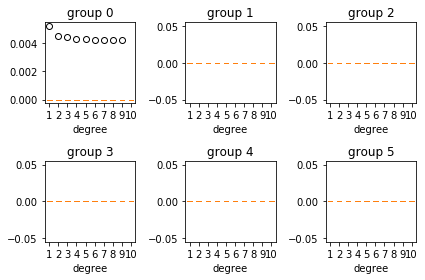

In [138]:
num_col = 3
num_row = int(np.ceil(rmse_te.shape[0]/num_col))

for ind_split_ratio in range(len(split_ratios)):
    f, axs = plt.subplots(num_row, num_col)
    ind_lambda_min_median_rmse_te = np.argmin(np.median(rmse_te[:,ind_split_ratio,:,:,:],axis = 1),axis = 2)

    for ind_group in range(rmse_te.shape[0]):
        #print('RMSE of group ' + str(ind_group) + ' with lambdas = ' + str(lambdas[ind_lambda_min_mean_rmse_te[ind_group]]) + 'minimizing mean(RMSE)')
        #print("RMSE of group = {ind}, with lambdas = {ls} minimizing median(RMSE) :".format(
        #        ind = ind_group, ls= lambdas[ind_lambda_min_median_rmse_te[ind_group]]))
        box_plot_data = rmse_te[ind_group,ind_split_ratio,:,np.arange(len(degrees)),ind_lambda_min_median_rmse_te[ind_group]]
       # print(box_plot_data)
        
        ax = axs[ind_group // num_col][ind_group % num_col]
        ax.boxplot(box_plot_data.T)
        ax.set_title("group "+str(ind_group))
        ax.set_xticklabels(np.around(ax.get_xticks(),2))
        ax.set_xlabel("degree")

    plt.tight_layout()
    plt.savefig("./plots/boxplot_error_groups_penalized_logistic_regression_basic_feature_engineering_median_split_ratio_" + str(split_ratios[ind_split_ratio]).replace('.','_'))
    plt.show()

ABSE of group = 0, with lambdas = [8.532e-03 2.212e-02 1.000e-04 1.000e-04 1.000e-04 6.210e-03 2.807e-01
 1.083e-01 4.520e-03 3.562e-04] minimizing median(RMSE) :
[[1901. 1898. 1811. 1806. 1880.]
 [1313. 1340. 1315. 1319. 1354.]
 [1304. 1302. 3248. 1241. 3202.]
 [1205. 1176. 1206. 1213. 1186.]
 [1200. 1158. 1204. 1201. 1170.]
 [1177. 3243. 1206. 1201. 1174.]
 [1173. 1142. 1172. 1173. 1165.]
 [1171. 1127. 1168. 1185. 1162.]
 [1170. 1117. 1161. 1179. 1163.]
 [1160. 1111. 1157. 1177. 3202.]]
ABSE of group = 1, with lambdas = [3.039e-02 6.210e-03 2.043e-01 1.000e-04 1.000e-04 1.000e-04 1.000e-04
 1.000e-04 1.000e-04 1.000e-04] minimizing median(RMSE) :
[[2169. 2188. 2196. 2094. 2161.]
 [1577. 1579. 1569. 1473. 1489.]
 [1502. 1500. 1531. 1441. 1430.]
 [2667. 2741. 2723. 2705. 2700.]
 [2667. 2741. 2723. 2705. 2700.]
 [2667. 2741. 2723. 2705. 2700.]
 [2667. 2741. 2723. 2705. 2700.]
 [2667. 2741. 2723. 2705. 2700.]
 [2667. 2741. 2723. 2705. 2700.]
 [2667. 2741. 2723. 2705. 2700.]]
ABSE of grou

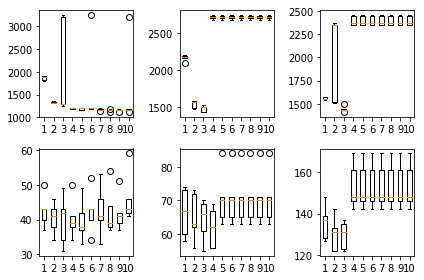

In [95]:
num_col = 3
num_row = int(np.ceil(rmse_te.shape[0]/num_col))

for ind_split_ratio in range(rmse_te.shape[1]):
    f, axs = plt.subplots(num_row, num_col)
    ind_lambda_min_median_rmse_te = np.argmin(np.median(rmse_te[:,ind_split_ratio,:,:,:],axis = 1),axis = 2)

    for ind_group in range(rmse_te.shape[0]):
        #print('RMSE of group ' + str(ind_group) + ' with lambdas = ' + str(lambdas[ind_lambda_min_mean_rmse_te[ind_group]]) + 'minimizing mean(RMSE)')
        with np.printoptions(precision=3, suppress=False):
           # print("ABSE of group = {ind}, with lambdas = {ls} minimizing median(RMSE) :".format(
            #    ind = ind_group, ls= lambdas[ind_lambda_min_median_rmse_te[ind_group]]))
            box_plot_data = abse_te[ind_group,ind_split_ratio,:,np.arange(len(degrees)),ind_lambda_min_mean_rmse_te[ind_group]]
        #print(box_plot_data)
        
        ax = axs[ind_group // num_col][ind_group % num_col]
        ax.boxplot(box_plot_data.T)
    
        ax.set_title("group "+str(ind_group))
        ax.set_xticklabels(np.around(ax.get_xticks(),2))
        ax.set_xlabel("degree")

    plt.tight_layout()
    plt.savefig("./plots/boxplot_abs_error_groups_penalized_logistic_regression_basic_feature_engineering_median_split_ratio_" + str(split_ratios[ind_split_ratio]).replace('.','_'))
    plt.show()

For each subgroup the degree up to which adding polynomial terms of the explanatory minimizes the RMSE can then be determined. Note that the result is robust insofar as taking the lambda that minimizes the mean or median of the RMSE does not matter for the choice of the groups' degrees. The values of the optimal lambdas however is sensitive to that distinction.

In [97]:
ind_split_ratio = 0
ind_lambda_min_mean_rmse_te = np.argmin(np.mean(rmse_te[:,ind_split_ratio,:,:,:],axis = 1),axis = 2)
ind_degrees_mean_star =np.argmin(np.mean(rmse_te[np.meshgrid(range(len(degrees)),range(len(ind_row_groups)))[1].flatten(),ind_split_ratio,:,np.meshgrid(range(len(degrees)),range(len(ind_row_groups)))[0].ravel(),ind_lambda_min_mean_rmse_te.flatten()],axis = 1).reshape([6,10]),axis=1)
degrees_mean_star = ind_degrees_mean_star + 1

ind_lambdas_mean_star = ind_lambda_min_mean_rmse_te[np.arange(ind_lambda_min_mean_rmse_te.shape[0]),ind_degrees_mean_star]

with np.printoptions(precision=3, suppress=False):
    print("The groups' mean testing RMSE for is minimal \n - for lambdas : ",lambdas[ind_lambdas_mean_star]," \n - and degrees : ",degrees_mean_star)


The groups' mean testing RMSE for is minimal 
 - for lambdas :  [9.237e-04 2.043e-01 1.374e-04 4.520e-03 1.000e+00 1.000e-04]  
 - and degrees :  [9 3 3 4 4 3]


In [98]:
ind_split_ratio = 0
ind_lambda_min_median_rmse_te = np.argmin(np.median(rmse_te[:,ind_split_ratio,:,:,:],axis = 1),axis = 2)
ind_degrees_median_star = np.argmin(np.mean(rmse_te[np.meshgrid(range(len(degrees)),range(len(ind_row_groups)))[1].ravel(),ind_split_ratio,:,np.meshgrid(range(len(degrees)),range(len(ind_row_groups)))[0].ravel(),ind_lambda_min_median_rmse_te.ravel()],axis = 1).reshape([6,10]),axis=1)
degrees_median_star = ind_degrees_median_star + 1
ind_lambdas_median_star = ind_lambda_min_median_rmse_te[np.arange(ind_lambda_min_median_rmse_te.shape[0]),ind_degrees_median_star]

with np.printoptions(precision=3, suppress=False):
    print("The groups' median testing RMSE for is minimal \n - for lambdas : ",lambdas[ind_lambdas_median_star]," \n - and degrees : ",degrees_median_star)


The groups' median testing RMSE for is minimal 
 - for lambdas :  [4.520e-03 2.043e-01 1.374e-04 9.237e-04 1.000e-04 1.000e-04]  
 - and degrees :  [9 3 3 4 4 3]


Except for group four (first column, second row in the boxplots above), each group seems to have an apparent optimal degree up to which polynomial terms should be added. As optimizing the degrees added and the ridge term simultaneously requires a lot of computational power, it is not possible to go through many rounds of splitting, testing and training. Thus, instead of simply extracting each group's lambda in addition to the optimal degree from the data generated above, a k-fold cross validation was performed subsequently. 

In [99]:
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)

In [100]:
def cross_validation_logistic_regression_feature_engineering_ridge(tX, y, degree, k_indices, k, max_iters, threshold, lambdas, gamma = 1):
    """
    Auxiliary function for k-means cross validation.
    
    The function splits the data into a test and a training, adds polynomial terms of the explanatory variables up to 
    a given degree, and finds the optimal weights by performing a penalized logistic regression on the training set
    given a set of lambdas.
    
    It returns the RMSE as well as the absolute error (0 or 1) of the predictions for the test and the training sets.
    """
    
    # ***************************************************
    # split the data, and return train and test data
    # ***************************************************
    tX_test_split = tX[k_indices[k],:]
    tX_train_split = np.delete(tX,k_indices[k],axis=0)
    y_test_split = y[k_indices[k]]
    y_train_split = np.delete(y,k_indices[k])
    
    # ***************************************************
    # form train and test data with polynomial basis function:
    # ***************************************************
    tX_train_split_extended = add_higher_degree_terms(tX_train_split, degree)
    tX_test_split_extended = add_higher_degree_terms(tX_test_split, degree)
    
    # ***************************************************
    # calcualte most likely weights through logistic regression with ridge term
    # ***************************************************
    ind_col_non_const = np.arange(len(tX_train_split_extended[0,:]))[np.std(tX_train_split_extended,0)>0]
    
    tX_train_split_extended = adding_offset(tX_train_split_extended)
    tX_test_split_extended = adding_offset(tX_test_split_extended)
    ind_col_non_const += 1
    ind_col_non_const = np.insert(ind_col_non_const,0, 0)
    
    rmse_tr = np.zeros(len(lambdas))
    rmse_te = np.zeros(len(lambdas))
    
    abse_tr = np.zeros(len(lambdas))
    abse_te = np.zeros(len(lambdas))
    
    for ind_lambda, lambda_ in enumerate(lambdas):
        
        log_likelihoods, ws = penalized_logistic_regression(y_train_split, tX_train_split_extended[:,ind_col_non_const], max_iters, threshold,lambda_,gamma)
    
        ind_min = np.argmin(log_likelihoods)
        w_star = np.zeros(len(tX_train_split_extended[0,:]))
        w_star[ind_col_non_const] = ws[ind_min]

        # ***************************************************
        # calculate RMSE and ABSE for train and test data,and store them in rmse_tr, abse_tr, rmse_te and abse_te respectively
        # ***************************************************
        
        log_likelihoods_train = calculate_loss_logistic_regression(y_train_split, tX_train_split_extended, w_star)
        log_likelihoods_test = calculate_loss_logistic_regression(y_test_split, tX_test_split_extended, w_star)
    
        rmse_tr[ind_lambda] = np.linalg.norm((y_train_split - compute_p(w_star,tX_train_split_extended))/y_train_split.shape[0])
        rmse_te[ind_lambda] = np.linalg.norm((y_test_split - compute_p(w_star,tX_test_split_extended))/y_test_split.shape[0])
        
        abse_tr[ind_lambda] = np.sum(abs(y_train_split - [compute_p(w_star,tX_train_split_extended) > 0.5]))
        abse_te[ind_lambda] = np.sum(abs(y_test_split - [compute_p(w_star,tX_test_split_extended) > 0.5]))
        
        print("degree={d}, k={k_}, lambda={l:10.3e}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}, Training loss={trl:.3f}, Testing loss={tel:.3f}, Training # Missclassification ={m_tr:.3f}, Testing # Missclassification={m_te:.3f}".format(
            d=degree, k_=k, l= lambda_, tr=rmse_tr[ind_lambda], te=rmse_te[ind_lambda], trl = log_likelihoods_train, tel = log_likelihoods_test, m_tr = abse_tr[ind_lambda], m_te = abse_te[ind_lambda]))
        
    return rmse_tr, rmse_te, abse_tr, abse_te

In [571]:
seed = 50
max_iters = 20
threshold = 10**(-8)
lambdas = np.logspace(-5, 0, 50)
gamma = 1

print(degrees_median_star)

k_fold = 20

rmse_tr = np.zeros([len(ind_row_groups),k_fold,len(lambdas)])
rmse_te = np.zeros([len(ind_row_groups),k_fold,len(lambdas)])
abse_tr = np.zeros([len(ind_row_groups),k_fold,len(lambdas)])
abse_te = np.zeros([len(ind_row_groups),k_fold,len(lambdas)])


for ind_group, ind_row_group in enumerate(ind_row_groups):
    print('group (' + str(ind_group + 1) + '/' + str(len(groups_mv_num)) + ')') 
    k_indices = build_k_indices(rescale_y(y[ind_row_group]), k_fold, seed)
    for k in range(k_fold):
        rmse_tr[ind_group,k,:],rmse_te[ind_group,k,:],abse_tr[ind_group,k,:],abse_te[ind_group,k,:] = cross_validation_logistic_regression_feature_engineering_ridge(tX[ind_row_group], rescale_y(y[ind_row_group]), degrees_median[ind_group], k_indices, k, max_iters, threshold, lambdas, gamma)


[9 3 3 4 4 3]
group (1/6)
Current iteration=0, the loss=27601.66880469692
Current iteration=1, the loss=24993.514418547675
Current iteration=2, the loss=24471.56577771362
Current iteration=3, the loss=24421.441672869245
Current iteration=4, the loss=24418.662579758122
Current iteration=5, the loss=24419.53322948544
Current iteration=6, the loss=24415.81871016982
Current iteration=7, the loss=24447.83700553473
Current iteration=8, the loss=inf
invalid value encountered in true_divide
degree=9, k=0, lambda= 1.000e-05, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24412.791, Testing loss=1366.748, Training # Missclassification =10793.000, Testing # Missclassification=568.000
Current iteration=0, the loss=27601.7742293709
Current iteration=1, the loss=24994.063794389447
Current iteration=2, the loss=24471.898762765708
Current iteration=3, the loss=24423.127336177495
Current iteration=4, the loss=24418.267728840878
Current iteration=5, the loss=24415.633868512385
Current iteration=

Current iteration=4, the loss=24421.033245674676
Current iteration=5, the loss=24419.02606555627
Current iteration=6, the loss=24417.931717352127
Current iteration=7, the loss=24525.997965445997
Current iteration=8, the loss=inf
invalid value encountered in true_divide
degree=9, k=0, lambda= 1.677e-04, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24416.219, Testing loss=1341.804, Training # Missclassification =10794.000, Testing # Missclassification=568.000
Current iteration=0, the loss=27605.130060957665
Current iteration=1, the loss=24999.274969795402
Current iteration=2, the loss=24477.675885064644
Current iteration=3, the loss=24427.012122105298
Current iteration=4, the loss=24421.93279306088
Current iteration=5, the loss=24419.328901568668
Current iteration=6, the loss=24418.321918686197
Current iteration=7, the loss=24533.06725743974
Current iteration=8, the loss=inf
invalid value encountered in true_divide
degree=9, k=0, lambda= 2.121e-04, Training RMSE=0.001, Testing 

Current iteration=0, the loss=27613.090760845906
Current iteration=1, the loss=25009.042046961626
Current iteration=2, the loss=24484.65552720585
Current iteration=3, the loss=24444.52051871199
Current iteration=4, the loss=24430.89502152294
Current iteration=5, the loss=24426.59936859517
Current iteration=6, the loss=24426.029054186354
Current iteration=7, the loss=24581.136962904406
Current iteration=8, the loss=inf
invalid value encountered in true_divide
degree=9, k=0, lambda= 3.556e-03, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24420.693, Testing loss=1328.390, Training # Missclassification =10799.000, Testing # Missclassification=566.000
Current iteration=0, the loss=27631.847923144272
Current iteration=1, the loss=25019.556579352608
Current iteration=2, the loss=24485.04296446162
Current iteration=3, the loss=24530.539672309103
Current iteration=4, the loss=24430.59158524881
Current iteration=5, the loss=24427.722745630745
Current iteration=6, the loss=24428.1446802

Current iteration=5, the loss=24460.29065271471
Current iteration=6, the loss=24474.846797432023
Current iteration=7, the loss=24614.48963531734
Current iteration=8, the loss=inf
invalid value encountered in true_divide
degree=9, k=0, lambda= 5.964e-02, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24436.328, Testing loss=1299.221, Training # Missclassification =10818.000, Testing # Missclassification=567.000
Current iteration=0, the loss=27631.98931353411
Current iteration=1, the loss=25666.48505353766
Current iteration=2, the loss=24512.824144595543
Current iteration=3, the loss=24582.65449201048
Current iteration=4, the loss=24504.191792526635
Current iteration=5, the loss=24530.854959162625
Current iteration=6, the loss=24454.137659713306
Current iteration=7, the loss=24623.184822174568
Current iteration=8, the loss=inf
invalid value encountered in true_divide
degree=9, k=0, lambda= 7.543e-02, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24436.852, Testing loss=1

Current iteration=0, the loss=27614.443255510647
Current iteration=1, the loss=24997.582416835892
Current iteration=2, the loss=24468.681314312747
Current iteration=3, the loss=24419.92115042536
Current iteration=4, the loss=24417.76650443945
Current iteration=5, the loss=24435.212920907627
Current iteration=6, the loss=24449.912916874353
Current iteration=7, the loss=24502.19670164569
Current iteration=8, the loss=24591.326158291882
Current iteration=9, the loss=24529.015817264954
underflow encountered in multiply
degree=9, k=1, lambda= 1.000e-05, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24416.518, Testing loss=1271.902, Training # Missclassification =10791.000, Testing # Missclassification=565.000
Current iteration=0, the loss=27614.41445737759
Current iteration=1, the loss=24997.802517498654
Current iteration=2, the loss=24468.919676002017
Current iteration=3, the loss=24420.059509711267
Current iteration=4, the loss=24417.724408396993
Current iteration=5, the loss=244

Current iteration=5, the loss=24419.550463514362
Current iteration=6, the loss=24418.806550405578
Current iteration=7, the loss=24418.212299963194
Current iteration=8, the loss=24417.40459377084
Current iteration=9, the loss=24416.57349053457
Current iteration=10, the loss=24416.480183930933
Current iteration=11, the loss=24416.46016548962
Current iteration=12, the loss=24416.45515492073
Current iteration=13, the loss=24415.503154978756
underflow encountered in multiply
degree=9, k=1, lambda= 1.048e-04, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24413.866, Testing loss=inf, Training # Missclassification =10797.000, Testing # Missclassification=568.000
Current iteration=0, the loss=27616.50702164241
Current iteration=1, the loss=25005.916445611325
Current iteration=2, the loss=24473.415434693114
Current iteration=3, the loss=24424.322252258764
Current iteration=4, the loss=24422.551221347207
Current iteration=5, the loss=24419.829012252772
Current iteration=6, the loss=24419

Current iteration=10, the loss=24419.34057170135
Current iteration=11, the loss=24419.32210456266
Current iteration=12, the loss=24419.316540478074
Current iteration=13, the loss=24418.369790514123
Current iteration=14, the loss=24420.24161175956
Current iteration=15, the loss=24417.956835933273
Current iteration=16, the loss=24417.947886268124
Current iteration=17, the loss=24417.94710073391
Current iteration=18, the loss=24417.947073465126
Current iteration=19, the loss=24417.94707303707
degree=9, k=1, lambda= 6.866e-04, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24416.290, Testing loss=inf, Training # Missclassification =10806.000, Testing # Missclassification=563.000
Current iteration=0, the loss=27638.008209670836
Current iteration=1, the loss=25006.491948922176
Current iteration=2, the loss=24477.073888629493
Current iteration=3, the loss=24433.209024432952
Current iteration=4, the loss=24424.501629382507
Current iteration=5, the loss=24422.7977000278
Current iteratio

Current iteration=12, the loss=24424.49003210191
Current iteration=13, the loss=24427.880008736982
underflow encountered in multiply
degree=9, k=1, lambda= 4.498e-03, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24420.219, Testing loss=inf, Training # Missclassification =10813.000, Testing # Missclassification=563.000
Current iteration=0, the loss=27627.011098563104
Current iteration=1, the loss=25013.555888961324
Current iteration=2, the loss=24484.331428249658
Current iteration=3, the loss=24435.58023850489
Current iteration=4, the loss=24430.076806084635
Current iteration=5, the loss=24433.246072962575
Current iteration=6, the loss=24429.52995245168
Current iteration=7, the loss=24458.885839008875
Current iteration=8, the loss=24426.499169946434
Current iteration=9, the loss=24425.81390268623
Current iteration=10, the loss=24425.56900029528
Current iteration=11, the loss=24425.55153729314
Current iteration=12, the loss=24425.544344784183
Current iteration=13, the loss=2443

Current iteration=12, the loss=24437.847800450912
Current iteration=13, the loss=24710.994485501564
Current iteration=14, the loss=inf
invalid value encountered in true_divide
degree=9, k=1, lambda= 3.728e-02, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24428.722, Testing loss=inf, Training # Missclassification =10813.000, Testing # Missclassification=563.000
Current iteration=0, the loss=28083.638146296697
Current iteration=1, the loss=25098.725359660362
Current iteration=2, the loss=24510.60099107571
Current iteration=3, the loss=24631.159384428658
Current iteration=4, the loss=24626.272279530753
Current iteration=5, the loss=24443.76448124931
Current iteration=6, the loss=24442.97228518981
Current iteration=7, the loss=24443.103612199513
Current iteration=8, the loss=24440.953069939005
Current iteration=9, the loss=24440.305467062884
Current iteration=10, the loss=24442.824201101055
Current iteration=11, the loss=24440.16592181433
Current iteration=12, the loss=24440.1246

Current iteration=0, the loss=48046.92100401741
Current iteration=1, the loss=25109.657551611555
Current iteration=2, the loss=24626.385110684947
Current iteration=3, the loss=24544.159544317914
Current iteration=4, the loss=25253.865251404797
Current iteration=5, the loss=29295.96283456858
Current iteration=6, the loss=24519.397738432297
Current iteration=7, the loss=24522.625683731898
Current iteration=8, the loss=24627.6374450266
underflow encountered in multiply
degree=9, k=1, lambda= 3.907e-01, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24453.879, Testing loss=1276.929, Training # Missclassification =10833.000, Testing # Missclassification=567.000
Current iteration=0, the loss=29603.513885868433
Current iteration=1, the loss=25073.370630342848
Current iteration=2, the loss=24571.137156873472
Current iteration=3, the loss=25429.133465830135
Current iteration=4, the loss=26625.145065972403
Current iteration=5, the loss=24526.561297212185
Current iteration=6, the loss=254

Current iteration=12, the loss=24351.70453855048
Current iteration=13, the loss=24350.70172275668
Current iteration=14, the loss=24352.46495198652
underflow encountered in multiply
degree=9, k=2, lambda= 2.560e-05, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24348.652, Testing loss=1347.592, Training # Missclassification =10743.000, Testing # Missclassification=612.000
Current iteration=0, the loss=27558.34817891875
Current iteration=1, the loss=24933.88673647785
Current iteration=2, the loss=24406.926887694288
Current iteration=3, the loss=24358.142678405507
Current iteration=4, the loss=24355.024698647914
Current iteration=5, the loss=24353.203451857167
Current iteration=6, the loss=24353.489250229424
Current iteration=7, the loss=24352.188612642334
Current iteration=8, the loss=24351.955556067256
Current iteration=9, the loss=24351.595174797683
Current iteration=10, the loss=24351.310619011496
Current iteration=11, the loss=24351.13143099054
Current iteration=12, the loss

degree=9, k=2, lambda= 2.683e-04, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24353.531, Testing loss=1345.673, Training # Missclassification =10744.000, Testing # Missclassification=611.000
Current iteration=0, the loss=27576.494970285938
Current iteration=1, the loss=24940.20969684996
Current iteration=2, the loss=24413.1642788004
Current iteration=3, the loss=24363.626829892168
Current iteration=4, the loss=24360.503988562366
Current iteration=5, the loss=24367.036210340884
Current iteration=6, the loss=24362.407394771726
Current iteration=7, the loss=24356.782136871592
Current iteration=8, the loss=24356.627498663456
Current iteration=9, the loss=24356.287786175362
Current iteration=10, the loss=24355.99540526145
Current iteration=11, the loss=24355.85439867432
underflow encountered in multiply
degree=9, k=2, lambda= 3.393e-04, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24354.037, Testing loss=1345.520, Training # Missclassification =10745.000, Testing # Miss

Current iteration=0, the loss=27570.969655243
Current iteration=1, the loss=24947.210106085204
Current iteration=2, the loss=24428.1781019469
Current iteration=3, the loss=24370.53942357484
Current iteration=4, the loss=24367.58061632602
Current iteration=5, the loss=24374.619443176467
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=9, k=2, lambda= 4.498e-03, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24362.064, Testing loss=1344.092, Training # Missclassification =10737.000, Testing # Missclassification=613.000
Current iteration=0, the loss=27626.518695400893
Current iteration=1, the loss=24948.181203125954
Current iteration=2, the loss=24667.51375890597
Current iteration=3, the loss=24371.997317384976
Current iteration=4, the loss=24370.30354967959
Current iteration=5, the loss=24381.45465359946
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=9, k=2, lambda= 5.690e-03, Training RMSE=0.001, Testing RMSE=0.

Current iteration=5, the loss=25026.78721462457
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=9, k=2, lambda= 1.207e-01, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24379.534, Testing loss=1342.969, Training # Missclassification =10771.000, Testing # Missclassification=615.000
Current iteration=0, the loss=27661.193577215912
Current iteration=1, the loss=24983.77916278567
Current iteration=2, the loss=27591.64111593876
Current iteration=3, the loss=24483.7978221143
Current iteration=4, the loss=24418.970066934573
Current iteration=5, the loss=24413.410960243098
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=9, k=2, lambda= 1.526e-01, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24390.767, Testing loss=1344.741, Training # Missclassification =10756.000, Testing # Missclassification=615.000
Current iteration=0, the loss=33391.5082253318
Current iteration=1, the loss=24980.18389217819
Current itera

Current iteration=2, the loss=24480.100591793635
Current iteration=3, the loss=24439.05203922631
Current iteration=4, the loss=25735.634712844356
Current iteration=5, the loss=52974.76160515397
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=9, k=3, lambda= 1.600e-05, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24437.595, Testing loss=1266.108, Training # Missclassification =10797.000, Testing # Missclassification=548.000
Current iteration=0, the loss=27605.50674995476
Current iteration=1, the loss=24999.19665761562
Current iteration=2, the loss=24480.5352841476
Current iteration=3, the loss=24439.876443057048
Current iteration=4, the loss=25741.465658083947
Current iteration=5, the loss=41964.96719318457
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=9, k=3, lambda= 2.024e-05, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24437.834, Testing loss=1266.088, Training # Missclassification =10799.000, 

Current iteration=0, the loss=27609.927264657672
Current iteration=1, the loss=25006.532254502545
Current iteration=2, the loss=24488.907663105503
Current iteration=3, the loss=24474.25142237822
Current iteration=4, the loss=26959.419949944902
Current iteration=5, the loss=42810.91107224088
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=9, k=3, lambda= 5.429e-04, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24472.349, Testing loss=1266.096, Training # Missclassification =10797.000, Testing # Missclassification=547.000
Current iteration=0, the loss=27610.484880263062
Current iteration=1, the loss=25007.194053790543
Current iteration=2, the loss=24489.386615891224
Current iteration=3, the loss=24481.404526094102
Current iteration=4, the loss=27316.553251956684
Current iteration=5, the loss=43623.81985074685
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=9, k=3, lambda= 6.866e-04, Training RMSE=0.001, Testing 

Current iteration=11, the loss=nan
Current iteration=12, the loss=nan
Current iteration=13, the loss=nan
Current iteration=14, the loss=nan
Current iteration=15, the loss=nan
Current iteration=16, the loss=nan
Current iteration=17, the loss=nan
Current iteration=18, the loss=nan
Current iteration=19, the loss=nan
degree=9, k=3, lambda= 5.690e-03, Training RMSE=0.003, Testing RMSE=0.012, Training loss=nan, Testing loss=nan, Training # Missclassification =30269.000, Testing # Missclassification=1625.000
Current iteration=0, the loss=27853.296537844755
Current iteration=1, the loss=25015.18236857593
Current iteration=2, the loss=24498.188558597725
Current iteration=3, the loss=24556.490324272803
Current iteration=4, the loss=28155.47053385954
Current iteration=5, the loss=54139.136348962034
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=9, k=3, lambda= 7.197e-03, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24492.712, Testing loss=1273.508, Tra

Current iteration=0, the loss=29566.663487246344
Current iteration=1, the loss=25098.207843885142
Current iteration=2, the loss=24531.79567762018
Current iteration=3, the loss=24485.374523129514
Current iteration=4, the loss=25161.615900783265
Current iteration=5, the loss=328331.4420181563
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=9, k=3, lambda= 1.931e-01, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24453.975, Testing loss=1271.042, Training # Missclassification =10840.000, Testing # Missclassification=546.000
Current iteration=0, the loss=29276.13561694052
Current iteration=1, the loss=25097.034242184815
Current iteration=2, the loss=24864.337211793296
Current iteration=3, the loss=24770.69186811927
Current iteration=4, the loss=24973.499262571488
Current iteration=5, the loss=64896.66463080517
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=9, k=3, lambda= 2.442e-01, Training RMSE=0.001, Testing RM

Current iteration=11, the loss=24475.446019554187
underflow encountered in multiply
degree=9, k=4, lambda= 2.560e-05, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24437.802, Testing loss=1256.190, Training # Missclassification =10796.000, Testing # Missclassification=537.000
Current iteration=0, the loss=27620.71501823989
Current iteration=1, the loss=25016.753511125058
Current iteration=2, the loss=24497.289090704555
Current iteration=3, the loss=24447.643808257355
Current iteration=4, the loss=24444.195744052326
Current iteration=5, the loss=24442.01196794952
Current iteration=6, the loss=24440.79304497335
Current iteration=7, the loss=24440.1087740086
Current iteration=8, the loss=24439.868252100765
Current iteration=9, the loss=24439.12043456816
Current iteration=10, the loss=24438.980828885804
Current iteration=11, the loss=24438.8381140714
underflow encountered in multiply
degree=9, k=4, lambda= 3.237e-05, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24437.842

Current iteration=0, the loss=27626.054672907394
Current iteration=1, the loss=25021.90813390157
Current iteration=2, the loss=24499.98714736267
Current iteration=3, the loss=24452.16799140637
Current iteration=4, the loss=24448.346641315406
Current iteration=5, the loss=24447.160130785025
Current iteration=6, the loss=24443.43925854248
Current iteration=7, the loss=24443.22604031825
Current iteration=8, the loss=24442.31906137973
Current iteration=9, the loss=24441.673525565126
Current iteration=10, the loss=24441.561888378168
Current iteration=11, the loss=24441.436089310686
underflow encountered in multiply
degree=9, k=4, lambda= 3.393e-04, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24439.949, Testing loss=1259.363, Training # Missclassification =10798.000, Testing # Missclassification=536.000
Current iteration=0, the loss=27625.245697650636
Current iteration=1, the loss=25022.72707008667
Current iteration=2, the loss=24500.54712829563
Current iteration=3, the loss=24452

Current iteration=0, the loss=27651.908557001476
Current iteration=1, the loss=25028.69256251788
Current iteration=2, the loss=24508.277627165542
Current iteration=3, the loss=24458.9273539028
Current iteration=4, the loss=24461.664591172364
Current iteration=5, the loss=24455.184194050027
Current iteration=6, the loss=24452.03786249354
Current iteration=7, the loss=24450.523178752046
Current iteration=8, the loss=24450.025835342825
Current iteration=9, the loss=24449.484490260038
Current iteration=10, the loss=24449.30627063425
Current iteration=11, the loss=24449.683240899754
underflow encountered in multiply
degree=9, k=4, lambda= 3.556e-03, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24443.539, Testing loss=1254.753, Training # Missclassification =10793.000, Testing # Missclassification=535.000
Current iteration=0, the loss=27763.689124609224
Current iteration=1, the loss=25030.151458812285
Current iteration=2, the loss=24506.87416960142
Current iteration=3, the loss=244

Current iteration=0, the loss=28187.692607579465
Current iteration=1, the loss=25042.196953805826
Current iteration=2, the loss=24521.273961212944
Current iteration=3, the loss=24476.404865334596
Current iteration=4, the loss=24471.365356639657
Current iteration=5, the loss=24476.0925649954
Current iteration=6, the loss=24474.816333468414
Current iteration=7, the loss=24468.61814528605
Current iteration=8, the loss=24468.412648405272
Current iteration=9, the loss=24467.3639770937
Current iteration=10, the loss=24467.27755508277
Current iteration=11, the loss=24502.889389882715
underflow encountered in multiply
degree=9, k=4, lambda= 3.728e-02, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24457.256, Testing loss=1249.645, Training # Missclassification =10800.000, Testing # Missclassification=545.000
Current iteration=0, the loss=28003.322313080127
Current iteration=1, the loss=25044.518207645633
Current iteration=2, the loss=24524.268075399366
Current iteration=3, the loss=244

Current iteration=0, the loss=33721.13314091195
Current iteration=1, the loss=25118.531727800102
Current iteration=2, the loss=24960.658759656213
Current iteration=3, the loss=24521.5093690459
Current iteration=4, the loss=24751.258396223053
Current iteration=5, the loss=24868.733373698866
Current iteration=6, the loss=24544.910964952123
Current iteration=7, the loss=24511.044886379394
Current iteration=8, the loss=24514.238029428638
Current iteration=9, the loss=24509.805592233948
Current iteration=10, the loss=24511.700131341808
Current iteration=11, the loss=24675.115831768213
Current iteration=12, the loss=24534.315214303264
underflow encountered in multiply
degree=9, k=4, lambda= 3.907e-01, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24482.345, Testing loss=1256.996, Training # Missclassification =10842.000, Testing # Missclassification=543.000
Current iteration=0, the loss=31940.707686927504
Current iteration=1, the loss=28585.89313634556
Current iteration=2, the loss=

Current iteration=2, the loss=24431.525291407957
Current iteration=3, the loss=24382.592934552216
Current iteration=4, the loss=24379.311035271658
Current iteration=5, the loss=24406.275594014423
Current iteration=6, the loss=24969.699403054645
Current iteration=7, the loss=24582.488558423127
Current iteration=8, the loss=25149.59323112442
Current iteration=9, the loss=24405.688450473106
Current iteration=10, the loss=24377.097963939796
Current iteration=11, the loss=24375.15965588511
Current iteration=12, the loss=24375.074259243294
Current iteration=13, the loss=24374.635837984068
underflow encountered in multiply
degree=9, k=5, lambda= 2.560e-05, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24373.046, Testing loss=1312.005, Training # Missclassification =10790.000, Testing # Missclassification=566.000
Current iteration=0, the loss=27582.61383500814
Current iteration=1, the loss=24960.889748541773
Current iteration=2, the loss=24445.79938689208
Current iteration=3, the loss

Current iteration=6, the loss=24379.97500248385
Current iteration=7, the loss=24379.740784152855
Current iteration=8, the loss=24379.111905492657
Current iteration=9, the loss=24378.215455088506
Current iteration=10, the loss=24377.969902098102
Current iteration=11, the loss=24377.89560993171
Current iteration=12, the loss=24377.83300142747
Current iteration=13, the loss=24377.62322280957
Current iteration=14, the loss=24377.09952817519
Current iteration=15, the loss=24376.83616843919
Current iteration=16, the loss=24477.497147910188
Current iteration=17, the loss=inf
invalid value encountered in true_divide
degree=9, k=5, lambda= 1.677e-04, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24375.266, Testing loss=1312.224, Training # Missclassification =10795.000, Testing # Missclassification=561.000
Current iteration=0, the loss=27584.773316223116
Current iteration=1, the loss=24965.283850798278
Current iteration=2, the loss=24435.902172150014
Current iteration=3, the loss=24389

Current iteration=5, the loss=24387.527734766292
Current iteration=6, the loss=24383.993234248734
Current iteration=7, the loss=24383.53322828506
Current iteration=8, the loss=24382.89773362147
Current iteration=9, the loss=24382.37043798205
Current iteration=10, the loss=24381.65800397153
Current iteration=11, the loss=24381.606319349987
underflow encountered in multiply
degree=9, k=5, lambda= 1.389e-03, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24379.018, Testing loss=1312.351, Training # Missclassification =10778.000, Testing # Missclassification=564.000
Current iteration=0, the loss=27596.70858117091
Current iteration=1, the loss=24970.50378743845
Current iteration=2, the loss=24445.853866684636
Current iteration=3, the loss=24394.25461377995
Current iteration=4, the loss=24386.786446905964
Current iteration=5, the loss=24388.213968440534
Current iteration=6, the loss=24385.413799781938
Current iteration=7, the loss=24384.855260465178
Current iteration=8, the loss=2438

Current iteration=14, the loss=24393.723342976442
Current iteration=15, the loss=24409.69143704899
Current iteration=16, the loss=inf
invalid value encountered in true_divide
degree=9, k=5, lambda= 1.842e-02, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24385.864, Testing loss=1312.956, Training # Missclassification =10788.000, Testing # Missclassification=573.000
Current iteration=0, the loss=27613.875760532435
Current iteration=1, the loss=24983.782656489468
Current iteration=2, the loss=24463.029017844958
Current iteration=3, the loss=24407.200563975715
Current iteration=4, the loss=24406.473041638837
Current iteration=5, the loss=24402.831579069247
Current iteration=6, the loss=24399.936622965983
Current iteration=7, the loss=24406.28767936933
Current iteration=8, the loss=24871.39646274035
Current iteration=9, the loss=inf
invalid value encountered in true_divide
degree=9, k=5, lambda= 2.330e-02, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24390.145, Testing l

Current iteration=8, the loss=24433.991726164284
Current iteration=9, the loss=24454.204411381983
Current iteration=10, the loss=24428.167054912523
Current iteration=11, the loss=24428.49042336218
Current iteration=12, the loss=24448.64886742568
Current iteration=13, the loss=24427.9204282063
Current iteration=14, the loss=24427.20175225561
Current iteration=15, the loss=24493.523106939057
Current iteration=16, the loss=inf
Current iteration=17, the loss=nan
Current iteration=18, the loss=nan
Current iteration=19, the loss=nan
degree=9, k=5, lambda= 1.931e-01, Training RMSE=0.003, Testing RMSE=0.012, Training loss=nan, Testing loss=nan, Training # Missclassification =30328.000, Testing # Missclassification=1566.000
Current iteration=0, the loss=27812.217213833723
Current iteration=1, the loss=25029.53447499964
Current iteration=2, the loss=24516.290891481323
Current iteration=3, the loss=24444.475093146473
Current iteration=4, the loss=24462.58046583145
Current iteration=5, the loss=24

Current iteration=4, the loss=24459.92084636645
Current iteration=5, the loss=24556.51421907288
Current iteration=6, the loss=25429.812541010713
Current iteration=7, the loss=inf
invalid value encountered in true_divide
degree=9, k=6, lambda= 1.600e-05, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24429.375, Testing loss=1311.748, Training # Missclassification =10822.000, Testing # Missclassification=560.000
Current iteration=0, the loss=27575.738014182898
Current iteration=1, the loss=24958.662783616386
Current iteration=2, the loss=24434.264941206256
Current iteration=3, the loss=24383.248833947473
Current iteration=4, the loss=24380.670342566278
Current iteration=5, the loss=24439.72390343373
Current iteration=6, the loss=24968.166302051508
Current iteration=7, the loss=inf
invalid value encountered in true_divide
degree=9, k=6, lambda= 2.024e-05, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24378.888, Testing loss=1310.685, Training # Missclassification =10780.0

Current iteration=0, the loss=27580.696820168814
Current iteration=1, the loss=24965.712449362658
Current iteration=2, the loss=24437.588683026705
Current iteration=3, the loss=24388.821870285563
Current iteration=4, the loss=24385.514118418538
Current iteration=5, the loss=24383.653817967363
Current iteration=6, the loss=24750.79242429783
Current iteration=7, the loss=inf
invalid value encountered in true_divide
degree=9, k=6, lambda= 4.292e-04, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24381.868, Testing loss=1311.129, Training # Missclassification =10794.000, Testing # Missclassification=560.000
Current iteration=0, the loss=27582.40713691839
Current iteration=1, the loss=24966.063416512236
Current iteration=2, the loss=24438.05269869958
Current iteration=3, the loss=24391.748229380682
Current iteration=4, the loss=24386.35058965236
Current iteration=5, the loss=24384.182051773132
Current iteration=6, the loss=24716.427742187858
Current iteration=7, the loss=inf
invalid

degree=9, k=6, lambda= 7.197e-03, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24385.969, Testing loss=1310.789, Training # Missclassification =10806.000, Testing # Missclassification=562.000
Current iteration=0, the loss=27631.903267150756
Current iteration=1, the loss=24975.194758137197
Current iteration=2, the loss=24447.6191626626
Current iteration=3, the loss=24406.388445958604
Current iteration=4, the loss=24396.631604273523
Current iteration=5, the loss=24462.401035258194
Current iteration=6, the loss=24394.428110762197
Current iteration=7, the loss=24396.669956952024
Current iteration=8, the loss=24393.59324503135
Current iteration=9, the loss=24591.484594609774
underflow encountered in multiply
degree=9, k=6, lambda= 9.103e-03, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24387.003, Testing loss=1310.766, Training # Missclassification =10821.000, Testing # Missclassification=562.000
Current iteration=0, the loss=27590.41252337126
Current iteration=1, the lo

Current iteration=3, the loss=24517.640532498313
Current iteration=4, the loss=24429.30570827579
Current iteration=5, the loss=24465.309583901137
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=9, k=6, lambda= 1.526e-01, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24407.080, Testing loss=1310.901, Training # Missclassification =10837.000, Testing # Missclassification=562.000
Current iteration=0, the loss=27727.404143485717
Current iteration=1, the loss=25030.44441362175
Current iteration=2, the loss=24674.962508171102
Current iteration=3, the loss=24562.328660508432
Current iteration=4, the loss=24434.42547195286
Current iteration=5, the loss=24544.34437879669
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=9, k=6, lambda= 1.931e-01, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24409.622, Testing loss=1311.098, Training # Missclassification =10831.000, Testing # Missclassification=564.000
Current i

Current iteration=3, the loss=24377.794395492074
Current iteration=4, the loss=24375.006379461385
Current iteration=5, the loss=24373.503112079085
Current iteration=6, the loss=24372.731049451333
Current iteration=7, the loss=24372.465548524557
Current iteration=8, the loss=24371.584399152493
Current iteration=9, the loss=24370.929716509232
Current iteration=10, the loss=24370.383812700755
underflow encountered in multiply
degree=9, k=7, lambda= 2.560e-05, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24369.054, Testing loss=1317.210, Training # Missclassification =10794.000, Testing # Missclassification=589.000
Current iteration=0, the loss=27575.2101845883
Current iteration=1, the loss=24953.763561949356
Current iteration=2, the loss=24426.85423084352
Current iteration=3, the loss=24378.249225575888
Current iteration=4, the loss=24375.28820748411
Current iteration=5, the loss=24373.627150795997
Current iteration=6, the loss=24373.03417705513
Current iteration=7, the loss=243

Current iteration=0, the loss=27580.621088078515
Current iteration=1, the loss=24959.203706066786
Current iteration=2, the loss=24431.943165460103
Current iteration=3, the loss=24382.692430350246
Current iteration=4, the loss=24379.40138049592
Current iteration=5, the loss=24382.77976978332
Current iteration=6, the loss=24376.81448724892
Current iteration=7, the loss=24376.552328934416
Current iteration=8, the loss=24375.55418278168
Current iteration=9, the loss=24374.916695223008
Current iteration=10, the loss=24374.430175032005
underflow encountered in multiply
degree=9, k=7, lambda= 3.393e-04, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24372.884, Testing loss=1317.640, Training # Missclassification =10788.000, Testing # Missclassification=586.000
Current iteration=0, the loss=27581.540217810078
Current iteration=1, the loss=24959.87650207562
Current iteration=2, the loss=24432.473054730854
Current iteration=3, the loss=24383.222142210656
Current iteration=4, the loss=243

Current iteration=0, the loss=27586.923441347
Current iteration=1, the loss=24965.765465266493
Current iteration=2, the loss=24437.423990271716
Current iteration=3, the loss=24389.300981983753
Current iteration=4, the loss=24387.09136576831
Current iteration=5, the loss=24404.824799821654
Current iteration=6, the loss=24382.92738665561
Current iteration=7, the loss=24382.266535781913
Current iteration=8, the loss=24381.047590590962
Current iteration=9, the loss=24380.633340623062
Current iteration=10, the loss=24380.344567124102
Current iteration=11, the loss=24380.113416196033
Current iteration=12, the loss=24379.579598947934
Current iteration=13, the loss=24380.6919588983
Current iteration=14, the loss=24392.362049581297
Current iteration=15, the loss=inf
invalid value encountered in true_divide
degree=9, k=7, lambda= 3.556e-03, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24375.377, Testing loss=1318.025, Training # Missclassification =10785.000, Testing # Missclassificati

Current iteration=8, the loss=24397.94363577528
Current iteration=9, the loss=24395.73560401538
underflow encountered in multiply
degree=9, k=7, lambda= 3.728e-02, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24386.303, Testing loss=1318.869, Training # Missclassification =10792.000, Testing # Missclassification=582.000
Current iteration=0, the loss=27714.770627519916
Current iteration=1, the loss=24990.03159215436
Current iteration=2, the loss=24461.371266600236
Current iteration=3, the loss=24460.89167321682
Current iteration=4, the loss=24403.00248090061
Current iteration=5, the loss=24413.718497539994
Current iteration=6, the loss=24424.39469722767
Current iteration=7, the loss=24413.18841408946
Current iteration=8, the loss=24400.656662674846
Current iteration=9, the loss=24398.255058803985
underflow encountered in multiply
degree=9, k=7, lambda= 4.715e-02, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24387.529, Testing loss=1318.997, Training # Missclassificat

Current iteration=0, the loss=27648.77325548289
Current iteration=1, the loss=25128.33917712433
Current iteration=2, the loss=25207.39804170729
Current iteration=3, the loss=24537.422756249005
Current iteration=4, the loss=24748.07825741123
Current iteration=5, the loss=24974.15103799144
Current iteration=6, the loss=27901.46414123536
Current iteration=7, the loss=24490.185021135487
Current iteration=8, the loss=24935.889590818242
Current iteration=9, the loss=24456.43973200894
underflow encountered in multiply
degree=9, k=7, lambda= 6.251e-01, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24421.114, Testing loss=1321.939, Training # Missclassification =10794.000, Testing # Missclassification=587.000
Current iteration=0, the loss=29402.35668021318
Current iteration=1, the loss=25516.165964880198
Current iteration=2, the loss=24543.5696180701
Current iteration=3, the loss=24578.292164876784
Current iteration=4, the loss=24487.649989618953
Current iteration=5, the loss=31121.032

Current iteration=0, the loss=27550.452978394278
Current iteration=1, the loss=24924.668143090104
Current iteration=2, the loss=24391.892345746317
Current iteration=3, the loss=24343.486009496028
Current iteration=4, the loss=24339.443034865646
Current iteration=5, the loss=24338.71900496855
Current iteration=6, the loss=24336.89924931385
Current iteration=7, the loss=24336.581571460996
Current iteration=8, the loss=24336.399360277945
Current iteration=9, the loss=24336.030867170488
Current iteration=10, the loss=24335.666220388626
underflow encountered in multiply
degree=9, k=8, lambda= 5.179e-05, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24334.133, Testing loss=1577.467, Training # Missclassification =10772.000, Testing # Missclassification=601.000
Current iteration=0, the loss=27550.957462555758
Current iteration=1, the loss=1492675.1533450314
Current iteration=2, the loss=132634.04165347436
Current iteration=3, the loss=31114.986854184768
Current iteration=4, the loss=

degree=9, k=8, lambda= 5.429e-04, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24337.949, Testing loss=inf, Training # Missclassification =10769.000, Testing # Missclassification=598.000
Current iteration=0, the loss=27555.634009523776
Current iteration=1, the loss=24930.894500086382
Current iteration=2, the loss=24399.80561603339
Current iteration=3, the loss=24346.950562137867
Current iteration=4, the loss=24343.28460637325
Current iteration=5, the loss=24341.69726501305
Current iteration=6, the loss=24340.942128090108
Current iteration=7, the loss=24340.517749682855
Current iteration=8, the loss=24340.323816197615
Current iteration=9, the loss=24339.936178410608
underflow encountered in multiply
degree=9, k=8, lambda= 6.866e-04, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24338.189, Testing loss=inf, Training # Missclassification =10766.000, Testing # Missclassification=599.000
Current iteration=0, the loss=27556.380028674892
Current iteration=1, the loss=24932.

Current iteration=3, the loss=24361.676447442227
Current iteration=4, the loss=24353.632784692265
Current iteration=5, the loss=24351.07428903059
Current iteration=6, the loss=24350.911792411982
Current iteration=7, the loss=24350.401632384837
Current iteration=8, the loss=24349.969318102743
Current iteration=9, the loss=24349.556063118733
underflow encountered in multiply
degree=9, k=8, lambda= 9.103e-03, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24343.307, Testing loss=inf, Training # Missclassification =10790.000, Testing # Missclassification=602.000
Current iteration=0, the loss=27575.702416773176
Current iteration=1, the loss=24940.37550620817
Current iteration=2, the loss=24412.9385503671
Current iteration=3, the loss=24357.87837330521
Current iteration=4, the loss=24363.775869646932
Current iteration=5, the loss=24355.802348830795
Current iteration=6, the loss=24390.199440346107
Current iteration=7, the loss=24352.633731036283
Current iteration=8, the loss=24351.485

Current iteration=0, the loss=27603.655824793826
Current iteration=1, the loss=25002.80220510475
Current iteration=2, the loss=24431.06513787431
Current iteration=3, the loss=24380.085612832234
Current iteration=4, the loss=24377.61396136108
Current iteration=5, the loss=24428.006229745126
Current iteration=6, the loss=24382.254206770293
Current iteration=7, the loss=24382.876606490652
Current iteration=8, the loss=24374.12293895357
Current iteration=9, the loss=24371.919226311347
Current iteration=10, the loss=24400.04807354532
Current iteration=11, the loss=24491.906696172766
Current iteration=12, the loss=24382.34784003301
Current iteration=13, the loss=24371.18355102495
Current iteration=14, the loss=24370.609298029758
Current iteration=15, the loss=24378.164419729936
Current iteration=16, the loss=inf
invalid value encountered in true_divide
degree=9, k=8, lambda= 9.541e-02, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24354.780, Testing loss=1354.902, Training # Misscla

Current iteration=0, the loss=28154.866678781782
Current iteration=1, the loss=25047.65215566002
Current iteration=2, the loss=26088.839270564284
Current iteration=3, the loss=24437.98718496486
Current iteration=4, the loss=24471.7268153346
Current iteration=5, the loss=24706.587679651955
Current iteration=6, the loss=24465.08975629832
Current iteration=7, the loss=24864.55779329905
Current iteration=8, the loss=24420.652540055777
Current iteration=9, the loss=24559.086989512543
Current iteration=10, the loss=24435.356376166645
Current iteration=11, the loss=24437.202548275956
Current iteration=12, the loss=24424.552756607285
Current iteration=13, the loss=24433.811324979768
underflow encountered in multiply
degree=9, k=8, lambda= 6.251e-01, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24386.339, Testing loss=inf, Training # Missclassification =10781.000, Testing # Missclassification=609.000
Current iteration=0, the loss=27682.54619112414
Current iteration=1, the loss=25256.3

Current iteration=0, the loss=27582.102579886665
Current iteration=1, the loss=24958.973896906045
Current iteration=2, the loss=24430.5326092738
Current iteration=3, the loss=24382.22540808564
Current iteration=4, the loss=24379.089230637972
Current iteration=5, the loss=24383.86999451988
Current iteration=6, the loss=25333.617124050015
Current iteration=7, the loss=inf
invalid value encountered in true_divide
degree=9, k=9, lambda= 5.179e-05, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24376.740, Testing loss=1314.500, Training # Missclassification =10768.000, Testing # Missclassification=583.000
Current iteration=0, the loss=27582.2911798062
Current iteration=1, the loss=24963.213506817556
Current iteration=2, the loss=24432.385333591425
Current iteration=3, the loss=24383.000651046696
Current iteration=4, the loss=24379.54007196315
Current iteration=5, the loss=24385.968663202893
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=9, k=9, lam

degree=9, k=9, lambda= 8.685e-04, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24378.150, Testing loss=1314.526, Training # Missclassification =10787.000, Testing # Missclassification=583.000
Current iteration=0, the loss=27589.374654610045
Current iteration=1, the loss=24967.59610765574
Current iteration=2, the loss=24438.52608369535
Current iteration=3, the loss=24388.193245694907
Current iteration=4, the loss=24387.86640742342
Current iteration=5, the loss=24383.750017236984
Current iteration=6, the loss=24382.22225197211
Current iteration=7, the loss=24381.91388538403
Current iteration=8, the loss=24380.968822761908
underflow encountered in multiply
degree=9, k=9, lambda= 1.099e-03, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24378.419, Testing loss=1314.475, Training # Missclassification =10789.000, Testing # Missclassification=583.000
Current iteration=0, the loss=27590.673252639426
Current iteration=1, the loss=24979.770820821934
Current iteration=2, the los

Current iteration=0, the loss=27630.35168773548
Current iteration=1, the loss=24982.28718299105
Current iteration=2, the loss=24491.695768073827
Current iteration=3, the loss=24403.528024680294
Current iteration=4, the loss=24401.660814841405
Current iteration=5, the loss=24404.691666673767
Current iteration=6, the loss=24409.529369565967
Current iteration=7, the loss=24409.174121893288
Current iteration=8, the loss=24395.956598614754
underflow encountered in multiply
degree=9, k=9, lambda= 1.842e-02, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24387.690, Testing loss=1313.321, Training # Missclassification =10780.000, Testing # Missclassification=584.000
Current iteration=0, the loss=27639.799969565553
Current iteration=1, the loss=25033.20682772878
Current iteration=2, the loss=24479.870554081583
Current iteration=3, the loss=24404.799108827756
Current iteration=4, the loss=24404.912990429213
Current iteration=5, the loss=24401.271641823278
Current iteration=6, the loss=24

Current iteration=11, the loss=24440.61017526325
Current iteration=12, the loss=24433.89333608246
Current iteration=13, the loss=24432.975544110173
Current iteration=14, the loss=24584.095008622753
underflow encountered in multiply
degree=9, k=9, lambda= 2.442e-01, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24406.561, Testing loss=1313.123, Training # Missclassification =10799.000, Testing # Missclassification=586.000
Current iteration=0, the loss=28226.56563526513
Current iteration=1, the loss=25854.736917013317
Current iteration=2, the loss=24528.759013722953
Current iteration=3, the loss=24716.585769865003
Current iteration=4, the loss=24565.197080496622
Current iteration=5, the loss=26376.025376686877
Current iteration=6, the loss=24468.728521491597
Current iteration=7, the loss=24456.337435093534
Current iteration=8, the loss=24651.715418365373
Current iteration=9, the loss=24442.191834930105
Current iteration=10, the loss=24442.510630043
Current iteration=11, the loss

Current iteration=10, the loss=24421.861617010727
Current iteration=11, the loss=24420.722666193098
Current iteration=12, the loss=24420.349266501555
Current iteration=13, the loss=inf
Current iteration=14, the loss=nan
Current iteration=15, the loss=nan
Current iteration=16, the loss=nan
Current iteration=17, the loss=nan
Current iteration=18, the loss=nan
Current iteration=19, the loss=nan
degree=9, k=10, lambda= 1.600e-05, Training RMSE=0.003, Testing RMSE=0.012, Training loss=nan, Testing loss=nan, Training # Missclassification =30293.000, Testing # Missclassification=1601.000
Current iteration=0, the loss=27605.149797056627
Current iteration=1, the loss=24998.134004130352
Current iteration=2, the loss=24474.4425606679
Current iteration=3, the loss=24426.7379810415
Current iteration=4, the loss=24424.0641066548
Current iteration=5, the loss=24422.48557382155
Current iteration=6, the loss=24422.001654824453
Current iteration=7, the loss=24421.635552596992
Current iteration=8, the lo

Current iteration=0, the loss=27608.188231246848
Current iteration=1, the loss=25003.408798899483
Current iteration=2, the loss=24479.999740521307
Current iteration=3, the loss=24431.853553349207
Current iteration=4, the loss=24428.722373726578
Current iteration=5, the loss=24431.5357532657
Current iteration=6, the loss=24450.662653560328
Current iteration=7, the loss=inf
invalid value encountered in true_divide
degree=9, k=10, lambda= 2.121e-04, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24426.780, Testing loss=1289.411, Training # Missclassification =10789.000, Testing # Missclassification=580.000
Current iteration=0, the loss=27608.97356117075
Current iteration=1, the loss=25003.888718816448
Current iteration=2, the loss=24480.56344298856
Current iteration=3, the loss=24432.267230824807
Current iteration=4, the loss=24429.12986265207
Current iteration=5, the loss=24431.58929604692
Current iteration=6, the loss=24440.09291983291
Current iteration=7, the loss=inf
invalid v

Current iteration=0, the loss=27614.65202111896
Current iteration=1, the loss=25010.773234305907
Current iteration=2, the loss=24488.241808428844
Current iteration=3, the loss=24442.146327314495
Current iteration=4, the loss=24434.87218573751
Current iteration=5, the loss=24434.066169892896
Current iteration=6, the loss=24432.584825672006
Current iteration=7, the loss=24432.343746418806
Current iteration=8, the loss=24432.124306641756
Current iteration=9, the loss=24431.993987103207
Current iteration=10, the loss=24432.121069106284
underflow encountered in multiply
degree=9, k=10, lambda= 2.812e-03, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24427.851, Testing loss=1317.054, Training # Missclassification =10782.000, Testing # Missclassification=584.000
Current iteration=0, the loss=27615.58597927968
Current iteration=1, the loss=25012.59826704941
Current iteration=2, the loss=24492.41501086837
Current iteration=3, the loss=24438.74190121771
Current iteration=4, the loss=244

Current iteration=10, the loss=24489.03199906526
underflow encountered in multiply
degree=9, k=10, lambda= 2.947e-02, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24438.643, Testing loss=1315.150, Training # Missclassification =10777.000, Testing # Missclassification=579.000
Current iteration=0, the loss=27676.774185333805
Current iteration=1, the loss=25114.167085323217
Current iteration=2, the loss=24533.2065281431
Current iteration=3, the loss=24461.75546026953
Current iteration=4, the loss=24472.59433631165
Current iteration=5, the loss=24454.546401217296
Current iteration=6, the loss=24473.875794409043
Current iteration=7, the loss=24450.199529814556
Current iteration=8, the loss=24451.104278945895
Current iteration=9, the loss=24450.359227941248
Current iteration=10, the loss=24479.58097822852
underflow encountered in multiply
degree=9, k=10, lambda= 3.728e-02, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24440.026, Testing loss=1314.930, Training # Missclassi

Current iteration=4, the loss=24645.02236184409
Current iteration=5, the loss=25079.50571962493
Current iteration=6, the loss=24522.33934468982
Current iteration=7, the loss=24497.726300067276
Current iteration=8, the loss=24812.443279121315
Current iteration=9, the loss=24496.81991456024
Current iteration=10, the loss=24748.871725073932
Current iteration=11, the loss=24895.96136797959
Current iteration=12, the loss=24813.32240311429
Current iteration=13, the loss=inf
Current iteration=14, the loss=nan
Current iteration=15, the loss=nan
Current iteration=16, the loss=nan
Current iteration=17, the loss=nan
Current iteration=18, the loss=nan
Current iteration=19, the loss=nan
degree=9, k=10, lambda= 3.907e-01, Training RMSE=0.003, Testing RMSE=0.012, Training loss=nan, Testing loss=nan, Training # Missclassification =30293.000, Testing # Missclassification=1601.000
Current iteration=0, the loss=27671.842614361445
Current iteration=1, the loss=25192.79741151591
Current iteration=2, the lo

Current iteration=0, the loss=27574.99296697177
Current iteration=1, the loss=24967.316206749725
Current iteration=2, the loss=24449.505692287214
Current iteration=3, the loss=24403.721377624042
Current iteration=4, the loss=24402.74412973178
Current iteration=5, the loss=25596.281306812336
Current iteration=6, the loss=24501.624989079035
Current iteration=7, the loss=26491.95195663561
Current iteration=8, the loss=24737.187809673796
Current iteration=9, the loss=24401.08907192647
Current iteration=10, the loss=24397.097714001215
Current iteration=11, the loss=24397.10316771899
Current iteration=12, the loss=24396.805084732838
underflow encountered in multiply
degree=9, k=11, lambda= 3.237e-05, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24395.310, Testing loss=1489.095, Training # Missclassification =10802.000, Testing # Missclassification=573.000
Current iteration=0, the loss=27574.960823283243
Current iteration=1, the loss=24967.66693170081
Current iteration=2, the loss=2

Current iteration=11, the loss=24399.831457011078
Current iteration=12, the loss=24399.69829893387
Current iteration=13, the loss=24399.67746471221
Current iteration=14, the loss=24399.455818476465
underflow encountered in multiply
degree=9, k=11, lambda= 2.121e-04, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24397.964, Testing loss=1484.775, Training # Missclassification =10809.000, Testing # Missclassification=576.000
Current iteration=0, the loss=27577.88080636127
Current iteration=1, the loss=24971.92435613875
Current iteration=2, the loss=24455.009852129708
Current iteration=3, the loss=24407.88926088351
Current iteration=4, the loss=24403.864204817728
Current iteration=5, the loss=24404.35625301183
Current iteration=6, the loss=24401.8232350854
Current iteration=7, the loss=24401.505471611454
Current iteration=8, the loss=24400.79749285614
Current iteration=9, the loss=24400.64860455749
Current iteration=10, the loss=24400.325905074693
Current iteration=11, the loss=24

Current iteration=0, the loss=27587.03130582319
Current iteration=1, the loss=24976.05179651247
Current iteration=2, the loss=24457.191378338688
Current iteration=3, the loss=24422.129349678686
Current iteration=4, the loss=24408.1819492978
Current iteration=5, the loss=24407.74847287166
Current iteration=6, the loss=24405.19307114828
Current iteration=7, the loss=24405.430155298593
Current iteration=8, the loss=24404.147774877532
Current iteration=9, the loss=24404.008331707533
Current iteration=10, the loss=24403.668671668023
Current iteration=11, the loss=24403.5975053135
Current iteration=12, the loss=24403.40850682656
Current iteration=13, the loss=24403.362362207816
Current iteration=14, the loss=24403.142897464986
underflow encountered in multiply
degree=9, k=11, lambda= 1.758e-03, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24400.550, Testing loss=1479.274, Training # Missclassification =10799.000, Testing # Missclassification=574.000
Current iteration=0, the loss=27

Current iteration=11, the loss=24413.074907588034
Current iteration=12, the loss=24411.425254987786
Current iteration=13, the loss=24411.40290471382
underflow encountered in multiply
degree=9, k=11, lambda= 1.151e-02, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24405.319, Testing loss=1468.452, Training # Missclassification =10813.000, Testing # Missclassification=574.000
Current iteration=0, the loss=27596.78818942444
Current iteration=1, the loss=24987.61553013204
Current iteration=2, the loss=24465.748536002448
Current iteration=3, the loss=24421.322479437276
Current iteration=4, the loss=24423.051770294485
Current iteration=5, the loss=24415.82660195279
Current iteration=6, the loss=24415.870942160316
Current iteration=7, the loss=24415.0038899652
Current iteration=8, the loss=24414.61301007806
Current iteration=9, the loss=24413.510880696424
Current iteration=10, the loss=24413.112323375844
Current iteration=11, the loss=24413.815624952953
Current iteration=12, the loss

Current iteration=5, the loss=24583.341561774487
Current iteration=6, the loss=24433.69794988662
Current iteration=7, the loss=24479.21225888006
Current iteration=8, the loss=24620.915663346717
Current iteration=9, the loss=24435.02220492425
Current iteration=10, the loss=24436.003977262437
Current iteration=11, the loss=24437.940731552637
Current iteration=12, the loss=24434.834989568066
Current iteration=13, the loss=24431.609352723746
Current iteration=14, the loss=24431.538815918364
underflow encountered in multiply
degree=9, k=11, lambda= 9.541e-02, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24415.363, Testing loss=1427.110, Training # Missclassification =10835.000, Testing # Missclassification=576.000
Current iteration=0, the loss=27616.347196655694
Current iteration=1, the loss=25046.418173366987
Current iteration=2, the loss=24500.64280501837
Current iteration=3, the loss=24694.686458070584
Current iteration=4, the loss=24449.558789455496
Current iteration=5, the lo

Current iteration=0, the loss=27738.179691062254
Current iteration=1, the loss=25053.002641702602
Current iteration=2, the loss=24591.917781330743
Current iteration=3, the loss=24622.46591901402
Current iteration=4, the loss=26146.644841362813
Current iteration=5, the loss=27222.946138330943
Current iteration=6, the loss=24491.972765461014
Current iteration=7, the loss=25490.975191919322
Current iteration=8, the loss=24512.00650995897
Current iteration=9, the loss=24569.60651772552
Current iteration=10, the loss=24490.66210881154
Current iteration=11, the loss=24545.660402408757
Current iteration=12, the loss=24696.739654969468
underflow encountered in multiply
degree=9, k=11, lambda= 7.906e-01, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24453.260, Testing loss=1319.358, Training # Missclassification =10831.000, Testing # Missclassification=574.000
Current iteration=0, the loss=27724.173922432758
Current iteration=1, the loss=25074.763483930332
Current iteration=2, the loss

Current iteration=0, the loss=27569.838634144555
Current iteration=1, the loss=24943.593355211968
Current iteration=2, the loss=24411.139385390787
Current iteration=3, the loss=24360.34573548371
Current iteration=4, the loss=24357.015734607066
Current iteration=5, the loss=24357.1194566127
Current iteration=6, the loss=24354.871428359016
Current iteration=7, the loss=24354.64214872655
Current iteration=8, the loss=24374.03252963234
Current iteration=9, the loss=inf
invalid value encountered in true_divide
degree=9, k=12, lambda= 8.286e-05, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24352.500, Testing loss=1394.831, Training # Missclassification =10757.000, Testing # Missclassification=589.000
Current iteration=0, the loss=27571.72563028338
Current iteration=1, the loss=24943.89169227801
Current iteration=2, the loss=24411.76677842763
Current iteration=3, the loss=24360.992173088976
Current iteration=4, the loss=24357.458430911494
Current iteration=5, the loss=24356.85408670

Current iteration=7, the loss=24358.70033439949
Current iteration=8, the loss=24378.937807415692
Current iteration=9, the loss=inf
invalid value encountered in true_divide
degree=9, k=12, lambda= 1.099e-03, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24356.399, Testing loss=1393.508, Training # Missclassification =10752.000, Testing # Missclassification=588.000
Current iteration=0, the loss=27586.92801497547
Current iteration=1, the loss=24951.682359754956
Current iteration=2, the loss=24420.08876112752
Current iteration=3, the loss=24371.037654739208
Current iteration=4, the loss=24362.36891302844
Current iteration=5, the loss=24379.35438880024
Current iteration=6, the loss=24360.783344058247
Current iteration=7, the loss=24359.287609088497
Current iteration=8, the loss=24387.2700937175
underflow encountered in multiply
degree=9, k=12, lambda= 1.389e-03, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24356.642, Testing loss=1393.364, Training # Missclassification =1

Current iteration=9, the loss=inf
invalid value encountered in true_divide
degree=9, k=12, lambda= 1.842e-02, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24364.389, Testing loss=1390.965, Training # Missclassification =10777.000, Testing # Missclassification=592.000
Current iteration=0, the loss=27641.070132571127
Current iteration=1, the loss=25179.682321657267
Current iteration=2, the loss=24435.443847788843
Current iteration=3, the loss=24404.743811352626
Current iteration=4, the loss=24410.829740299494
Current iteration=5, the loss=25033.43512987465
Current iteration=6, the loss=24379.020935384484
Current iteration=7, the loss=24375.98946852714
Current iteration=8, the loss=24396.412643941072
Current iteration=9, the loss=inf
invalid value encountered in true_divide
degree=9, k=12, lambda= 2.330e-02, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24365.650, Testing loss=1390.756, Training # Missclassification =10782.000, Testing # Missclassification=592.000
Curre

Current iteration=0, the loss=33331.51529383861
Current iteration=1, the loss=28549.059441639063
Current iteration=2, the loss=24928.513544109017
Current iteration=3, the loss=25252.641197245044
Current iteration=4, the loss=24440.521136520412
Current iteration=5, the loss=27162.138346544798
Current iteration=6, the loss=24636.785865410668
Current iteration=7, the loss=24430.190389949315
Current iteration=8, the loss=24605.699506049772
Current iteration=9, the loss=inf
invalid value encountered in true_divide
degree=9, k=12, lambda= 3.907e-01, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24392.309, Testing loss=1388.722, Training # Missclassification =10787.000, Testing # Missclassification=593.000
Current iteration=0, the loss=27818.10830711792
Current iteration=1, the loss=25252.556774029486
Current iteration=2, the loss=24529.5133896183
Current iteration=3, the loss=26005.051197608584
Current iteration=4, the loss=24434.63912993809
Current iteration=5, the loss=24649.26490

Current iteration=7, the loss=inf
invalid value encountered in true_divide
degree=9, k=13, lambda= 5.179e-05, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24393.728, Testing loss=inf, Training # Missclassification =10791.000, Testing # Missclassification=581.000
Current iteration=0, the loss=27592.026428880465
Current iteration=1, the loss=24975.921432869647
Current iteration=2, the loss=24449.676765197928
Current iteration=3, the loss=24399.976739937116
Current iteration=4, the loss=24396.3699308165
Current iteration=5, the loss=24395.463696226147
Current iteration=6, the loss=24451.02224282134
Current iteration=7, the loss=inf
invalid value encountered in true_divide
degree=9, k=13, lambda= 6.551e-05, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24394.008, Testing loss=inf, Training # Missclassification =10793.000, Testing # Missclassification=581.000
Current iteration=0, the loss=27592.309432637685
Current iteration=1, the loss=24976.4918689271
Current iteration=

Current iteration=0, the loss=27601.498431697903
Current iteration=1, the loss=24985.791280907175
Current iteration=2, the loss=24454.899416644446
Current iteration=3, the loss=24404.421362211437
Current iteration=4, the loss=24401.015395883915
Current iteration=5, the loss=24400.213132651716
Current iteration=6, the loss=24461.356944985168
Current iteration=7, the loss=inf
invalid value encountered in true_divide
degree=9, k=13, lambda= 1.389e-03, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24397.754, Testing loss=inf, Training # Missclassification =10789.000, Testing # Missclassification=582.000
Current iteration=0, the loss=27600.54567085295
Current iteration=1, the loss=24989.94296128068
Current iteration=2, the loss=24455.73695426802
Current iteration=3, the loss=24405.128104761094
Current iteration=4, the loss=24402.430451131993
Current iteration=5, the loss=24400.824700644167
Current iteration=6, the loss=24462.727809050753
Current iteration=7, the loss=inf
invalid va

Current iteration=5, the loss=24422.202254527623
Current iteration=6, the loss=24555.806567953605
Current iteration=7, the loss=inf
invalid value encountered in true_divide
degree=9, k=13, lambda= 2.947e-02, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24408.700, Testing loss=inf, Training # Missclassification =10791.000, Testing # Missclassification=581.000
Current iteration=0, the loss=27695.743768615404
Current iteration=1, the loss=25068.6492364641
Current iteration=2, the loss=24944.22303539453
Current iteration=3, the loss=24422.95613968974
Current iteration=4, the loss=24420.282435739497
Current iteration=5, the loss=24419.146412570255
Current iteration=6, the loss=24500.432750414668
Current iteration=7, the loss=inf
invalid value encountered in true_divide
degree=9, k=13, lambda= 3.728e-02, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24409.148, Testing loss=inf, Training # Missclassification =10791.000, Testing # Missclassification=584.000
Current iteration

Current iteration=0, the loss=29506.28515358575
Current iteration=1, the loss=26577.367652980687
Current iteration=2, the loss=24835.376539279117
Current iteration=3, the loss=25055.095069891868
Current iteration=4, the loss=25268.797744048763
Current iteration=5, the loss=24492.101738695157
Current iteration=6, the loss=24622.705856837976
Current iteration=7, the loss=inf
invalid value encountered in true_divide
degree=9, k=13, lambda= 7.906e-01, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24450.922, Testing loss=inf, Training # Missclassification =10814.000, Testing # Missclassification=574.000
Current iteration=0, the loss=30477.049520266093
Current iteration=1, the loss=26145.728847035498
Current iteration=2, the loss=24572.798358160086
Current iteration=3, the loss=24504.23612673157
Current iteration=4, the loss=24520.121279482715
Current iteration=5, the loss=24604.38859163007
Current iteration=6, the loss=24723.30532512385
Current iteration=7, the loss=inf
invalid val

Current iteration=1, the loss=25001.605698342963
Current iteration=2, the loss=24481.2975602951
Current iteration=3, the loss=24433.30611410406
Current iteration=4, the loss=24429.669211168755
Current iteration=5, the loss=24427.986358171926
Current iteration=6, the loss=24427.602199849436
Current iteration=7, the loss=24427.35125973225
Current iteration=8, the loss=24426.945759352828
Current iteration=9, the loss=24426.299475329208
Current iteration=10, the loss=24425.852342608585
underflow encountered in multiply
degree=9, k=14, lambda= 8.286e-05, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24424.042, Testing loss=1264.965, Training # Missclassification =10806.000, Testing # Missclassification=563.000
Current iteration=0, the loss=27605.029250455722
Current iteration=1, the loss=25002.266420097294
Current iteration=2, the loss=24481.909141715398
Current iteration=3, the loss=24433.85133493086
Current iteration=4, the loss=24430.10487259324
Current iteration=5, the loss=244

degree=9, k=14, lambda= 8.685e-04, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24427.835, Testing loss=1265.039, Training # Missclassification =10792.000, Testing # Missclassification=561.000
Current iteration=0, the loss=27609.84516987351
Current iteration=1, the loss=25008.035121410165
Current iteration=2, the loss=24487.840341007148
Current iteration=3, the loss=24438.16770787998
Current iteration=4, the loss=24434.583774774008
Current iteration=5, the loss=24432.52007220627
Current iteration=6, the loss=24432.627887386327
Current iteration=7, the loss=24431.890426294296
Current iteration=8, the loss=24431.52673865495
Current iteration=9, the loss=24430.761946979834
Current iteration=10, the loss=24430.57736931822
underflow encountered in multiply
degree=9, k=14, lambda= 1.099e-03, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24428.088, Testing loss=1265.046, Training # Missclassification =10792.000, Testing # Missclassification=560.000
Current iteration=0, the 

Current iteration=7, the loss=24461.431705776977
Current iteration=8, the loss=24441.662527991037
Current iteration=9, the loss=24441.8132269436
underflow encountered in multiply
degree=9, k=14, lambda= 1.151e-02, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24434.937, Testing loss=1265.566, Training # Missclassification =10815.000, Testing # Missclassification=558.000
Current iteration=0, the loss=27643.068137277703
Current iteration=1, the loss=25016.966725731894
Current iteration=2, the loss=24496.82181973579
Current iteration=3, the loss=24453.39790948986
Current iteration=4, the loss=24447.99361217042
Current iteration=5, the loss=24446.294646813527
Current iteration=6, the loss=24443.756376111614
Current iteration=7, the loss=24443.867966052723
Current iteration=8, the loss=24443.024838379668
Current iteration=9, the loss=24443.94497616241
underflow encountered in multiply
degree=9, k=14, lambda= 1.456e-02, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24436.08

Current iteration=2, the loss=24524.495643586506
Current iteration=3, the loss=24518.661677993645
Current iteration=4, the loss=24473.323041633354
Current iteration=5, the loss=24554.093864739196
Current iteration=6, the loss=24482.081845427805
Current iteration=7, the loss=25106.863031762303
Current iteration=8, the loss=24478.457149585152
Current iteration=9, the loss=24482.681013515103
Current iteration=10, the loss=24471.479957845182
Current iteration=11, the loss=24884.712508914126
Current iteration=12, the loss=24470.22207550794
Current iteration=13, the loss=24468.747675524402
Current iteration=14, the loss=24467.839913783984
Current iteration=15, the loss=24467.727394696518
Current iteration=16, the loss=24467.707804901544
Current iteration=17, the loss=24467.701113972937
Current iteration=18, the loss=24467.70108525389
Current iteration=19, the loss=24467.70090419633
degree=9, k=14, lambda= 1.526e-01, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24447.224, Testing lo

Current iteration=1, the loss=25171.916760987293
Current iteration=2, the loss=25140.316756439013
Current iteration=3, the loss=24625.361269816658
Current iteration=4, the loss=24595.078251476392
Current iteration=5, the loss=24783.795754683913
Current iteration=6, the loss=24539.28645995402
Current iteration=7, the loss=24536.172507149953
Current iteration=8, the loss=24526.6021903011
Current iteration=9, the loss=24561.85763491949
Current iteration=10, the loss=24555.50690981129
underflow encountered in multiply
degree=9, k=14, lambda= 1.000e+00, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24489.323, Testing loss=1269.501, Training # Missclassification =10827.000, Testing # Missclassification=567.000
Current iteration=0, the loss=27604.802262315017
Current iteration=1, the loss=25017.224877551158
Current iteration=2, the loss=24480.761702186155
Current iteration=3, the loss=24442.087279845822
Current iteration=4, the loss=24431.457535637943
Current iteration=5, the loss=24

Current iteration=3, the loss=24434.572025225763
Current iteration=4, the loss=24430.85058807638
Current iteration=5, the loss=24429.02685046654
Current iteration=6, the loss=24428.35185901658
Current iteration=7, the loss=24573.188526059505
Current iteration=8, the loss=inf
invalid value encountered in true_divide
degree=9, k=15, lambda= 1.326e-04, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24426.304, Testing loss=10097.567, Training # Missclassification =10825.000, Testing # Missclassification=550.000
Current iteration=0, the loss=27607.63902752832
Current iteration=1, the loss=25003.17212255546
Current iteration=2, the loss=24482.615254025546
Current iteration=3, the loss=24435.68719042074
Current iteration=4, the loss=24430.83628549189
Current iteration=5, the loss=24429.43888567159
Current iteration=6, the loss=24428.798336714222
Current iteration=7, the loss=24573.153747203123
Current iteration=8, the loss=inf
invalid value encountered in true_divide
degree=9, k=15, l

Current iteration=7, the loss=24575.01514035298
Current iteration=8, the loss=inf
invalid value encountered in true_divide
degree=9, k=15, lambda= 2.223e-03, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24431.037, Testing loss=9952.135, Training # Missclassification =10828.000, Testing # Missclassification=548.000
Current iteration=0, the loss=27615.67668874617
Current iteration=1, the loss=25010.472478844415
Current iteration=2, the loss=24489.272892299196
Current iteration=3, the loss=24441.12698705838
Current iteration=4, the loss=24437.693365910665
Current iteration=5, the loss=24453.3079831269
Current iteration=6, the loss=24436.126537740078
Current iteration=7, the loss=24579.10438639127
Current iteration=8, the loss=inf
invalid value encountered in true_divide
degree=9, k=15, lambda= 2.812e-03, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24431.505, Testing loss=9932.336, Training # Missclassification =10829.000, Testing # Missclassification=548.000
Current i

Current iteration=0, the loss=27638.212762592873
Current iteration=1, the loss=25035.519224160726
Current iteration=2, the loss=24512.027166150663
Current iteration=3, the loss=24459.55882397754
Current iteration=4, the loss=24470.761623796854
Current iteration=5, the loss=24455.23444491899
Current iteration=6, the loss=24466.637348130855
Current iteration=7, the loss=24594.388416052487
Current iteration=8, the loss=inf
invalid value encountered in true_divide
degree=9, k=15, lambda= 4.715e-02, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24443.993, Testing loss=inf, Training # Missclassification =10829.000, Testing # Missclassification=550.000
Current iteration=0, the loss=27637.481369662903
Current iteration=1, the loss=25028.587657102114
Current iteration=2, the loss=24511.11459689453
Current iteration=3, the loss=24462.32441145456
Current iteration=4, the loss=24482.967653359512
Current iteration=5, the loss=24460.22485339001
Current iteration=6, the loss=24461.6648711161

Current iteration=5, the loss=24655.52613914318
Current iteration=6, the loss=24526.01924923999
Current iteration=7, the loss=25179.397921213036
Current iteration=8, the loss=inf
invalid value encountered in true_divide
degree=9, k=15, lambda= 7.906e-01, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24485.137, Testing loss=inf, Training # Missclassification =10839.000, Testing # Missclassification=548.000
Current iteration=0, the loss=27709.722445352
Current iteration=1, the loss=25168.448246821026
Current iteration=2, the loss=24592.43962849498
Current iteration=3, the loss=24624.99506809267
Current iteration=4, the loss=24593.694441421034
Current iteration=5, the loss=24587.784790363276
Current iteration=6, the loss=24530.176798798668
Current iteration=7, the loss=24751.171681050295
Current iteration=8, the loss=inf
invalid value encountered in true_divide
degree=9, k=15, lambda= 1.000e+00, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24492.183, Testing loss=inf, T

Current iteration=1, the loss=24954.797776305615
Current iteration=2, the loss=24427.89995739722
Current iteration=3, the loss=24379.281969716347
Current iteration=4, the loss=24375.12009564537
Current iteration=5, the loss=24372.96524868473
Current iteration=6, the loss=24372.147555784937
Current iteration=7, the loss=24371.598351944853
Current iteration=8, the loss=24370.766354863794
Current iteration=9, the loss=26238.870594558837
Current iteration=10, the loss=inf
invalid value encountered in true_divide
degree=9, k=16, lambda= 8.286e-05, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24369.223, Testing loss=2156.218, Training # Missclassification =10792.000, Testing # Missclassification=587.000
Current iteration=0, the loss=27572.79967932276
Current iteration=1, the loss=24956.432231843846
Current iteration=2, the loss=24428.39960870082
Current iteration=3, the loss=24379.697112904963
Current iteration=4, the loss=24375.797771640195
Current iteration=5, the loss=24373.3370

Current iteration=0, the loss=27576.70132268182
Current iteration=1, the loss=24964.070920059363
Current iteration=2, the loss=24433.277733286883
Current iteration=3, the loss=24386.62620392147
Current iteration=4, the loss=24387.052645864944
Current iteration=5, the loss=24377.464431277876
Current iteration=6, the loss=24377.73320046322
Current iteration=7, the loss=24375.915272598384
Current iteration=8, the loss=24374.980514087874
Current iteration=9, the loss=26214.320462306594
Current iteration=10, the loss=inf
invalid value encountered in true_divide
degree=9, k=16, lambda= 1.099e-03, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24372.599, Testing loss=2151.852, Training # Missclassification =10773.000, Testing # Missclassification=590.000
Current iteration=0, the loss=27578.45897578517
Current iteration=1, the loss=24961.086621327624
Current iteration=2, the loss=24434.148526304612
Current iteration=3, the loss=24383.74244879526
Current iteration=4, the loss=24380.0862

Current iteration=0, the loss=27596.55043563678
Current iteration=1, the loss=25135.180424439353
Current iteration=2, the loss=24444.504380850965
Current iteration=3, the loss=24402.2369008903
Current iteration=4, the loss=24392.11938793231
Current iteration=5, the loss=24392.80095824727
Current iteration=6, the loss=24389.74881869599
Current iteration=7, the loss=24389.986227623827
Current iteration=8, the loss=24387.833563125252
Current iteration=9, the loss=26016.10780903089
Current iteration=10, the loss=inf
invalid value encountered in true_divide
degree=9, k=16, lambda= 1.456e-02, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24380.175, Testing loss=2124.123, Training # Missclassification =10761.000, Testing # Missclassification=593.000
Current iteration=0, the loss=27684.759456776508
Current iteration=1, the loss=25045.942270146443
Current iteration=2, the loss=24445.54143905126
Current iteration=3, the loss=24398.842435210383
Current iteration=4, the loss=24421.5565795

Current iteration=2, the loss=24912.36941101331
Current iteration=3, the loss=24429.47544584842
Current iteration=4, the loss=26986.43434663603
Current iteration=5, the loss=24424.44895694948
Current iteration=6, the loss=24609.281158387068
Current iteration=7, the loss=24528.903292089966
Current iteration=8, the loss=24422.81004820809
underflow encountered in multiply
degree=9, k=16, lambda= 1.931e-01, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24397.958, Testing loss=1965.939, Training # Missclassification =10800.000, Testing # Missclassification=589.000
Current iteration=0, the loss=27714.52226407507
Current iteration=1, the loss=25156.702811571977
Current iteration=2, the loss=24802.40553166218
Current iteration=3, the loss=24436.00393718137
Current iteration=4, the loss=24441.40430414594
Current iteration=5, the loss=24650.339596368805
Current iteration=6, the loss=24653.017975993043
Current iteration=7, the loss=24430.19117227418
Current iteration=8, the loss=24441.98

Current iteration=4, the loss=24375.83886286595
Current iteration=5, the loss=24373.07775361669
Current iteration=6, the loss=24407.87428942278
Current iteration=7, the loss=35597.72662291299
Current iteration=8, the loss=inf
invalid value encountered in true_divide
degree=9, k=17, lambda= 2.560e-05, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24370.594, Testing loss=1318.585, Training # Missclassification =10766.000, Testing # Missclassification=580.000
Current iteration=0, the loss=27582.36503685897
Current iteration=1, the loss=24967.286299240342
Current iteration=2, the loss=24460.718555987118
Current iteration=3, the loss=24389.800666400813
Current iteration=4, the loss=24404.026103963228
Current iteration=5, the loss=24395.333016970555
Current iteration=6, the loss=24375.370633299382
Current iteration=7, the loss=24396.107755718836
Current iteration=8, the loss=inf
invalid value encountered in true_divide
degree=9, k=17, lambda= 3.237e-05, Training RMSE=0.001, Testing 

Current iteration=2, the loss=24433.14252066615
Current iteration=3, the loss=24382.089026787045
Current iteration=4, the loss=24377.893134687478
Current iteration=5, the loss=24376.403965631333
Current iteration=6, the loss=24375.071920536328
Current iteration=7, the loss=24375.15258912396
Current iteration=8, the loss=24376.129072884345
Current iteration=9, the loss=24373.54763493685
Current iteration=10, the loss=24373.197803201107
Current iteration=11, the loss=24373.053142373854
Current iteration=12, the loss=24372.85870556173
Current iteration=13, the loss=24372.567716447113
Current iteration=14, the loss=24372.217300672026
underflow encountered in multiply
degree=9, k=17, lambda= 2.683e-04, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24370.621, Testing loss=1318.912, Training # Missclassification =10764.000, Testing # Missclassification=578.000
Current iteration=0, the loss=27584.363555766093
Current iteration=1, the loss=24965.145755252553
Current iteration=2, the lo

Current iteration=11, the loss=24376.937714453015
Current iteration=12, the loss=24376.456305835785
Current iteration=13, the loss=24376.13806610723
Current iteration=14, the loss=24375.81769165718
underflow encountered in multiply
degree=9, k=17, lambda= 1.758e-03, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24373.009, Testing loss=1319.049, Training # Missclassification =10772.000, Testing # Missclassification=577.000
Current iteration=0, the loss=27591.380077137117
Current iteration=1, the loss=24970.04854713121
Current iteration=2, the loss=24436.74076428958
Current iteration=3, the loss=24385.782650821824
Current iteration=4, the loss=24382.53818048841
Current iteration=5, the loss=24382.174752077168
Current iteration=6, the loss=24379.42035032183
Current iteration=7, the loss=24379.09881143575
Current iteration=8, the loss=24378.511549291696
Current iteration=9, the loss=24378.977223956066
Current iteration=10, the loss=24377.501587009894
Current iteration=11, the loss

Current iteration=4, the loss=24392.410795691812
Current iteration=5, the loss=24418.844444788916
Current iteration=6, the loss=24393.195841016077
Current iteration=7, the loss=24390.80015270034
Current iteration=8, the loss=24388.337125476653
Current iteration=9, the loss=24397.929238066612
Current iteration=10, the loss=24387.37152262785
Current iteration=11, the loss=24387.229958574848
Current iteration=12, the loss=24387.232130392884
Current iteration=13, the loss=24386.33500818202
Current iteration=14, the loss=24386.007947843493
underflow encountered in multiply
degree=9, k=17, lambda= 1.456e-02, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24379.116, Testing loss=1319.723, Training # Missclassification =10773.000, Testing # Missclassification=583.000
Current iteration=0, the loss=27682.731150485488
Current iteration=1, the loss=24980.262287005567
Current iteration=2, the loss=24457.81693488095
Current iteration=3, the loss=24396.940484523937
Current iteration=4, the lo

Current iteration=1, the loss=24998.158210779413
Current iteration=2, the loss=24524.093195877507
Current iteration=3, the loss=24467.815884405307
Current iteration=4, the loss=24447.718656697944
Current iteration=5, the loss=24450.594797340174
Current iteration=6, the loss=24415.60986881834
Current iteration=7, the loss=24413.045362768582
Current iteration=8, the loss=24413.498918999754
Current iteration=9, the loss=24414.222485128026
Current iteration=10, the loss=24433.083677885556
Current iteration=11, the loss=24410.521740123993
Current iteration=12, the loss=24410.89230209
underflow encountered in multiply
degree=9, k=17, lambda= 1.207e-01, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24391.636, Testing loss=1320.099, Training # Missclassification =10783.000, Testing # Missclassification=580.000
Current iteration=0, the loss=27950.547502599617
Current iteration=1, the loss=25055.31727559237
Current iteration=2, the loss=25693.579170719837
Current iteration=3, the loss=2

Current iteration=0, the loss=27578.007657362752
Current iteration=1, the loss=24961.062039524917
Current iteration=2, the loss=24432.337952024947
Current iteration=3, the loss=24386.649630575434
Current iteration=4, the loss=24380.86232643899
Current iteration=5, the loss=24883.283319479528
Current iteration=6, the loss=30324.80700535809
Current iteration=7, the loss=inf
invalid value encountered in true_divide
degree=9, k=18, lambda= 1.265e-05, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24379.702, Testing loss=1312.176, Training # Missclassification =10784.000, Testing # Missclassification=569.000
Current iteration=0, the loss=27578.1657360598
Current iteration=1, the loss=24961.16451716079
Current iteration=2, the loss=24432.618904612482
Current iteration=3, the loss=24386.313462177233
Current iteration=4, the loss=24381.743947041537
Current iteration=5, the loss=24868.58274443131
Current iteration=6, the loss=29947.12334882329
Current iteration=7, the loss=inf
invalid v

Current iteration=5, the loss=24384.916052464705
Current iteration=6, the loss=24396.97006441354
Current iteration=7, the loss=inf
invalid value encountered in true_divide
degree=9, k=18, lambda= 2.683e-04, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24383.202, Testing loss=1311.854, Training # Missclassification =10781.000, Testing # Missclassification=571.000
Current iteration=0, the loss=27585.504116395834
Current iteration=1, the loss=24967.689314846997
Current iteration=2, the loss=24439.199582455076
Current iteration=3, the loss=24390.32043911039
Current iteration=4, the loss=24387.430094539017
Current iteration=5, the loss=24390.754828777164
Current iteration=6, the loss=24396.390194412546
Current iteration=7, the loss=inf
invalid value encountered in true_divide
degree=9, k=18, lambda= 3.393e-04, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24384.764, Testing loss=1311.692, Training # Missclassification =10774.000, Testing # Missclassification=572.000
Curre

Current iteration=0, the loss=27592.787063527805
Current iteration=1, the loss=24998.869283565047
Current iteration=2, the loss=24448.49135779264
Current iteration=3, the loss=24408.097691042614
Current iteration=4, the loss=24400.10333692944
Current iteration=5, the loss=24401.89267202798
Current iteration=6, the loss=24409.443479693222
Current iteration=7, the loss=inf
invalid value encountered in true_divide
degree=9, k=18, lambda= 7.197e-03, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24390.278, Testing loss=1311.524, Training # Missclassification =10784.000, Testing # Missclassification=568.000
Current iteration=0, the loss=27677.451209901377
Current iteration=1, the loss=24991.035481356554
Current iteration=2, the loss=24450.174669658933
Current iteration=3, the loss=24410.17691215316
Current iteration=4, the loss=24397.87150393736
Current iteration=5, the loss=24402.496228311276
Current iteration=6, the loss=24415.643238958935
Current iteration=7, the loss=inf
invalid

Current iteration=4, the loss=24510.441683195524
Current iteration=5, the loss=24717.635453240517
Current iteration=6, the loss=24476.893041054744
Current iteration=7, the loss=inf
invalid value encountered in true_divide
degree=9, k=18, lambda= 1.526e-01, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24418.860, Testing loss=1311.230, Training # Missclassification =10824.000, Testing # Missclassification=569.000
Current iteration=0, the loss=27768.608500516235
Current iteration=1, the loss=25295.94790180022
Current iteration=2, the loss=24485.057634011835
Current iteration=3, the loss=24464.271524973912
Current iteration=4, the loss=24437.77064443472
Current iteration=5, the loss=24442.682279749282
Current iteration=6, the loss=24442.961032259995
Current iteration=7, the loss=inf
invalid value encountered in true_divide
degree=9, k=18, lambda= 1.931e-01, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24409.999, Testing loss=1312.299, Training # Missclassification =1082

Current iteration=6, the loss=30253.240434550615
Current iteration=7, the loss=inf
invalid value encountered in true_divide
degree=9, k=19, lambda= 1.600e-05, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24413.849, Testing loss=1585.379, Training # Missclassification =10806.000, Testing # Missclassification=586.000
Current iteration=0, the loss=27607.74632354886
Current iteration=1, the loss=25019.413559831588
Current iteration=2, the loss=24603.557338471768
Current iteration=3, the loss=26445.163046599082
Current iteration=4, the loss=24577.50201421383
Current iteration=5, the loss=24442.578781495224
Current iteration=6, the loss=24517.792131279366
Current iteration=7, the loss=24460.99108957974
Current iteration=8, the loss=24422.289673593834
Current iteration=9, the loss=24401.83976752652
Current iteration=10, the loss=24398.54190772466
Current iteration=11, the loss=24397.988557951943
underflow encountered in multiply
degree=9, k=19, lambda= 2.024e-05, Training RMSE=0.001

Current iteration=1, the loss=24994.543523755496
Current iteration=2, the loss=24473.12002316509
Current iteration=3, the loss=24420.445866312828
Current iteration=4, the loss=24414.81377298213
Current iteration=5, the loss=24410.90917218363
Current iteration=6, the loss=24409.18827684851
Current iteration=7, the loss=24407.162752305914
Current iteration=8, the loss=24404.425191628114
Current iteration=9, the loss=24402.88350162749
Current iteration=10, the loss=24402.132540088187
underflow encountered in multiply
degree=9, k=19, lambda= 2.121e-04, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24400.331, Testing loss=1499.220, Training # Missclassification =10800.000, Testing # Missclassification=584.000
Current iteration=0, the loss=27604.84844504593
Current iteration=1, the loss=24994.97729359016
Current iteration=2, the loss=24471.04639100722
Current iteration=3, the loss=24421.029456282293
Current iteration=4, the loss=24414.865957216465
Current iteration=5, the loss=24411

underflow encountered in multiply
degree=9, k=19, lambda= 2.223e-03, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24403.772, Testing loss=1493.732, Training # Missclassification =10791.000, Testing # Missclassification=586.000
Current iteration=0, the loss=27610.914737418472
Current iteration=1, the loss=25005.97117390771
Current iteration=2, the loss=24490.241896142452
Current iteration=3, the loss=24425.875922955544
Current iteration=4, the loss=24437.205811147458
Current iteration=5, the loss=24431.835720541665
Current iteration=6, the loss=24415.56097708415
Current iteration=7, the loss=24413.361966214718
Current iteration=8, the loss=24410.875607162787
Current iteration=9, the loss=24409.246614461663
Current iteration=10, the loss=24408.5954981044
underflow encountered in multiply
degree=9, k=19, lambda= 2.812e-03, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24404.205, Testing loss=1492.312, Training # Missclassification =10798.000, Testing # Missclassificatio

Current iteration=5, the loss=24433.69148646354
Current iteration=6, the loss=24430.4778736299
Current iteration=7, the loss=24428.47696243352
Current iteration=8, the loss=24423.811066481274
Current iteration=9, the loss=24423.24591149917
Current iteration=10, the loss=24422.28126176784
Current iteration=11, the loss=24422.121788559034
Current iteration=12, the loss=24421.31262790972
Current iteration=13, the loss=24428.660890447252
Current iteration=14, the loss=inf
invalid value encountered in true_divide
degree=9, k=19, lambda= 2.330e-02, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24412.675, Testing loss=1476.352, Training # Missclassification =10797.000, Testing # Missclassification=589.000
Current iteration=0, the loss=27624.34794412853
Current iteration=1, the loss=25045.756979939928
Current iteration=2, the loss=24491.418146743683
Current iteration=3, the loss=24441.40678628381
Current iteration=4, the loss=24436.694253627036
Current iteration=5, the loss=24437.8587

Current iteration=2, the loss=25742.443543737074
Current iteration=3, the loss=24828.29336948538
Current iteration=4, the loss=24523.479423498316
Current iteration=5, the loss=24704.082310909707
Current iteration=6, the loss=24547.7453878809
Current iteration=7, the loss=24480.832351196525
Current iteration=8, the loss=24468.482257575975
Current iteration=9, the loss=24467.013123314668
underflow encountered in multiply
degree=9, k=19, lambda= 3.089e-01, Training RMSE=0.001, Testing RMSE=0.006, Training loss=24436.937, Testing loss=1461.458, Training # Missclassification =10799.000, Testing # Missclassification=587.000
Current iteration=0, the loss=27699.47786193977
Current iteration=1, the loss=25451.721725090993
Current iteration=2, the loss=24775.866318629174
Current iteration=3, the loss=24537.92122094025
Current iteration=4, the loss=24488.93985339641
Current iteration=5, the loss=24479.345664407832
Current iteration=6, the loss=24618.18874494666
Current iteration=7, the loss=24506

Current iteration=6, the loss=31143.263378558608
Current iteration=7, the loss=31152.26401392406
Current iteration=8, the loss=32926.76590392288
Current iteration=9, the loss=37283.14903998331
Current iteration=10, the loss=inf
invalid value encountered in true_divide
degree=3, k=0, lambda= 3.237e-05, Training RMSE=0.001, Testing RMSE=0.007, Training loss=30725.428, Testing loss=1660.722, Training # Missclassification =14064.000, Testing # Missclassification=775.000
Current iteration=0, the loss=34257.67297226267
Current iteration=1, the loss=31922.48997129617
Current iteration=2, the loss=30969.397943584823
Current iteration=3, the loss=30725.49319053807
Current iteration=4, the loss=30816.71589517719
Current iteration=5, the loss=30774.705485907874
Current iteration=6, the loss=31142.250446501403
Current iteration=7, the loss=31149.683106812598
Current iteration=8, the loss=32916.538125716215
Current iteration=9, the loss=37245.73723737125
Current iteration=10, the loss=inf
invalid v

Current iteration=3, the loss=30726.095973920354
Current iteration=4, the loss=30835.92839992233
Current iteration=5, the loss=30783.52446333689
Current iteration=6, the loss=31142.462714178877
Current iteration=7, the loss=31075.448089071342
Current iteration=8, the loss=32629.446997716066
Current iteration=9, the loss=35964.440079511485
Current iteration=10, the loss=inf
invalid value encountered in true_divide
degree=3, k=0, lambda= 4.292e-04, Training RMSE=0.001, Testing RMSE=0.007, Training loss=30725.770, Testing loss=1660.615, Training # Missclassification =14064.000, Testing # Missclassification=773.000
Current iteration=0, the loss=34257.84839243368
Current iteration=1, the loss=31922.760711714982
Current iteration=2, the loss=30969.70992975493
Current iteration=3, the loss=30726.237091224993
Current iteration=4, the loss=30839.380690607122
Current iteration=5, the loss=30785.600353664715
Current iteration=6, the loss=31149.055319006453
Current iteration=7, the loss=31078.5401

Current iteration=3, the loss=30730.048756812317
Current iteration=4, the loss=30869.60666154523
Current iteration=5, the loss=30809.039077010544
Current iteration=6, the loss=31227.44329950031
Current iteration=7, the loss=31190.98386934503
Current iteration=8, the loss=33123.91452232192
Current iteration=9, the loss=38177.37800887158
Current iteration=10, the loss=inf
invalid value encountered in true_divide
degree=3, k=0, lambda= 5.690e-03, Training RMSE=0.001, Testing RMSE=0.007, Training loss=30726.849, Testing loss=1660.418, Training # Missclassification =14072.000, Testing # Missclassification=772.000
Current iteration=0, the loss=34258.53708102937
Current iteration=1, the loss=31924.64457444219
Current iteration=2, the loss=30973.202557393768
Current iteration=3, the loss=30730.94237582863
Current iteration=4, the loss=30870.573194821987
Current iteration=5, the loss=30809.91798818566
Current iteration=6, the loss=31227.21971314408
Current iteration=7, the loss=31190.9642340692

Current iteration=0, the loss=34262.53982929954
Current iteration=1, the loss=31941.28263363789
Current iteration=2, the loss=31008.062238312796
Current iteration=3, the loss=30767.354635848842
Current iteration=4, the loss=30823.03983657132
Current iteration=5, the loss=30765.25578574096
Current iteration=6, the loss=30928.25361173523
Current iteration=7, the loss=30843.78783674135
Current iteration=8, the loss=31248.08953262027
Current iteration=9, the loss=31252.76421954461
Current iteration=10, the loss=33225.02746948243
Current iteration=11, the loss=38320.88053222008
Current iteration=12, the loss=inf
invalid value encountered in true_divide
degree=3, k=0, lambda= 7.543e-02, Training RMSE=0.001, Testing RMSE=0.007, Training loss=30727.156, Testing loss=1661.194, Training # Missclassification =13960.000, Testing # Missclassification=771.000
Current iteration=0, the loss=34263.68241116435
Current iteration=1, the loss=31946.051200217396
Current iteration=2, the loss=31017.836509036

Current iteration=15, the loss=nan
Current iteration=16, the loss=nan
Current iteration=17, the loss=nan
Current iteration=18, the loss=nan
Current iteration=19, the loss=nan
degree=3, k=0, lambda= 7.906e-01, Training RMSE=0.002, Testing RMSE=0.010, Training loss=nan, Testing loss=nan, Training # Missclassification =25658.000, Testing # Missclassification=1347.000
Current iteration=0, the loss=34311.879399465404
Current iteration=1, the loss=32127.582261121584
Current iteration=2, the loss=31320.6180270687
Current iteration=3, the loss=31114.85255667841
Current iteration=4, the loss=31195.800455241697
Current iteration=5, the loss=31389.42278512511
Current iteration=6, the loss=31421.897686935084
Current iteration=7, the loss=31884.064115650053
Current iteration=8, the loss=inf
invalid value encountered in true_divide
degree=3, k=0, lambda= 1.000e+00, Training RMSE=0.001, Testing RMSE=0.007, Training loss=30892.265, Testing loss=1659.208, Training # Missclassification =14082.000, Testi

Current iteration=0, the loss=34290.95459042252
Current iteration=1, the loss=31976.313426705285
Current iteration=2, the loss=31037.56432924274
Current iteration=3, the loss=30814.736058903258
Current iteration=4, the loss=31063.216287546344
Current iteration=5, the loss=30958.030486094194
Current iteration=6, the loss=31797.84274650514
Current iteration=7, the loss=32499.139654440907
Current iteration=8, the loss=inf
invalid value encountered in true_divide
degree=3, k=1, lambda= 1.326e-04, Training RMSE=0.001, Testing RMSE=0.006, Training loss=30814.635, Testing loss=1587.313, Training # Missclassification =14144.000, Testing # Missclassification=728.000
Current iteration=0, the loss=34290.966882863184
Current iteration=1, the loss=31976.33179050962
Current iteration=2, the loss=31037.58646762114
Current iteration=3, the loss=30814.775649208277
Current iteration=4, the loss=31063.336760949114
Current iteration=5, the loss=30958.148347481067
Current iteration=6, the loss=31798.341814

Current iteration=6, the loss=31813.873380670957
Current iteration=7, the loss=32476.31418506779
Current iteration=8, the loss=inf
invalid value encountered in true_divide
degree=3, k=1, lambda= 2.223e-03, Training RMSE=0.001, Testing RMSE=0.006, Training loss=30815.218, Testing loss=1587.317, Training # Missclassification =14148.000, Testing # Missclassification=726.000
Current iteration=0, the loss=34291.39301147665
Current iteration=1, the loss=31977.196911359006
Current iteration=2, the loss=31038.95968590996
Current iteration=3, the loss=30816.843411940656
Current iteration=4, the loss=31067.808148625252
Current iteration=5, the loss=30962.821844804046
Current iteration=6, the loss=31814.8429600944
Current iteration=7, the loss=32476.73609936854
Current iteration=8, the loss=inf
invalid value encountered in true_divide
degree=3, k=1, lambda= 2.812e-03, Training RMSE=0.001, Testing RMSE=0.006, Training loss=30815.297, Testing loss=1587.333, Training # Missclassification =14147.000,

Current iteration=0, the loss=34294.06911624058
Current iteration=1, the loss=31987.885563475313
Current iteration=2, the loss=31061.017268285115
Current iteration=3, the loss=30841.041561850638
Current iteration=4, the loss=31070.24189462281
Current iteration=5, the loss=30968.39718732967
Current iteration=6, the loss=31705.691060711382
Current iteration=7, the loss=32666.028649010637
Current iteration=8, the loss=inf
invalid value encountered in true_divide
degree=3, k=1, lambda= 4.715e-02, Training RMSE=0.001, Testing RMSE=0.006, Training loss=30817.232, Testing loss=1588.835, Training # Missclassification =14158.000, Testing # Missclassification=727.000
Current iteration=0, the loss=34294.78222839413
Current iteration=1, the loss=31990.834233930356
Current iteration=2, the loss=31067.069701524255
Current iteration=3, the loss=30847.5746392417
Current iteration=4, the loss=31070.66732696355
Current iteration=5, the loss=30970.207947423354
Current iteration=6, the loss=31673.90838948

Current iteration=0, the loss=34344.52954174589
Current iteration=1, the loss=32175.778818468796
Current iteration=2, the loss=31375.77963047366
Current iteration=3, the loss=31171.84596371819
Current iteration=4, the loss=31254.373415436
Current iteration=5, the loss=31206.792841155624
Current iteration=6, the loss=31320.479592284297
Current iteration=7, the loss=inf
invalid value encountered in true_divide
degree=3, k=1, lambda= 1.000e+00, Training RMSE=0.001, Testing RMSE=0.006, Training loss=30954.823, Testing loss=1606.291, Training # Missclassification =14143.000, Testing # Missclassification=716.000
Current iteration=0, the loss=34250.008703041225
Current iteration=1, the loss=31921.676037668374
Current iteration=2, the loss=30983.829261120994
Current iteration=3, the loss=30758.867777252748
Current iteration=4, the loss=30899.501398446697
Current iteration=5, the loss=30785.09965456892
Current iteration=6, the loss=30912.884222809756
Current iteration=7, the loss=30786.85079665

Current iteration=10, the loss=30911.463212928917
Current iteration=11, the loss=30781.718309425058
Current iteration=12, the loss=30910.421263755772
Current iteration=13, the loss=30780.879955319797
Current iteration=14, the loss=30908.456567833364
Current iteration=15, the loss=30780.032750531893
Current iteration=16, the loss=30906.22642011842
Current iteration=17, the loss=30778.951180324988
Current iteration=18, the loss=30903.507204109403
Current iteration=19, the loss=30777.650148839028
degree=3, k=2, lambda= 4.095e-05, Training RMSE=0.001, Testing RMSE=0.006, Training loss=30758.873, Testing loss=1660.621, Training # Missclassification =14138.000, Testing # Missclassification=748.000
Current iteration=0, the loss=34250.03747441703
Current iteration=1, the loss=31921.70664788441
Current iteration=2, the loss=30983.858821623635
Current iteration=3, the loss=30758.920643787438
Current iteration=4, the loss=30899.535381372145
Current iteration=5, the loss=30785.077575530242
Current

Current iteration=8, the loss=30916.000641826195
Current iteration=9, the loss=30781.359774738543
Current iteration=10, the loss=30910.55362077131
Current iteration=11, the loss=30781.417986089567
Current iteration=12, the loss=30909.25207447448
Current iteration=13, the loss=30780.358721707064
Current iteration=14, the loss=30906.810927330007
Current iteration=15, the loss=30779.319084513954
Current iteration=16, the loss=30904.092741470668
Current iteration=17, the loss=30777.963119515378
Current iteration=18, the loss=30900.73477998631
Current iteration=19, the loss=30776.321787709046
degree=3, k=2, lambda= 2.121e-04, Training RMSE=0.001, Testing RMSE=0.006, Training loss=30758.918, Testing loss=1660.593, Training # Missclassification =14141.000, Testing # Missclassification=748.000
Current iteration=0, the loss=34250.1211885027
Current iteration=1, the loss=31921.831034584575
Current iteration=2, the loss=30984.021795756922
Current iteration=3, the loss=30759.137627206048
Current i

Current iteration=9, the loss=30781.215161966655
Current iteration=10, the loss=30908.80798442114
Current iteration=11, the loss=30781.026467208954
Current iteration=12, the loss=30906.753410034304
Current iteration=13, the loss=30779.38033642385
Current iteration=14, the loss=30903.05995384383
Current iteration=15, the loss=30777.840322187563
Current iteration=16, the loss=30899.06449024538
Current iteration=17, the loss=30775.733222384413
Current iteration=18, the loss=30894.01515807348
Current iteration=19, the loss=30773.336199356178
degree=3, k=2, lambda= 1.099e-03, Training RMSE=0.001, Testing RMSE=0.006, Training loss=30759.128, Testing loss=1660.534, Training # Missclassification =14150.000, Testing # Missclassification=746.000
Current iteration=0, the loss=34250.36734366065
Current iteration=1, the loss=31922.27261263062
Current iteration=2, the loss=30984.692360948146
Current iteration=3, the loss=30760.01355689056
Current iteration=4, the loss=30900.510974854704
Current iter

Current iteration=10, the loss=30903.710080723005
Current iteration=11, the loss=30780.26534016628
Current iteration=12, the loss=30898.750894948666
Current iteration=13, the loss=30776.638941277608
Current iteration=14, the loss=30890.685627974224
Current iteration=15, the loss=30773.45668369691
Current iteration=16, the loss=30882.854396385184
Current iteration=17, the loss=30773.67327426191
Current iteration=18, the loss=30887.77474851501
Current iteration=19, the loss=30782.727361025278
degree=3, k=2, lambda= 5.690e-03, Training RMSE=0.001, Testing RMSE=0.006, Training loss=30759.694, Testing loss=1660.569, Training # Missclassification =14153.000, Testing # Missclassification=747.000
Current iteration=0, the loss=34250.883501813165
Current iteration=1, the loss=31923.839337004058
Current iteration=2, the loss=30987.572176582853
Current iteration=3, the loss=30763.696321114814
Current iteration=4, the loss=30903.73693976868
Current iteration=5, the loss=30788.797143718966
Current i

Current iteration=10, the loss=30921.846652731423
Current iteration=11, the loss=30804.38902285128
Current iteration=12, the loss=30929.356985498533
Current iteration=13, the loss=30798.580209515785
Current iteration=14, the loss=30916.22407445665
Current iteration=15, the loss=30791.808664455006
Current iteration=16, the loss=30899.82058911504
Current iteration=17, the loss=30784.955157919558
Current iteration=18, the loss=30884.60160838622
Current iteration=19, the loss=30789.376058720674
degree=3, k=2, lambda= 2.947e-02, Training RMSE=0.001, Testing RMSE=0.006, Training loss=30761.709, Testing loss=1661.059, Training # Missclassification =14145.000, Testing # Missclassification=747.000
Current iteration=0, the loss=34252.71496236653
Current iteration=1, the loss=31931.229103043806
Current iteration=2, the loss=31001.739999304078
Current iteration=3, the loss=30781.517377755852
Current iteration=4, the loss=30918.645697299427
Current iteration=5, the loss=30802.97330394
Current itera

Current iteration=11, the loss=30832.5801591657
Current iteration=12, the loss=30911.91182977128
Current iteration=13, the loss=30831.55987540144
Current iteration=14, the loss=30896.298369026754
Current iteration=15, the loss=30833.830369433388
Current iteration=16, the loss=30914.205660882908
Current iteration=17, the loss=30831.645999614895
Current iteration=18, the loss=30895.302232425467
Current iteration=19, the loss=30832.58190967383
degree=3, k=2, lambda= 1.526e-01, Training RMSE=0.001, Testing RMSE=0.006, Training loss=30766.423, Testing loss=1665.329, Training # Missclassification =14030.000, Testing # Missclassification=742.000
Current iteration=0, the loss=34261.71254457038
Current iteration=1, the loss=31967.774042213347
Current iteration=2, the loss=31068.84653052429
Current iteration=3, the loss=30862.647147217427
Current iteration=4, the loss=30982.828418880767
Current iteration=5, the loss=30866.764001506785
Current iteration=6, the loss=30923.566000761737
Current iter

Current iteration=0, the loss=34304.83673159064
Current iteration=1, the loss=32125.26283946812
Current iteration=2, the loss=31306.017665272666
Current iteration=3, the loss=31117.476980098927
Current iteration=4, the loss=31155.025281710437
Current iteration=5, the loss=31088.53655192231
Current iteration=6, the loss=31078.919006899065
Current iteration=7, the loss=31095.27706024218
Current iteration=8, the loss=31073.620001121413
Current iteration=9, the loss=31082.326427601078
Current iteration=10, the loss=31083.745869111444
Current iteration=11, the loss=31105.389318282014
Current iteration=12, the loss=31068.75524101532
Current iteration=13, the loss=31092.471004867515
Current iteration=14, the loss=31132.51558200485
Current iteration=15, the loss=31073.983434763013
Current iteration=16, the loss=31069.592515249973
Current iteration=17, the loss=31099.722599310116
Current iteration=18, the loss=31165.598189065666
Current iteration=19, the loss=31073.31421455631
degree=3, k=2, la

Current iteration=1, the loss=31878.236425538587
Current iteration=2, the loss=30911.641273856763
Current iteration=3, the loss=30680.19605444563
Current iteration=4, the loss=30654.359752303426
Current iteration=5, the loss=30652.213912710555
Current iteration=6, the loss=30651.978252505585
Current iteration=7, the loss=30651.896790778268
Current iteration=8, the loss=30651.896555821208
Current iteration=9, the loss=30651.89655581443
reached threshold
degree=3, k=3, lambda= 1.048e-04, Training RMSE=0.001, Testing RMSE=0.006, Training loss=30651.830, Testing loss=1761.990, Training # Missclassification =13946.000, Testing # Missclassification=733.000
Current iteration=0, the loss=34219.54052734762
Current iteration=1, the loss=31878.246029366717
Current iteration=2, the loss=30911.65755226748
Current iteration=3, the loss=30680.213513676987
Current iteration=4, the loss=30654.37557277113
Current iteration=5, the loss=30652.230224735034
Current iteration=6, the loss=30651.99484618744
Cu

Current iteration=0, the loss=34219.72710266972
Current iteration=1, the loss=31878.702162872705
Current iteration=2, the loss=30912.49816328479
Current iteration=3, the loss=30681.138906723852
Current iteration=4, the loss=30655.24441973195
Current iteration=5, the loss=30653.116476899555
Current iteration=6, the loss=30652.89329065266
Current iteration=7, the loss=30652.837217306
Current iteration=8, the loss=30652.837073826708
Current iteration=9, the loss=30652.837073824245
reached threshold
degree=3, k=3, lambda= 1.758e-03, Training RMSE=0.001, Testing RMSE=0.006, Training loss=30651.881, Testing loss=1762.100, Training # Missclassification =13947.000, Testing # Missclassification=735.000
Current iteration=0, the loss=34219.76409986123
Current iteration=1, the loss=31878.81849368578
Current iteration=2, the loss=30912.72491527126
Current iteration=3, the loss=30681.392293803
Current iteration=4, the loss=30655.486421655733
Current iteration=5, the loss=30653.36209759042
Current it

Current iteration=0, the loss=34221.314472994876
Current iteration=1, the loss=31885.13762594557
Current iteration=2, the loss=30925.43178111979
Current iteration=3, the loss=30695.642414468843
Current iteration=4, the loss=30669.27882976821
Current iteration=5, the loss=30667.346305043477
Current iteration=6, the loss=30667.243498274525
Current iteration=7, the loss=30667.239362224962
Current iteration=8, the loss=30667.23936062403
Current iteration=9, the loss=30667.239360624266
reached threshold
degree=3, k=3, lambda= 2.947e-02, Training RMSE=0.001, Testing RMSE=0.006, Training loss=30652.244, Testing loss=1763.408, Training # Missclassification =13937.000, Testing # Missclassification=735.000
Current iteration=0, the loss=34221.7396672682
Current iteration=1, the loss=31886.921627791566
Current iteration=2, the loss=30929.00466312745
Current iteration=3, the loss=30699.620643374194
Current iteration=4, the loss=30673.1475692306
Current iteration=5, the loss=30671.273596030675
Curre

Current iteration=6, the loss=30967.15237755131
Current iteration=7, the loss=30876.44178008046
Current iteration=8, the loss=32071.312291076618
Current iteration=9, the loss=32761.06600422064
Current iteration=10, the loss=inf
invalid value encountered in true_divide
degree=3, k=3, lambda= 4.942e-01, Training RMSE=0.001, Testing RMSE=0.006, Training loss=30728.340, Testing loss=1763.941, Training # Missclassification =13973.000, Testing # Missclassification=749.000
Current iteration=0, the loss=34251.928519279034
Current iteration=1, the loss=32006.267431455653
Current iteration=2, the loss=31142.26585272657
Current iteration=3, the loss=30935.875881316846
Current iteration=4, the loss=30909.390716755577
Current iteration=5, the loss=32097.57678774771
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=3, k=3, lambda= 6.251e-01, Training RMSE=0.001, Testing RMSE=0.006, Training loss=30736.587, Testing loss=1811.396, Training # Missclassification =13966.00

Current iteration=4, the loss=31018.39089028325
Current iteration=5, the loss=30935.851976762555
Current iteration=6, the loss=31432.13498095229
Current iteration=7, the loss=31425.381927480175
Current iteration=8, the loss=34148.54675621956
Current iteration=9, the loss=41083.32010680948
Current iteration=10, the loss=inf
invalid value encountered in true_divide
degree=3, k=4, lambda= 6.551e-05, Training RMSE=0.001, Testing RMSE=0.006, Training loss=30844.140, Testing loss=1554.277, Training # Missclassification =14182.000, Testing # Missclassification=720.000
Current iteration=0, the loss=34297.746167048936
Current iteration=1, the loss=31994.964945401473
Current iteration=2, the loss=31070.237229355578
Current iteration=3, the loss=30844.20233944438
Current iteration=4, the loss=31018.429198516864
Current iteration=5, the loss=30935.880697917935
Current iteration=6, the loss=31432.203052718567
Current iteration=7, the loss=31425.494531404427
Current iteration=8, the loss=34149.29993

Current iteration=0, the loss=34297.88335703832
Current iteration=1, the loss=31995.230747289253
Current iteration=2, the loss=31070.638427014113
Current iteration=3, the loss=30844.863541657563
Current iteration=4, the loss=31019.90931122161
Current iteration=5, the loss=30936.874753561828
Current iteration=6, the loss=31434.366712759154
Current iteration=7, the loss=31429.08285654587
Current iteration=8, the loss=34172.598785541355
Current iteration=9, the loss=41173.502448084364
Current iteration=10, the loss=inf
invalid value encountered in true_divide
degree=3, k=4, lambda= 8.685e-04, Training RMSE=0.001, Testing RMSE=0.006, Training loss=30844.362, Testing loss=1554.294, Training # Missclassification =14194.000, Testing # Missclassification=721.000
Current iteration=0, the loss=34297.91224790859
Current iteration=1, the loss=31995.29852143638
Current iteration=2, the loss=31070.75347611778
Current iteration=3, the loss=30845.032317736128
Current iteration=4, the loss=31020.201469

Current iteration=0, the loss=34298.6390107811
Current iteration=1, the loss=31997.931590081673
Current iteration=2, the loss=31076.025855389456
Current iteration=3, the loss=30851.185049116382
Current iteration=4, the loss=31024.35362429954
Current iteration=5, the loss=30941.643059338243
Current iteration=6, the loss=31428.949372359337
Current iteration=7, the loss=31415.323985581632
Current iteration=8, the loss=34035.49228562166
Current iteration=9, the loss=40792.4244850732
Current iteration=10, the loss=inf
invalid value encountered in true_divide
degree=3, k=4, lambda= 1.151e-02, Training RMSE=0.001, Testing RMSE=0.006, Training loss=30845.022, Testing loss=1554.371, Training # Missclassification =14198.000, Testing # Missclassification=721.000
Current iteration=0, the loss=34298.82181578325
Current iteration=1, the loss=31998.68086494434
Current iteration=2, the loss=31077.57285936574
Current iteration=3, the loss=30852.885488012307
Current iteration=4, the loss=31024.981769315

Current iteration=0, the loss=34306.77475569231
Current iteration=1, the loss=32031.493433812986
Current iteration=2, the loss=31143.148598670618
Current iteration=3, the loss=30923.867728103323
Current iteration=4, the loss=31054.73660850108
Current iteration=5, the loss=30975.367950987522
Current iteration=6, the loss=31273.50264706265
Current iteration=7, the loss=31204.47877938349
Current iteration=8, the loss=32361.059799186012
Current iteration=9, the loss=34263.36193365204
Current iteration=10, the loss=inf
invalid value encountered in true_divide
degree=3, k=4, lambda= 1.526e-01, Training RMSE=0.001, Testing RMSE=0.006, Training loss=30853.603, Testing loss=1555.336, Training # Missclassification =14181.000, Testing # Missclassification=719.000
Current iteration=0, the loss=34309.06077957549
Current iteration=1, the loss=32040.751263419552
Current iteration=2, the loss=31160.7706156955
Current iteration=3, the loss=30942.87069022433
Current iteration=4, the loss=31065.083398007

Current iteration=7, the loss=31125.072903725253
Current iteration=8, the loss=32571.714526119387
Current iteration=9, the loss=35349.45663332116
Current iteration=10, the loss=inf
invalid value encountered in true_divide
degree=3, k=5, lambda= 1.000e-05, Training RMSE=0.001, Testing RMSE=0.007, Training loss=30789.542, Testing loss=1610.485, Training # Missclassification =14163.000, Testing # Missclassification=764.000
Current iteration=0, the loss=34254.529452519586
Current iteration=1, the loss=31938.428118951484
Current iteration=2, the loss=31017.02484043779
Current iteration=3, the loss=30789.540620094882
Current iteration=4, the loss=30926.22494209911
Current iteration=5, the loss=30843.13871396916
Current iteration=6, the loss=31149.848825845078
Current iteration=7, the loss=31123.998507703473
Current iteration=8, the loss=32566.623162408236
Current iteration=9, the loss=35325.45047578526
Current iteration=10, the loss=inf
invalid value encountered in true_divide
degree=3, k=5,

Current iteration=3, the loss=30789.596792411456
Current iteration=4, the loss=30925.798093066813
Current iteration=5, the loss=30842.847194370403
Current iteration=6, the loss=31148.519965696858
Current iteration=7, the loss=31121.141836193507
Current iteration=8, the loss=32552.72408769709
Current iteration=9, the loss=35259.7728316202
Current iteration=10, the loss=inf
invalid value encountered in true_divide
degree=3, k=5, lambda= 1.326e-04, Training RMSE=0.001, Testing RMSE=0.007, Training loss=30789.517, Testing loss=1610.491, Training # Missclassification =14162.000, Testing # Missclassification=764.000
Current iteration=0, the loss=34254.573684391675
Current iteration=1, the loss=31938.484447590738
Current iteration=2, the loss=31017.124611661042
Current iteration=3, the loss=30789.627153317884
Current iteration=4, the loss=30925.967142348505
Current iteration=5, the loss=30842.965926649777
Current iteration=6, the loss=31148.870101697627
Current iteration=7, the loss=31121.880

Current iteration=0, the loss=34254.772814736636
Current iteration=1, the loss=31938.9454549695
Current iteration=2, the loss=31017.880943717388
Current iteration=3, the loss=30790.881293665392
Current iteration=4, the loss=30931.449005237577
Current iteration=5, the loss=30846.89278991361
Current iteration=6, the loss=31159.270519222136
Current iteration=7, the loss=31142.951147063337
Current iteration=8, the loss=32651.35425514801
Current iteration=9, the loss=35724.628098251196
Current iteration=10, the loss=inf
invalid value encountered in true_divide
degree=3, k=5, lambda= 1.758e-03, Training RMSE=0.001, Testing RMSE=0.007, Training loss=30789.897, Testing loss=1610.547, Training # Missclassification =14164.000, Testing # Missclassification=764.000
Current iteration=0, the loss=34254.81282166463
Current iteration=1, the loss=31939.068308421163
Current iteration=2, the loss=31018.110235340675
Current iteration=3, the loss=30791.199563181206
Current iteration=4, the loss=30932.25078

Current iteration=0, the loss=34256.10989425207
Current iteration=1, the loss=31944.3295906622
Current iteration=2, the loss=31028.85638631708
Current iteration=3, the loss=30803.636321321086
Current iteration=4, the loss=30943.710439614082
Current iteration=5, the loss=30858.224795880054
Current iteration=6, the loss=31157.25078137052
Current iteration=7, the loss=31124.83577278158
Current iteration=8, the loss=32503.93797497065
Current iteration=9, the loss=35009.947140889395
Current iteration=10, the loss=inf
invalid value encountered in true_divide
degree=3, k=5, lambda= 2.330e-02, Training RMSE=0.001, Testing RMSE=0.007, Training loss=30791.091, Testing loss=1610.555, Training # Missclassification =14167.000, Testing # Missclassification=764.000
Current iteration=0, the loss=34256.470166044375
Current iteration=1, the loss=31945.851785261515
Current iteration=2, the loss=31031.981015354202
Current iteration=3, the loss=30807.154187352422
Current iteration=4, the loss=30946.2013708

Current iteration=0, the loss=34276.8272015016
Current iteration=1, the loss=32028.486258554753
Current iteration=2, the loss=31186.5018900217
Current iteration=3, the loss=30979.07648190755
Current iteration=4, the loss=31084.507029581102
Current iteration=5, the loss=35647.1194170579
Current iteration=6, the loss=62031.28664041069
underflow encountered in multiply
degree=3, k=5, lambda= 3.907e-01, Training RMSE=0.001, Testing RMSE=0.007, Training loss=30834.885, Testing loss=1612.455, Training # Missclassification =14135.000, Testing # Missclassification=756.000
Current iteration=0, the loss=34282.45919455067
Current iteration=1, the loss=32050.064863520074
Current iteration=2, the loss=31222.28985266266
Current iteration=3, the loss=31018.46454286324
Current iteration=4, the loss=31110.419042039703
Current iteration=5, the loss=31262.7076989128
Current iteration=6, the loss=32060.90914091615
Current iteration=7, the loss=36650.567416686055
Current iteration=8, the loss=54667.4207651

Current iteration=3, the loss=30784.19951800818
Current iteration=4, the loss=31026.774893645652
Current iteration=5, the loss=30917.275640441578
Current iteration=6, the loss=31633.360160769495
Current iteration=7, the loss=32606.078184162223
Current iteration=8, the loss=inf
invalid value encountered in true_divide
degree=3, k=6, lambda= 3.237e-05, Training RMSE=0.001, Testing RMSE=0.007, Training loss=30784.180, Testing loss=1622.795, Training # Missclassification =14166.000, Testing # Missclassification=740.000
Current iteration=0, the loss=34248.82035809055
Current iteration=1, the loss=31935.53159295949
Current iteration=2, the loss=30998.794212271045
Current iteration=3, the loss=30784.201625962778
Current iteration=4, the loss=31026.742430489605
Current iteration=5, the loss=30917.230163110395
Current iteration=6, the loss=31633.174013270833
Current iteration=7, the loss=32605.558505871202
Current iteration=8, the loss=inf
invalid value encountered in true_divide
degree=3, k=6,

Current iteration=0, the loss=34248.921598189365
Current iteration=1, the loss=31935.73586719606
Current iteration=2, the loss=30999.113801831078
Current iteration=3, the loss=30784.665571600664
Current iteration=4, the loss=31027.54376876867
Current iteration=5, the loss=30918.094438983193
Current iteration=6, the loss=31634.584569264236
Current iteration=7, the loss=32610.575236737197
Current iteration=8, the loss=inf
invalid value encountered in true_divide
degree=3, k=6, lambda= 6.866e-04, Training RMSE=0.001, Testing RMSE=0.007, Training loss=30784.288, Testing loss=1622.838, Training # Missclassification =14170.000, Testing # Missclassification=740.000
Current iteration=0, the loss=34248.94292079117
Current iteration=1, the loss=31935.787772263855
Current iteration=2, the loss=30999.20112738606
Current iteration=3, the loss=30784.78974999937
Current iteration=4, the loss=31027.75596702056
Current iteration=5, the loss=30918.332206894127
Current iteration=6, the loss=31635.0046720

Current iteration=6, the loss=31619.872768842753
Current iteration=7, the loss=32561.225755840973
Current iteration=8, the loss=inf
invalid value encountered in true_divide
degree=3, k=6, lambda= 1.151e-02, Training RMSE=0.001, Testing RMSE=0.007, Training loss=30784.833, Testing loss=1623.082, Training # Missclassification =14175.000, Testing # Missclassification=742.000
Current iteration=0, the loss=34249.84311602444
Current iteration=1, the loss=31939.216550685764
Current iteration=2, the loss=31005.975926044084
Current iteration=3, the loss=30792.458128651742
Current iteration=4, the loss=31030.71507191767
Current iteration=5, the loss=30920.58758919263
Current iteration=6, the loss=31613.380294532693
Current iteration=7, the loss=32531.925424922538
Current iteration=8, the loss=inf
invalid value encountered in true_divide
degree=3, k=6, lambda= 1.456e-02, Training RMSE=0.001, Testing RMSE=0.007, Training loss=30784.925, Testing loss=1623.140, Training # Missclassification =14171.0

Current iteration=6, the loss=31307.62198722947
Current iteration=7, the loss=31389.29617502625
Current iteration=8, the loss=33417.63555927299
Current iteration=9, the loss=39080.755649396444
Current iteration=10, the loss=inf
invalid value encountered in true_divide
degree=3, k=6, lambda= 1.931e-01, Training RMSE=0.001, Testing RMSE=0.007, Training loss=30797.172, Testing loss=1626.871, Training # Missclassification =14139.000, Testing # Missclassification=748.000
Current iteration=0, the loss=34262.99255060665
Current iteration=1, the loss=31992.91746361473
Current iteration=2, the loss=31108.348820276842
Current iteration=3, the loss=30901.086472929495
Current iteration=4, the loss=31057.370976751066
Current iteration=5, the loss=30959.94217505614
Current iteration=6, the loss=31259.83593543952
Current iteration=7, the loss=31277.469333781777
Current iteration=8, the loss=32849.144109347144
Current iteration=9, the loss=37032.856835778955
Current iteration=10, the loss=inf
invalid 

Current iteration=0, the loss=34262.15953538012
Current iteration=1, the loss=31947.61735456875
Current iteration=2, the loss=31018.013404731588
Current iteration=3, the loss=30780.262369302458
Current iteration=4, the loss=30755.842472293378
Current iteration=5, the loss=31062.418545258843
Current iteration=6, the loss=30940.07113386825
Current iteration=7, the loss=31723.196546825217
Current iteration=8, the loss=32575.053781274863
Current iteration=9, the loss=inf
invalid value encountered in true_divide
degree=3, k=7, lambda= 1.600e-05, Training RMSE=0.001, Testing RMSE=0.006, Training loss=30755.832, Testing loss=1627.520, Training # Missclassification =14073.000, Testing # Missclassification=706.000
Current iteration=0, the loss=34262.16320057444
Current iteration=1, the loss=31947.61913401679
Current iteration=2, the loss=31018.023032910925
Current iteration=3, the loss=30780.25813824614
Current iteration=4, the loss=30755.877360604078
Current iteration=5, the loss=31062.8249920

Current iteration=0, the loss=34262.21710948599
Current iteration=1, the loss=31947.707212068908
Current iteration=2, the loss=31018.17765909503
Current iteration=3, the loss=30780.426558076306
Current iteration=4, the loss=30756.039542771672
Current iteration=5, the loss=31062.753364925866
Current iteration=6, the loss=30940.47723007625
Current iteration=7, the loss=31724.629817374644
Current iteration=8, the loss=32573.554288792395
Current iteration=9, the loss=inf
invalid value encountered in true_divide
degree=3, k=7, lambda= 2.683e-04, Training RMSE=0.001, Testing RMSE=0.006, Training loss=30755.870, Testing loss=1627.525, Training # Missclassification =14073.000, Testing # Missclassification=707.000
Current iteration=0, the loss=34262.22774056972
Current iteration=1, the loss=31947.73067621421
Current iteration=2, the loss=31018.212279593055
Current iteration=3, the loss=30780.481714025238
Current iteration=4, the loss=30756.048560611915
Current iteration=5, the loss=31062.272998

Current iteration=8, the loss=32576.84797081629
Current iteration=9, the loss=inf
invalid value encountered in true_divide
degree=3, k=7, lambda= 3.556e-03, Training RMSE=0.001, Testing RMSE=0.006, Training loss=30755.173, Testing loss=1627.478, Training # Missclassification =14067.000, Testing # Missclassification=707.000
Current iteration=0, the loss=34262.57109881052
Current iteration=1, the loss=31948.845515105364
Current iteration=2, the loss=31020.242096704456
Current iteration=3, the loss=30783.218338877894
Current iteration=4, the loss=30757.657811657326
Current iteration=5, the loss=31051.138883708605
Current iteration=6, the loss=30923.16500863912
Current iteration=7, the loss=31621.244311327504
Current iteration=8, the loss=32541.35944858941
Current iteration=9, the loss=inf
invalid value encountered in true_divide
degree=3, k=7, lambda= 4.498e-03, Training RMSE=0.001, Testing RMSE=0.006, Training loss=30755.081, Testing loss=1627.457, Training # Missclassification =14066.00

Current iteration=0, the loss=34265.805035030404
Current iteration=1, the loss=31962.44180684036
Current iteration=2, the loss=31047.053843190253
Current iteration=3, the loss=30815.414141864476
Current iteration=4, the loss=30786.026466037427
Current iteration=5, the loss=31023.797929975546
Current iteration=6, the loss=30892.557079546008
Current iteration=7, the loss=31268.151008738605
Current iteration=8, the loss=31307.22629098824
Current iteration=9, the loss=33392.25583527897
Current iteration=10, the loss=39340.99245092883
Current iteration=11, the loss=inf
invalid value encountered in true_divide
degree=3, k=7, lambda= 5.964e-02, Training RMSE=0.001, Testing RMSE=0.006, Training loss=30754.294, Testing loss=1626.253, Training # Missclassification =14066.000, Testing # Missclassification=702.000
Current iteration=0, the loss=34266.717068632126
Current iteration=1, the loss=31966.27278772503
Current iteration=2, the loss=31054.467611864915
Current iteration=3, the loss=30824.0976

Current iteration=9, the loss=31198.515074469677
Current iteration=10, the loss=31087.019691530495
Current iteration=11, the loss=31252.53519853853
Current iteration=12, the loss=31119.810088075155
Current iteration=13, the loss=31344.42628822055
Current iteration=14, the loss=31259.16940503973
Current iteration=15, the loss=31949.815723626067
Current iteration=16, the loss=32933.97687953833
underflow encountered in multiply
degree=3, k=7, lambda= 6.251e-01, Training RMSE=0.001, Testing RMSE=0.006, Training loss=30828.771, Testing loss=1625.296, Training # Missclassification =14061.000, Testing # Missclassification=694.000
Current iteration=0, the loss=34305.914671082486
Current iteration=1, the loss=32116.856552608493
Current iteration=2, the loss=31302.78684009747
Current iteration=3, the loss=31083.395871875553
Current iteration=4, the loss=31126.746923447125
Current iteration=5, the loss=31069.140925723408
Current iteration=6, the loss=31075.48582397719
Current iteration=7, the los

Current iteration=0, the loss=34269.81967210754
Current iteration=1, the loss=31945.986481743006
Current iteration=2, the loss=31009.6248873474
Current iteration=3, the loss=30782.430683960163
Current iteration=4, the loss=30968.870629040535
Current iteration=5, the loss=30863.82278386562
Current iteration=6, the loss=31259.543447605894
Current iteration=7, the loss=31326.795026863845
Current iteration=8, the loss=33616.58927636826
Current iteration=9, the loss=39879.01631135051
Current iteration=10, the loss=inf
invalid value encountered in true_divide
degree=3, k=8, lambda= 5.179e-05, Training RMSE=0.001, Testing RMSE=0.007, Training loss=30782.399, Testing loss=1613.249, Training # Missclassification =14122.000, Testing # Missclassification=775.000
Current iteration=0, the loss=34269.82217732481
Current iteration=1, the loss=31945.99088668612
Current iteration=2, the loss=31009.629762014843
Current iteration=3, the loss=30782.448890590913
Current iteration=4, the loss=30968.94618905

Current iteration=0, the loss=34269.898957805584
Current iteration=1, the loss=31946.16457236837
Current iteration=2, the loss=31009.91388427622
Current iteration=3, the loss=30782.972154554263
Current iteration=4, the loss=30970.167854896463
Current iteration=5, the loss=30864.578316321236
Current iteration=6, the loss=31261.991350235898
Current iteration=7, the loss=31330.324829828704
Current iteration=8, the loss=33635.32776264655
Current iteration=9, the loss=39951.876083468116
Current iteration=10, the loss=inf
invalid value encountered in true_divide
degree=3, k=8, lambda= 6.866e-04, Training RMSE=0.001, Testing RMSE=0.007, Training loss=30782.591, Testing loss=1613.278, Training # Missclassification =14126.000, Testing # Missclassification=776.000
Current iteration=0, the loss=34269.91717967198
Current iteration=1, the loss=31946.212947235203
Current iteration=2, the loss=31010.000494150467
Current iteration=3, the loss=30783.10766109755
Current iteration=4, the loss=30970.40655

Current iteration=0, the loss=34270.47617765385
Current iteration=1, the loss=31948.299038149155
Current iteration=2, the loss=31014.203320686942
Current iteration=3, the loss=30787.9852701238
Current iteration=4, the loss=30973.07645494595
Current iteration=5, the loss=30868.340846159543
Current iteration=6, the loss=31257.481919825543
Current iteration=7, the loss=31322.050967693805
Current iteration=8, the loss=33564.14703878317
Current iteration=9, the loss=39787.93792186857
Current iteration=10, the loss=inf
invalid value encountered in true_divide
degree=3, k=8, lambda= 9.103e-03, Training RMSE=0.001, Testing RMSE=0.007, Training loss=30783.031, Testing loss=1613.305, Training # Missclassification =14125.000, Testing # Missclassification=774.000
Current iteration=0, the loss=34270.62508315351
Current iteration=1, the loss=31948.90331522742
Current iteration=2, the loss=31015.44843016417
Current iteration=3, the loss=30789.32279969722
Current iteration=4, the loss=30973.3195300514

Current iteration=0, the loss=34277.13723833958
Current iteration=1, the loss=31975.544554460528
Current iteration=2, the loss=31068.967742675948
Current iteration=3, the loss=30845.996759524613
Current iteration=4, the loss=30987.011855195844
Current iteration=5, the loss=30903.35684506427
Current iteration=6, the loss=31178.748824178445
Current iteration=7, the loss=31128.726143690565
Current iteration=8, the loss=32338.172999880004
Current iteration=9, the loss=34122.014555237205
Current iteration=10, the loss=inf
invalid value encountered in true_divide
degree=3, k=8, lambda= 1.207e-01, Training RMSE=0.001, Testing RMSE=0.007, Training loss=30787.775, Testing loss=1613.277, Training # Missclassification =14115.000, Testing # Missclassification=774.000
Current iteration=0, the loss=34279.006652694785
Current iteration=1, the loss=31983.109582010118
Current iteration=2, the loss=31083.584185782944
Current iteration=3, the loss=30861.504453522768
Current iteration=4, the loss=30993.15

Current iteration=19, the loss=31075.078371252406
degree=3, k=8, lambda= 7.906e-01, Training RMSE=0.001, Testing RMSE=0.007, Training loss=30872.353, Testing loss=1616.013, Training # Missclassification =13985.000, Testing # Missclassification=764.000
Current iteration=0, the loss=34325.03714875706
Current iteration=1, the loss=32153.237394892734
Current iteration=2, the loss=31353.371537476884
Current iteration=3, the loss=31153.591152745936
Current iteration=4, the loss=31212.842258640012
Current iteration=5, the loss=31150.463404314603
Current iteration=6, the loss=31184.637787903695
Current iteration=7, the loss=31129.379598371568
Current iteration=8, the loss=31110.6243071304
Current iteration=9, the loss=31162.17108818235
Current iteration=10, the loss=31125.163964208303
Current iteration=11, the loss=31167.04873951938
Current iteration=12, the loss=31124.305816978216
Current iteration=13, the loss=31158.519193393146
Current iteration=14, the loss=31120.953675205383
Current itera

Current iteration=1, the loss=31916.3002031312
Current iteration=2, the loss=30966.255791712214
Current iteration=3, the loss=30737.47278707779
Current iteration=4, the loss=30963.28200571365
Current iteration=5, the loss=30859.23109852424
Current iteration=6, the loss=31304.330978237253
Current iteration=7, the loss=31308.66001004098
Current iteration=8, the loss=33493.42368205175
Current iteration=9, the loss=39736.593893409
Current iteration=10, the loss=inf
invalid value encountered in true_divide
degree=3, k=9, lambda= 8.286e-05, Training RMSE=0.001, Testing RMSE=0.007, Training loss=30737.418, Testing loss=1679.027, Training # Missclassification =14106.000, Testing # Missclassification=772.000
Current iteration=0, the loss=34267.81111788368
Current iteration=1, the loss=31916.308315292925
Current iteration=2, the loss=30966.267989893517
Current iteration=3, the loss=30737.492391839303
Current iteration=4, the loss=30963.32268234119
Current iteration=5, the loss=30859.247019106555

Current iteration=0, the loss=34267.97190036892
Current iteration=1, the loss=31916.62072047066
Current iteration=2, the loss=30966.77266239704
Current iteration=3, the loss=30738.278583934767
Current iteration=4, the loss=30965.163296650913
Current iteration=5, the loss=30860.401120232153
Current iteration=6, the loss=31308.76061901782
Current iteration=7, the loss=31332.36699594172
Current iteration=8, the loss=33967.53518959165
Current iteration=9, the loss=inf
invalid value encountered in true_divide
degree=3, k=9, lambda= 1.099e-03, Training RMSE=0.001, Testing RMSE=0.007, Training loss=30737.655, Testing loss=1679.051, Training # Missclassification =14102.000, Testing # Missclassification=772.000
Current iteration=0, the loss=34268.0044505545
Current iteration=1, the loss=31916.700759396448
Current iteration=2, the loss=30966.916552803854
Current iteration=3, the loss=30738.480444474262
Current iteration=4, the loss=30965.533096666557
Current iteration=5, the loss=30860.662440678

Current iteration=16, the loss=nan
Current iteration=17, the loss=nan
Current iteration=18, the loss=nan
Current iteration=19, the loss=nan
degree=3, k=9, lambda= 1.151e-02, Training RMSE=0.002, Testing RMSE=0.011, Training loss=nan, Testing loss=nan, Training # Missclassification =25629.000, Testing # Missclassification=1376.000
Current iteration=0, the loss=34268.869063698025
Current iteration=1, the loss=31919.921332480662
Current iteration=2, the loss=30973.517111691763
Current iteration=3, the loss=30745.95627748003
Current iteration=4, the loss=30969.927730825893
Current iteration=5, the loss=30862.214439465464
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=3, k=9, lambda= 1.456e-02, Training RMSE=0.001, Testing RMSE=0.007, Training loss=30738.245, Testing loss=1678.798, Training # Missclassification =14102.000, Testing # Missclassification=772.000
Current iteration=0, the loss=34269.09473868467
Current iteration=1, the loss=31920.845043293615
C

Current iteration=2, the loss=31076.800752727373
Current iteration=3, the loss=30857.617601635233
Current iteration=4, the loss=31030.685158934866
Current iteration=5, the loss=inf
invalid value encountered in true_divide
degree=3, k=9, lambda= 2.442e-01, Training RMSE=0.001, Testing RMSE=0.007, Training loss=30758.046, Testing loss=1678.543, Training # Missclassification =14087.000, Testing # Missclassification=769.000
Current iteration=0, the loss=34285.368597929824
Current iteration=1, the loss=31986.20683790274
Current iteration=2, the loss=31102.158822154153
Current iteration=3, the loss=30885.284616393834
Current iteration=4, the loss=31050.887323536062
Current iteration=5, the loss=inf
invalid value encountered in true_divide
degree=3, k=9, lambda= 3.089e-01, Training RMSE=0.001, Testing RMSE=0.007, Training loss=30768.075, Testing loss=1681.266, Training # Missclassification =14064.000, Testing # Missclassification=768.000
Current iteration=0, the loss=34289.81683693863
Current

Current iteration=0, the loss=34294.12236628987
Current iteration=1, the loss=31983.39267983082
Current iteration=2, the loss=31044.653071718385
Current iteration=3, the loss=30827.641906371464
Current iteration=4, the loss=31067.015671031393
Current iteration=5, the loss=30949.522939494665
Current iteration=6, the loss=31640.949872493413
Current iteration=7, the loss=32435.386269711755
Current iteration=8, the loss=inf
invalid value encountered in true_divide
degree=3, k=10, lambda= 5.179e-05, Training RMSE=0.001, Testing RMSE=0.006, Training loss=30827.597, Testing loss=1576.838, Training # Missclassification =14123.000, Testing # Missclassification=745.000
Current iteration=0, the loss=34294.12681311361
Current iteration=1, the loss=31983.399791274205
Current iteration=2, the loss=31044.661799047033
Current iteration=3, the loss=30827.658681284276
Current iteration=4, the loss=31067.084368053154
Current iteration=5, the loss=30949.59443785127
Current iteration=6, the loss=31641.2672

Current iteration=6, the loss=31647.153210677
Current iteration=7, the loss=32462.78089386612
Current iteration=8, the loss=inf
invalid value encountered in true_divide
degree=3, k=10, lambda= 8.685e-04, Training RMSE=0.001, Testing RMSE=0.006, Training loss=30827.845, Testing loss=1576.804, Training # Missclassification =14125.000, Testing # Missclassification=747.000
Current iteration=0, the loss=34294.344889941494
Current iteration=1, the loss=31983.79422391487
Current iteration=2, the loss=31045.23697255763
Current iteration=3, the loss=30828.54821406436
Current iteration=4, the loss=31069.14127038869
Current iteration=5, the loss=30951.592962641804
Current iteration=6, the loss=31648.180738252184
Current iteration=7, the loss=32467.09419239978
Current iteration=8, the loss=inf
invalid value encountered in true_divide
degree=3, k=10, lambda= 1.099e-03, Training RMSE=0.001, Testing RMSE=0.006, Training loss=30827.898, Testing loss=1576.801, Training # Missclassification =14123.000, 

Current iteration=0, the loss=34295.533107983334
Current iteration=1, the loss=31988.186172871727
Current iteration=2, the loss=31054.04189421067
Current iteration=3, the loss=30838.529098401068
Current iteration=4, the loss=31073.087565729737
Current iteration=5, the loss=30955.743634020913
Current iteration=6, the loss=31618.01719829426
Current iteration=7, the loss=32286.43914764135
Current iteration=8, the loss=inf
invalid value encountered in true_divide
degree=3, k=10, lambda= 1.842e-02, Training RMSE=0.001, Testing RMSE=0.006, Training loss=30828.763, Testing loss=1576.837, Training # Missclassification =14133.000, Testing # Missclassification=748.000
Current iteration=0, the loss=34295.81968543713
Current iteration=1, the loss=31989.383672208125
Current iteration=2, the loss=31056.499592652035
Current iteration=3, the loss=30841.19777270072
Current iteration=4, the loss=31073.414793550524
Current iteration=5, the loss=30956.248058754292
Current iteration=6, the loss=31606.11947

Current iteration=0, the loss=34311.91431451625
Current iteration=1, the loss=32055.275679644845
Current iteration=2, the loss=31182.525052335797
Current iteration=3, the loss=30974.676590847837
Current iteration=4, the loss=31114.62494437116
Current iteration=5, the loss=31024.67749155281
Current iteration=6, the loss=31282.384583924184
Current iteration=7, the loss=31235.532641966933
Current iteration=8, the loss=32323.703214156874
Current iteration=9, the loss=33330.56912655233
underflow encountered in multiply
degree=3, k=10, lambda= 3.089e-01, Training RMSE=0.001, Testing RMSE=0.006, Training loss=30853.536, Testing loss=1578.557, Training # Missclassification =14114.000, Testing # Missclassification=746.000
Current iteration=0, the loss=34316.39050483811
Current iteration=1, the loss=32072.811210592216
Current iteration=2, the loss=31213.029130618368
Current iteration=3, the loss=31006.46191859928
Current iteration=4, the loss=31132.049576944366
Current iteration=5, the loss=3104

Current iteration=3, the loss=30768.465386806576
Current iteration=4, the loss=30747.53338398146
Current iteration=5, the loss=30747.18773587857
Current iteration=6, the loss=30747.187437147313
Current iteration=7, the loss=30747.18743713909
reached threshold
degree=3, k=11, lambda= 2.560e-05, Training RMSE=0.001, Testing RMSE=0.006, Training loss=30747.164, Testing loss=1643.411, Training # Missclassification =14015.000, Testing # Missclassification=720.000
Current iteration=0, the loss=34268.70103117611
Current iteration=1, the loss=31955.196398098284
Current iteration=2, the loss=30992.29362624842
Current iteration=3, the loss=30768.471918522526
Current iteration=4, the loss=30747.53961429796
Current iteration=5, the loss=30747.19395150115
Current iteration=6, the loss=30747.19365274007
Current iteration=7, the loss=30747.19365273175
reached threshold
degree=3, k=11, lambda= 3.237e-05, Training RMSE=0.001, Testing RMSE=0.006, Training loss=30747.164, Testing loss=1643.409, Training 

Current iteration=0, the loss=34268.87102853822
Current iteration=1, the loss=31955.494181707338
Current iteration=2, the loss=30992.762709301787
Current iteration=3, the loss=30768.98216370074
Current iteration=4, the loss=30748.04724332303
Current iteration=5, the loss=30747.701455803406
Current iteration=6, the loss=30747.701155814768
Current iteration=7, the loss=30747.701155806233
reached threshold
degree=3, k=11, lambda= 6.866e-04, Training RMSE=0.001, Testing RMSE=0.006, Training loss=30747.219, Testing loss=1643.336, Training # Missclassification =14021.000, Testing # Missclassification=721.000
Current iteration=0, the loss=34268.90472472516
Current iteration=1, the loss=31955.561317079497
Current iteration=2, the loss=30992.876985696672
Current iteration=3, the loss=30769.108758219965
Current iteration=4, the loss=30748.173029533715
Current iteration=5, the loss=30747.827166091927
Current iteration=6, the loss=30747.826865983694
Current iteration=7, the loss=30747.82686597451


Current iteration=6, the loss=30756.00548909523
Current iteration=7, the loss=30756.005489086205
reached threshold
degree=3, k=11, lambda= 1.456e-02, Training RMSE=0.001, Testing RMSE=0.006, Training loss=30747.520, Testing loss=1642.988, Training # Missclassification =14020.000, Testing # Missclassification=720.000
Current iteration=0, the loss=34270.19844206173
Current iteration=1, the loss=31960.203911068907
Current iteration=2, the loss=31002.113908956573
Current iteration=3, the loss=30779.64509295309
Current iteration=4, the loss=30758.59599270639
Current iteration=5, the loss=30758.24663604118
Current iteration=6, the loss=30758.246314454365
Current iteration=7, the loss=30758.246314443928
Current iteration=8, the loss=30758.24631444386
reached threshold
degree=3, k=11, lambda= 1.842e-02, Training RMSE=0.001, Testing RMSE=0.006, Training loss=30747.575, Testing loss=1642.913, Training # Missclassification =14018.000, Testing # Missclassification=720.000
Current iteration=0, the 

Current iteration=0, the loss=34287.46315473242
Current iteration=1, the loss=32029.445579243064
Current iteration=2, the loss=31133.819671812722
Current iteration=3, the loss=30924.313421660438
Current iteration=4, the loss=30900.703488947405
Current iteration=5, the loss=30900.249180668863
Current iteration=6, the loss=30900.248225476716
Current iteration=7, the loss=30900.2482254353
Current iteration=8, the loss=30900.248225435244
reached threshold
degree=3, k=11, lambda= 3.089e-01, Training RMSE=0.001, Testing RMSE=0.006, Training loss=30772.232, Testing loss=1639.019, Training # Missclassification =13979.000, Testing # Missclassification=722.000
Current iteration=0, the loss=34292.165864298506
Current iteration=1, the loss=32047.558618604817
Current iteration=2, the loss=31165.47568249201
Current iteration=3, the loss=30957.47152308947
Current iteration=4, the loss=30933.260238855706
Current iteration=5, the loss=30932.790171526813
Current iteration=6, the loss=30932.789410822497


Current iteration=7, the loss=31514.032318903854
Current iteration=8, the loss=inf
invalid value encountered in true_divide
degree=3, k=12, lambda= 4.095e-05, Training RMSE=0.001, Testing RMSE=0.006, Training loss=30788.703, Testing loss=1613.758, Training # Missclassification =14148.000, Testing # Missclassification=753.000
Current iteration=0, the loss=34260.03346890875
Current iteration=1, the loss=31939.014823855698
Current iteration=2, the loss=31011.834450037204
Current iteration=3, the loss=30788.762293060023
Current iteration=4, the loss=31017.26072549114
Current iteration=5, the loss=30887.265987745603
Current iteration=6, the loss=31421.06955009296
Current iteration=7, the loss=31514.693623791685
Current iteration=8, the loss=inf
invalid value encountered in true_divide
degree=3, k=12, lambda= 5.179e-05, Training RMSE=0.001, Testing RMSE=0.006, Training loss=30788.709, Testing loss=1613.754, Training # Missclassification =14147.000, Testing # Missclassification=754.000
Curren

Current iteration=0, the loss=34260.29151594918
Current iteration=1, the loss=31939.440152398543
Current iteration=2, the loss=31012.40694092357
Current iteration=3, the loss=30789.675654565668
Current iteration=4, the loss=31019.500185720735
Current iteration=5, the loss=30889.160955531726
Current iteration=6, the loss=31426.87570518102
Current iteration=7, the loss=31534.87673513742
Current iteration=8, the loss=inf
invalid value encountered in true_divide
degree=3, k=12, lambda= 8.685e-04, Training RMSE=0.001, Testing RMSE=0.006, Training loss=30789.085, Testing loss=1613.599, Training # Missclassification =14148.000, Testing # Missclassification=752.000
Current iteration=0, the loss=34260.33879077212
Current iteration=1, the loss=31939.52974112905
Current iteration=2, the loss=31012.544322737063
Current iteration=3, the loss=30789.882734952953
Current iteration=4, the loss=31019.93346322569
Current iteration=5, the loss=30889.53383827538
Current iteration=6, the loss=31427.88576510

Current iteration=6, the loss=31420.16204763522
Current iteration=7, the loss=31491.99298974903
Current iteration=8, the loss=inf
invalid value encountered in true_divide
degree=3, k=12, lambda= 1.456e-02, Training RMSE=0.001, Testing RMSE=0.006, Training loss=30790.569, Testing loss=1613.379, Training # Missclassification =14149.000, Testing # Missclassification=752.000
Current iteration=0, the loss=34261.63315169585
Current iteration=1, the loss=31944.085559581945
Current iteration=2, the loss=31021.712807797394
Current iteration=3, the loss=30800.73027771517
Current iteration=4, the loss=31027.18911578969
Current iteration=5, the loss=30896.33938172861
Current iteration=6, the loss=31414.687432052622
Current iteration=7, the loss=31470.308983424842
Current iteration=8, the loss=inf
invalid value encountered in true_divide
degree=3, k=12, lambda= 1.842e-02, Training RMSE=0.001, Testing RMSE=0.006, Training loss=30790.825, Testing loss=1613.355, Training # Missclassification =14146.00

Current iteration=1, the loss=32012.05151265815
Current iteration=2, the loss=31153.858832646994
Current iteration=3, the loss=30951.36909444507
Current iteration=4, the loss=inf
invalid value encountered in true_divide
degree=3, k=12, lambda= 3.089e-01, Training RMSE=0.001, Testing RMSE=0.006, Training loss=30830.175, Testing loss=1613.261, Training # Missclassification =14146.000, Testing # Missclassification=748.000
Current iteration=0, the loss=34282.6998637688
Current iteration=1, the loss=32029.804918923113
Current iteration=2, the loss=31185.099402125466
Current iteration=3, the loss=30987.304659723413
Current iteration=4, the loss=inf
invalid value encountered in true_divide
degree=3, k=12, lambda= 3.907e-01, Training RMSE=0.001, Testing RMSE=0.006, Training loss=30845.788, Testing loss=1613.615, Training # Missclassification =14150.000, Testing # Missclassification=752.000
Current iteration=0, the loss=34288.3346891273
Current iteration=1, the loss=32051.472801234937
Current i

Current iteration=0, the loss=34197.055915549776
Current iteration=1, the loss=31882.712858665738
Current iteration=2, the loss=30935.980729979197
Current iteration=3, the loss=30706.712974871483
Current iteration=4, the loss=30685.55431982296
Current iteration=5, the loss=30684.75240368687
Current iteration=6, the loss=30684.52433591017
Current iteration=7, the loss=30684.524052533252
Current iteration=8, the loss=30684.524052529527
reached threshold
degree=3, k=13, lambda= 6.551e-05, Training RMSE=0.001, Testing RMSE=0.006, Training loss=30684.465, Testing loss=1696.425, Training # Missclassification =14024.000, Testing # Missclassification=725.000
Current iteration=0, the loss=34197.06184661154
Current iteration=1, the loss=31882.722694864136
Current iteration=2, the loss=30935.99530354968
Current iteration=3, the loss=30706.728726736204
Current iteration=4, the loss=30685.56977560851
Current iteration=5, the loss=30684.767877099788
Current iteration=6, the loss=30684.539859117333
C

Current iteration=7, the loss=30685.271654052664
Current iteration=8, the loss=30685.27165404515
reached threshold
degree=3, k=13, lambda= 1.099e-03, Training RMSE=0.001, Testing RMSE=0.006, Training loss=30684.560, Testing loss=1696.353, Training # Missclassification =14028.000, Testing # Missclassification=724.000
Current iteration=0, the loss=34197.3238548977
Current iteration=1, the loss=31883.23345636318
Current iteration=2, the loss=30936.838425050748
Current iteration=3, the loss=30707.675480202543
Current iteration=4, the loss=30686.501220337184
Current iteration=5, the loss=30685.699963575735
Current iteration=6, the loss=30685.457760721445
Current iteration=7, the loss=30685.45736011215
Current iteration=8, the loss=30685.457360103064
reached threshold
degree=3, k=13, lambda= 1.389e-03, Training RMSE=0.001, Testing RMSE=0.006, Training loss=30684.582, Testing loss=1696.343, Training # Missclassification =14027.000, Testing # Missclassification=724.000
Current iteration=0, the

Current iteration=6, the loss=30695.249001681383
Current iteration=7, the loss=30695.237370556635
Current iteration=8, the loss=30695.237337955547
Current iteration=9, the loss=30695.23733795511
reached threshold
degree=3, k=13, lambda= 1.842e-02, Training RMSE=0.001, Testing RMSE=0.006, Training loss=30684.888, Testing loss=1696.107, Training # Missclassification =14032.000, Testing # Missclassification=724.000
Current iteration=0, the loss=34198.80180700474
Current iteration=1, the loss=31888.79925032363
Current iteration=2, the loss=30947.945391603935
Current iteration=3, the loss=30720.468302239424
Current iteration=4, the loss=30699.217080025854
Current iteration=5, the loss=30698.508780118667
Current iteration=6, the loss=30697.99348555253
Current iteration=7, the loss=30697.96903441985
Current iteration=8, the loss=30697.96884467622
Current iteration=9, the loss=30697.9688446703
reached threshold
degree=3, k=13, lambda= 2.330e-02, Training RMSE=0.001, Testing RMSE=0.006, Trainin

Current iteration=14, the loss=nan
Current iteration=15, the loss=nan
Current iteration=16, the loss=nan
Current iteration=17, the loss=nan
Current iteration=18, the loss=nan
Current iteration=19, the loss=nan
degree=3, k=13, lambda= 1.931e-01, Training RMSE=0.002, Testing RMSE=0.011, Training loss=nan, Testing loss=nan, Training # Missclassification =25601.000, Testing # Missclassification=1404.000
Current iteration=0, the loss=34211.62258913382
Current iteration=1, the loss=31940.636758303546
Current iteration=2, the loss=31047.468774243756
Current iteration=3, the loss=30832.05787614612
Current iteration=4, the loss=30811.893681011716
Current iteration=5, the loss=30813.51821252376
Current iteration=6, the loss=30811.70633001303
Current iteration=7, the loss=30816.332766989406
Current iteration=8, the loss=30812.470877223433
Current iteration=9, the loss=30818.60822082953
Current iteration=10, the loss=30815.023500415533
Current iteration=11, the loss=30899.430380076432
Current iter

Current iteration=7, the loss=30932.524188491192
Current iteration=8, the loss=31683.527497109004
Current iteration=9, the loss=32591.83404680507
Current iteration=10, the loss=inf
invalid value encountered in true_divide
degree=3, k=14, lambda= 2.560e-05, Training RMSE=0.001, Testing RMSE=0.006, Training loss=30745.228, Testing loss=1641.494, Training # Missclassification =13994.000, Testing # Missclassification=725.000
Current iteration=0, the loss=34281.44429236368
Current iteration=1, the loss=31954.231051475283
Current iteration=2, the loss=31005.256279836394
Current iteration=3, the loss=30753.48866843118
Current iteration=4, the loss=30745.27666557756
Current iteration=5, the loss=30745.60317235667
Current iteration=6, the loss=31058.92847102766
Current iteration=7, the loss=30939.210750267248
Current iteration=8, the loss=31716.667026455892
Current iteration=9, the loss=32572.44921465021
Current iteration=10, the loss=inf
invalid value encountered in true_divide
degree=3, k=14,

Current iteration=0, the loss=34281.52302700017
Current iteration=1, the loss=31954.36353123102
Current iteration=2, the loss=31005.430484220746
Current iteration=3, the loss=30753.79206462063
Current iteration=4, the loss=30748.670205099963
Current iteration=5, the loss=30734.709816006987
Current iteration=6, the loss=30928.57437334379
Current iteration=7, the loss=30802.5599789855
Current iteration=8, the loss=31100.317977198356
Current iteration=9, the loss=31035.20673321791
Current iteration=10, the loss=32272.284932976574
Current iteration=11, the loss=33944.34802479755
Current iteration=12, the loss=inf
invalid value encountered in true_divide
degree=3, k=14, lambda= 3.393e-04, Training RMSE=0.001, Testing RMSE=0.006, Training loss=30734.480, Testing loss=1639.873, Training # Missclassification =13990.000, Testing # Missclassification=725.000
Current iteration=0, the loss=34281.54193385199
Current iteration=1, the loss=31954.39782186829
Current iteration=2, the loss=31005.4774079

Current iteration=0, the loss=34281.88725068146
Current iteration=1, the loss=31955.2995676019
Current iteration=2, the loss=31007.031512550686
Current iteration=3, the loss=30756.105799021934
Current iteration=4, the loss=30775.065955844406
Current iteration=5, the loss=30755.97294193975
Current iteration=6, the loss=31037.533089259217
Current iteration=7, the loss=30906.346991620318
Current iteration=8, the loss=31517.035936882472
Current iteration=9, the loss=31997.195967432814
Current iteration=10, the loss=inf
invalid value encountered in true_divide
degree=3, k=14, lambda= 3.556e-03, Training RMSE=0.001, Testing RMSE=0.006, Training loss=30754.025, Testing loss=1641.107, Training # Missclassification =14005.000, Testing # Missclassification=726.000
Current iteration=0, the loss=34281.95708216552
Current iteration=1, the loss=31955.542914285048
Current iteration=2, the loss=31007.497175403958
Current iteration=3, the loss=30756.70087866105
Current iteration=4, the loss=30780.30887

Current iteration=6, the loss=31101.393719115513
Current iteration=7, the loss=31014.21925989449
Current iteration=8, the loss=31970.708925819778
Current iteration=9, the loss=32385.6533186867
Current iteration=10, the loss=inf
invalid value encountered in true_divide
degree=3, k=14, lambda= 3.728e-02, Training RMSE=0.001, Testing RMSE=0.006, Training loss=30756.370, Testing loss=1631.946, Training # Missclassification =14134.000, Testing # Missclassification=733.000
Current iteration=0, the loss=34284.515845062844
Current iteration=1, the loss=31966.0541364023
Current iteration=2, the loss=31028.286148134895
Current iteration=3, the loss=30781.53129989122
Current iteration=4, the loss=30880.677017316448
Current iteration=5, the loss=30826.32741000126
Current iteration=6, the loss=31090.495934575625
Current iteration=7, the loss=30980.295149366135
Current iteration=8, the loss=31803.359040608157
Current iteration=9, the loss=32487.670691588628
Current iteration=10, the loss=inf
invalid

Current iteration=12, the loss=inf
invalid value encountered in true_divide
degree=3, k=14, lambda= 3.907e-01, Training RMSE=0.001, Testing RMSE=0.006, Training loss=30804.613, Testing loss=1637.434, Training # Missclassification =14096.000, Testing # Missclassification=737.000
Current iteration=0, the loss=34309.60440574877
Current iteration=1, the loss=32065.624197450914
Current iteration=2, the loss=31202.960090794706
Current iteration=3, the loss=30983.142523084847
Current iteration=4, the loss=31055.027132779207
Current iteration=5, the loss=31004.900911629684
Current iteration=6, the loss=31131.905553375826
Current iteration=7, the loss=31031.710471191043
Current iteration=8, the loss=31189.390623566895
Current iteration=9, the loss=31097.741877149936
Current iteration=10, the loss=31470.458062250847
Current iteration=11, the loss=31652.16412296523
Current iteration=12, the loss=33959.842260810736
Current iteration=13, the loss=40853.912166746195
Current iteration=14, the loss=in

Current iteration=0, the loss=34231.870534601585
Current iteration=1, the loss=31915.88581545392
Current iteration=2, the loss=30983.43926085183
Current iteration=3, the loss=30750.62717238191
Current iteration=4, the loss=30768.823530562368
Current iteration=5, the loss=31410.473822607277
Current iteration=6, the loss=31600.147194207817
Current iteration=7, the loss=inf
invalid value encountered in true_divide
degree=3, k=15, lambda= 4.095e-05, Training RMSE=0.001, Testing RMSE=0.007, Training loss=30750.601, Testing loss=1646.949, Training # Missclassification =14114.000, Testing # Missclassification=783.000
Current iteration=0, the loss=34231.87280297475
Current iteration=1, the loss=31915.889431387324
Current iteration=2, the loss=30983.445660323992
Current iteration=3, the loss=30750.63388000129
Current iteration=4, the loss=30768.83093492878
Current iteration=5, the loss=31410.482044079712
Current iteration=6, the loss=31600.160843157828
Current iteration=7, the loss=inf
invalid 

Current iteration=6, the loss=31624.074014242382
Current iteration=7, the loss=inf
invalid value encountered in true_divide
degree=3, k=15, lambda= 8.685e-04, Training RMSE=0.001, Testing RMSE=0.007, Training loss=30750.436, Testing loss=1646.974, Training # Missclassification =14111.000, Testing # Missclassification=783.000
Current iteration=0, the loss=34232.01138261933
Current iteration=1, the loss=31916.20024031631
Current iteration=2, the loss=30983.94666307086
Current iteration=3, the loss=30751.035786064836
Current iteration=4, the loss=30769.9742582031
Current iteration=5, the loss=31416.933545754153
Current iteration=6, the loss=31628.397982555132
Current iteration=7, the loss=inf
invalid value encountered in true_divide
degree=3, k=15, lambda= 1.099e-03, Training RMSE=0.001, Testing RMSE=0.007, Training loss=30750.407, Testing loss=1646.977, Training # Missclassification =14114.000, Testing # Missclassification=783.000
Current iteration=0, the loss=34232.039188383824
Current 

Current iteration=0, the loss=34233.393285369726
Current iteration=1, the loss=31921.69002241833
Current iteration=2, the loss=30995.167674970126
Current iteration=3, the loss=30763.313428293222
Current iteration=4, the loss=30783.57296107719
Current iteration=5, the loss=31426.71477561867
Current iteration=6, the loss=31628.142945581025
Current iteration=7, the loss=inf
invalid value encountered in true_divide
degree=3, k=15, lambda= 2.330e-02, Training RMSE=0.001, Testing RMSE=0.007, Training loss=30750.634, Testing loss=1646.930, Training # Missclassification =14124.000, Testing # Missclassification=785.000
Current iteration=0, the loss=34233.75342320579
Current iteration=1, the loss=31923.19397717832
Current iteration=2, the loss=30998.26589249392
Current iteration=3, the loss=30766.743183187762
Current iteration=4, the loss=30787.095095679288
Current iteration=5, the loss=31427.03364161157
Current iteration=6, the loss=31617.16185305705
Current iteration=7, the loss=inf
invalid va

Current iteration=0, the loss=34259.722622119676
Current iteration=1, the loss=32026.38684479632
Current iteration=2, the loss=31185.71482357003
Current iteration=3, the loss=30966.505747972227
Current iteration=4, the loss=31034.041514960958
Current iteration=5, the loss=30985.386128405287
Current iteration=6, the loss=31153.137281753985
Current iteration=7, the loss=31057.645140245564
Current iteration=8, the loss=31360.771193608598
Current iteration=9, the loss=31379.767534702194
Current iteration=10, the loss=32922.46252370375
Current iteration=11, the loss=37364.35831044958
Current iteration=12, the loss=inf
invalid value encountered in true_divide
degree=3, k=15, lambda= 4.942e-01, Training RMSE=0.001, Testing RMSE=0.007, Training loss=30800.644, Testing loss=1648.070, Training # Missclassification =14090.000, Testing # Missclassification=782.000
Current iteration=0, the loss=34266.7207406727
Current iteration=1, the loss=32052.298260202126
Current iteration=2, the loss=31226.113

Current iteration=0, the loss=34237.62592178846
Current iteration=1, the loss=31932.39028908765
Current iteration=2, the loss=31015.725610307338
Current iteration=3, the loss=30785.669010307185
Current iteration=4, the loss=30761.276332169098
Current iteration=5, the loss=30760.642670862137
Current iteration=6, the loss=30760.58178720215
Current iteration=7, the loss=30760.58147131139
Current iteration=8, the loss=30760.581471310714
reached threshold
degree=3, k=16, lambda= 4.095e-05, Training RMSE=0.001, Testing RMSE=0.006, Training loss=30760.556, Testing loss=1598.413, Training # Missclassification =14043.000, Testing # Missclassification=739.000
Current iteration=0, the loss=34237.62816158721
Current iteration=1, the loss=31932.39368292071
Current iteration=2, the loss=31015.732532772563
Current iteration=3, the loss=30785.674180533573
Current iteration=4, the loss=30761.279656925915
Current iteration=5, the loss=30760.646927719175
Current iteration=6, the loss=30760.588516574524
C

Current iteration=0, the loss=34237.71154078057
Current iteration=1, the loss=31932.576934554727
Current iteration=2, the loss=31016.033619111837
Current iteration=3, the loss=30786.158193635383
Current iteration=4, the loss=30761.905948081625
Current iteration=5, the loss=30761.496599942166
Current iteration=6, the loss=30761.431192159685
Current iteration=7, the loss=30761.325060766387
Current iteration=8, the loss=30761.088552598012
Current iteration=9, the loss=30760.974931843513
Current iteration=10, the loss=30760.97122923837
Current iteration=11, the loss=30760.971229199302
Current iteration=12, the loss=30760.971229199233
reached threshold
degree=3, k=16, lambda= 6.866e-04, Training RMSE=0.001, Testing RMSE=0.006, Training loss=30760.565, Testing loss=1598.446, Training # Missclassification =14043.000, Testing # Missclassification=738.000
Current iteration=0, the loss=34237.7303683189
Current iteration=1, the loss=31932.626484347176
Current iteration=2, the loss=31016.119825826

Current iteration=6, the loss=31178.248538236116
Current iteration=7, the loss=31192.63306088485
Current iteration=8, the loss=32936.66945271919
Current iteration=9, the loss=37412.238646310616
underflow encountered in multiply
degree=3, k=16, lambda= 7.197e-03, Training RMSE=0.001, Testing RMSE=0.007, Training loss=30762.746, Testing loss=1599.344, Training # Missclassification =14054.000, Testing # Missclassification=738.000
Current iteration=0, the loss=34238.2869854279
Current iteration=1, the loss=31934.709961534063
Current iteration=2, the loss=31020.2868912492
Current iteration=3, the loss=30791.281994519406
Current iteration=4, the loss=30768.034655452157
Current iteration=5, the loss=30788.057308813095
Current iteration=6, the loss=31214.81148408958
Current iteration=7, the loss=31244.202652558914
Current iteration=8, the loss=33165.15827368381
Current iteration=9, the loss=38133.778936895964
Current iteration=10, the loss=inf
invalid value encountered in true_divide
degree=3,

Current iteration=0, the loss=34244.834117996885
Current iteration=1, the loss=31961.814017152516
Current iteration=2, the loss=31074.647569018493
Current iteration=3, the loss=30851.445782412953
Current iteration=4, the loss=30835.86355249139
Current iteration=5, the loss=30873.81525274881
Current iteration=6, the loss=31421.273750234566
Current iteration=7, the loss=31411.755486826172
Current iteration=8, the loss=33839.00551940153
Current iteration=9, the loss=39556.65592406204
Current iteration=10, the loss=inf
invalid value encountered in true_divide
degree=3, k=16, lambda= 1.207e-01, Training RMSE=0.001, Testing RMSE=0.007, Training loss=30775.502, Testing loss=1599.007, Training # Missclassification =14040.000, Testing # Missclassification=740.000
Current iteration=0, the loss=34246.67748201567
Current iteration=1, the loss=31969.344515497305
Current iteration=2, the loss=31089.161834682804
Current iteration=3, the loss=30867.505645883924
Current iteration=4, the loss=30862.6530

degree=3, k=16, lambda= 1.000e+00, Training RMSE=0.001, Testing RMSE=0.007, Training loss=30905.546, Testing loss=1602.582, Training # Missclassification =14074.000, Testing # Missclassification=739.000
Current iteration=0, the loss=34207.49546031559
Current iteration=1, the loss=31897.291231166666
Current iteration=2, the loss=30948.75354070738
Current iteration=3, the loss=30703.350890704758
Current iteration=4, the loss=30911.051672865393
Current iteration=5, the loss=inf
Current iteration=6, the loss=nan
Current iteration=7, the loss=nan
Current iteration=8, the loss=nan
Current iteration=9, the loss=nan
Current iteration=10, the loss=nan
Current iteration=11, the loss=nan
Current iteration=12, the loss=nan
Current iteration=13, the loss=nan
Current iteration=14, the loss=nan
Current iteration=15, the loss=nan
Current iteration=16, the loss=nan
Current iteration=17, the loss=nan
Current iteration=18, the loss=nan
Current iteration=19, the loss=nan
degree=3, k=17, lambda= 1.000e-05,

Current iteration=9, the loss=nan
Current iteration=10, the loss=nan
Current iteration=11, the loss=nan
Current iteration=12, the loss=nan
Current iteration=13, the loss=nan
Current iteration=14, the loss=nan
Current iteration=15, the loss=nan
Current iteration=16, the loss=nan
Current iteration=17, the loss=nan
Current iteration=18, the loss=nan
Current iteration=19, the loss=nan
degree=3, k=17, lambda= 6.551e-05, Training RMSE=0.002, Testing RMSE=0.010, Training loss=nan, Testing loss=nan, Training # Missclassification =25664.000, Testing # Missclassification=1341.000
Current iteration=0, the loss=34207.52857475651
Current iteration=1, the loss=31897.324693989587
Current iteration=2, the loss=30948.81440605072
Current iteration=3, the loss=30703.362932635744
Current iteration=4, the loss=30910.73238619844
Current iteration=5, the loss=inf
Current iteration=6, the loss=nan
Current iteration=7, the loss=nan
Current iteration=8, the loss=nan
Current iteration=9, the loss=nan
Current ite

Current iteration=5, the loss=inf
Current iteration=6, the loss=nan
Current iteration=7, the loss=nan
Current iteration=8, the loss=nan
Current iteration=9, the loss=nan
Current iteration=10, the loss=nan
Current iteration=11, the loss=nan
Current iteration=12, the loss=nan
Current iteration=13, the loss=nan
Current iteration=14, the loss=nan
Current iteration=15, the loss=nan
Current iteration=16, the loss=nan
Current iteration=17, the loss=nan
Current iteration=18, the loss=nan
Current iteration=19, the loss=nan
degree=3, k=17, lambda= 1.099e-03, Training RMSE=0.002, Testing RMSE=0.010, Training loss=nan, Testing loss=nan, Training # Missclassification =25664.000, Testing # Missclassification=1341.000
Current iteration=0, the loss=34207.79118215387
Current iteration=1, the loss=31897.780841495627
Current iteration=2, the loss=30949.52101537065
Current iteration=3, the loss=30704.576378141664
Current iteration=4, the loss=30915.021687314103
Current iteration=5, the loss=inf
Current it

Current iteration=1, the loss=31901.19290183348
Current iteration=2, the loss=30956.582424121978
Current iteration=3, the loss=30712.263222958172
Current iteration=4, the loss=30920.862420313842
Current iteration=5, the loss=33198.61860558401
Current iteration=6, the loss=inf
Current iteration=7, the loss=nan
Current iteration=8, the loss=nan
Current iteration=9, the loss=nan
Current iteration=10, the loss=nan
Current iteration=11, the loss=nan
Current iteration=12, the loss=nan
Current iteration=13, the loss=nan
Current iteration=14, the loss=nan
Current iteration=15, the loss=nan
Current iteration=16, the loss=nan
Current iteration=17, the loss=nan
Current iteration=18, the loss=nan
Current iteration=19, the loss=nan
degree=3, k=17, lambda= 1.456e-02, Training RMSE=0.002, Testing RMSE=0.010, Training loss=nan, Testing loss=nan, Training # Missclassification =25664.000, Testing # Missclassification=1341.000
Current iteration=0, the loss=34209.0196833277
Current iteration=1, the loss=3

Current iteration=0, the loss=34219.78337574193
Current iteration=1, the loss=31944.410386671152
Current iteration=2, the loss=31044.340559943732
Current iteration=3, the loss=30806.0376368457
Current iteration=4, the loss=31302.53850595636
Current iteration=5, the loss=31391.14552227457
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=3, k=17, lambda= 1.931e-01, Training RMSE=0.001, Testing RMSE=0.007, Training loss=30719.213, Testing loss=1686.931, Training # Missclassification =14125.000, Testing # Missclassification=773.000
Current iteration=0, the loss=34222.87261251179
Current iteration=1, the loss=31956.200135204726
Current iteration=2, the loss=31066.68106424012
Current iteration=3, the loss=30832.97637765464
Current iteration=4, the loss=31105.393614370612
Current iteration=5, the loss=42385.70227045046
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=3, k=17, lambda= 2.442e-01, Training RMSE=0.001, Testing RMSE

Current iteration=6, the loss=30928.269490680883
Current iteration=7, the loss=31585.760734317802
Current iteration=8, the loss=32279.556481966665
Current iteration=9, the loss=inf
invalid value encountered in true_divide
degree=3, k=18, lambda= 2.560e-05, Training RMSE=0.001, Testing RMSE=0.007, Training loss=30774.215, Testing loss=1615.809, Training # Missclassification =14043.000, Testing # Missclassification=753.000
Current iteration=0, the loss=34243.05526203427
Current iteration=1, the loss=31934.91947614224
Current iteration=2, the loss=31022.331886539938
Current iteration=3, the loss=30790.92874383426
Current iteration=4, the loss=30774.2387095754
Current iteration=5, the loss=31051.658811480393
Current iteration=6, the loss=30928.293850974977
Current iteration=7, the loss=31585.892356705637
Current iteration=8, the loss=32279.83703772409
Current iteration=9, the loss=inf
invalid value encountered in true_divide
degree=3, k=18, lambda= 3.237e-05, Training RMSE=0.001, Testing R

Current iteration=0, the loss=34243.12303089855
Current iteration=1, the loss=31935.053483399694
Current iteration=2, the loss=31022.52426604112
Current iteration=3, the loss=30791.143285625658
Current iteration=4, the loss=30774.624017394108
Current iteration=5, the loss=31053.325816663168
Current iteration=6, the loss=30930.360905852176
Current iteration=7, the loss=31593.443656667852
Current iteration=8, the loss=32293.336203764837
Current iteration=9, the loss=inf
invalid value encountered in true_divide
degree=3, k=18, lambda= 4.292e-04, Training RMSE=0.001, Testing RMSE=0.007, Training loss=30774.367, Testing loss=1615.830, Training # Missclassification =14045.000, Testing # Missclassification=752.000
Current iteration=0, the loss=34243.13894581736
Current iteration=1, the loss=31935.088035764704
Current iteration=2, the loss=31022.576991338097
Current iteration=3, the loss=30791.202177860454
Current iteration=4, the loss=30774.73291234874
Current iteration=5, the loss=31053.8118

Current iteration=9, the loss=inf
invalid value encountered in true_divide
degree=3, k=18, lambda= 5.690e-03, Training RMSE=0.001, Testing RMSE=0.007, Training loss=30775.394, Testing loss=1615.877, Training # Missclassification =14048.000, Testing # Missclassification=752.000
Current iteration=0, the loss=34243.64438449081
Current iteration=1, the loss=31936.811656750888
Current iteration=2, the loss=31025.802932841776
Current iteration=3, the loss=30794.816764407584
Current iteration=4, the loss=30779.59877807797
Current iteration=5, the loss=31066.96457987004
Current iteration=6, the loss=30947.624994008005
Current iteration=7, the loss=31648.552814301573
Current iteration=8, the loss=32326.62368094701
Current iteration=9, the loss=inf
invalid value encountered in true_divide
degree=3, k=18, lambda= 7.197e-03, Training RMSE=0.001, Testing RMSE=0.007, Training loss=30775.601, Testing loss=1615.879, Training # Missclassification =14048.000, Testing # Missclassification=752.000
Current

Current iteration=3, the loss=30839.628064233984
Current iteration=4, the loss=30838.268595599526
Current iteration=5, the loss=31197.926339987385
Current iteration=6, the loss=31154.442611981125
Current iteration=7, the loss=32346.910040172257
Current iteration=8, the loss=34305.5457072355
Current iteration=9, the loss=inf
invalid value encountered in true_divide
degree=3, k=18, lambda= 9.541e-02, Training RMSE=0.001, Testing RMSE=0.007, Training loss=30791.438, Testing loss=1616.021, Training # Missclassification =14025.000, Testing # Missclassification=751.000
Current iteration=0, the loss=34250.309081208594
Current iteration=1, the loss=31964.37639140764
Current iteration=2, the loss=31078.831190127956
Current iteration=3, the loss=30851.178106523435
Current iteration=4, the loss=30854.542135701155
Current iteration=5, the loss=31235.24910227368
Current iteration=6, the loss=31226.38014803606
Current iteration=7, the loss=32710.795931061075
Current iteration=8, the loss=35976.07413

Current iteration=7, the loss=31132.378766246333
Current iteration=8, the loss=31175.09095826335
Current iteration=9, the loss=31119.253681638864
Current iteration=10, the loss=31141.23187534901
Current iteration=11, the loss=31273.597853096922
Current iteration=12, the loss=31210.166175776554
Current iteration=13, the loss=31321.947538155404
Current iteration=14, the loss=31296.4880386983
Current iteration=15, the loss=31869.841247095796
Current iteration=16, the loss=31854.541491833133
Current iteration=17, the loss=inf
invalid value encountered in true_divide
degree=3, k=18, lambda= 1.000e+00, Training RMSE=0.001, Testing RMSE=0.007, Training loss=30893.098, Testing loss=1618.908, Training # Missclassification =14031.000, Testing # Missclassification=758.000
Current iteration=0, the loss=34290.525531967345
Current iteration=1, the loss=31976.758494958453
Current iteration=2, the loss=31076.013959081632
Current iteration=3, the loss=30815.846329547287
Current iteration=4, the loss=30

Current iteration=7, the loss=31669.24215961668
Current iteration=8, the loss=32293.347400776038
Current iteration=9, the loss=inf
invalid value encountered in true_divide
degree=3, k=19, lambda= 1.048e-04, Training RMSE=0.001, Testing RMSE=0.006, Training loss=30789.295, Testing loss=1585.370, Training # Missclassification =14079.000, Testing # Missclassification=684.000
Current iteration=0, the loss=34290.56079806853
Current iteration=1, the loss=31976.807979281206
Current iteration=2, the loss=31076.075690410475
Current iteration=3, the loss=30815.908963520917
Current iteration=4, the loss=30789.31639165627
Current iteration=5, the loss=31097.237806868157
Current iteration=6, the loss=30975.57473422265
Current iteration=7, the loss=31664.75822551174
Current iteration=8, the loss=32278.150714299365
Current iteration=9, the loss=inf
invalid value encountered in true_divide
degree=3, k=19, lambda= 1.326e-04, Training RMSE=0.001, Testing RMSE=0.006, Training loss=30789.225, Testing loss

Current iteration=0, the loss=34290.76351107573
Current iteration=1, the loss=31977.31040129839
Current iteration=2, the loss=31076.849389646006
Current iteration=3, the loss=30816.76429337025
Current iteration=4, the loss=30787.944754782482
Current iteration=5, the loss=31076.982591750108
Current iteration=6, the loss=30950.95280584463
Current iteration=7, the loss=31508.60251663269
Current iteration=8, the loss=31655.955716559478
Current iteration=9, the loss=inf
invalid value encountered in true_divide
degree=3, k=19, lambda= 1.758e-03, Training RMSE=0.001, Testing RMSE=0.006, Training loss=30786.925, Testing loss=1585.208, Training # Missclassification =14076.000, Testing # Missclassification=683.000
Current iteration=0, the loss=34290.80326794877
Current iteration=1, the loss=31977.43636684454
Current iteration=2, the loss=31077.065788979777
Current iteration=3, the loss=30817.008597743807
Current iteration=4, the loss=30787.818648807795
Current iteration=5, the loss=31072.7238796

Current iteration=8, the loss=30909.007911958142
Current iteration=9, the loss=31227.31949058683
Current iteration=10, the loss=31204.218776089278
Current iteration=11, the loss=32583.487058323957
Current iteration=12, the loss=35432.94505730582
Current iteration=13, the loss=inf
invalid value encountered in true_divide
degree=3, k=19, lambda= 1.842e-02, Training RMSE=0.001, Testing RMSE=0.006, Training loss=30781.565, Testing loss=1585.211, Training # Missclassification =14035.000, Testing # Missclassification=683.000
Current iteration=0, the loss=34292.104867175185
Current iteration=1, the loss=31982.719517899528
Current iteration=2, the loss=31086.76522253238
Current iteration=3, the loss=30828.182974317406
Current iteration=4, the loss=30794.57059273815
Current iteration=5, the loss=30793.523191818145
Current iteration=6, the loss=30793.41842147106
Current iteration=7, the loss=30793.4168762856
Current iteration=8, the loss=30793.416876262814
Current iteration=9, the loss=30793.416

Current iteration=0, the loss=34308.334202808124
Current iteration=1, the loss=32049.219601919962
Current iteration=2, the loss=31200.94341745087
Current iteration=3, the loss=30979.601575613025
Current iteration=4, the loss=30948.17528433492
Current iteration=5, the loss=31128.767829938388
Current iteration=6, the loss=31019.00451001022
Current iteration=7, the loss=31190.66730962291
Current iteration=8, the loss=31070.0629543206
Current iteration=9, the loss=31382.307298850967
Current iteration=10, the loss=31413.770320844447
Current iteration=11, the loss=33239.19539955204
Current iteration=12, the loss=39062.98927821246
Current iteration=13, the loss=inf
invalid value encountered in true_divide
degree=3, k=19, lambda= 3.089e-01, Training RMSE=0.001, Testing RMSE=0.006, Training loss=30828.388, Testing loss=1586.453, Training # Missclassification =14055.000, Testing # Missclassification=686.000
Current iteration=0, the loss=34312.845929779236
Current iteration=1, the loss=32066.8933

Current iteration=0, the loss=32196.99707975652
Current iteration=1, the loss=30363.518469223847
Current iteration=2, the loss=29944.646517259425
Current iteration=3, the loss=29776.620905435797
Current iteration=4, the loss=32036.33875239935
Current iteration=5, the loss=39791.577883010345
underflow encountered in multiply
degree=3, k=0, lambda= 3.237e-05, Training RMSE=0.001, Testing RMSE=0.006, Training loss=29776.564, Testing loss=1524.237, Training # Missclassification =13617.000, Testing # Missclassification=671.000
Current iteration=0, the loss=32196.99284132547
Current iteration=1, the loss=30363.52448305742
Current iteration=2, the loss=29944.66413203099
Current iteration=3, the loss=29776.470734255618
Current iteration=4, the loss=31989.699542746
Current iteration=5, the loss=39446.233716904506
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=3, k=0, lambda= 4.095e-05, Training RMSE=0.001, Testing RMSE=0.006, Training loss=29776.407, Testing l

Current iteration=5, the loss=39829.186093822405
underflow encountered in multiply
degree=3, k=0, lambda= 1.099e-03, Training RMSE=0.001, Testing RMSE=0.006, Training loss=29776.804, Testing loss=1524.263, Training # Missclassification =13622.000, Testing # Missclassification=673.000
Current iteration=0, the loss=32197.377188576113
Current iteration=1, the loss=30364.351415749337
Current iteration=2, the loss=29945.531840005136
Current iteration=3, the loss=29778.238961584873
Current iteration=4, the loss=32132.991663703782
Current iteration=5, the loss=40472.70272981739
underflow encountered in multiply
degree=3, k=0, lambda= 1.389e-03, Training RMSE=0.001, Testing RMSE=0.006, Training loss=29777.749, Testing loss=1524.170, Training # Missclassification =13620.000, Testing # Missclassification=673.000
Current iteration=0, the loss=32197.479540875636
Current iteration=1, the loss=30364.477780032626
Current iteration=2, the loss=29945.629795895424
Current iteration=3, the loss=29777.944

Current iteration=0, the loss=32199.403484850773
Current iteration=1, the loss=30367.424199879486
Current iteration=2, the loss=29949.00233665917
Current iteration=3, the loss=29777.329311469402
Current iteration=4, the loss=31167.588943947634
Current iteration=5, the loss=34358.110930614195
underflow encountered in multiply
degree=3, k=0, lambda= 4.715e-02, Training RMSE=0.001, Testing RMSE=0.006, Training loss=29775.096, Testing loss=1525.425, Training # Missclassification =13615.000, Testing # Missclassification=674.000
Current iteration=0, the loss=32199.61400793841
Current iteration=1, the loss=30367.8237088394
Current iteration=2, the loss=29949.346696365144
Current iteration=3, the loss=29776.850430551513
Current iteration=4, the loss=31078.46945886515
Current iteration=5, the loss=33923.102145826524
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=3, k=0, lambda= 5.964e-02, Training RMSE=0.001, Testing RMSE=0.006, Training loss=29774.278, Testin

Current iteration=4, the loss=30142.586126569517
Current iteration=5, the loss=31603.890454232413
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=3, k=1, lambda= 1.265e-05, Training RMSE=0.001, Testing RMSE=0.006, Training loss=29789.288, Testing loss=1518.236, Training # Missclassification =13669.000, Testing # Missclassification=676.000
Current iteration=0, the loss=32210.15767461604
Current iteration=1, the loss=30375.141153544697
Current iteration=2, the loss=30022.260213605943
Current iteration=3, the loss=29789.237432271617
Current iteration=4, the loss=30141.251090016696
Current iteration=5, the loss=31599.248782130537
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=3, k=1, lambda= 1.600e-05, Training RMSE=0.001, Testing RMSE=0.006, Training loss=29789.196, Testing loss=1518.240, Training # Missclassification =13669.000, Testing # Missclassification=676.000
Current iteration=0, the loss=32210.16128399977
Current

Current iteration=0, the loss=32210.39610653678
Current iteration=1, the loss=30375.771771498137
Current iteration=2, the loss=30022.366607026655
Current iteration=3, the loss=29789.809437214197
Current iteration=4, the loss=30139.429250962225
Current iteration=5, the loss=31588.80537659417
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=3, k=1, lambda= 4.292e-04, Training RMSE=0.001, Testing RMSE=0.006, Training loss=29789.353, Testing loss=1518.028, Training # Missclassification =13662.000, Testing # Missclassification=676.000
Current iteration=0, the loss=32210.44393113611
Current iteration=1, the loss=30375.81161638682
Current iteration=2, the loss=30022.45577602719
Current iteration=3, the loss=29789.913863436966
Current iteration=4, the loss=30139.597464507227
Current iteration=5, the loss=31588.715983680806
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=3, k=1, lambda= 5.429e-04, Training RMSE=0.001, Testing RM

invalid value encountered in true_divide
degree=3, k=1, lambda= 1.151e-02, Training RMSE=0.001, Testing RMSE=0.006, Training loss=29791.243, Testing loss=1517.616, Training # Missclassification =13661.000, Testing # Missclassification=676.000
Current iteration=0, the loss=32211.85319165185
Current iteration=1, the loss=30378.184187103787
Current iteration=2, the loss=30024.573477305068
Current iteration=3, the loss=29792.625547040152
Current iteration=4, the loss=30140.779818017476
Current iteration=5, the loss=31564.84374743318
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=3, k=1, lambda= 1.456e-02, Training RMSE=0.001, Testing RMSE=0.006, Training loss=29791.253, Testing loss=1517.596, Training # Missclassification =13659.000, Testing # Missclassification=675.000
Current iteration=0, the loss=32212.001705370756
Current iteration=1, the loss=30378.400390778585
Current iteration=2, the loss=30024.946909049468
Current iteration=3, the loss=29792.71178

Current iteration=5, the loss=31406.224004216114
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=3, k=1, lambda= 3.907e-01, Training RMSE=0.001, Testing RMSE=0.006, Training loss=29794.038, Testing loss=1516.756, Training # Missclassification =13668.000, Testing # Missclassification=674.000
Current iteration=0, the loss=32217.96903578671
Current iteration=1, the loss=30390.839715236587
Current iteration=2, the loss=30048.853297423495
Current iteration=3, the loss=29811.573357071797
Current iteration=4, the loss=30197.095420940106
Current iteration=5, the loss=31320.82696630163
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=3, k=1, lambda= 4.942e-01, Training RMSE=0.001, Testing RMSE=0.006, Training loss=29794.850, Testing loss=1516.673, Training # Missclassification =13658.000, Testing # Missclassification=674.000
Current iteration=0, the loss=32219.4121636929
Current iteration=1, the loss=30393.913274235587
Current i

Current iteration=0, the loss=32157.845122015482
Current iteration=1, the loss=30316.098094336103
Current iteration=2, the loss=29960.28824483536
Current iteration=3, the loss=29740.034192697018
Current iteration=4, the loss=29884.694548591997
Current iteration=5, the loss=29792.34359387018
Current iteration=6, the loss=29983.17851155202
Current iteration=7, the loss=33854.268591919885
Current iteration=8, the loss=inf
invalid value encountered in true_divide
degree=3, k=2, lambda= 8.286e-05, Training RMSE=0.001, Testing RMSE=0.006, Training loss=29739.890, Testing loss=1582.591, Training # Missclassification =13598.000, Testing # Missclassification=715.000
Current iteration=0, the loss=32157.878017392628
Current iteration=1, the loss=30315.866327079904
Current iteration=2, the loss=29960.274588218283
Current iteration=3, the loss=29740.088847823812
Current iteration=4, the loss=29884.203917918094
Current iteration=5, the loss=29792.308273540108
Current iteration=6, the loss=29984.9100

invalid value encountered in true_divide
degree=3, k=2, lambda= 1.389e-03, Training RMSE=0.001, Testing RMSE=0.006, Training loss=29740.442, Testing loss=1582.310, Training # Missclassification =13588.000, Testing # Missclassification=715.000
Current iteration=0, the loss=32158.41380629546
Current iteration=1, the loss=30317.06850978756
Current iteration=2, the loss=29960.964054397256
Current iteration=3, the loss=29741.37406828427
Current iteration=4, the loss=29881.487841279224
Current iteration=5, the loss=29982.190477472122
Current iteration=6, the loss=30085.80160331715
Current iteration=7, the loss=38986.59727013273
Current iteration=8, the loss=inf
invalid value encountered in true_divide
degree=3, k=2, lambda= 1.758e-03, Training RMSE=0.001, Testing RMSE=0.006, Training loss=29740.467, Testing loss=1582.286, Training # Missclassification =13590.000, Testing # Missclassification=715.000
Current iteration=0, the loss=32158.446153544653
Current iteration=1, the loss=30317.28677503

Current iteration=1, the loss=30319.864413788608
Current iteration=2, the loss=29962.46618637904
Current iteration=3, the loss=29744.38297498495
Current iteration=4, the loss=29877.840522456725
Current iteration=5, the loss=29791.305413489412
Current iteration=6, the loss=30013.52031025234
Current iteration=7, the loss=30293.8006971736
Current iteration=8, the loss=inf
invalid value encountered in true_divide
degree=3, k=2, lambda= 2.947e-02, Training RMSE=0.001, Testing RMSE=0.006, Training loss=29742.285, Testing loss=1582.026, Training # Missclassification =13590.000, Testing # Missclassification=716.000
Current iteration=0, the loss=32160.084529937332
Current iteration=1, the loss=30318.142597892216
Current iteration=2, the loss=29959.93338930287
Current iteration=3, the loss=29741.873751980547
Current iteration=4, the loss=29873.63061792497
Current iteration=5, the loss=29790.554980805617
Current iteration=6, the loss=30017.518522376336
Current iteration=7, the loss=30270.94959529

Current iteration=0, the loss=32328.037781630275
Current iteration=1, the loss=inf
invalid value encountered in true_divide
degree=3, k=2, lambda= 6.251e-01, Training RMSE=0.001, Testing RMSE=0.006, Training loss=32254.257, Testing loss=1708.853, Training # Missclassification =14311.000, Testing # Missclassification=764.000
Current iteration=0, the loss=32169.33326671173
Current iteration=1, the loss=30340.377806327975
Current iteration=2, the loss=29958.115999308902
Current iteration=3, the loss=31196.825122558315
Current iteration=4, the loss=31367.27296317155
Current iteration=5, the loss=32390.80764479684
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=3, k=2, lambda= 7.906e-01, Training RMSE=0.001, Testing RMSE=0.006, Training loss=29935.819, Testing loss=1573.056, Training # Missclassification =13700.000, Testing # Missclassification=722.000
Current iteration=0, the loss=32398.476592449264
Current iteration=1, the loss=30468.51131782604
Current i

Current iteration=0, the loss=32156.43109253149
Current iteration=1, the loss=30321.4312574359
Current iteration=2, the loss=29954.58525208924
Current iteration=3, the loss=29760.14274667921
Current iteration=4, the loss=30458.71269149017
Current iteration=5, the loss=31367.291732881105
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=3, k=3, lambda= 1.677e-04, Training RMSE=0.001, Testing RMSE=0.006, Training loss=29759.982, Testing loss=1556.263, Training # Missclassification =13631.000, Testing # Missclassification=704.000
Current iteration=0, the loss=32156.447686978838
Current iteration=1, the loss=30321.456329447283
Current iteration=2, the loss=29954.637499711564
Current iteration=3, the loss=29760.183383439296
Current iteration=4, the loss=30458.39950692947
Current iteration=5, the loss=31366.73296208285
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=3, k=3, lambda= 2.121e-04, Training RMSE=0.001, Testing RMSE=

Current iteration=0, the loss=32157.390235291925
Current iteration=1, the loss=30322.878937370806
Current iteration=2, the loss=29956.071350206857
Current iteration=3, the loss=29761.427596192832
Current iteration=4, the loss=30449.647464558544
Current iteration=5, the loss=31344.285420316635
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=3, k=3, lambda= 5.690e-03, Training RMSE=0.001, Testing RMSE=0.006, Training loss=29760.595, Testing loss=1556.416, Training # Missclassification =13624.000, Testing # Missclassification=702.000
Current iteration=0, the loss=32157.482453595232
Current iteration=1, the loss=30323.06182096036
Current iteration=2, the loss=29956.248033877215
Current iteration=3, the loss=29761.673280679097
Current iteration=4, the loss=30447.68198076722
Current iteration=5, the loss=31339.136615279207
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=3, k=3, lambda= 7.197e-03, Training RMSE=0.001, Testing

Current iteration=0, the loss=32160.377109979847
Current iteration=1, the loss=30328.60459594309
Current iteration=2, the loss=29963.56555299658
Current iteration=3, the loss=29764.175448617465
Current iteration=4, the loss=30406.608026845508
Current iteration=5, the loss=31131.262556266196
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=3, k=3, lambda= 1.931e-01, Training RMSE=0.001, Testing RMSE=0.006, Training loss=29755.481, Testing loss=1555.721, Training # Missclassification =13624.000, Testing # Missclassification=697.000
Current iteration=0, the loss=32160.960008461418
Current iteration=1, the loss=30328.667516121113
Current iteration=2, the loss=29965.50064787098
Current iteration=3, the loss=29765.249310810457
Current iteration=4, the loss=30389.294009610854
Current iteration=5, the loss=31093.243498186923
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=3, k=3, lambda= 2.442e-01, Training RMSE=0.001, Testing 

Current iteration=1, the loss=30352.868168542223
Current iteration=2, the loss=29953.65668449101
Current iteration=3, the loss=29753.28420401689
Current iteration=4, the loss=30402.71909892013
Current iteration=5, the loss=31257.03979282055
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=3, k=4, lambda= 5.179e-05, Training RMSE=0.001, Testing RMSE=0.006, Training loss=29753.234, Testing loss=1537.094, Training # Missclassification =13597.000, Testing # Missclassification=742.000
Current iteration=0, the loss=32189.32108435846
Current iteration=1, the loss=30353.479450796767
Current iteration=2, the loss=29953.30079084862
Current iteration=3, the loss=29752.871673825037
Current iteration=4, the loss=30384.529611120583
Current iteration=5, the loss=31190.11759021683
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=3, k=4, lambda= 6.551e-05, Training RMSE=0.001, Testing RMSE=0.006, Training loss=29752.810, Testing loss=153

Current iteration=0, the loss=32189.98751501682
Current iteration=1, the loss=30357.355363333838
Current iteration=2, the loss=29953.8678286185
Current iteration=3, the loss=29753.249848568437
Current iteration=4, the loss=30363.371290733543
Current iteration=5, the loss=31124.321574988575
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=3, k=4, lambda= 1.758e-03, Training RMSE=0.001, Testing RMSE=0.006, Training loss=29752.616, Testing loss=1537.389, Training # Missclassification =13588.000, Testing # Missclassification=741.000
Current iteration=0, the loss=32190.01218100849
Current iteration=1, the loss=30353.727772230923
Current iteration=2, the loss=29954.35734583531
Current iteration=3, the loss=29753.97799610468
Current iteration=4, the loss=30390.721999961665
Current iteration=5, the loss=31206.334831410684
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=3, k=4, lambda= 2.223e-03, Training RMSE=0.001, Testing RMS

Current iteration=0, the loss=32196.22783917426
Current iteration=1, the loss=30357.585177162677
Current iteration=2, the loss=29961.649049148804
Current iteration=3, the loss=29761.349264983775
Current iteration=4, the loss=30468.855417411956
Current iteration=5, the loss=31335.907321361967
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=3, k=4, lambda= 5.964e-02, Training RMSE=0.001, Testing RMSE=0.006, Training loss=29758.645, Testing loss=1539.147, Training # Missclassification =13588.000, Testing # Missclassification=743.000
Current iteration=0, the loss=32192.41027471744
Current iteration=1, the loss=30356.743813541303
Current iteration=2, the loss=29959.9664631492
Current iteration=3, the loss=29759.411243821192
Current iteration=4, the loss=30380.17585252713
Current iteration=5, the loss=31128.532897760037
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=3, k=4, lambda= 7.543e-02, Training RMSE=0.001, Testing RM

Current iteration=0, the loss=32174.827141660808
Current iteration=1, the loss=30329.616649752592
Current iteration=2, the loss=30121.341440446264
Current iteration=3, the loss=30342.31383373545
Current iteration=4, the loss=inf
invalid value encountered in true_divide
degree=3, k=5, lambda= 1.000e-05, Training RMSE=0.001, Testing RMSE=0.006, Training loss=30121.310, Testing loss=1571.124, Training # Missclassification =13693.000, Testing # Missclassification=729.000
Current iteration=0, the loss=32174.80848934959
Current iteration=1, the loss=30329.625791506212
Current iteration=2, the loss=30121.427874530957
Current iteration=3, the loss=30343.05885104556
Current iteration=4, the loss=inf
invalid value encountered in true_divide
degree=3, k=5, lambda= 1.265e-05, Training RMSE=0.001, Testing RMSE=0.006, Training loss=30121.395, Testing loss=1571.123, Training # Missclassification =13693.000, Testing # Missclassification=729.000
Current iteration=0, the loss=32174.802760759674
Current 

invalid value encountered in true_divide
degree=3, k=5, lambda= 5.429e-04, Training RMSE=0.001, Testing RMSE=0.006, Training loss=30121.249, Testing loss=1571.090, Training # Missclassification =13690.000, Testing # Missclassification=728.000
Current iteration=0, the loss=32175.091501129613
Current iteration=1, the loss=30330.216138650823
Current iteration=2, the loss=30121.667618583557
Current iteration=3, the loss=30339.910373684084
Current iteration=4, the loss=inf
invalid value encountered in true_divide
degree=3, k=5, lambda= 6.866e-04, Training RMSE=0.001, Testing RMSE=0.006, Training loss=30121.225, Testing loss=1571.086, Training # Missclassification =13690.000, Testing # Missclassification=728.000
Current iteration=0, the loss=32175.16052917387
Current iteration=1, the loss=30330.314735334807
Current iteration=2, the loss=30121.57399853337
Current iteration=3, the loss=30338.058309436252
Current iteration=4, the loss=inf
invalid value encountered in true_divide
degree=3, k=5, 

Current iteration=2, the loss=30123.482195669414
Current iteration=3, the loss=30319.511688225215
Current iteration=4, the loss=inf
invalid value encountered in true_divide
degree=3, k=5, lambda= 3.728e-02, Training RMSE=0.001, Testing RMSE=0.006, Training loss=30121.596, Testing loss=1571.243, Training # Missclassification =13689.000, Testing # Missclassification=727.000
Current iteration=0, the loss=32177.24470942021
Current iteration=1, the loss=30333.489546625075
Current iteration=2, the loss=30123.370477741377
Current iteration=3, the loss=30312.77472322402
Current iteration=4, the loss=inf
invalid value encountered in true_divide
degree=3, k=5, lambda= 4.715e-02, Training RMSE=0.001, Testing RMSE=0.006, Training loss=30121.112, Testing loss=1571.266, Training # Missclassification =13691.000, Testing # Missclassification=727.000
Current iteration=0, the loss=32177.44226596971
Current iteration=1, the loss=30368.582864878368
Current iteration=2, the loss=136135.06678106546
Current 

Current iteration=1, the loss=30299.544309434295
Current iteration=2, the loss=30085.624653599327
Current iteration=3, the loss=30191.69121877038
Current iteration=4, the loss=31826.156326879332
Current iteration=5, the loss=inf
invalid value encountered in true_divide
degree=3, k=6, lambda= 1.600e-05, Training RMSE=0.001, Testing RMSE=0.006, Training loss=30085.615, Testing loss=1607.121, Training # Missclassification =13698.000, Testing # Missclassification=741.000
Current iteration=0, the loss=32144.139764269294
Current iteration=1, the loss=30299.55502323745
Current iteration=2, the loss=30085.200746132166
Current iteration=3, the loss=30191.87934949534
Current iteration=4, the loss=31874.65684058435
Current iteration=5, the loss=inf
invalid value encountered in true_divide
degree=3, k=6, lambda= 2.024e-05, Training RMSE=0.001, Testing RMSE=0.006, Training loss=30085.169, Testing loss=1607.104, Training # Missclassification =13698.000, Testing # Missclassification=740.000
Current i

Current iteration=5, the loss=inf
invalid value encountered in true_divide
degree=3, k=6, lambda= 5.429e-04, Training RMSE=0.001, Testing RMSE=0.006, Training loss=30084.600, Testing loss=1607.211, Training # Missclassification =13699.000, Testing # Missclassification=738.000
Current iteration=0, the loss=32144.239687576355
Current iteration=1, the loss=30299.800646869808
Current iteration=2, the loss=30085.58528804531
Current iteration=3, the loss=30191.101336689
Current iteration=4, the loss=31900.647769651805
Current iteration=5, the loss=inf
invalid value encountered in true_divide
degree=3, k=6, lambda= 6.866e-04, Training RMSE=0.001, Testing RMSE=0.006, Training loss=30085.118, Testing loss=1607.235, Training # Missclassification =13701.000, Testing # Missclassification=738.000
Current iteration=0, the loss=32144.116804259975
Current iteration=1, the loss=30299.979781354796
Current iteration=2, the loss=30085.394688931934
Current iteration=3, the loss=30189.76782168855
Current it

Current iteration=1, the loss=30302.321060261587
Current iteration=2, the loss=30086.848451425965
Current iteration=3, the loss=30178.792964831904
Current iteration=4, the loss=inf
invalid value encountered in true_divide
degree=3, k=6, lambda= 2.947e-02, Training RMSE=0.001, Testing RMSE=0.006, Training loss=30085.141, Testing loss=1607.408, Training # Missclassification =13695.000, Testing # Missclassification=740.000
Current iteration=0, the loss=32145.69469230376
Current iteration=1, the loss=30302.62259519417
Current iteration=2, the loss=30087.02333302078
Current iteration=3, the loss=30176.262315319498
Current iteration=4, the loss=inf
invalid value encountered in true_divide
degree=3, k=6, lambda= 3.728e-02, Training RMSE=0.001, Testing RMSE=0.006, Training loss=30085.008, Testing loss=1607.392, Training # Missclassification =13695.000, Testing # Missclassification=740.000
Current iteration=0, the loss=32145.87554556315
Current iteration=1, the loss=30302.977184954558
Current i

Current iteration=0, the loss=32167.657264154153
Current iteration=1, the loss=30321.821909700782
Current iteration=2, the loss=29885.831811267228
Current iteration=3, the loss=29746.08016945179
Current iteration=4, the loss=30324.301739854618
Current iteration=5, the loss=32747.95345111764
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=3, k=7, lambda= 1.000e-05, Training RMSE=0.001, Testing RMSE=0.006, Training loss=29746.058, Testing loss=202897.457, Training # Missclassification =13580.000, Testing # Missclassification=720.000
Current iteration=0, the loss=32167.662331378146
Current iteration=1, the loss=30321.828125126678
Current iteration=2, the loss=29885.837380494257
Current iteration=3, the loss=29746.086342225575
Current iteration=4, the loss=30324.27960648284
Current iteration=5, the loss=32747.765748775902
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=3, k=7, lambda= 1.265e-05, Training RMSE=0.001, Testin

Current iteration=0, the loss=32167.797281483265
Current iteration=1, the loss=30322.083931280493
Current iteration=2, the loss=29886.0660125913
Current iteration=3, the loss=29746.717802251547
Current iteration=4, the loss=30322.72973016843
Current iteration=5, the loss=32747.030656845614
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=3, k=7, lambda= 3.393e-04, Training RMSE=0.001, Testing RMSE=0.006, Training loss=29746.508, Testing loss=202655.793, Training # Missclassification =13581.000, Testing # Missclassification=720.000
Current iteration=0, the loss=32167.822578133328
Current iteration=1, the loss=30322.13016611409
Current iteration=2, the loss=29886.105129235693
Current iteration=3, the loss=29746.84035775212
Current iteration=4, the loss=30322.443979975083
Current iteration=5, the loss=32747.06410151748
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=3, k=7, lambda= 4.292e-04, Training RMSE=0.001, Testing R

Current iteration=0, the loss=32168.322445204903
Current iteration=1, the loss=30322.94448181792
Current iteration=2, the loss=29886.807035224963
Current iteration=3, the loss=29748.082225908027
Current iteration=4, the loss=30318.629059583956
Current iteration=5, the loss=32719.950621820386
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=3, k=7, lambda= 1.151e-02, Training RMSE=0.001, Testing RMSE=0.006, Training loss=29747.420, Testing loss=202093.796, Training # Missclassification =13584.000, Testing # Missclassification=721.000
Current iteration=0, the loss=32168.36848709871
Current iteration=1, the loss=30323.038133213977
Current iteration=2, the loss=29886.905693053734
Current iteration=3, the loss=29748.001007253228
Current iteration=4, the loss=30318.421819582243
Current iteration=5, the loss=32712.851876467827
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=3, k=7, lambda= 1.456e-02, Training RMSE=0.001, Testi

Current iteration=0, the loss=32172.709019629787
Current iteration=1, the loss=30332.737057071656
Current iteration=2, the loss=29898.169860861475
Current iteration=3, the loss=29748.852471627975
Current iteration=4, the loss=30257.086693815825
Current iteration=5, the loss=31517.588672934853
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=3, k=7, lambda= 3.907e-01, Training RMSE=0.001, Testing RMSE=0.006, Training loss=29734.168, Testing loss=204971.188, Training # Missclassification =13563.000, Testing # Missclassification=721.000
Current iteration=0, the loss=32173.87390632622
Current iteration=1, the loss=30335.25501918336
Current iteration=2, the loss=29901.229782071034
Current iteration=3, the loss=29757.737514961867
Current iteration=4, the loss=30154.77575591432
Current iteration=5, the loss=31018.283871925032
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=3, k=7, lambda= 4.942e-01, Training RMSE=0.001, Testin

Current iteration=4, the loss=30607.324007932668
Current iteration=5, the loss=34081.86114201858
underflow encountered in multiply
degree=3, k=8, lambda= 1.048e-04, Training RMSE=0.001, Testing RMSE=0.006, Training loss=29958.994, Testing loss=1536.142, Training # Missclassification =13660.000, Testing # Missclassification=694.000
Current iteration=0, the loss=32195.222577370838
Current iteration=1, the loss=30357.488416177323
Current iteration=2, the loss=30104.610882210894
Current iteration=3, the loss=29956.242231600663
Current iteration=4, the loss=30596.39265605098
Current iteration=5, the loss=34078.93510352873
underflow encountered in multiply
degree=3, k=8, lambda= 1.326e-04, Training RMSE=0.001, Testing RMSE=0.006, Training loss=29956.045, Testing loss=1536.086, Training # Missclassification =13659.000, Testing # Missclassification=694.000
Current iteration=0, the loss=32195.16670285757
Current iteration=1, the loss=30357.404874560638
Current iteration=2, the loss=30104.591174

Current iteration=0, the loss=32195.82744562118
Current iteration=1, the loss=30358.908171443796
Current iteration=2, the loss=30104.3768593401
Current iteration=3, the loss=29945.802450121937
Current iteration=4, the loss=30564.572966524105
Current iteration=5, the loss=34267.072874840494
underflow encountered in multiply
degree=3, k=8, lambda= 4.498e-03, Training RMSE=0.001, Testing RMSE=0.006, Training loss=29944.730, Testing loss=1535.846, Training # Missclassification =13649.000, Testing # Missclassification=695.000
Current iteration=0, the loss=32195.85599630704
Current iteration=1, the loss=30361.108080906673
Current iteration=2, the loss=30105.058151354875
Current iteration=3, the loss=29943.50468143547
Current iteration=4, the loss=30558.83875875135
Current iteration=5, the loss=34373.90160385987
underflow encountered in multiply
degree=3, k=8, lambda= 5.690e-03, Training RMSE=0.001, Testing RMSE=0.006, Training loss=29941.703, Testing loss=1536.957, Training # Missclassificat

Current iteration=3, the loss=29936.449196925732
Current iteration=4, the loss=30572.154296664492
Current iteration=5, the loss=34607.61977877488
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=3, k=8, lambda= 1.526e-01, Training RMSE=0.001, Testing RMSE=0.006, Training loss=29925.270, Testing loss=1535.838, Training # Missclassification =13647.000, Testing # Missclassification=697.000
Current iteration=0, the loss=32198.57114424638
Current iteration=1, the loss=30367.208213544523
Current iteration=2, the loss=30110.175139298317
Current iteration=3, the loss=29935.508155522934
Current iteration=4, the loss=30570.21107541389
Current iteration=5, the loss=35189.5057929228
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=3, k=8, lambda= 1.931e-01, Training RMSE=0.001, Testing RMSE=0.006, Training loss=29922.314, Testing loss=1537.921, Training # Missclassification =13651.000, Testing # Missclassification=698.000
Current it

Current iteration=0, the loss=32172.258700979444
Current iteration=1, the loss=30324.066237874184
Current iteration=2, the loss=30024.900738555745
Current iteration=3, the loss=29775.86949693529
Current iteration=4, the loss=30055.658410294127
Current iteration=5, the loss=31578.241675033845
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=3, k=9, lambda= 4.095e-05, Training RMSE=0.001, Testing RMSE=0.006, Training loss=29775.818, Testing loss=1588.895, Training # Missclassification =13597.000, Testing # Missclassification=738.000
Current iteration=0, the loss=32172.26283704209
Current iteration=1, the loss=30324.08832537744
Current iteration=2, the loss=30023.194609060403
Current iteration=3, the loss=29775.74598541462
Current iteration=4, the loss=30054.581444891213
Current iteration=5, the loss=31573.485122021586
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=3, k=9, lambda= 5.179e-05, Training RMSE=0.001, Testing R

Current iteration=0, the loss=32172.558435506347
Current iteration=1, the loss=30324.827823461277
Current iteration=2, the loss=30023.213278581552
Current iteration=3, the loss=29774.793507536797
Current iteration=4, the loss=30050.82268553855
Current iteration=5, the loss=31504.860843834394
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=3, k=9, lambda= 1.389e-03, Training RMSE=0.001, Testing RMSE=0.006, Training loss=29774.140, Testing loss=1588.962, Training # Missclassification =13586.000, Testing # Missclassification=734.000
Current iteration=0, the loss=32172.604052991122
Current iteration=1, the loss=30324.946982122736
Current iteration=2, the loss=30023.01661328309
Current iteration=3, the loss=29774.519107261163
Current iteration=4, the loss=30050.222808462357
Current iteration=5, the loss=31494.659237423333
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=3, k=9, lambda= 1.758e-03, Training RMSE=0.001, Testing

Current iteration=0, the loss=32174.275442652455
Current iteration=1, the loss=30327.838432423297
Current iteration=2, the loss=30025.547539227322
Current iteration=3, the loss=29775.676057670455
Current iteration=4, the loss=30055.391904685453
Current iteration=5, the loss=31439.2749939309
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=3, k=9, lambda= 4.715e-02, Training RMSE=0.001, Testing RMSE=0.006, Training loss=29772.298, Testing loss=1589.001, Training # Missclassification =13587.000, Testing # Missclassification=736.000
Current iteration=0, the loss=32174.47216124877
Current iteration=1, the loss=30328.143238708628
Current iteration=2, the loss=30025.706502397068
Current iteration=3, the loss=29775.440915732856
Current iteration=4, the loss=30055.506604410104
Current iteration=5, the loss=31421.319716515536
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=3, k=9, lambda= 5.964e-02, Training RMSE=0.001, Testing 

Current iteration=1, the loss=30304.966356156605
Current iteration=2, the loss=30202.70253749176
Current iteration=3, the loss=30303.999456371384
Current iteration=4, the loss=inf
invalid value encountered in true_divide
degree=3, k=10, lambda= 1.265e-05, Training RMSE=0.001, Testing RMSE=0.006, Training loss=30202.660, Testing loss=1664.816, Training # Missclassification =13711.000, Testing # Missclassification=737.000
Current iteration=0, the loss=32149.9998003293
Current iteration=1, the loss=30304.831288703183
Current iteration=2, the loss=30202.744001693936
Current iteration=3, the loss=30304.38968192348
Current iteration=4, the loss=inf
invalid value encountered in true_divide
degree=3, k=10, lambda= 1.600e-05, Training RMSE=0.001, Testing RMSE=0.006, Training loss=30202.693, Testing loss=1664.821, Training # Missclassification =13711.000, Testing # Missclassification=737.000
Current iteration=0, the loss=32149.999988179574
Current iteration=1, the loss=30304.843197164253
Current

Current iteration=0, the loss=32150.554504036743
Current iteration=1, the loss=30306.25376102334
Current iteration=2, the loss=30204.10721087198
Current iteration=3, the loss=30305.2481273792
Current iteration=4, the loss=inf
invalid value encountered in true_divide
degree=3, k=10, lambda= 8.685e-04, Training RMSE=0.001, Testing RMSE=0.006, Training loss=30203.435, Testing loss=1664.441, Training # Missclassification =13709.000, Testing # Missclassification=737.000
Current iteration=0, the loss=32150.70290379198
Current iteration=1, the loss=30374.26328045532
Current iteration=2, the loss=30238.564388593684
Current iteration=3, the loss=30346.854696953316
Current iteration=4, the loss=inf
invalid value encountered in true_divide
degree=3, k=10, lambda= 1.099e-03, Training RMSE=0.001, Testing RMSE=0.006, Training loss=30226.390, Testing loss=1664.014, Training # Missclassification =13706.000, Testing # Missclassification=737.000
Current iteration=0, the loss=32150.767023478693
Current i

Current iteration=0, the loss=32153.195005120095
Current iteration=1, the loss=30309.770131593566
Current iteration=2, the loss=30191.46562713125
Current iteration=3, the loss=30219.74592355606
Current iteration=4, the loss=inf
invalid value encountered in true_divide
degree=3, k=10, lambda= 5.964e-02, Training RMSE=0.001, Testing RMSE=0.006, Training loss=30187.930, Testing loss=1661.201, Training # Missclassification =13705.000, Testing # Missclassification=738.000
Current iteration=0, the loss=32153.424404145906
Current iteration=1, the loss=30310.30443854259
Current iteration=2, the loss=30187.59921846222
Current iteration=3, the loss=30209.676309287937
Current iteration=4, the loss=inf
invalid value encountered in true_divide
degree=3, k=10, lambda= 7.543e-02, Training RMSE=0.001, Testing RMSE=0.006, Training loss=30183.282, Testing loss=1660.473, Training # Missclassification =13701.000, Testing # Missclassification=738.000
Current iteration=0, the loss=32153.693239068412
Current

Current iteration=0, the loss=32135.859163827197
Current iteration=1, the loss=30286.55084999067
Current iteration=2, the loss=29968.08954562827
Current iteration=3, the loss=29720.92138788668
Current iteration=4, the loss=30033.580437375036
Current iteration=5, the loss=31469.446036945348
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=3, k=11, lambda= 2.560e-05, Training RMSE=0.001, Testing RMSE=0.006, Training loss=29720.877, Testing loss=1614.023, Training # Missclassification =13584.000, Testing # Missclassification=750.000
Current iteration=0, the loss=32135.864392226948
Current iteration=1, the loss=30286.690900754133
Current iteration=2, the loss=29967.91013810508
Current iteration=3, the loss=29720.807487735437
Current iteration=4, the loss=30034.24178061472
Current iteration=5, the loss=31475.61120983785
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=3, k=11, lambda= 3.237e-05, Training RMSE=0.001, Testing R

Current iteration=0, the loss=32136.14038822996
Current iteration=1, the loss=30287.32112613833
Current iteration=2, the loss=29968.71540305829
Current iteration=3, the loss=29721.73989753355
Current iteration=4, the loss=30034.9765807
Current iteration=5, the loss=31467.82505548841
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=3, k=11, lambda= 8.685e-04, Training RMSE=0.001, Testing RMSE=0.006, Training loss=29721.124, Testing loss=1613.912, Training # Missclassification =13572.000, Testing # Missclassification=749.000
Current iteration=0, the loss=32136.302859886513
Current iteration=1, the loss=30287.356799610017
Current iteration=2, the loss=29968.50916780102
Current iteration=3, the loss=29721.595631110213
Current iteration=4, the loss=30035.801573757934
Current iteration=5, the loss=31477.863942395263
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=3, k=11, lambda= 1.099e-03, Training RMSE=0.001, Testing RMSE=0

Current iteration=0, the loss=32138.016538881577
Current iteration=1, the loss=30290.426642982464
Current iteration=2, the loss=29970.491239710045
Current iteration=3, the loss=29722.550261716395
Current iteration=4, the loss=30043.05160985938
Current iteration=5, the loss=31506.073223916934
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=3, k=11, lambda= 2.947e-02, Training RMSE=0.001, Testing RMSE=0.006, Training loss=29720.782, Testing loss=1613.738, Training # Missclassification =13562.000, Testing # Missclassification=747.000
Current iteration=0, the loss=32138.18689229787
Current iteration=1, the loss=30290.34104244942
Current iteration=2, the loss=29972.591559974015
Current iteration=3, the loss=29724.43880376723
Current iteration=4, the loss=30045.32518622859
Current iteration=5, the loss=31525.759095588754
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=3, k=11, lambda= 3.728e-02, Training RMSE=0.001, Testing 

Current iteration=0, the loss=32149.232525688534
Current iteration=1, the loss=30314.062550186547
Current iteration=2, the loss=29994.846268055753
Current iteration=3, the loss=29740.201946361154
Current iteration=4, the loss=30116.176646688284
Current iteration=5, the loss=30908.79346016024
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=3, k=11, lambda= 1.000e+00, Training RMSE=0.001, Testing RMSE=0.006, Training loss=29709.009, Testing loss=1614.048, Training # Missclassification =13589.000, Testing # Missclassification=751.000
Current iteration=0, the loss=32157.400996580218
Current iteration=1, the loss=30307.809336757975
Current iteration=2, the loss=29933.3362999376
Current iteration=3, the loss=29707.82214840932
Current iteration=4, the loss=30350.862764832436
Current iteration=5, the loss=32013.277728062818
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=3, k=12, lambda= 1.000e-05, Training RMSE=0.001, Testing

Current iteration=0, the loss=32157.47179255769
Current iteration=1, the loss=30307.96803094409
Current iteration=2, the loss=29933.481496858592
Current iteration=3, the loss=29708.106191670024
Current iteration=4, the loss=30358.44301056383
Current iteration=5, the loss=31965.501586469447
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=3, k=12, lambda= 2.683e-04, Training RMSE=0.001, Testing RMSE=0.006, Training loss=29707.913, Testing loss=1589.322, Training # Missclassification =13604.000, Testing # Missclassification=721.000
Current iteration=0, the loss=32157.484918761988
Current iteration=1, the loss=30308.02269239094
Current iteration=2, the loss=29933.47357109106
Current iteration=3, the loss=29708.202066507874
Current iteration=4, the loss=30363.078693339783
Current iteration=5, the loss=31937.66834096325
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=3, k=12, lambda= 3.393e-04, Training RMSE=0.001, Testing R

Current iteration=5, the loss=31859.015227325206
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=3, k=12, lambda= 7.197e-03, Training RMSE=0.001, Testing RMSE=0.006, Training loss=29708.926, Testing loss=1589.541, Training # Missclassification =13598.000, Testing # Missclassification=721.000
Current iteration=0, the loss=32158.408698452185
Current iteration=1, the loss=30309.63435170272
Current iteration=2, the loss=29935.819852750312
Current iteration=3, the loss=29708.989529641338
Current iteration=4, the loss=30371.984668372537
Current iteration=5, the loss=31858.235200306284
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=3, k=12, lambda= 9.103e-03, Training RMSE=0.001, Testing RMSE=0.006, Training loss=29708.536, Testing loss=1589.546, Training # Missclassification =13599.000, Testing # Missclassification=721.000
Current iteration=0, the loss=32158.520134172744
Current iteration=1, the loss=30309.880340501637
Curr

Current iteration=0, the loss=32161.841275446208
Current iteration=1, the loss=30316.74128558349
Current iteration=2, the loss=29948.586647439053
Current iteration=3, the loss=29923.24246106963
Current iteration=4, the loss=inf
Current iteration=5, the loss=nan
Current iteration=6, the loss=nan
Current iteration=7, the loss=nan
Current iteration=8, the loss=nan
Current iteration=9, the loss=nan
Current iteration=10, the loss=nan
Current iteration=11, the loss=nan
Current iteration=12, the loss=nan
Current iteration=13, the loss=nan
Current iteration=14, the loss=nan
Current iteration=15, the loss=nan
Current iteration=16, the loss=nan
Current iteration=17, the loss=nan
Current iteration=18, the loss=nan
Current iteration=19, the loss=nan
degree=3, k=12, lambda= 2.442e-01, Training RMSE=0.002, Testing RMSE=0.009, Training loss=nan, Testing loss=nan, Training # Missclassification =22722.000, Testing # Missclassification=1211.000
Current iteration=0, the loss=32162.582999082944
Current it

Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=3, k=13, lambda= 4.095e-05, Training RMSE=0.001, Testing RMSE=0.006, Training loss=29767.621, Testing loss=1541.912, Training # Missclassification =13620.000, Testing # Missclassification=707.000
Current iteration=0, the loss=32186.920367707262
Current iteration=1, the loss=30350.36433583025
Current iteration=2, the loss=30012.97693838565
Current iteration=3, the loss=29767.732774379263
Current iteration=4, the loss=30214.0945803366
Current iteration=5, the loss=31516.92742958586
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=3, k=13, lambda= 5.179e-05, Training RMSE=0.001, Testing RMSE=0.006, Training loss=29767.657, Testing loss=1541.912, Training # Missclassification =13621.000, Testing # Missclassification=707.000
Current iteration=0, the loss=32186.92988768036
Current iteration=1, the loss=30350.418761929574
Current iteration=2, the loss=30012.8211296964
Current ite

Current iteration=0, the loss=32187.4728280281
Current iteration=1, the loss=30351.308733474503
Current iteration=2, the loss=30013.25221812233
Current iteration=3, the loss=29768.05943823871
Current iteration=4, the loss=30216.35736350894
Current iteration=5, the loss=31502.09357896174
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=3, k=13, lambda= 1.389e-03, Training RMSE=0.001, Testing RMSE=0.006, Training loss=29767.429, Testing loss=1541.783, Training # Missclassification =13617.000, Testing # Missclassification=705.000
Current iteration=0, the loss=32187.475824526126
Current iteration=1, the loss=30352.036650541435
Current iteration=2, the loss=30014.309321166034
Current iteration=3, the loss=29768.02256233727
Current iteration=4, the loss=30216.298943555616
Current iteration=5, the loss=31502.40066760364
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=3, k=13, lambda= 1.758e-03, Training RMSE=0.001, Testing RMS

Current iteration=0, the loss=32189.457936311443
Current iteration=1, the loss=30354.399494100697
Current iteration=2, the loss=30017.528038105163
Current iteration=3, the loss=29772.058893115922
Current iteration=4, the loss=30221.60698232058
Current iteration=5, the loss=31456.480838026797
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=3, k=13, lambda= 4.715e-02, Training RMSE=0.001, Testing RMSE=0.006, Training loss=29769.701, Testing loss=1541.768, Training # Missclassification =13611.000, Testing # Missclassification=705.000
Current iteration=0, the loss=32189.65709951302
Current iteration=1, the loss=30356.983971558948
Current iteration=2, the loss=30019.185475050126
Current iteration=3, the loss=29773.841805641616
Current iteration=4, the loss=30226.366447995217
Current iteration=5, the loss=31468.372407620594
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=3, k=13, lambda= 5.964e-02, Training RMSE=0.001, Testi

Current iteration=0, the loss=32190.241134134514
Current iteration=1, the loss=30341.688995805933
Current iteration=2, the loss=29969.83351754833
Current iteration=3, the loss=29731.3372587447
Current iteration=4, the loss=29909.076342691154
Current iteration=5, the loss=29851.63915831841
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=3, k=14, lambda= 1.265e-05, Training RMSE=0.001, Testing RMSE=0.006, Training loss=29731.307, Testing loss=1571.720, Training # Missclassification =13622.000, Testing # Missclassification=689.000
Current iteration=0, the loss=32190.28569397368
Current iteration=1, the loss=30346.470270724407
Current iteration=2, the loss=29970.060529147406
Current iteration=3, the loss=29731.218603905007
Current iteration=4, the loss=29907.40043407117
Current iteration=5, the loss=29840.215624558885
Current iteration=6, the loss=30404.829325647628
Current iteration=7, the loss=35582.134112453656
Current iteration=8, the loss=inf
invalid 

Current iteration=0, the loss=32190.55843712577
Current iteration=1, the loss=30342.23991699868
Current iteration=2, the loss=29970.210008265625
Current iteration=3, the loss=29731.505290330024
Current iteration=4, the loss=29907.41608695801
Current iteration=5, the loss=29835.853753623585
Current iteration=6, the loss=30134.02031994893
Current iteration=7, the loss=32756.78207181603
Current iteration=8, the loss=inf
invalid value encountered in true_divide
degree=3, k=14, lambda= 2.683e-04, Training RMSE=0.001, Testing RMSE=0.006, Training loss=29731.263, Testing loss=1571.743, Training # Missclassification =13619.000, Testing # Missclassification=689.000
Current iteration=0, the loss=32190.57522144716
Current iteration=1, the loss=30349.671300261543
Current iteration=2, the loss=29970.643764372642
Current iteration=3, the loss=29731.520260114896
Current iteration=4, the loss=29909.579680997227
Current iteration=5, the loss=29857.907155979396
Current iteration=6, the loss=inf
invalid 

Current iteration=4, the loss=29933.314277657857
Current iteration=5, the loss=30109.029901137514
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=3, k=14, lambda= 7.197e-03, Training RMSE=0.001, Testing RMSE=0.006, Training loss=29733.034, Testing loss=1571.322, Training # Missclassification =13610.000, Testing # Missclassification=689.000
Current iteration=0, the loss=32190.850607898643
Current iteration=1, the loss=30343.91798611311
Current iteration=2, the loss=29971.669802033874
Current iteration=3, the loss=29734.465026351027
Current iteration=4, the loss=29935.187876893586
Current iteration=5, the loss=30141.683153650953
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=3, k=14, lambda= 9.103e-03, Training RMSE=0.001, Testing RMSE=0.006, Training loss=29733.106, Testing loss=1571.281, Training # Missclassification =13610.000, Testing # Missclassification=689.000
Current iteration=0, the loss=32191.02694807266
Curre

Current iteration=0, the loss=32201.236965669817
Current iteration=1, the loss=30354.41450799637
Current iteration=2, the loss=30037.82368759745
Current iteration=3, the loss=29792.01023080363
Current iteration=4, the loss=30063.062002987626
Current iteration=5, the loss=inf
invalid value encountered in true_divide
degree=3, k=14, lambda= 2.442e-01, Training RMSE=0.001, Testing RMSE=0.006, Training loss=29778.670, Testing loss=1576.921, Training # Missclassification =13619.000, Testing # Missclassification=690.000
Current iteration=0, the loss=32200.40238672777
Current iteration=1, the loss=30355.240352903984
Current iteration=2, the loss=29978.851187349497
Current iteration=3, the loss=29747.930695076186
Current iteration=4, the loss=30086.867004559463
Current iteration=5, the loss=30563.70935793885
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=3, k=14, lambda= 3.089e-01, Training RMSE=0.001, Testing RMSE=0.006, Training loss=29734.867, Testing loss

Current iteration=15, the loss=nan
Current iteration=16, the loss=nan
Current iteration=17, the loss=nan
Current iteration=18, the loss=nan
Current iteration=19, the loss=nan
degree=3, k=15, lambda= 2.560e-05, Training RMSE=0.002, Testing RMSE=0.009, Training loss=nan, Testing loss=nan, Training # Missclassification =22738.000, Testing # Missclassification=1195.000
Current iteration=0, the loss=32142.14615725563
Current iteration=1, the loss=30302.525724169056
Current iteration=2, the loss=29849.814424093885
Current iteration=3, the loss=29692.82364407761
Current iteration=4, the loss=29657.37334052283
Current iteration=5, the loss=30199.69456767902
Current iteration=6, the loss=30451.850561087762
Current iteration=7, the loss=33760.56646762992
Current iteration=8, the loss=inf
invalid value encountered in true_divide
degree=3, k=15, lambda= 3.237e-05, Training RMSE=0.001, Testing RMSE=0.006, Training loss=29657.323, Testing loss=1589.196, Training # Missclassification =13517.000, Test

Current iteration=12, the loss=nan
Current iteration=13, the loss=nan
Current iteration=14, the loss=nan
Current iteration=15, the loss=nan
Current iteration=16, the loss=nan
Current iteration=17, the loss=nan
Current iteration=18, the loss=nan
Current iteration=19, the loss=nan
degree=3, k=15, lambda= 3.393e-04, Training RMSE=0.002, Testing RMSE=0.009, Training loss=nan, Testing loss=nan, Training # Missclassification =22738.000, Testing # Missclassification=1195.000
Current iteration=0, the loss=32142.209950649816
Current iteration=1, the loss=30302.91374826083
Current iteration=2, the loss=29850.136756839227
Current iteration=3, the loss=29694.52619141613
Current iteration=4, the loss=29658.650388047474
Current iteration=5, the loss=30621.68821128516
Current iteration=6, the loss=31692.12307396636
Current iteration=7, the loss=inf
invalid value encountered in true_divide
degree=3, k=15, lambda= 4.292e-04, Training RMSE=0.001, Testing RMSE=0.006, Training loss=29658.337, Testing loss

Current iteration=5, the loss=32930.066319237754
Current iteration=6, the loss=45057.289852566784
Current iteration=7, the loss=inf
invalid value encountered in true_divide
degree=3, k=15, lambda= 7.197e-03, Training RMSE=0.001, Testing RMSE=0.006, Training loss=29661.897, Testing loss=1590.411, Training # Missclassification =13511.000, Testing # Missclassification=724.000
Current iteration=0, the loss=32142.996489554695
Current iteration=1, the loss=30304.440300089005
Current iteration=2, the loss=29851.792020560224
Current iteration=3, the loss=29699.239053128455
Current iteration=4, the loss=29664.74939883548
Current iteration=5, the loss=33400.88655852488
Current iteration=6, the loss=51894.786424436716
Current iteration=7, the loss=inf
invalid value encountered in true_divide
degree=3, k=15, lambda= 9.103e-03, Training RMSE=0.001, Testing RMSE=0.006, Training loss=29663.730, Testing loss=1590.909, Training # Missclassification =13513.000, Testing # Missclassification=724.000
Curre

invalid value encountered in true_divide
degree=3, k=15, lambda= 9.541e-02, Training RMSE=0.001, Testing RMSE=0.006, Training loss=29668.080, Testing loss=1588.019, Training # Missclassification =13536.000, Testing # Missclassification=720.000
Current iteration=0, the loss=32145.204220192063
Current iteration=1, the loss=30308.485797492245
Current iteration=2, the loss=29854.777113144064
Current iteration=3, the loss=29753.62304029867
Current iteration=4, the loss=29675.289729648128
Current iteration=5, the loss=29990.62374896667
Current iteration=6, the loss=32619.80826660165
Current iteration=7, the loss=inf
invalid value encountered in true_divide
degree=3, k=15, lambda= 1.207e-01, Training RMSE=0.001, Testing RMSE=0.006, Training loss=29670.333, Testing loss=1586.189, Training # Missclassification =13538.000, Testing # Missclassification=721.000
Current iteration=0, the loss=32145.6601366497
Current iteration=1, the loss=30310.081690908366
Current iteration=2, the loss=29855.752979

Current iteration=4, the loss=30307.98626161141
Current iteration=5, the loss=32201.690675386184
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=3, k=16, lambda= 1.600e-05, Training RMSE=0.001, Testing RMSE=0.006, Training loss=29743.702, Testing loss=1605.877, Training # Missclassification =13567.000, Testing # Missclassification=750.000
Current iteration=0, the loss=32136.5794623957
Current iteration=1, the loss=30288.608398660614
Current iteration=2, the loss=29980.140570325748
Current iteration=3, the loss=29742.966035119993
Current iteration=4, the loss=30302.525826259116
Current iteration=5, the loss=32204.99927543986
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=3, k=16, lambda= 2.024e-05, Training RMSE=0.001, Testing RMSE=0.006, Training loss=29742.933, Testing loss=1605.978, Training # Missclassification =13567.000, Testing # Missclassification=749.000
Current iteration=0, the loss=32136.583050518828
Current

Current iteration=0, the loss=32136.720507880727
Current iteration=1, the loss=30289.47216983641
Current iteration=2, the loss=29980.99993443547
Current iteration=3, the loss=29744.040172193625
Current iteration=4, the loss=30296.639691834203
Current iteration=5, the loss=32214.930309437892
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=3, k=16, lambda= 5.429e-04, Training RMSE=0.001, Testing RMSE=0.006, Training loss=29743.701, Testing loss=1606.028, Training # Missclassification =13567.000, Testing # Missclassification=750.000
Current iteration=0, the loss=32136.744479096495
Current iteration=1, the loss=30289.26406544003
Current iteration=2, the loss=29979.714541153873
Current iteration=3, the loss=29742.600250584608
Current iteration=4, the loss=30308.51281561542
Current iteration=5, the loss=32214.442616841214
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=3, k=16, lambda= 6.866e-04, Training RMSE=0.001, Testing

Current iteration=0, the loss=32137.244187943015
Current iteration=1, the loss=30290.92116312059
Current iteration=2, the loss=29980.686287835866
Current iteration=3, the loss=29743.632276861463
Current iteration=4, the loss=30315.35349262676
Current iteration=5, the loss=32192.181132955986
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=3, k=16, lambda= 1.842e-02, Training RMSE=0.001, Testing RMSE=0.006, Training loss=29742.003, Testing loss=1606.002, Training # Missclassification =13570.000, Testing # Missclassification=752.000
Current iteration=0, the loss=32137.322828052398
Current iteration=1, the loss=30291.07377644795
Current iteration=2, the loss=29981.016907738493
Current iteration=3, the loss=29743.452809652532
Current iteration=4, the loss=30313.79238942808
Current iteration=5, the loss=32173.47267235751
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=3, k=16, lambda= 2.330e-02, Training RMSE=0.001, Testing 

Current iteration=0, the loss=32147.469739774057
Current iteration=1, the loss=30308.90024596723
Current iteration=2, the loss=30008.4555383523
Current iteration=3, the loss=29758.55839284875
Current iteration=4, the loss=30527.33044346
Current iteration=5, the loss=34779.74745768854
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=3, k=16, lambda= 6.251e-01, Training RMSE=0.001, Testing RMSE=0.006, Training loss=29736.638, Testing loss=1608.207, Training # Missclassification =13591.000, Testing # Missclassification=752.000
Current iteration=0, the loss=32150.45054663002
Current iteration=1, the loss=30313.68559225901
Current iteration=2, the loss=30013.564509884145
Current iteration=3, the loss=31184.29378979708
Current iteration=4, the loss=31759.804042953252
Current iteration=5, the loss=33696.131829230835
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=3, k=16, lambda= 7.906e-01, Training RMSE=0.001, Testing RMSE=0.

Current iteration=1, the loss=30231.44519808835
Current iteration=2, the loss=29834.890455064273
Current iteration=3, the loss=29657.38672151835
Current iteration=4, the loss=inf
invalid value encountered in true_divide
degree=3, k=17, lambda= 2.683e-04, Training RMSE=0.001, Testing RMSE=0.006, Training loss=29657.062, Testing loss=1673.094, Training # Missclassification =13545.000, Testing # Missclassification=779.000
Current iteration=0, the loss=32094.838021929485
Current iteration=1, the loss=30231.67238989575
Current iteration=2, the loss=29835.32768598104
Current iteration=3, the loss=29657.256298715918
Current iteration=4, the loss=inf
invalid value encountered in true_divide
degree=3, k=17, lambda= 3.393e-04, Training RMSE=0.001, Testing RMSE=0.006, Training loss=29656.920, Testing loss=1673.074, Training # Missclassification =13543.000, Testing # Missclassification=779.000
Current iteration=0, the loss=32094.86556674168
Current iteration=1, the loss=30231.163528873414
Current 

invalid value encountered in true_divide
degree=3, k=17, lambda= 1.456e-02, Training RMSE=0.001, Testing RMSE=0.006, Training loss=29659.315, Testing loss=1672.988, Training # Missclassification =13536.000, Testing # Missclassification=781.000
Current iteration=0, the loss=32095.500077540586
Current iteration=1, the loss=30235.11363487504
Current iteration=2, the loss=29837.369792260393
Current iteration=3, the loss=29661.009175203966
Current iteration=4, the loss=inf
invalid value encountered in true_divide
degree=3, k=17, lambda= 1.842e-02, Training RMSE=0.001, Testing RMSE=0.006, Training loss=29659.434, Testing loss=1672.988, Training # Missclassification =13535.000, Testing # Missclassification=781.000
Current iteration=0, the loss=32095.56907957129
Current iteration=1, the loss=30233.78870275061
Current iteration=2, the loss=29837.608327727175
Current iteration=3, the loss=29661.372471178434
Current iteration=4, the loss=inf
invalid value encountered in true_divide
degree=3, k=17

Current iteration=0, the loss=32103.28563175565
Current iteration=1, the loss=30249.935032140827
Current iteration=2, the loss=29865.806321497745
Current iteration=3, the loss=29677.36335486684
Current iteration=4, the loss=inf
Current iteration=5, the loss=nan
Current iteration=6, the loss=nan
Current iteration=7, the loss=nan
Current iteration=8, the loss=nan
Current iteration=9, the loss=nan
Current iteration=10, the loss=nan
Current iteration=11, the loss=nan
Current iteration=12, the loss=nan
Current iteration=13, the loss=nan
Current iteration=14, the loss=nan
Current iteration=15, the loss=nan
Current iteration=16, the loss=nan
Current iteration=17, the loss=nan
Current iteration=18, the loss=nan
Current iteration=19, the loss=nan
degree=3, k=17, lambda= 6.251e-01, Training RMSE=0.002, Testing RMSE=0.010, Training loss=nan, Testing loss=nan, Training # Missclassification =22701.000, Testing # Missclassification=1232.000
Current iteration=0, the loss=32105.20499888385
Current ite

Current iteration=0, the loss=32226.828264074724
Current iteration=1, the loss=30391.359930214712
Current iteration=2, the loss=30111.23911403862
Current iteration=3, the loss=29897.52214187411
Current iteration=4, the loss=30277.492042487138
Current iteration=5, the loss=31941.85425898041
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=3, k=18, lambda= 1.326e-04, Training RMSE=0.001, Testing RMSE=0.006, Training loss=29897.366, Testing loss=1500.758, Training # Missclassification =13633.000, Testing # Missclassification=695.000
Current iteration=0, the loss=32226.84217232961
Current iteration=1, the loss=30391.307322337674
Current iteration=2, the loss=30110.9487752291
Current iteration=3, the loss=29896.91285591313
Current iteration=4, the loss=30276.01259000384
Current iteration=5, the loss=31922.547112585224
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=3, k=18, lambda= 1.677e-04, Training RMSE=0.001, Testing RMS

Current iteration=0, the loss=32227.609206388002
Current iteration=1, the loss=30392.861756210725
Current iteration=2, the loss=30111.525959407532
Current iteration=3, the loss=29896.059956279114
Current iteration=4, the loss=30274.27637339466
Current iteration=5, the loss=32570.667837932473
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=3, k=18, lambda= 4.498e-03, Training RMSE=0.001, Testing RMSE=0.006, Training loss=29894.984, Testing loss=1500.824, Training # Missclassification =13626.000, Testing # Missclassification=697.000
Current iteration=0, the loss=32227.708158677277
Current iteration=1, the loss=30392.876190504307
Current iteration=2, the loss=30111.67666859887
Current iteration=3, the loss=29896.23368262214
Current iteration=4, the loss=30274.90592638719
Current iteration=5, the loss=32580.324449983586
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=3, k=18, lambda= 5.690e-03, Training RMSE=0.001, Testing

Current iteration=1, the loss=30396.45602688344
Current iteration=2, the loss=30114.758276676264
Current iteration=3, the loss=29894.682943546617
Current iteration=4, the loss=30436.5195601581
Current iteration=5, the loss=inf
invalid value encountered in true_divide
degree=3, k=18, lambda= 9.541e-02, Training RMSE=0.001, Testing RMSE=0.006, Training loss=29888.733, Testing loss=1500.464, Training # Missclassification =13631.000, Testing # Missclassification=695.000
Current iteration=0, the loss=32230.030874819306
Current iteration=1, the loss=30397.07334610465
Current iteration=2, the loss=30115.857867285962
Current iteration=3, the loss=29896.886752161066
Current iteration=4, the loss=30301.16662477019
Current iteration=5, the loss=inf
invalid value encountered in true_divide
degree=3, k=18, lambda= 1.207e-01, Training RMSE=0.001, Testing RMSE=0.006, Training loss=29889.459, Testing loss=1500.261, Training # Missclassification =13638.000, Testing # Missclassification=695.000
Current 

Current iteration=3, the loss=29788.81563149046
Current iteration=4, the loss=30090.752285693343
Current iteration=5, the loss=31208.183304187034
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=3, k=19, lambda= 2.560e-05, Training RMSE=0.001, Testing RMSE=0.006, Training loss=29788.783, Testing loss=1560.599, Training # Missclassification =13647.000, Testing # Missclassification=683.000
Current iteration=0, the loss=32193.11371972129
Current iteration=1, the loss=30350.548254402624
Current iteration=2, the loss=30042.901426475448
Current iteration=3, the loss=29790.584047241962
Current iteration=4, the loss=30094.892206222103
Current iteration=5, the loss=31161.3581577608
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=3, k=19, lambda= 3.237e-05, Training RMSE=0.001, Testing RMSE=0.006, Training loss=29790.552, Testing loss=1560.652, Training # Missclassification =13647.000, Testing # Missclassification=683.000
Current

Current iteration=0, the loss=32194.117184286628
Current iteration=1, the loss=30344.73128271661
Current iteration=2, the loss=30039.83247483993
Current iteration=3, the loss=29788.58932059073
Current iteration=4, the loss=30091.169859346024
Current iteration=5, the loss=31275.279331398764
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=3, k=19, lambda= 8.685e-04, Training RMSE=0.001, Testing RMSE=0.006, Training loss=29788.144, Testing loss=1560.657, Training # Missclassification =13646.000, Testing # Missclassification=686.000
Current iteration=0, the loss=32192.94354789436
Current iteration=1, the loss=30344.79424368474
Current iteration=2, the loss=30042.49067097276
Current iteration=3, the loss=29790.590978144606
Current iteration=4, the loss=30094.541419724213
Current iteration=5, the loss=31177.364843043502
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=3, k=19, lambda= 1.099e-03, Training RMSE=0.001, Testing R

Current iteration=5, the loss=31131.48220220684
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=3, k=19, lambda= 2.330e-02, Training RMSE=0.001, Testing RMSE=0.006, Training loss=29791.519, Testing loss=1560.820, Training # Missclassification =13640.000, Testing # Missclassification=686.000
Current iteration=0, the loss=32194.472898227996
Current iteration=1, the loss=30347.2574834206
Current iteration=2, the loss=30047.672339611676
Current iteration=3, the loss=29794.6477778213
Current iteration=4, the loss=30103.050907757875
Current iteration=5, the loss=31106.50406864155
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=3, k=19, lambda= 2.947e-02, Training RMSE=0.001, Testing RMSE=0.006, Training loss=29792.234, Testing loss=1560.838, Training # Missclassification =13640.000, Testing # Missclassification=687.000
Current iteration=0, the loss=32194.63943521524
Current iteration=1, the loss=30347.485518759873
Current it

Current iteration=3, the loss=29802.9793915551
Current iteration=4, the loss=30036.27960055478
Current iteration=5, the loss=30559.094174827766
Current iteration=6, the loss=32152.76676582627
Current iteration=7, the loss=inf
invalid value encountered in true_divide
degree=3, k=19, lambda= 6.251e-01, Training RMSE=0.001, Testing RMSE=0.006, Training loss=29779.866, Testing loss=1559.041, Training # Missclassification =13635.000, Testing # Missclassification=681.000
Current iteration=0, the loss=32203.47076834531
Current iteration=1, the loss=30471.403999989896
Current iteration=2, the loss=30085.677806587468
Current iteration=3, the loss=29832.46215151531
Current iteration=4, the loss=inf
invalid value encountered in true_divide
degree=3, k=19, lambda= 7.906e-01, Training RMSE=0.001, Testing RMSE=0.006, Training loss=29804.649, Testing loss=1558.769, Training # Missclassification =13643.000, Testing # Missclassification=681.000
Current iteration=0, the loss=32205.756401167895
Current i

invalid value encountered in true_divide
degree=4, k=0, lambda= 2.121e-04, Training RMSE=0.004, Testing RMSE=0.018, Training loss=895.330, Testing loss=56.046, Training # Missclassification =321.000, Testing # Missclassification=23.000
Current iteration=0, the loss=1200.3617184619384
Current iteration=1, the loss=971.5278346979047
Current iteration=2, the loss=909.2892232536806
Current iteration=3, the loss=895.3441133877377
Current iteration=4, the loss=910.1226655780291
Current iteration=5, the loss=1375.7723484628634
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=4, k=0, lambda= 2.683e-04, Training RMSE=0.004, Testing RMSE=0.018, Training loss=895.330, Testing loss=56.046, Training # Missclassification =321.000, Testing # Missclassification=23.000
Current iteration=0, the loss=1200.3621968379784
Current iteration=1, the loss=971.528982338759
Current iteration=2, the loss=909.2919937478104
Current iteration=3, the loss=895.3479674399842
Current iter

invalid value encountered in true_divide
degree=4, k=0, lambda= 7.197e-03, Training RMSE=0.004, Testing RMSE=0.018, Training loss=895.359, Testing loss=56.005, Training # Missclassification =321.000, Testing # Missclassification=23.000
Current iteration=0, the loss=1200.3955656445798
Current iteration=1, the loss=971.6554393076017
Current iteration=2, the loss=909.6159498678103
Current iteration=3, the loss=895.7390152162947
Current iteration=4, the loss=909.4280196127379
Current iteration=5, the loss=1498.0379975271503
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=4, k=0, lambda= 9.103e-03, Training RMSE=0.004, Testing RMSE=0.018, Training loss=895.370, Testing loss=55.995, Training # Missclassification =321.000, Testing # Missclassification=23.000
Current iteration=0, the loss=1200.4028414461254
Current iteration=1, the loss=971.6888644171876
Current iteration=2, the loss=909.6981668219767
Current iteration=3, the loss=895.8324902227299
Current ite

Current iteration=5, the loss=inf
invalid value encountered in true_divide
degree=4, k=0, lambda= 3.089e-01, Training RMSE=0.004, Testing RMSE=0.019, Training loss=897.226, Testing loss=55.638, Training # Missclassification =315.000, Testing # Missclassification=22.000
Current iteration=0, the loss=1201.1653065032622
Current iteration=1, the loss=974.3582961873728
Current iteration=2, the loss=914.3122336417317
Current iteration=3, the loss=900.4022747841034
Current iteration=4, the loss=902.3817852957118
Current iteration=5, the loss=inf
invalid value encountered in true_divide
degree=4, k=0, lambda= 3.907e-01, Training RMSE=0.004, Testing RMSE=0.019, Training loss=897.488, Testing loss=55.606, Training # Missclassification =315.000, Testing # Missclassification=22.000
Current iteration=0, the loss=1201.3159155436879
Current iteration=1, the loss=974.7974515434861
Current iteration=2, the loss=914.9940937331052
Current iteration=3, the loss=901.1204947185973
Current iteration=4, the l

Current iteration=5, the loss=inf
invalid value encountered in true_divide
degree=4, k=1, lambda= 1.326e-04, Training RMSE=0.004, Testing RMSE=0.020, Training loss=885.247, Testing loss=67.383, Training # Missclassification =323.000, Testing # Missclassification=23.000
Current iteration=0, the loss=1193.9098647063163
Current iteration=1, the loss=962.9753404626977
Current iteration=2, the loss=900.3899853240316
Current iteration=3, the loss=885.2887563873263
Current iteration=4, the loss=960.4232696295113
Current iteration=5, the loss=inf
invalid value encountered in true_divide
degree=4, k=1, lambda= 1.677e-04, Training RMSE=0.004, Testing RMSE=0.020, Training loss=885.253, Testing loss=67.370, Training # Missclassification =324.000, Testing # Missclassification=23.000
Current iteration=0, the loss=1193.911922049423
Current iteration=1, the loss=962.9801294609864
Current iteration=2, the loss=900.3967840042458
Current iteration=3, the loss=885.2992437132403
Current iteration=4, the lo

Current iteration=3, the loss=885.8362257877318
Current iteration=4, the loss=961.1018889255449
Current iteration=5, the loss=inf
invalid value encountered in true_divide
degree=4, k=1, lambda= 9.103e-03, Training RMSE=0.004, Testing RMSE=0.020, Training loss=885.417, Testing loss=67.162, Training # Missclassification =324.000, Testing # Missclassification=23.000
Current iteration=0, the loss=1193.997383461298
Current iteration=1, the loss=963.2145088278704
Current iteration=2, the loss=900.9045824073792
Current iteration=3, the loss=885.9459849825607
Current iteration=4, the loss=961.2628715809382
Current iteration=5, the loss=inf
invalid value encountered in true_divide
degree=4, k=1, lambda= 1.151e-02, Training RMSE=0.004, Testing RMSE=0.020, Training loss=885.442, Testing loss=67.142, Training # Missclassification =324.000, Testing # Missclassification=23.000
Current iteration=0, the loss=1194.0092850021815
Current iteration=1, the loss=963.2626874597948
Current iteration=2, the lo

Current iteration=3, the loss=891.480805024707
Current iteration=4, the loss=927.9945929810282
Current iteration=5, the loss=1656.8706484391842
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=4, k=1, lambda= 4.942e-01, Training RMSE=0.004, Testing RMSE=0.020, Training loss=888.209, Testing loss=66.867, Training # Missclassification =322.000, Testing # Missclassification=22.000
Current iteration=0, the loss=1195.2788173151498
Current iteration=1, the loss=967.061747242356
Current iteration=2, the loss=907.1603216514856
Current iteration=3, the loss=892.2916153407174
Current iteration=4, the loss=922.5800916450331
Current iteration=5, the loss=1465.170616341327
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=4, k=1, lambda= 6.251e-01, Training RMSE=0.004, Testing RMSE=0.020, Training loss=888.556, Testing loss=66.885, Training # Missclassification =322.000, Testing # Missclassification=22.000
Current iteration=0, the los

Current iteration=2, the loss=927.9397906344578
Current iteration=3, the loss=914.3301018978044
Current iteration=4, the loss=921.325935986352
Current iteration=5, the loss=inf
invalid value encountered in true_divide
degree=4, k=2, lambda= 2.683e-04, Training RMSE=0.004, Testing RMSE=0.015, Training loss=914.279, Testing loss=35.971, Training # Missclassification =327.000, Testing # Missclassification=17.000
Current iteration=0, the loss=1214.3167174691223
Current iteration=1, the loss=988.1475719246482
Current iteration=2, the loss=927.9519095245006
Current iteration=3, the loss=914.3413570517843
Current iteration=4, the loss=921.3202630345027
Current iteration=5, the loss=inf
invalid value encountered in true_divide
degree=4, k=2, lambda= 3.393e-04, Training RMSE=0.004, Testing RMSE=0.015, Training loss=914.287, Testing loss=35.950, Training # Missclassification =327.000, Testing # Missclassification=17.000
Current iteration=0, the loss=1214.3213207483268
Current iteration=1, the lo

Current iteration=3, the loss=914.9442153767602
Current iteration=4, the loss=920.6041639895213
Current iteration=5, the loss=inf
invalid value encountered in true_divide
degree=4, k=2, lambda= 1.456e-02, Training RMSE=0.004, Testing RMSE=0.015, Training loss=914.458, Testing loss=35.754, Training # Missclassification =325.000, Testing # Missclassification=17.000
Current iteration=0, the loss=1214.4090204949628
Current iteration=1, the loss=988.4526071863028
Current iteration=2, the loss=928.6305789843694
Current iteration=3, the loss=915.0622431062412
Current iteration=4, the loss=920.4595820115993
Current iteration=5, the loss=inf
invalid value encountered in true_divide
degree=4, k=2, lambda= 1.842e-02, Training RMSE=0.004, Testing RMSE=0.015, Training loss=914.488, Testing loss=35.751, Training # Missclassification =325.000, Testing # Missclassification=17.000
Current iteration=0, the loss=1214.4229107921403
Current iteration=1, the loss=988.514994555174
Current iteration=2, the lo

Current iteration=3, the loss=920.5248286936047
Current iteration=4, the loss=919.5486870965867
Current iteration=5, the loss=921.1493480590156
Current iteration=6, the loss=929.8088817349683
Current iteration=7, the loss=1181.1815507129875
Current iteration=8, the loss=inf
invalid value encountered in true_divide
degree=4, k=2, lambda= 6.251e-01, Training RMSE=0.004, Testing RMSE=0.015, Training loss=915.956, Testing loss=35.697, Training # Missclassification =327.000, Testing # Missclassification=15.000
Current iteration=0, the loss=1215.6984956997426
Current iteration=1, the loss=992.4171729108413
Current iteration=2, the loss=934.9802054688441
Current iteration=3, the loss=921.413650063661
Current iteration=4, the loss=920.2113136734571
Current iteration=5, the loss=919.0383620430354
Current iteration=6, the loss=916.8446861153163
Current iteration=7, the loss=915.9452052031135
Current iteration=8, the loss=915.7460330869525
Current iteration=9, the loss=915.2540503948653
Current i

Current iteration=2, the loss=910.0618269569931
Current iteration=3, the loss=893.8840613109888
Current iteration=4, the loss=898.2379282998444
Current iteration=5, the loss=inf
invalid value encountered in true_divide
degree=4, k=3, lambda= 2.121e-04, Training RMSE=0.004, Testing RMSE=0.018, Training loss=893.868, Testing loss=58.438, Training # Missclassification =324.000, Testing # Missclassification=20.000
Current iteration=0, the loss=1202.5091365408005
Current iteration=1, the loss=972.6248650434113
Current iteration=2, the loss=910.0653987543297
Current iteration=3, the loss=893.8886376676774
Current iteration=4, the loss=898.2385366215542
Current iteration=5, the loss=inf
invalid value encountered in true_divide
degree=4, k=3, lambda= 2.683e-04, Training RMSE=0.004, Testing RMSE=0.018, Training loss=893.870, Testing loss=58.435, Training # Missclassification =324.000, Testing # Missclassification=20.000
Current iteration=0, the loss=1202.50992661759
Current iteration=1, the los

Current iteration=1, the loss=972.8656559009373
Current iteration=2, the loss=910.5881057606739
Current iteration=3, the loss=894.4008581888452
Current iteration=4, the loss=898.2553999541668
Current iteration=5, the loss=inf
invalid value encountered in true_divide
degree=4, k=3, lambda= 1.456e-02, Training RMSE=0.004, Testing RMSE=0.017, Training loss=893.919, Testing loss=58.399, Training # Missclassification =323.000, Testing # Missclassification=19.000
Current iteration=0, the loss=1202.5800677850693
Current iteration=1, the loss=972.9232623308721
Current iteration=2, the loss=910.7085646351152
Current iteration=3, the loss=894.5092053279607
Current iteration=4, the loss=898.2454435118264
Current iteration=5, the loss=inf
invalid value encountered in true_divide
degree=4, k=3, lambda= 1.842e-02, Training RMSE=0.004, Testing RMSE=0.017, Training loss=893.939, Testing loss=58.399, Training # Missclassification =323.000, Testing # Missclassification=19.000
Current iteration=0, the lo

Current iteration=5, the loss=937.160072272729
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=4, k=3, lambda= 6.251e-01, Training RMSE=0.004, Testing RMSE=0.018, Training loss=894.811, Testing loss=60.351, Training # Missclassification =319.000, Testing # Missclassification=19.000
Current iteration=0, the loss=1203.9456254401568
Current iteration=1, the loss=977.1243195860798
Current iteration=2, the loss=917.149213120709
Current iteration=3, the loss=900.5603671267014
Current iteration=4, the loss=898.6921440143227
Current iteration=5, the loss=896.5787091151227
Current iteration=6, the loss=910.3791178805591
Current iteration=7, the loss=1267.1519153013116
Current iteration=8, the loss=inf
invalid value encountered in true_divide
degree=4, k=3, lambda= 7.906e-01, Training RMSE=0.004, Testing RMSE=0.018, Training loss=892.376, Testing loss=60.749, Training # Missclassification =320.000, Testing # Missclassification=19.000
Current iteration=0, the los

Current iteration=4, the loss=939.2439052933013
Current iteration=5, the loss=inf
invalid value encountered in true_divide
degree=4, k=4, lambda= 2.121e-04, Training RMSE=0.004, Testing RMSE=0.019, Training loss=891.508, Testing loss=65.088, Training # Missclassification =321.000, Testing # Missclassification=20.000
Current iteration=0, the loss=1195.8970052420293
Current iteration=1, the loss=967.1918558373255
Current iteration=2, the loss=905.5973696315077
Current iteration=3, the loss=891.5332069543304
Current iteration=4, the loss=939.2864492943843
Current iteration=5, the loss=inf
invalid value encountered in true_divide
degree=4, k=4, lambda= 2.683e-04, Training RMSE=0.004, Testing RMSE=0.019, Training loss=891.511, Testing loss=65.084, Training # Missclassification =321.000, Testing # Missclassification=20.000
Current iteration=0, the loss=1195.8985615560218
Current iteration=1, the loss=967.1950701835608
Current iteration=2, the loss=905.602054682007
Current iteration=3, the lo

degree=4, k=4, lambda= 1.151e-02, Training RMSE=0.004, Testing RMSE=0.019, Training loss=891.607, Testing loss=65.092, Training # Missclassification =320.000, Testing # Missclassification=20.000
Current iteration=0, the loss=1195.9756203094894
Current iteration=1, the loss=967.4054934789565
Current iteration=2, the loss=906.0650163929228
Current iteration=3, the loss=892.0936796021902
Current iteration=4, the loss=940.0380617032465
Current iteration=5, the loss=inf
invalid value encountered in true_divide
degree=4, k=4, lambda= 1.456e-02, Training RMSE=0.004, Testing RMSE=0.019, Training loss=891.627, Testing loss=65.104, Training # Missclassification =320.000, Testing # Missclassification=20.000
Current iteration=0, the loss=1195.986235120563
Current iteration=1, the loss=967.4500818641345
Current iteration=2, the loss=906.1698926491785
Current iteration=3, the loss=892.2094675687326
Current iteration=4, the loss=940.0135194866301
Current iteration=5, the loss=inf
invalid value encoun

Current iteration=5, the loss=1661.535856944318
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=4, k=4, lambda= 6.251e-01, Training RMSE=0.004, Testing RMSE=0.019, Training loss=894.210, Testing loss=64.297, Training # Missclassification =319.000, Testing # Missclassification=19.000
Current iteration=0, the loss=1197.167617945639
Current iteration=1, the loss=971.3575705938036
Current iteration=2, the loss=912.8347790757578
Current iteration=3, the loss=899.3283727538309
Current iteration=4, the loss=926.945070802889
Current iteration=5, the loss=1582.6632878877933
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=4, k=4, lambda= 7.906e-01, Training RMSE=0.004, Testing RMSE=0.019, Training loss=894.688, Testing loss=64.039, Training # Missclassification =320.000, Testing # Missclassification=19.000
Current iteration=0, the loss=1197.3989998383563
Current iteration=1, the loss=972.0354316518749
Current iteration=2, the lo

Current iteration=1, the loss=980.8441527212339
Current iteration=2, the loss=918.3706229538136
Current iteration=3, the loss=904.8504618075322
Current iteration=4, the loss=902.4488097333011
Current iteration=5, the loss=901.7753596121272
Current iteration=6, the loss=901.0085224759507
Current iteration=7, the loss=907.171156503586
Current iteration=8, the loss=899.9368414284431
Current iteration=9, the loss=897.7390148668316
Current iteration=10, the loss=897.0650844583216
Current iteration=11, the loss=896.806285215935
Current iteration=12, the loss=896.5536182246353
Current iteration=13, the loss=895.5800497182904
Current iteration=14, the loss=895.205986222859
Current iteration=15, the loss=895.1064537253112
Current iteration=16, the loss=895.0887473191644
Current iteration=17, the loss=895.0874136927824
Current iteration=18, the loss=895.0874023835557
Current iteration=19, the loss=895.0874023826372
reached threshold
degree=4, k=5, lambda= 4.095e-05, Training RMSE=0.004, Testing 

Current iteration=1, the loss=980.852495473141
Current iteration=2, the loss=918.3810841286596
Current iteration=3, the loss=904.8654738079055
Current iteration=4, the loss=902.4645264577163
Current iteration=5, the loss=901.7910693273892
Current iteration=6, the loss=901.0245433694193
Current iteration=7, the loss=907.0935564292192
Current iteration=8, the loss=899.9498301288993
Current iteration=9, the loss=897.7581317496445
Current iteration=10, the loss=897.0970560867755
Current iteration=11, the loss=896.8245301103201
Current iteration=12, the loss=896.5767026800589
Current iteration=13, the loss=895.5949430870895
Current iteration=14, the loss=895.2187043514981
Current iteration=15, the loss=895.1180662494007
Current iteration=16, the loss=895.0999265013955
Current iteration=17, the loss=895.0985198351416
Current iteration=18, the loss=895.0985073060922
Current iteration=19, the loss=895.0985073049736
reached threshold
degree=4, k=5, lambda= 2.121e-04, Training RMSE=0.004, Testin

Current iteration=5, the loss=901.8637643989555
Current iteration=6, the loss=901.0997413264321
Current iteration=7, the loss=906.7194153243962
Current iteration=8, the loss=900.0154744658283
Current iteration=9, the loss=897.8467192971428
underflow encountered in multiply
degree=4, k=5, lambda= 1.758e-03, Training RMSE=0.004, Testing RMSE=0.016, Training loss=897.781, Testing loss=44.184, Training # Missclassification =329.000, Testing # Missclassification=14.000
Current iteration=0, the loss=1209.7733413649253
Current iteration=1, the loss=980.8994980023278
Current iteration=2, the loss=918.4490508206588
Current iteration=3, the loss=904.959459939086
Current iteration=4, the loss=902.5556553077477
Current iteration=5, the loss=901.8817810038862
Current iteration=6, the loss=901.1178907391104
Current iteration=7, the loss=906.5736929191804
Current iteration=8, the loss=900.0276385702198
Current iteration=9, the loss=897.8698732683034
underflow encountered in multiply
degree=4, k=5, la

Current iteration=15, the loss=895.5056698278023
Current iteration=16, the loss=895.4835990843239
Current iteration=17, the loss=895.481689248351
Current iteration=18, the loss=895.4816674799478
Current iteration=19, the loss=895.4816674767318
reached threshold
degree=4, k=5, lambda= 1.842e-02, Training RMSE=0.004, Testing RMSE=0.016, Training loss=895.152, Testing loss=43.598, Training # Missclassification =324.000, Testing # Missclassification=14.000
Current iteration=0, the loss=1209.8540322378133
Current iteration=1, the loss=981.1370112579934
Current iteration=2, the loss=918.9625088299268
Current iteration=3, the loss=905.5813241844355
Current iteration=4, the loss=903.1227673278463
Current iteration=5, the loss=902.5257035820164
Current iteration=6, the loss=901.7321070217454
Current iteration=7, the loss=903.1366466926264
Current iteration=8, the loss=899.7496059990149
Current iteration=9, the loss=898.3022180619827
Current iteration=10, the loss=897.6098993062473
Current itera

Current iteration=8, the loss=901.9774857652739
Current iteration=9, the loss=901.1154239066718
Current iteration=10, the loss=899.8242348018282
Current iteration=11, the loss=899.526436206155
Current iteration=12, the loss=898.5095335542521
Current iteration=13, the loss=897.9310995460717
Current iteration=14, the loss=897.7000531064994
Current iteration=15, the loss=897.6483012739917
Current iteration=16, the loss=897.6397659912355
Current iteration=17, the loss=897.6394028706122
Current iteration=18, the loss=897.6394020730219
Current iteration=19, the loss=897.6394020730179
reached threshold
degree=4, k=5, lambda= 1.931e-01, Training RMSE=0.004, Testing RMSE=0.015, Training loss=895.671, Testing loss=43.356, Training # Missclassification =325.000, Testing # Missclassification=14.000
Current iteration=0, the loss=1210.2957795211732
Current iteration=1, the loss=982.6529651410204
Current iteration=2, the loss=921.5758028411353
Current iteration=3, the loss=908.4749227162742
Current i

Current iteration=0, the loss=1203.9975187868613
Current iteration=1, the loss=973.4087454364711
Current iteration=2, the loss=910.6151777740829
Current iteration=3, the loss=895.7244514702893
Current iteration=4, the loss=903.447039587874
Current iteration=5, the loss=inf
invalid value encountered in true_divide
degree=4, k=6, lambda= 2.024e-05, Training RMSE=0.004, Testing RMSE=0.017, Training loss=895.710, Testing loss=55.552, Training # Missclassification =325.000, Testing # Missclassification=17.000
Current iteration=0, the loss=1203.9975804698618
Current iteration=1, the loss=973.4097607640327
Current iteration=2, the loss=910.6178573592118
Current iteration=3, the loss=895.7283938789403
Current iteration=4, the loss=903.4363579803073
Current iteration=5, the loss=inf
invalid value encountered in true_divide
degree=4, k=6, lambda= 2.560e-05, Training RMSE=0.004, Testing RMSE=0.017, Training loss=895.714, Testing loss=55.550, Training # Missclassification =326.000, Testing # Missc

Current iteration=3, the loss=895.8545082784816
Current iteration=4, the loss=903.2894112600018
Current iteration=5, the loss=inf
invalid value encountered in true_divide
degree=4, k=6, lambda= 1.389e-03, Training RMSE=0.004, Testing RMSE=0.017, Training loss=895.785, Testing loss=55.523, Training # Missclassification =325.000, Testing # Missclassification=17.000
Current iteration=0, the loss=1204.0045034987525
Current iteration=1, the loss=973.4518509481111
Current iteration=2, the loss=910.7154513809356
Current iteration=3, the loss=895.8742800981933
Current iteration=4, the loss=903.2726192485775
Current iteration=5, the loss=inf
invalid value encountered in true_divide
degree=4, k=6, lambda= 1.758e-03, Training RMSE=0.004, Testing RMSE=0.017, Training loss=895.789, Testing loss=55.523, Training # Missclassification =325.000, Testing # Missclassification=17.000
Current iteration=0, the loss=1204.0061100257724
Current iteration=1, the loss=973.4592922373992
Current iteration=2, the l

Current iteration=1, the loss=974.5064159043453
Current iteration=2, the loss=912.7368123951326
Current iteration=3, the loss=898.1050303691205
Current iteration=4, the loss=900.5356035944243
Current iteration=5, the loss=2004.884646008745
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=4, k=6, lambda= 9.541e-02, Training RMSE=0.004, Testing RMSE=0.017, Training loss=896.746, Testing loss=55.798, Training # Missclassification =325.000, Testing # Missclassification=17.000
Current iteration=0, the loss=1204.3353038951257
Current iteration=1, the loss=974.7101772452969
Current iteration=2, the loss=913.0552656980102
Current iteration=3, the loss=898.4254769442604
Current iteration=4, the loss=900.2272187028145
Current iteration=5, the loss=1755.2076094475217
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=4, k=6, lambda= 1.207e-01, Training RMSE=0.004, Testing RMSE=0.017, Training loss=896.930, Testing loss=55.838, Traini

Current iteration=5, the loss=inf
invalid value encountered in true_divide
degree=4, k=7, lambda= 1.600e-05, Training RMSE=0.004, Testing RMSE=0.020, Training loss=889.245, Testing loss=68.558, Training # Missclassification =325.000, Testing # Missclassification=24.000
Current iteration=0, the loss=1195.6298437904723
Current iteration=1, the loss=965.4365482250087
Current iteration=2, the loss=904.6659611408704
Current iteration=3, the loss=889.2556069635688
Current iteration=4, the loss=892.0947080913198
Current iteration=5, the loss=inf
invalid value encountered in true_divide
degree=4, k=7, lambda= 2.024e-05, Training RMSE=0.004, Testing RMSE=0.020, Training loss=889.246, Testing loss=68.555, Training # Missclassification =325.000, Testing # Missclassification=24.000
Current iteration=0, the loss=1195.6300495854878
Current iteration=1, the loss=965.4378179648841
Current iteration=2, the loss=904.6680149413979
Current iteration=3, the loss=889.2584194473641
Current iteration=4, the l

Current iteration=1, the loss=965.5048672784111
Current iteration=2, the loss=904.7907207177021
Current iteration=3, the loss=889.4046340174135
Current iteration=4, the loss=892.4383055000907
Current iteration=5, the loss=inf
invalid value encountered in true_divide
degree=4, k=7, lambda= 8.685e-04, Training RMSE=0.004, Testing RMSE=0.020, Training loss=889.335, Testing loss=68.390, Training # Missclassification =324.000, Testing # Missclassification=23.000
Current iteration=0, the loss=1195.645490621424
Current iteration=1, the loss=965.5138732096954
Current iteration=2, the loss=904.8068027383065
Current iteration=3, the loss=889.421606100821
Current iteration=4, the loss=892.4770400153681
Current iteration=5, the loss=inf
invalid value encountered in true_divide
degree=4, k=7, lambda= 1.099e-03, Training RMSE=0.004, Testing RMSE=0.020, Training loss=889.347, Testing loss=68.375, Training # Missclassification =324.000, Testing # Missclassification=23.000
Current iteration=0, the loss

Current iteration=2, the loss=905.8108398398404
Current iteration=3, the loss=890.3479194490378
Current iteration=4, the loss=892.3360359054385
Current iteration=5, the loss=inf
invalid value encountered in true_divide
degree=4, k=7, lambda= 4.715e-02, Training RMSE=0.004, Testing RMSE=0.020, Training loss=889.629, Testing loss=68.564, Training # Missclassification =323.000, Testing # Missclassification=23.000
Current iteration=0, the loss=1195.7876456671609
Current iteration=1, the loss=966.0980938139769
Current iteration=2, the loss=905.9965080752778
Current iteration=3, the loss=890.5080301294014
Current iteration=4, the loss=892.1784513800175
Current iteration=5, the loss=inf
invalid value encountered in true_divide
degree=4, k=7, lambda= 5.964e-02, Training RMSE=0.004, Testing RMSE=0.020, Training loss=889.695, Testing loss=68.645, Training # Missclassification =323.000, Testing # Missclassification=23.000
Current iteration=0, the loss=1195.8185205211507
Current iteration=1, the l

Current iteration=6, the loss=889.4499790116517
Current iteration=7, the loss=889.0485814026825
Current iteration=8, the loss=888.5933621300292
Current iteration=9, the loss=887.0516575912281
Current iteration=10, the loss=885.5237826741347
Current iteration=11, the loss=886.0782607825158
Current iteration=12, the loss=884.3341964180889
Current iteration=13, the loss=883.5719142753502
Current iteration=14, the loss=882.8252070861361
Current iteration=15, the loss=882.4875899552075
Current iteration=16, the loss=882.4138974125727
Current iteration=17, the loss=882.403554163823
Current iteration=18, the loss=882.4031035783504
Current iteration=19, the loss=882.4031023911963
degree=4, k=7, lambda= 6.251e-01, Training RMSE=0.004, Testing RMSE=0.020, Training loss=878.929, Testing loss=80.839, Training # Missclassification =323.000, Testing # Missclassification=23.000
Current iteration=0, the loss=1196.7108092182395
Current iteration=1, the loss=968.8462724127892
Current iteration=2, the lo

Current iteration=3, the loss=900.7172022566608
Current iteration=4, the loss=905.6449385488557
Current iteration=5, the loss=inf
invalid value encountered in true_divide
degree=4, k=8, lambda= 1.326e-04, Training RMSE=0.004, Testing RMSE=0.018, Training loss=900.695, Testing loss=52.141, Training # Missclassification =320.000, Testing # Missclassification=17.000
Current iteration=0, the loss=1204.8957873528718
Current iteration=1, the loss=976.3861667921391
Current iteration=2, the loss=914.7562749279801
Current iteration=3, the loss=900.7222819205463
Current iteration=4, the loss=905.6488782456603
Current iteration=5, the loss=inf
invalid value encountered in true_divide
degree=4, k=8, lambda= 1.677e-04, Training RMSE=0.004, Testing RMSE=0.018, Training loss=900.698, Testing loss=52.133, Training # Missclassification =319.000, Testing # Missclassification=17.000
Current iteration=0, the loss=1204.8970359403256
Current iteration=1, the loss=976.3890113380089
Current iteration=2, the l

Current iteration=5, the loss=inf
invalid value encountered in true_divide
degree=4, k=8, lambda= 7.197e-03, Training RMSE=0.004, Testing RMSE=0.018, Training loss=900.780, Testing loss=51.957, Training # Missclassification =322.000, Testing # Missclassification=16.000
Current iteration=0, the loss=1204.937486986969
Current iteration=1, the loss=976.5428115246308
Current iteration=2, the loss=915.1581434130483
Current iteration=3, the loss=901.2086890661392
Current iteration=4, the loss=905.7326376944288
Current iteration=5, the loss=inf
invalid value encountered in true_divide
degree=4, k=8, lambda= 9.103e-03, Training RMSE=0.004, Testing RMSE=0.018, Training loss=900.797, Testing loss=51.936, Training # Missclassification =322.000, Testing # Missclassification=16.000
Current iteration=0, the loss=1204.9450119275878
Current iteration=1, the loss=976.5786348553706
Current iteration=2, the loss=915.248280844259
Current iteration=3, the loss=901.3168231350837
Current iteration=4, the los

Current iteration=1, the loss=980.0072578493387
Current iteration=2, the loss=921.2017553022993
Current iteration=3, the loss=907.5780174666903
Current iteration=4, the loss=908.6855136686581
Current iteration=5, the loss=inf
invalid value encountered in true_divide
degree=4, k=8, lambda= 4.942e-01, Training RMSE=0.004, Testing RMSE=0.018, Training loss=903.716, Testing loss=50.627, Training # Missclassification =319.000, Testing # Missclassification=17.000
Current iteration=0, the loss=1206.1566470432601
Current iteration=1, the loss=980.5795723091849
Current iteration=2, the loss=922.0998368035445
Current iteration=3, the loss=908.5613153561038
Current iteration=4, the loss=909.8222485598113
Current iteration=5, the loss=inf
invalid value encountered in true_divide
degree=4, k=8, lambda= 6.251e-01, Training RMSE=0.004, Testing RMSE=0.017, Training loss=904.136, Testing loss=50.441, Training # Missclassification =318.000, Testing # Missclassification=17.000
Current iteration=0, the lo

Current iteration=17, the loss=884.5492798905676
Current iteration=18, the loss=883.658980903294
Current iteration=19, the loss=883.4234250482226
degree=4, k=9, lambda= 4.095e-05, Training RMSE=0.004, Testing RMSE=0.018, Training loss=883.396, Testing loss=567.994, Training # Missclassification =325.000, Testing # Missclassification=20.000
Current iteration=0, the loss=1206.1699835513618
Current iteration=1, the loss=977.8792520622968
Current iteration=2, the loss=913.6240179170816
Current iteration=3, the loss=897.1315594477516
Current iteration=4, the loss=895.9744588364097
Current iteration=5, the loss=891.7854206812316
Current iteration=6, the loss=890.6061984576195
Current iteration=7, the loss=889.6510480491145
Current iteration=8, the loss=889.2667754372226
Current iteration=9, the loss=889.1077459161603
Current iteration=10, the loss=892.1551214182358
Current iteration=11, the loss=887.39674853802
Current iteration=12, the loss=886.6123050783705
Current iteration=13, the loss=8

Current iteration=15, the loss=inf
invalid value encountered in true_divide
degree=4, k=9, lambda= 2.683e-04, Training RMSE=0.004, Testing RMSE=0.018, Training loss=888.730, Testing loss=787.616, Training # Missclassification =327.000, Testing # Missclassification=23.000
Current iteration=0, the loss=1206.1868749088417
Current iteration=1, the loss=977.9085889980627
Current iteration=2, the loss=913.6677941888062
Current iteration=3, the loss=897.1663390551445
Current iteration=4, the loss=895.9374272878406
Current iteration=5, the loss=891.6072525092054
Current iteration=6, the loss=890.4060677286913
Current iteration=7, the loss=889.5686002755002
Current iteration=8, the loss=889.2388142740948
Current iteration=9, the loss=890.3460037942825
Current iteration=10, the loss=888.6662065017987
Current iteration=11, the loss=915.846396726495
Current iteration=12, the loss=920.3522366369474
Current iteration=13, the loss=1010.1661135268914
Current iteration=14, the loss=966.6178687424087
Cu

Current iteration=11, the loss=887.3646291682497
Current iteration=12, the loss=885.9465045361327
underflow encountered in multiply
degree=4, k=9, lambda= 2.223e-03, Training RMSE=0.004, Testing RMSE=0.018, Training loss=885.845, Testing loss=557.775, Training # Missclassification =327.000, Testing # Missclassification=20.000
Current iteration=0, the loss=1206.208346406339
Current iteration=1, the loss=977.9614413998638
Current iteration=2, the loss=913.7795740263488
Current iteration=3, the loss=897.2862284751761
Current iteration=4, the loss=895.9104775049443
Current iteration=5, the loss=891.4742534032121
Current iteration=6, the loss=890.628098386569
Current iteration=7, the loss=889.5232419301142
Current iteration=8, the loss=890.0742114065578
Current iteration=9, the loss=888.995296534368
Current iteration=10, the loss=888.1125919447885
Current iteration=11, the loss=887.3333828735848
Current iteration=12, the loss=885.9634760429973
underflow encountered in multiply
degree=4, k=9

Current iteration=13, the loss=886.0471894299077
Current iteration=14, the loss=885.1220596435492
Current iteration=15, the loss=884.6124720027781
Current iteration=16, the loss=884.5127002400868
Current iteration=17, the loss=884.4910141227934
Current iteration=18, the loss=884.48845689771
Current iteration=19, the loss=884.4884059785219
degree=4, k=9, lambda= 3.728e-02, Training RMSE=0.004, Testing RMSE=0.018, Training loss=883.659, Testing loss=512.262, Training # Missclassification =323.000, Testing # Missclassification=21.000
Current iteration=0, the loss=1206.3601585419292
Current iteration=1, the loss=978.5892769315118
Current iteration=2, the loss=915.0285274789334
Current iteration=3, the loss=898.5894169114341
Current iteration=4, the loss=895.7829840995316
Current iteration=5, the loss=892.0614925089866
Current iteration=6, the loss=891.3120799495834
Current iteration=7, the loss=890.7727968963001
Current iteration=8, the loss=892.2582983272804
Current iteration=9, the loss=

Current iteration=1, the loss=980.5678674110613
Current iteration=2, the loss=918.1017192162102
Current iteration=3, the loss=901.7129985516268
Current iteration=4, the loss=897.6325556516454
Current iteration=5, the loss=895.528648766684
Current iteration=6, the loss=894.8220827896804
Current iteration=7, the loss=894.3731756124049
Current iteration=8, the loss=894.0425683550851
Current iteration=9, the loss=906.4997055120402
Current iteration=10, the loss=892.6230849231979
Current iteration=11, the loss=890.2098827999253
Current iteration=12, the loss=889.7587983741616
Current iteration=13, the loss=889.5252438548085
Current iteration=14, the loss=888.6420529826518
Current iteration=15, the loss=888.1466747881044
Current iteration=16, the loss=888.0511035978741
Current iteration=17, the loss=888.034861438944
Current iteration=18, the loss=888.0335381953437
Current iteration=19, the loss=888.0335243235163
degree=4, k=9, lambda= 3.089e-01, Training RMSE=0.004, Testing RMSE=0.018, Train

Current iteration=4, the loss=906.8275582715762
Current iteration=5, the loss=inf
invalid value encountered in true_divide
degree=4, k=10, lambda= 4.095e-05, Training RMSE=0.004, Testing RMSE=0.017, Training loss=901.309, Testing loss=49.390, Training # Missclassification =328.000, Testing # Missclassification=16.000
Current iteration=0, the loss=1203.2071522772178
Current iteration=1, the loss=976.6671779475485
Current iteration=2, the loss=915.5163593199891
Current iteration=3, the loss=901.320043120245
Current iteration=4, the loss=906.8261970237422
Current iteration=5, the loss=inf
invalid value encountered in true_divide
degree=4, k=10, lambda= 5.179e-05, Training RMSE=0.004, Testing RMSE=0.017, Training loss=901.310, Testing loss=49.387, Training # Missclassification =328.000, Testing # Missclassification=16.000
Current iteration=0, the loss=1203.207886141024
Current iteration=1, the loss=976.6686989284591
Current iteration=2, the loss=915.5190268109933
Current iteration=3, the l

Current iteration=1, the loss=976.7224684856237
Current iteration=2, the loss=915.63890042359
Current iteration=3, the loss=901.445335701249
Current iteration=4, the loss=906.8033272358397
Current iteration=5, the loss=inf
invalid value encountered in true_divide
degree=4, k=10, lambda= 2.812e-03, Training RMSE=0.004, Testing RMSE=0.017, Training loss=901.339, Testing loss=49.339, Training # Missclassification =328.000, Testing # Missclassification=16.000
Current iteration=0, the loss=1203.2343404350258
Current iteration=1, the loss=976.7322962641658
Current iteration=2, the loss=915.6632551107953
Current iteration=3, the loss=901.4726248162413
Current iteration=4, the loss=906.7857417948535
Current iteration=5, the loss=inf
invalid value encountered in true_divide
degree=4, k=10, lambda= 3.556e-03, Training RMSE=0.004, Testing RMSE=0.017, Training loss=901.341, Testing loss=49.341, Training # Missclassification =328.000, Testing # Missclassification=16.000
Current iteration=0, the los

invalid value encountered in true_divide
degree=4, k=10, lambda= 1.207e-01, Training RMSE=0.004, Testing RMSE=0.017, Training loss=902.121, Testing loss=49.581, Training # Missclassification =322.000, Testing # Missclassification=16.000
Current iteration=0, the loss=1203.55947793049
Current iteration=1, the loss=978.0388517990087
Current iteration=2, the loss=918.135055721521
Current iteration=3, the loss=903.8900592193728
Current iteration=4, the loss=905.1136415693367
Current iteration=5, the loss=1832.8338129127346
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=4, k=10, lambda= 1.526e-01, Training RMSE=0.004, Testing RMSE=0.017, Training loss=902.285, Testing loss=49.609, Training # Missclassification =321.000, Testing # Missclassification=16.000
Current iteration=0, the loss=1203.6315037377626
Current iteration=1, the loss=978.2795583896543
Current iteration=2, the loss=918.5174273792938
Current iteration=3, the loss=904.2692949416557
Current iter

Current iteration=2, the loss=920.271764153298
Current iteration=3, the loss=906.1728184734116
Current iteration=4, the loss=912.7439904450642
Current iteration=5, the loss=inf
invalid value encountered in true_divide
degree=4, k=11, lambda= 3.237e-05, Training RMSE=0.004, Testing RMSE=0.016, Training loss=906.166, Testing loss=44.753, Training # Missclassification =332.000, Testing # Missclassification=15.000
Current iteration=0, the loss=1208.6204151366255
Current iteration=1, the loss=980.796557560913
Current iteration=2, the loss=920.2731981633466
Current iteration=3, the loss=906.1745880256933
Current iteration=4, the loss=912.7349456276496
Current iteration=5, the loss=inf
invalid value encountered in true_divide
degree=4, k=11, lambda= 4.095e-05, Training RMSE=0.004, Testing RMSE=0.016, Training loss=906.167, Testing loss=44.750, Training # Missclassification =332.000, Testing # Missclassification=15.000
Current iteration=0, the loss=1208.6204894423925
Current iteration=1, the l

Current iteration=5, the loss=inf
invalid value encountered in true_divide
degree=4, k=11, lambda= 1.758e-03, Training RMSE=0.004, Testing RMSE=0.016, Training loss=906.217, Testing loss=44.650, Training # Missclassification =333.000, Testing # Missclassification=14.000
Current iteration=0, the loss=1208.631124359589
Current iteration=1, the loss=980.8616769397265
Current iteration=2, the loss=920.4189597766085
Current iteration=3, the loss=906.3324964722816
Current iteration=4, the loss=912.321261212744
Current iteration=5, the loss=inf
invalid value encountered in true_divide
degree=4, k=11, lambda= 2.223e-03, Training RMSE=0.004, Testing RMSE=0.016, Training loss=906.223, Testing loss=44.643, Training # Missclassification =333.000, Testing # Missclassification=14.000
Current iteration=0, the loss=1208.6333864987507
Current iteration=1, the loss=980.8732068900023
Current iteration=2, the loss=920.4444075816562
Current iteration=3, the loss=906.3596852084562
Current iteration=4, the l

Current iteration=3, the loss=908.5567629424696
Current iteration=4, the loss=909.0816246985187
Current iteration=5, the loss=1234.3262003054347
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=4, k=11, lambda= 1.207e-01, Training RMSE=0.004, Testing RMSE=0.016, Training loss=907.095, Testing loss=44.778, Training # Missclassification =335.000, Testing # Missclassification=15.000
Current iteration=0, the loss=1208.9882306615643
Current iteration=1, the loss=982.3073416813093
Current iteration=2, the loss=923.1326020685527
Current iteration=3, the loss=908.8825113224952
Current iteration=4, the loss=908.8510540427866
Current iteration=5, the loss=1027.465781333173
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=4, k=11, lambda= 1.526e-01, Training RMSE=0.004, Testing RMSE=0.016, Training loss=907.361, Testing loss=44.677, Training # Missclassification =331.000, Testing # Missclassification=12.000
Current iteration=0, the

Current iteration=7, the loss=897.6315930148463
Current iteration=8, the loss=897.5523938002111
Current iteration=9, the loss=897.2671729301077
Current iteration=10, the loss=1420.4346285572074
Current iteration=11, the loss=inf
invalid value encountered in true_divide
degree=4, k=12, lambda= 1.600e-05, Training RMSE=0.004, Testing RMSE=0.016, Training loss=897.264, Testing loss=51.693, Training # Missclassification =321.000, Testing # Missclassification=17.000
Current iteration=0, the loss=1206.0621884777506
Current iteration=1, the loss=979.7374707027349
Current iteration=2, the loss=920.1830319118662
Current iteration=3, the loss=904.5088968538544
Current iteration=4, the loss=898.8580577782378
Current iteration=5, the loss=898.0496803574222
Current iteration=6, the loss=897.7433203754128
Current iteration=7, the loss=897.6322045776557
Current iteration=8, the loss=897.5530534006389
Current iteration=9, the loss=897.2672241380806
Current iteration=10, the loss=1420.1567235348807
Cur

Current iteration=7, the loss=897.6456858113155
Current iteration=8, the loss=897.5674089921024
Current iteration=9, the loss=897.2667748283412
Current iteration=10, the loss=1413.1201522132226
Current iteration=11, the loss=inf
invalid value encountered in true_divide
degree=4, k=12, lambda= 2.121e-04, Training RMSE=0.004, Testing RMSE=0.016, Training loss=897.255, Testing loss=51.665, Training # Missclassification =321.000, Testing # Missclassification=17.000
Current iteration=0, the loss=1206.0633637564965
Current iteration=1, the loss=979.7443696255181
Current iteration=2, the loss=920.199499836672
Current iteration=3, the loss=904.522438349384
Current iteration=4, the loss=898.870692012625
Current iteration=5, the loss=898.0649318072672
Current iteration=6, the loss=897.7592018913326
Current iteration=7, the loss=897.6485194309719
Current iteration=8, the loss=897.5704102680463
Current iteration=9, the loss=897.266487840423
Current iteration=10, the loss=1411.5104526957577
Current

Current iteration=11, the loss=inf
invalid value encountered in true_divide
degree=4, k=12, lambda= 2.812e-03, Training RMSE=0.004, Testing RMSE=0.016, Training loss=897.214, Testing loss=51.527, Training # Missclassification =320.000, Testing # Missclassification=17.000
Current iteration=0, the loss=1206.0743477702404
Current iteration=1, the loss=979.8063032159739
Current iteration=2, the loss=920.3389017205168
Current iteration=3, the loss=904.6480453161321
Current iteration=4, the loss=898.9622490699869
Current iteration=5, the loss=898.1653533772126
Current iteration=6, the loss=897.8577149608377
Current iteration=7, the loss=897.747145819795
Current iteration=8, the loss=897.671642737097
Current iteration=9, the loss=897.2993568065328
Current iteration=10, the loss=1372.8598520766961
Current iteration=11, the loss=inf
invalid value encountered in true_divide
degree=4, k=12, lambda= 3.556e-03, Training RMSE=0.004, Testing RMSE=0.016, Training loss=897.209, Testing loss=51.513, Tra

Current iteration=3, the loss=905.608179877844
Current iteration=4, the loss=899.6924661546221
Current iteration=5, the loss=898.9815027365264
Current iteration=6, the loss=898.605618156035
Current iteration=7, the loss=898.4858486356082
Current iteration=8, the loss=898.4092652674991
Current iteration=9, the loss=897.918729090348
Current iteration=10, the loss=1267.8638703526535
Current iteration=11, the loss=inf
invalid value encountered in true_divide
degree=4, k=12, lambda= 4.715e-02, Training RMSE=0.004, Testing RMSE=0.016, Training loss=897.319, Testing loss=51.474, Training # Missclassification =319.000, Testing # Missclassification=17.000
Current iteration=0, the loss=1206.2368175128768
Current iteration=1, the loss=980.4948995809269
Current iteration=2, the loss=921.736775548565
Current iteration=3, the loss=905.7895191713352
Current iteration=4, the loss=899.8427468101553
Current iteration=5, the loss=899.1404894778801
Current iteration=6, the loss=898.7595748216845
Current i

Current iteration=7, the loss=902.680618506441
Current iteration=8, the loss=902.5874609711874
Current iteration=9, the loss=902.4299520401219
Current iteration=10, the loss=1303.3423044754902
Current iteration=11, the loss=inf
invalid value encountered in true_divide
degree=4, k=12, lambda= 6.251e-01, Training RMSE=0.004, Testing RMSE=0.016, Training loss=899.014, Testing loss=52.918, Training # Missclassification =320.000, Testing # Missclassification=17.000
Current iteration=0, the loss=1207.4493040518025
Current iteration=1, the loss=983.9477128608459
Current iteration=2, the loss=927.0304287053026
Current iteration=3, the loss=910.6123302169107
Current iteration=4, the loss=904.753428879044
Current iteration=5, the loss=903.9564188678656
Current iteration=6, the loss=903.6810676137528
Current iteration=7, the loss=903.5475169565642
Current iteration=8, the loss=903.4495374032355
Current iteration=9, the loss=903.318222203345
Current iteration=10, the loss=1314.555298677903
Current

Current iteration=1, the loss=975.2843868328722
Current iteration=2, the loss=913.0887510076435
Current iteration=3, the loss=899.061741512976
Current iteration=4, the loss=901.8493587689186
Current iteration=5, the loss=inf
invalid value encountered in true_divide
degree=4, k=13, lambda= 2.121e-04, Training RMSE=0.004, Testing RMSE=0.017, Training loss=899.046, Testing loss=53.039, Training # Missclassification =325.000, Testing # Missclassification=18.000
Current iteration=0, the loss=1203.9829766142022
Current iteration=1, the loss=975.286594998299
Current iteration=2, the loss=913.0919393355508
Current iteration=3, the loss=899.0663195453254
Current iteration=4, the loss=901.8517245569459
Current iteration=5, the loss=inf
invalid value encountered in true_divide
degree=4, k=13, lambda= 2.683e-04, Training RMSE=0.004, Testing RMSE=0.017, Training loss=899.048, Testing loss=53.036, Training # Missclassification =325.000, Testing # Missclassification=18.000
Current iteration=0, the lo

invalid value encountered in true_divide
degree=4, k=13, lambda= 9.103e-03, Training RMSE=0.004, Testing RMSE=0.017, Training loss=899.105, Testing loss=53.005, Training # Missclassification =325.000, Testing # Missclassification=18.000
Current iteration=0, the loss=1204.0437174892472
Current iteration=1, the loss=975.489301884941
Current iteration=2, the loss=913.5382639944884
Current iteration=3, the loss=899.5860523335099
Current iteration=4, the loss=901.9281706146621
Current iteration=5, the loss=1826.2663274162912
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=4, k=13, lambda= 1.151e-02, Training RMSE=0.004, Testing RMSE=0.017, Training loss=899.122, Testing loss=53.004, Training # Missclassification =325.000, Testing # Missclassification=18.000
Current iteration=0, the loss=1204.0547349034312
Current iteration=1, the loss=975.5378321177291
Current iteration=2, the loss=913.6452116954972
Current iteration=3, the loss=899.70167394227
Current iter

Current iteration=1, the loss=977.6596642422654
Current iteration=2, the loss=917.1681825204937
Current iteration=3, the loss=903.0986887257288
Current iteration=4, the loss=901.3675082398918
Current iteration=5, the loss=898.7198925784866
Current iteration=6, the loss=905.1747665406211
Current iteration=7, the loss=2359.393046185239
Current iteration=8, the loss=inf
invalid value encountered in true_divide
degree=4, k=13, lambda= 2.442e-01, Training RMSE=0.004, Testing RMSE=0.017, Training loss=896.539, Testing loss=51.897, Training # Missclassification =321.000, Testing # Missclassification=17.000
Current iteration=0, the loss=1204.7784715500625
Current iteration=1, the loss=978.0259977047017
Current iteration=2, the loss=917.706635901602
Current iteration=3, the loss=903.6475018246454
Current iteration=4, the loss=901.5960876993839
Current iteration=5, the loss=899.1631133249638
Current iteration=6, the loss=898.5962869282241
Current iteration=7, the loss=907.5673083152714
Current i

Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=4, k=14, lambda= 5.179e-05, Training RMSE=0.004, Testing RMSE=0.017, Training loss=900.358, Testing loss=50.583, Training # Missclassification =325.000, Testing # Missclassification=16.000
Current iteration=0, the loss=1203.894607752566
Current iteration=1, the loss=975.8190013309114
Current iteration=2, the loss=914.4988517063159
Current iteration=3, the loss=900.3750031109755
Current iteration=4, the loss=939.4941617847492
Current iteration=5, the loss=1244.0130190710547
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=4, k=14, lambda= 6.551e-05, Training RMSE=0.004, Testing RMSE=0.017, Training loss=900.361, Testing loss=50.579, Training # Missclassification =325.000, Testing # Missclassification=16.000
Current iteration=0, the loss=1203.8952156130263
Current iteration=1, the loss=975.8205427222067
Current iteration=2, the loss=914.5017768064233
Current iteration=3, the

Current iteration=3, the loss=900.5248979601835
Current iteration=4, the loss=937.0202041915261
Current iteration=5, the loss=1146.3309090494183
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=4, k=14, lambda= 2.223e-03, Training RMSE=0.004, Testing RMSE=0.017, Training loss=900.411, Testing loss=50.497, Training # Missclassification =323.000, Testing # Missclassification=16.000
Current iteration=0, the loss=1203.9101069922633
Current iteration=1, the loss=975.8727218747878
Current iteration=2, the loss=914.6427195910809
Current iteration=3, the loss=900.5545666343838
Current iteration=4, the loss=936.7498582950908
Current iteration=5, the loss=1136.3226315898792
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=4, k=14, lambda= 2.812e-03, Training RMSE=0.004, Testing RMSE=0.017, Training loss=900.416, Testing loss=50.490, Training # Missclassification =323.000, Testing # Missclassification=16.000
Current iteration=0, th

Current iteration=1, the loss=976.9141089773874
Current iteration=2, the loss=916.7952549839086
Current iteration=3, the loss=902.7065260463472
Current iteration=4, the loss=919.195478253331
Current iteration=5, the loss=1252.8146598998164
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=4, k=14, lambda= 9.541e-02, Training RMSE=0.004, Testing RMSE=0.017, Training loss=901.257, Testing loss=50.309, Training # Missclassification =318.000, Testing # Missclassification=16.000
Current iteration=0, the loss=1204.2190004456397
Current iteration=1, the loss=977.1219989493812
Current iteration=2, the loss=917.1431250763023
Current iteration=3, the loss=903.0228314778648
Current iteration=4, the loss=917.1733237763585
Current iteration=5, the loss=1449.3296962637555
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=4, k=14, lambda= 1.207e-01, Training RMSE=0.004, Testing RMSE=0.017, Training loss=901.440, Testing loss=50.298, Trai

invalid value encountered in true_divide
degree=4, k=15, lambda= 3.237e-05, Training RMSE=0.004, Testing RMSE=0.019, Training loss=892.758, Testing loss=59.241, Training # Missclassification =326.000, Testing # Missclassification=24.000
Current iteration=0, the loss=1195.8692919639248
Current iteration=1, the loss=966.4592055900602
Current iteration=2, the loss=905.8282353549878
Current iteration=3, the loss=892.7629567058342
Current iteration=4, the loss=896.5784133220292
Current iteration=5, the loss=inf
invalid value encountered in true_divide
degree=4, k=15, lambda= 4.095e-05, Training RMSE=0.004, Testing RMSE=0.019, Training loss=892.758, Testing loss=59.239, Training # Missclassification =326.000, Testing # Missclassification=24.000
Current iteration=0, the loss=1195.8703873583472
Current iteration=1, the loss=966.4603171056932
Current iteration=2, the loss=905.8291750044493
Current iteration=3, the loss=892.7642326997961
Current iteration=4, the loss=896.5830844853758
Current it

Current iteration=5, the loss=inf
invalid value encountered in true_divide
degree=4, k=15, lambda= 2.223e-03, Training RMSE=0.004, Testing RMSE=0.019, Training loss=892.777, Testing loss=59.219, Training # Missclassification =325.000, Testing # Missclassification=24.000
Current iteration=0, the loss=1195.8975333080293
Current iteration=1, the loss=966.5149837231397
Current iteration=2, the loss=905.9305367456316
Current iteration=3, the loss=892.8830741471808
Current iteration=4, the loss=896.6965203361068
Current iteration=5, the loss=inf
invalid value encountered in true_divide
degree=4, k=15, lambda= 2.812e-03, Training RMSE=0.004, Testing RMSE=0.019, Training loss=892.778, Testing loss=59.221, Training # Missclassification =325.000, Testing # Missclassification=24.000
Current iteration=0, the loss=1195.9006695785615
Current iteration=1, the loss=966.5252825831104
Current iteration=2, the loss=905.9545277879089
Current iteration=3, the loss=892.9096798511755
Current iteration=4, the

Current iteration=5, the loss=inf
invalid value encountered in true_divide
degree=4, k=15, lambda= 1.526e-01, Training RMSE=0.004, Testing RMSE=0.019, Training loss=893.660, Testing loss=59.519, Training # Missclassification =326.000, Testing # Missclassification=24.000
Current iteration=0, the loss=1196.313039296267
Current iteration=1, the loss=968.0616754299682
Current iteration=2, the loss=908.8083814218852
Current iteration=3, the loss=895.6835137265317
Current iteration=4, the loss=898.5387467558152
Current iteration=5, the loss=inf
invalid value encountered in true_divide
degree=4, k=15, lambda= 1.931e-01, Training RMSE=0.004, Testing RMSE=0.019, Training loss=893.831, Testing loss=59.533, Training # Missclassification =327.000, Testing # Missclassification=24.000
Current iteration=0, the loss=1196.4001708629473
Current iteration=1, the loss=968.3326965405712
Current iteration=2, the loss=909.2448820831574
Current iteration=3, the loss=896.1306039286101
Current iteration=4, the 

Current iteration=9, the loss=inf
invalid value encountered in true_divide
degree=4, k=16, lambda= 3.237e-05, Training RMSE=0.004, Testing RMSE=0.019, Training loss=875.788, Testing loss=80.032, Training # Missclassification =313.000, Testing # Missclassification=20.000
Current iteration=0, the loss=1194.4667224383618
Current iteration=1, the loss=962.121298802293
Current iteration=2, the loss=898.2751612263307
Current iteration=3, the loss=883.6971942300637
Current iteration=4, the loss=877.7737641011244
Current iteration=5, the loss=877.0075715210697
Current iteration=6, the loss=876.1803164926803
Current iteration=7, the loss=875.8059166433638
Current iteration=8, the loss=2398.5100017436403
Current iteration=9, the loss=inf
invalid value encountered in true_divide
degree=4, k=16, lambda= 4.095e-05, Training RMSE=0.004, Testing RMSE=0.019, Training loss=875.789, Testing loss=80.024, Training # Missclassification =313.000, Testing # Missclassification=20.000
Current iteration=0, the 

Current iteration=1, the loss=962.2178506694221
Current iteration=2, the loss=898.4020944854427
Current iteration=3, the loss=883.7430500086978
Current iteration=4, the loss=877.901127846477
Current iteration=5, the loss=877.1364504851354
Current iteration=6, the loss=876.309061102675
Current iteration=7, the loss=875.9259592064698
Current iteration=8, the loss=2467.970766714511
Current iteration=9, the loss=inf
invalid value encountered in true_divide
degree=4, k=16, lambda= 8.685e-04, Training RMSE=0.004, Testing RMSE=0.019, Training loss=875.847, Testing loss=79.801, Training # Missclassification =313.000, Testing # Missclassification=20.000
Current iteration=0, the loss=1194.5263086744199
Current iteration=1, the loss=962.2281752857219
Current iteration=2, the loss=898.4165137150108
Current iteration=3, the loss=883.754600085488
Current iteration=4, the loss=877.918415458312
Current iteration=5, the loss=877.1549490561911
Current iteration=6, the loss=876.3288673113744
Current iter

Current iteration=3, the loss=884.4099738034366
Current iteration=4, the loss=878.6047237120202
Current iteration=5, the loss=877.903142658884
Current iteration=6, the loss=877.142350761278
Current iteration=7, the loss=876.7462440134261
Current iteration=8, the loss=1486.7123388149473
Current iteration=9, the loss=inf
invalid value encountered in true_divide
degree=4, k=16, lambda= 1.842e-02, Training RMSE=0.004, Testing RMSE=0.019, Training loss=876.129, Testing loss=79.050, Training # Missclassification =314.000, Testing # Missclassification=19.000
Current iteration=0, the loss=1194.6478703564244
Current iteration=1, the loss=962.531656458131
Current iteration=2, the loss=899.1378561336905
Current iteration=3, the loss=884.5517633129665
Current iteration=4, the loss=878.743979025809
Current iteration=5, the loss=878.050653994909
Current iteration=6, the loss=877.2976670975537
Current iteration=7, the loss=876.8977270748212
Current iteration=8, the loss=1345.752039158127
Current iter

Current iteration=0, the loss=1195.289635157654
Current iteration=1, the loss=964.6264909254921
Current iteration=2, the loss=902.8737319546091
Current iteration=3, the loss=887.820313931526
Current iteration=4, the loss=882.6427289298805
Current iteration=5, the loss=881.9813099406784
Current iteration=6, the loss=881.2485015303278
Current iteration=7, the loss=880.6861491257735
Current iteration=8, the loss=952.69919591704
Current iteration=9, the loss=1210.5692062625862
Current iteration=10, the loss=7799.953003096983
Current iteration=11, the loss=inf
invalid value encountered in true_divide
degree=4, k=16, lambda= 3.907e-01, Training RMSE=0.004, Testing RMSE=0.019, Training loss=877.982, Testing loss=78.811, Training # Missclassification =316.000, Testing # Missclassification=21.000
Current iteration=0, the loss=1195.418963845349
Current iteration=1, the loss=964.9773266555147
Current iteration=2, the loss=903.4502146305078
Current iteration=3, the loss=888.3105110061877
Current i

Current iteration=3, the loss=894.0318928553157
Current iteration=4, the loss=892.0217151493837
Current iteration=5, the loss=890.0290907384596
Current iteration=6, the loss=889.5881762563075
Current iteration=7, the loss=896.1130229723112
Current iteration=8, the loss=895.4186860571491
Current iteration=9, the loss=888.6257910959432
Current iteration=10, the loss=885.6265202296548
underflow encountered in multiply
degree=4, k=17, lambda= 4.095e-05, Training RMSE=0.004, Testing RMSE=0.019, Training loss=885.596, Testing loss=56.493, Training # Missclassification =319.000, Testing # Missclassification=23.000
Current iteration=0, the loss=1197.7966743444538
Current iteration=1, the loss=968.9433825893337
Current iteration=2, the loss=907.6592033397443
Current iteration=3, the loss=894.0377466885554
Current iteration=4, the loss=892.025629905405
Current iteration=5, the loss=890.0351991089169
Current iteration=6, the loss=889.5943029246808
Current iteration=7, the loss=896.1223806509308
C

Current iteration=2, the loss=907.7297536193781
Current iteration=3, the loss=894.1186774011813
Current iteration=4, the loss=892.1546709305088
Current iteration=5, the loss=890.1267721424099
Current iteration=6, the loss=889.6840371702907
Current iteration=7, the loss=896.4020170010862
Current iteration=8, the loss=895.8852061269445
Current iteration=9, the loss=893.0058240243761
Current iteration=10, the loss=886.2592710183412
Current iteration=11, the loss=885.2810245860826
Current iteration=12, the loss=884.5257380332747
Current iteration=13, the loss=884.0814908327693
Current iteration=14, the loss=883.9452587879342
Current iteration=15, the loss=883.9135257940941
Current iteration=16, the loss=883.9091281015515
Current iteration=17, the loss=883.9090057171089
Current iteration=18, the loss=883.9090056038958
Current iteration=19, the loss=883.9090056039001
reached threshold
degree=4, k=17, lambda= 5.429e-04, Training RMSE=0.004, Testing RMSE=0.018, Training loss=883.869, Testing l

Current iteration=14, the loss=884.0495924697747
Current iteration=15, the loss=884.0064964869202
Current iteration=16, the loss=883.9994154413666
Current iteration=17, the loss=883.99911639102
Current iteration=18, the loss=883.9991157363398
Current iteration=19, the loss=883.9991157363362
reached threshold
degree=4, k=17, lambda= 2.812e-03, Training RMSE=0.004, Testing RMSE=0.018, Training loss=883.922, Testing loss=55.561, Training # Missclassification =320.000, Testing # Missclassification=22.000
Current iteration=0, the loss=1197.8544303078863
Current iteration=1, the loss=969.0747662153135
Current iteration=2, the loss=907.8674654117593
Current iteration=3, the loss=894.2863429919704
Current iteration=4, the loss=892.335192619787
Current iteration=5, the loss=890.2899703902655
Current iteration=6, the loss=889.8468755253504
Current iteration=7, the loss=896.7554406691077
Current iteration=8, the loss=896.3229424982594
Current iteration=9, the loss=898.5868100303804
Current iterat

Current iteration=12, the loss=884.8870163250014
Current iteration=13, the loss=884.4778959286924
Current iteration=14, the loss=884.3418874640898
Current iteration=15, the loss=884.3100883938594
Current iteration=16, the loss=884.3056992375011
Current iteration=17, the loss=884.3055814945293
Current iteration=18, the loss=884.3055813944258
Current iteration=19, the loss=884.3055813944284
reached threshold
degree=4, k=17, lambda= 1.842e-02, Training RMSE=0.004, Testing RMSE=0.018, Training loss=883.994, Testing loss=55.537, Training # Missclassification =321.000, Testing # Missclassification=22.000
Current iteration=0, the loss=1197.9266671888845
Current iteration=1, the loss=969.3255661555121
Current iteration=2, the loss=908.4101503290831
Current iteration=3, the loss=894.8902777665522
Current iteration=4, the loss=892.4892497173862
Current iteration=5, the loss=890.8075360439992
Current iteration=6, the loss=890.3602919407049
Current iteration=7, the loss=897.8000677383669
Current i

Current iteration=8, the loss=899.7880172883528
underflow encountered in multiply
degree=4, k=17, lambda= 2.442e-01, Training RMSE=0.004, Testing RMSE=0.019, Training loss=890.801, Testing loss=56.969, Training # Missclassification =320.000, Testing # Missclassification=21.000
Current iteration=0, the loss=1198.4877773062751
Current iteration=1, the loss=971.2655086419433
Current iteration=2, the loss=911.7163700157402
Current iteration=3, the loss=898.2997026013569
Current iteration=4, the loss=894.7501489256708
Current iteration=5, the loss=894.0248728723499
Current iteration=6, the loss=893.5661574594394
Current iteration=7, the loss=901.2061085863891
Current iteration=8, the loss=899.731812523585
Current iteration=9, the loss=895.7645278207729
Current iteration=10, the loss=889.818809609404
Current iteration=11, the loss=888.9403486174565
Current iteration=12, the loss=887.9948977211099
Current iteration=13, the loss=887.5866400532788
Current iteration=14, the loss=887.441735105948

Current iteration=8, the loss=inf
invalid value encountered in true_divide
degree=4, k=18, lambda= 2.024e-05, Training RMSE=0.004, Testing RMSE=0.018, Training loss=891.605, Testing loss=84.506, Training # Missclassification =318.000, Testing # Missclassification=23.000
Current iteration=0, the loss=1201.8628601240137
Current iteration=1, the loss=971.8222866393719
Current iteration=2, the loss=909.8222545762897
Current iteration=3, the loss=896.5753412605335
Current iteration=4, the loss=895.7450924837001
Current iteration=5, the loss=891.6314346233785
Current iteration=6, the loss=963.0770025693464
Current iteration=7, the loss=22343.319697222436
Current iteration=8, the loss=inf
invalid value encountered in true_divide
degree=4, k=18, lambda= 2.560e-05, Training RMSE=0.004, Testing RMSE=0.018, Training loss=891.590, Testing loss=84.401, Training # Missclassification =318.000, Testing # Missclassification=23.000
Current iteration=0, the loss=1201.8645393823615
Current iteration=1, th

Current iteration=5, the loss=891.5378217747074
Current iteration=6, the loss=925.809047556614
Current iteration=7, the loss=996.3346443590133
Current iteration=8, the loss=inf
invalid value encountered in true_divide
degree=4, k=18, lambda= 5.429e-04, Training RMSE=0.004, Testing RMSE=0.018, Training loss=891.496, Testing loss=83.630, Training # Missclassification =318.000, Testing # Missclassification=23.000
Current iteration=0, the loss=1201.890322780852
Current iteration=1, the loss=971.8771525206013
Current iteration=2, the loss=909.9120034362772
Current iteration=3, the loss=896.667659410464
Current iteration=4, the loss=895.7140093091024
Current iteration=5, the loss=891.5374888837694
Current iteration=6, the loss=923.8548418911321
Current iteration=7, the loss=952.0803467985696
Current iteration=8, the loss=983.7086137975326
Current iteration=9, the loss=7244.026514953757
Current iteration=10, the loss=inf
invalid value encountered in true_divide
degree=4, k=18, lambda= 6.866e-

Current iteration=9, the loss=917.5665291419184
underflow encountered in multiply
degree=4, k=18, lambda= 4.498e-03, Training RMSE=0.004, Testing RMSE=0.018, Training loss=891.436, Testing loss=83.186, Training # Missclassification =318.000, Testing # Missclassification=23.000
Current iteration=0, the loss=1201.9139948959355
Current iteration=1, the loss=971.9699010491734
Current iteration=2, the loss=910.1461989537494
Current iteration=3, the loss=896.9616239313581
Current iteration=4, the loss=895.9186195373923
Current iteration=5, the loss=891.7256735531976
Current iteration=6, the loss=909.268530956004
Current iteration=7, the loss=924.1709249782222
Current iteration=8, the loss=1296.8944290685088
Current iteration=9, the loss=inf
invalid value encountered in true_divide
degree=4, k=18, lambda= 5.690e-03, Training RMSE=0.004, Testing RMSE=0.018, Training loss=891.435, Testing loss=83.106, Training # Missclassification =319.000, Testing # Missclassification=23.000
Current iteration=

Current iteration=1, the loss=972.9174872261054
Current iteration=2, the loss=912.1188697929286
Current iteration=3, the loss=899.105123738125
Current iteration=4, the loss=897.4855766501132
Current iteration=5, the loss=893.3506948857769
Current iteration=6, the loss=892.661145577623
Current iteration=7, the loss=892.4181164003168
Current iteration=8, the loss=890.5180206807989
Current iteration=9, the loss=889.8072776936331
Current iteration=10, the loss=889.5262371655806
underflow encountered in multiply
degree=4, k=18, lambda= 7.543e-02, Training RMSE=0.004, Testing RMSE=0.018, Training loss=888.294, Testing loss=51.746, Training # Missclassification =318.000, Testing # Missclassification=21.000
Current iteration=0, the loss=1202.196505516925
Current iteration=1, the loss=973.1246176541055
Current iteration=2, the loss=912.4786328832711
Current iteration=3, the loss=899.4605412424746
Current iteration=4, the loss=897.716723977472
Current iteration=5, the loss=893.6341782616003
Curr

Current iteration=5, the loss=903.4822741331577
Current iteration=6, the loss=899.9506046380592
Current iteration=7, the loss=899.5031167201433
Current iteration=8, the loss=899.4204122232642
Current iteration=9, the loss=898.7683032117499
Current iteration=10, the loss=995.4068012118166
Current iteration=11, the loss=2403.9334924045775
Current iteration=12, the loss=inf
invalid value encountered in true_divide
degree=4, k=18, lambda= 1.000e+00, Training RMSE=0.004, Testing RMSE=0.018, Training loss=893.933, Testing loss=66.898, Training # Missclassification =318.000, Testing # Missclassification=21.000
Current iteration=0, the loss=1209.3843743434122
Current iteration=1, the loss=981.6822624434691
Current iteration=2, the loss=920.6996167935088
Current iteration=3, the loss=906.940526955091
Current iteration=4, the loss=910.5889601719207
Current iteration=5, the loss=inf
invalid value encountered in true_divide
degree=4, k=19, lambda= 1.000e-05, Training RMSE=0.004, Testing RMSE=0.016

Current iteration=1, the loss=981.7016560631303
Current iteration=2, the loss=920.7348231475536
Current iteration=3, the loss=906.9790644958863
Current iteration=4, the loss=910.4207502398978
Current iteration=5, the loss=inf
invalid value encountered in true_divide
degree=4, k=19, lambda= 3.393e-04, Training RMSE=0.004, Testing RMSE=0.016, Training loss=906.960, Testing loss=44.158, Training # Missclassification =330.000, Testing # Missclassification=17.000
Current iteration=0, the loss=1209.394392068737
Current iteration=1, the loss=981.7033628334161
Current iteration=2, the loss=920.7388450452519
Current iteration=3, the loss=906.9840788079806
Current iteration=4, the loss=910.4125405227284
Current iteration=5, the loss=inf
invalid value encountered in true_divide
degree=4, k=19, lambda= 4.292e-04, Training RMSE=0.004, Testing RMSE=0.016, Training loss=906.962, Testing loss=44.157, Training # Missclassification =330.000, Testing # Missclassification=17.000
Current iteration=0, the l

invalid value encountered in true_divide
degree=4, k=19, lambda= 1.842e-02, Training RMSE=0.004, Testing RMSE=0.016, Training loss=907.062, Testing loss=44.141, Training # Missclassification =328.000, Testing # Missclassification=17.000
Current iteration=0, the loss=1209.465601105126
Current iteration=1, the loss=982.0146026501269
Current iteration=2, the loss=921.4536254208206
Current iteration=3, the loss=907.7715499461666
Current iteration=4, the loss=910.116942824171
Current iteration=5, the loss=1721.1916055111667
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=4, k=19, lambda= 2.330e-02, Training RMSE=0.004, Testing RMSE=0.016, Training loss=907.102, Testing loss=44.141, Training # Missclassification =328.000, Testing # Missclassification=17.000
Current iteration=0, the loss=1209.4826944537156
Current iteration=1, the loss=982.0906122592603
Current iteration=2, the loss=921.6112809605548
Current iteration=3, the loss=907.9311349710696
Current ite

Current iteration=3, the loss=912.3971120859438
Current iteration=4, the loss=910.4740418447092
Current iteration=5, the loss=908.0779901794353
Current iteration=6, the loss=907.6214365764682
Current iteration=7, the loss=912.955525573916
Current iteration=8, the loss=911.2360378041847
Current iteration=9, the loss=903.1749596083909
Current iteration=10, the loss=901.8730613615404
Current iteration=11, the loss=901.5526452755772
underflow encountered in multiply
degree=4, k=19, lambda= 4.942e-01, Training RMSE=0.004, Testing RMSE=0.016, Training loss=898.297, Testing loss=46.270, Training # Missclassification =324.000, Testing # Missclassification=18.000
Current iteration=0, the loss=1210.5230483480466
Current iteration=1, the loss=985.357451812504
Current iteration=2, the loss=926.8142354907487
Current iteration=3, the loss=913.1961575749968
Current iteration=4, the loss=911.1001174795949
Current iteration=5, the loss=908.8597891217256
Current iteration=6, the loss=908.2825223283008
C

Current iteration=1, the loss=1660.3081201484185
Current iteration=2, the loss=1572.9269697985578
Current iteration=3, the loss=1556.403481609343
Current iteration=4, the loss=1563.7460742690878
Current iteration=5, the loss=2012.2931328040472
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=4, k=0, lambda= 8.286e-05, Training RMSE=0.003, Testing RMSE=0.013, Training loss=1555.986, Testing loss=291.697, Training # Missclassification =567.000, Testing # Missclassification=30.000
Current iteration=0, the loss=2014.702200650922
Current iteration=1, the loss=1660.3900536058202
Current iteration=2, the loss=1572.744723386233
Current iteration=3, the loss=1556.4821883035365
Current iteration=4, the loss=1575.2911007383893
Current iteration=5, the loss=2049.3236511273617
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=4, k=0, lambda= 1.048e-04, Training RMSE=0.003, Testing RMSE=0.013, Training loss=1556.105, Testing loss=293.4

Current iteration=0, the loss=2015.0862803538341
Current iteration=1, the loss=1660.9145216236236
Current iteration=2, the loss=1573.4119634637375
Current iteration=3, the loss=1557.0948122197142
Current iteration=4, the loss=1563.7761521280463
Current iteration=5, the loss=2022.1218153695083
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=4, k=0, lambda= 3.556e-03, Training RMSE=0.003, Testing RMSE=0.013, Training loss=1556.944, Testing loss=282.563, Training # Missclassification =569.000, Testing # Missclassification=30.000
Current iteration=0, the loss=2015.093733670138
Current iteration=1, the loss=1660.9297249565711
Current iteration=2, the loss=1573.4382378861121
Current iteration=3, the loss=1557.1335084997006
Current iteration=4, the loss=1563.6411032421624
Current iteration=5, the loss=2023.1323951420586
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=4, k=0, lambda= 4.498e-03, Training RMSE=0.003, Testing RMS

invalid value encountered in true_divide
degree=4, k=0, lambda= 1.207e-01, Training RMSE=0.003, Testing RMSE=0.013, Training loss=1553.975, Testing loss=85.090, Training # Missclassification =560.000, Testing # Missclassification=29.000
Current iteration=0, the loss=2015.4189924796733
Current iteration=1, the loss=1661.9132192576508
Current iteration=2, the loss=1575.6199539099398
Current iteration=3, the loss=1559.8522868297066
Current iteration=4, the loss=1555.0756635106777
Current iteration=5, the loss=1548.5183541138892
Current iteration=6, the loss=1540.2174014075608
Current iteration=7, the loss=1539.2219308889112
Current iteration=8, the loss=1538.8815630977244
Current iteration=9, the loss=1538.8699098471507
Current iteration=10, the loss=1538.8698987302914
Current iteration=11, the loss=1538.8698987286402
reached threshold
degree=4, k=0, lambda= 1.526e-01, Training RMSE=0.003, Testing RMSE=0.013, Training loss=1536.680, Testing loss=98.619, Training # Missclassification =551.

Current iteration=1, the loss=1647.911885104166
Current iteration=2, the loss=1559.6539974844466
Current iteration=3, the loss=1543.265932225122
Current iteration=4, the loss=1538.7230190076268
Current iteration=5, the loss=1552.994928500379
Current iteration=6, the loss=1656.8915539683965
Current iteration=7, the loss=inf
invalid value encountered in true_divide
degree=4, k=1, lambda= 1.600e-05, Training RMSE=0.003, Testing RMSE=0.014, Training loss=1538.543, Testing loss=94.779, Training # Missclassification =553.000, Testing # Missclassification=35.000
Current iteration=0, the loss=2005.686268920223
Current iteration=1, the loss=1647.939028197447
Current iteration=2, the loss=1560.0136644144063
Current iteration=3, the loss=1543.4703933995895
Current iteration=4, the loss=1538.816134111515
Current iteration=5, the loss=1552.208509171063
Current iteration=6, the loss=1658.1971212363621
Current iteration=7, the loss=inf
invalid value encountered in true_divide
degree=4, k=1, lambda= 2

Current iteration=3, the loss=1543.9213425222508
Current iteration=4, the loss=1539.2867182229268
Current iteration=5, the loss=1550.10304501484
Current iteration=6, the loss=1644.8858196015178
Current iteration=7, the loss=inf
invalid value encountered in true_divide
degree=4, k=1, lambda= 4.292e-04, Training RMSE=0.003, Testing RMSE=0.014, Training loss=1539.185, Testing loss=95.097, Training # Missclassification =551.000, Testing # Missclassification=35.000
Current iteration=0, the loss=2005.9101908925472
Current iteration=1, the loss=1648.3866819946065
Current iteration=2, the loss=1560.106056037617
Current iteration=3, the loss=1543.7864559638158
Current iteration=4, the loss=1539.2645485027144
Current iteration=5, the loss=1550.0522996062982
Current iteration=6, the loss=1644.1828305257156
Current iteration=7, the loss=inf
invalid value encountered in true_divide
degree=4, k=1, lambda= 5.429e-04, Training RMSE=0.003, Testing RMSE=0.014, Training loss=1539.149, Testing loss=95.110

Current iteration=5, the loss=1538.2114121690765
Current iteration=6, the loss=1546.886882291105
Current iteration=7, the loss=2096.0695651854444
Current iteration=8, the loss=7746.459563984715
underflow encountered in multiply
degree=4, k=1, lambda= 1.456e-02, Training RMSE=0.003, Testing RMSE=0.014, Training loss=1537.689, Testing loss=94.622, Training # Missclassification =560.000, Testing # Missclassification=33.000
Current iteration=0, the loss=2006.0128389703502
Current iteration=1, the loss=1648.6404847064703
Current iteration=2, the loss=1560.6950776041206
Current iteration=3, the loss=1544.6638298979124
Current iteration=4, the loss=1539.4711645572825
Current iteration=5, the loss=1536.2523038872785
Current iteration=6, the loss=1535.3161504268771
Current iteration=7, the loss=1624.230529664035
Current iteration=8, the loss=2165.676681726653
Current iteration=9, the loss=inf
invalid value encountered in true_divide
degree=4, k=1, lambda= 1.842e-02, Training RMSE=0.003, Testing

Current iteration=3, the loss=1549.0801217573555
Current iteration=4, the loss=1541.4239480177928
Current iteration=5, the loss=1533.6092059124226
Current iteration=6, the loss=1530.1565771687945
Current iteration=7, the loss=1529.4476881479782
Current iteration=8, the loss=1528.4802639808809
Current iteration=9, the loss=1528.4083516480232
Current iteration=10, the loss=1528.4081960962303
Current iteration=11, the loss=1528.4081960931817
reached threshold
degree=4, k=1, lambda= 3.089e-01, Training RMSE=0.003, Testing RMSE=0.014, Training loss=1525.878, Testing loss=93.709, Training # Missclassification =546.000, Testing # Missclassification=36.000
Current iteration=0, the loss=2006.4762398965079
Current iteration=1, the loss=1650.248245777675
Current iteration=2, the loss=1564.4353415038254
Current iteration=3, the loss=1549.704129344906
Current iteration=4, the loss=1541.8965771774324
Current iteration=5, the loss=1534.4256663605636
Current iteration=6, the loss=1530.8488787628157
Cu

Current iteration=1, the loss=1661.2180798312356
Current iteration=2, the loss=1574.6912466867482
Current iteration=3, the loss=1558.6813662740071
Current iteration=4, the loss=1552.259205145945
Current iteration=5, the loss=1540.0753943974325
Current iteration=6, the loss=1535.4200010186182
Current iteration=7, the loss=1534.488451342645
Current iteration=8, the loss=1534.0890519295876
Current iteration=9, the loss=1541.0209225437393
Current iteration=10, the loss=1534.4227496252704
Current iteration=11, the loss=1533.9891350809262
Current iteration=12, the loss=1533.9278922751337
Current iteration=13, the loss=1534.047569121761
Current iteration=14, the loss=1533.93438093036
Current iteration=15, the loss=1560.1451687302338
Current iteration=16, the loss=1566.8536688106628
Current iteration=17, the loss=1561.3897400095
Current iteration=18, the loss=1758.3677949363723
Current iteration=19, the loss=inf
degree=4, k=2, lambda= 3.237e-05, Training RMSE=0.003, Testing RMSE=0.013, Trainin

Current iteration=10, the loss=1581.9923696666615
Current iteration=11, the loss=1606.8687936595202
underflow encountered in multiply
degree=4, k=2, lambda= 2.121e-04, Training RMSE=0.003, Testing RMSE=0.013, Training loss=1534.257, Testing loss=86.047, Training # Missclassification =547.000, Testing # Missclassification=28.000
Current iteration=0, the loss=2015.5495322443846
Current iteration=1, the loss=1661.8243129629054
Current iteration=2, the loss=1575.4218914615153
Current iteration=3, the loss=1559.4494262808805
Current iteration=4, the loss=1549.5442474409192
Current iteration=5, the loss=1540.167946149468
Current iteration=6, the loss=1535.8578873614326
Current iteration=7, the loss=1535.0796650073512
Current iteration=8, the loss=1534.618610251337
Current iteration=9, the loss=1534.5988642444127
Current iteration=10, the loss=1534.5972640376272
Current iteration=11, the loss=1534.595849920763
Current iteration=12, the loss=1534.614277217653
Current iteration=13, the loss=153

Current iteration=1, the loss=1662.027410222985
Current iteration=2, the loss=1575.6599809062093
Current iteration=3, the loss=1559.711330957938
Current iteration=4, the loss=1549.7562997677128
Current iteration=5, the loss=1540.4741829403804
Current iteration=6, the loss=1536.1762226821158
Current iteration=7, the loss=1880.840253836464
Current iteration=8, the loss=inf
invalid value encountered in true_divide
degree=4, k=2, lambda= 1.758e-03, Training RMSE=0.003, Testing RMSE=0.013, Training loss=1536.012, Testing loss=83.941, Training # Missclassification =547.000, Testing # Missclassification=28.000
Current iteration=0, the loss=2015.7205142762377
Current iteration=1, the loss=1662.0402356315237
Current iteration=2, the loss=1575.674510862438
Current iteration=3, the loss=1559.7339247099546
Current iteration=4, the loss=1549.7672118592693
Current iteration=5, the loss=1540.5131296416
Current iteration=6, the loss=1536.2209574708017
Current iteration=7, the loss=1535.4557800920775
C

Current iteration=6, the loss=1537.0867596102269
Current iteration=7, the loss=1536.3289210743903
Current iteration=8, the loss=1535.7788220414768
Current iteration=9, the loss=1535.6776026889074
Current iteration=10, the loss=1535.6773496028347
Current iteration=11, the loss=1535.6773493846795
Current iteration=12, the loss=1535.6773493730425
Current iteration=13, the loss=1535.6773493735113
reached threshold
degree=4, k=2, lambda= 1.456e-02, Training RMSE=0.003, Testing RMSE=0.013, Training loss=1534.910, Testing loss=86.798, Training # Missclassification =547.000, Testing # Missclassification=29.000
Current iteration=0, the loss=2015.7868129568487
Current iteration=1, the loss=1662.2176962924489
Current iteration=2, the loss=1576.0465376428235
Current iteration=3, the loss=1560.2419074320042
Current iteration=4, the loss=1549.9805757320157
Current iteration=5, the loss=1541.448490923714
Current iteration=6, the loss=1537.305731165622
Current iteration=7, the loss=1536.5453715437015


Current iteration=3, the loss=1563.25497591473
Current iteration=4, the loss=1553.055437322544
Current iteration=5, the loss=1545.7767092172805
Current iteration=6, the loss=1542.2655094540999
Current iteration=7, the loss=1540.538478440922
Current iteration=8, the loss=1540.3052608593998
Current iteration=9, the loss=1540.2999861502797
Current iteration=10, the loss=1540.2999816667632
Current iteration=11, the loss=1540.2999815712005
Current iteration=12, the loss=1540.29998157149
reached threshold
degree=4, k=2, lambda= 2.442e-01, Training RMSE=0.003, Testing RMSE=0.013, Training loss=1538.131, Testing loss=86.866, Training # Missclassification =552.000, Testing # Missclassification=29.000
Current iteration=0, the loss=2016.1812327427278
Current iteration=1, the loss=1663.4759647602295
Current iteration=2, the loss=1578.663900420401
Current iteration=3, the loss=1563.7515649660345
Current iteration=4, the loss=1553.616427930906
Current iteration=5, the loss=1546.39369257017
Current i

Current iteration=1, the loss=1659.5435347063005
Current iteration=2, the loss=1574.0783761821115
Current iteration=3, the loss=1557.4026355422795
Current iteration=4, the loss=1547.0900430160164
Current iteration=5, the loss=1538.7185935381885
Current iteration=6, the loss=1534.7903578120133
underflow encountered in multiply
degree=4, k=3, lambda= 5.179e-05, Training RMSE=0.003, Testing RMSE=0.013, Training loss=1534.522, Testing loss=109.576, Training # Missclassification =548.000, Testing # Missclassification=33.000
Current iteration=0, the loss=2012.3188910469241
Current iteration=1, the loss=1659.5875933552506
Current iteration=2, the loss=1574.1579450596114
Current iteration=3, the loss=1557.7077273725286
Current iteration=4, the loss=1547.264611211367
Current iteration=5, the loss=1541.4987340210603
Current iteration=6, the loss=1535.3281493275183
underflow encountered in multiply
degree=4, k=3, lambda= 6.551e-05, Training RMSE=0.003, Testing RMSE=0.013, Training loss=1534.581, 

Current iteration=4, the loss=1547.7702301127576
Current iteration=5, the loss=1539.4083112344783
Current iteration=6, the loss=1535.4749126514366
underflow encountered in multiply
degree=4, k=3, lambda= 1.389e-03, Training RMSE=0.003, Testing RMSE=0.013, Training loss=1535.322, Testing loss=109.807, Training # Missclassification =550.000, Testing # Missclassification=33.000
Current iteration=0, the loss=2012.5594211919629
Current iteration=1, the loss=1659.9838082009555
Current iteration=2, the loss=1574.542545975935
Current iteration=3, the loss=1569.7663410698556
Current iteration=4, the loss=1548.3001296442758
Current iteration=5, the loss=1539.4752470198696
Current iteration=6, the loss=1535.5207911563818
underflow encountered in multiply
degree=4, k=3, lambda= 1.758e-03, Training RMSE=0.003, Testing RMSE=0.013, Training loss=1535.357, Testing loss=109.697, Training # Missclassification =550.000, Testing # Missclassification=33.000
Current iteration=0, the loss=2012.5668637535023


Current iteration=2, the loss=1575.270405572999
Current iteration=3, the loss=1559.1290282049388
Current iteration=4, the loss=1549.367815322587
Current iteration=5, the loss=1541.439581315625
Current iteration=6, the loss=1537.7617945976704
underflow encountered in multiply
degree=4, k=3, lambda= 4.715e-02, Training RMSE=0.003, Testing RMSE=0.013, Training loss=1535.995, Testing loss=109.865, Training # Missclassification =547.000, Testing # Missclassification=33.000
Current iteration=0, the loss=2012.7153098097017
Current iteration=1, the loss=1660.35582668846
Current iteration=2, the loss=1575.4128658439677
Current iteration=3, the loss=1559.3418531026916
Current iteration=4, the loss=1549.6572151284156
Current iteration=5, the loss=1541.8124423250997
Current iteration=6, the loss=1538.1815698236485
underflow encountered in multiply
degree=4, k=3, lambda= 5.964e-02, Training RMSE=0.003, Testing RMSE=0.013, Training loss=1536.190, Testing loss=109.886, Training # Missclassification =

Current iteration=8, the loss=1542.952877759831
underflow encountered in multiply
degree=4, k=3, lambda= 7.906e-01, Training RMSE=0.003, Testing RMSE=0.013, Training loss=1540.920, Testing loss=110.259, Training # Missclassification =547.000, Testing # Missclassification=35.000
Current iteration=0, the loss=2013.3327988340016
Current iteration=1, the loss=1661.7490698891193
Current iteration=2, the loss=1578.5832083025552
Current iteration=3, the loss=1563.9670700717036
Current iteration=4, the loss=1555.401506836062
Current iteration=5, the loss=1548.8702806760082
Current iteration=6, the loss=1546.5496083403052
Current iteration=7, the loss=1543.9600902045947
Current iteration=8, the loss=1543.492179481723
underflow encountered in multiply
degree=4, k=3, lambda= 1.000e+00, Training RMSE=0.003, Testing RMSE=0.013, Training loss=1541.565, Testing loss=110.542, Training # Missclassification =547.000, Testing # Missclassification=35.000
Current iteration=0, the loss=2018.158971364298
Cur

Current iteration=5, the loss=1627.0275320412277
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=4, k=4, lambda= 2.121e-04, Training RMSE=0.003, Testing RMSE=0.012, Training loss=1560.520, Testing loss=75.879, Training # Missclassification =558.000, Testing # Missclassification=28.000
Current iteration=0, the loss=2018.540847845823
Current iteration=1, the loss=1665.9595362501043
Current iteration=2, the loss=1578.971696506864
Current iteration=3, the loss=1562.7445135966154
Current iteration=4, the loss=1560.741134950294
Current iteration=5, the loss=1646.9521428626656
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=4, k=4, lambda= 2.683e-04, Training RMSE=0.003, Testing RMSE=0.012, Training loss=1560.531, Testing loss=75.879, Training # Missclassification =558.000, Testing # Missclassification=28.000
Current iteration=0, the loss=2018.55769075329
Current iteration=1, the loss=1666.0318196976398
Current iteration=2, t

Current iteration=5, the loss=1602.3178629799274
Current iteration=6, the loss=1892.2993239962602
Current iteration=7, the loss=inf
invalid value encountered in true_divide
degree=4, k=4, lambda= 7.197e-03, Training RMSE=0.003, Testing RMSE=0.012, Training loss=1560.734, Testing loss=75.908, Training # Missclassification =558.000, Testing # Missclassification=28.000
Current iteration=0, the loss=2018.726564236143
Current iteration=1, the loss=1666.2634657627955
Current iteration=2, the loss=1579.3756978598376
Current iteration=3, the loss=1563.3270311023543
Current iteration=4, the loss=1560.9600311295696
Current iteration=5, the loss=1600.3416043455827
Current iteration=6, the loss=1876.0266434927762
underflow encountered in multiply
degree=4, k=4, lambda= 9.103e-03, Training RMSE=0.003, Testing RMSE=0.012, Training loss=1560.669, Testing loss=75.914, Training # Missclassification =559.000, Testing # Missclassification=28.000
Current iteration=0, the loss=2018.6459764297717
Current it

Current iteration=1, the loss=1667.0427626324854
Current iteration=2, the loss=1581.2732862890948
Current iteration=3, the loss=1565.8690880987924
Current iteration=4, the loss=1561.2660520110442
Current iteration=5, the loss=1553.9677458214937
Current iteration=6, the loss=1549.2652522111694
Current iteration=7, the loss=1548.2175145859478
Current iteration=8, the loss=1547.990053869194
underflow encountered in multiply
degree=4, k=4, lambda= 1.931e-01, Training RMSE=0.003, Testing RMSE=0.012, Training loss=1546.044, Testing loss=73.065, Training # Missclassification =552.000, Testing # Missclassification=27.000
Current iteration=0, the loss=2018.8756614186739
Current iteration=1, the loss=1667.1747342850315
Current iteration=2, the loss=1581.5816784118203
Current iteration=3, the loss=1566.280336409803
Current iteration=4, the loss=1561.3891775622983
Current iteration=5, the loss=1553.7012029213674
Current iteration=6, the loss=1549.7470211141715
Current iteration=7, the loss=1548.76

Current iteration=6, the loss=1838.3489509484325
Current iteration=7, the loss=inf
invalid value encountered in true_divide
degree=4, k=5, lambda= 3.237e-05, Training RMSE=0.003, Testing RMSE=0.013, Training loss=1542.699, Testing loss=89.733, Training # Missclassification =558.000, Testing # Missclassification=29.000
Current iteration=0, the loss=2011.5848026653512
Current iteration=1, the loss=1654.6356003603478
Current iteration=2, the loss=1565.6250151793477
Current iteration=3, the loss=1548.651546168418
Current iteration=4, the loss=1542.8405944217352
Current iteration=5, the loss=1565.9208823271072
Current iteration=6, the loss=1830.8565152959295
Current iteration=7, the loss=inf
invalid value encountered in true_divide
degree=4, k=5, lambda= 4.095e-05, Training RMSE=0.003, Testing RMSE=0.013, Training loss=1542.215, Testing loss=89.947, Training # Missclassification =558.000, Testing # Missclassification=29.000
Current iteration=0, the loss=2011.62168542617
Current iteration=1,

Current iteration=6, the loss=1809.8188291646566
Current iteration=7, the loss=inf
invalid value encountered in true_divide
degree=4, k=5, lambda= 8.685e-04, Training RMSE=0.003, Testing RMSE=0.013, Training loss=1544.088, Testing loss=89.318, Training # Missclassification =556.000, Testing # Missclassification=29.000
Current iteration=0, the loss=2012.093875923828
Current iteration=1, the loss=1655.5204450284882
Current iteration=2, the loss=1566.7682333018654
Current iteration=3, the loss=1550.8280425354478
Current iteration=4, the loss=1544.3758039319027
Current iteration=5, the loss=1564.5432053928039
Current iteration=6, the loss=1802.9949122245948
Current iteration=7, the loss=inf
invalid value encountered in true_divide
degree=4, k=5, lambda= 1.099e-03, Training RMSE=0.003, Testing RMSE=0.013, Training loss=1544.203, Testing loss=89.376, Training # Missclassification =556.000, Testing # Missclassification=29.000
Current iteration=0, the loss=2012.1090234651988
Current iteration=

Current iteration=6, the loss=1563.1900877909118
Current iteration=7, the loss=inf
invalid value encountered in true_divide
degree=4, k=5, lambda= 2.330e-02, Training RMSE=0.003, Testing RMSE=0.013, Training loss=1542.252, Testing loss=90.765, Training # Missclassification =560.000, Testing # Missclassification=30.000
Current iteration=0, the loss=2012.2110381769478
Current iteration=1, the loss=1655.8274023546246
Current iteration=2, the loss=1567.3210819977824
Current iteration=3, the loss=1550.804715716373
Current iteration=4, the loss=1544.2541772942561
Current iteration=5, the loss=1540.1509469921793
Current iteration=6, the loss=1540.9428714753155
Current iteration=7, the loss=1639.624686893564
Current iteration=8, the loss=2395.8939960913012
Current iteration=9, the loss=inf
invalid value encountered in true_divide
degree=4, k=5, lambda= 2.947e-02, Training RMSE=0.003, Testing RMSE=0.013, Training loss=1539.301, Testing loss=90.641, Training # Missclassification =556.000, Testin

Current iteration=3, the loss=1555.9336232380936
Current iteration=4, the loss=1546.6330832806539
Current iteration=5, the loss=1539.1187029449286
Current iteration=6, the loss=1534.9978540345976
Current iteration=7, the loss=1534.1558354543831
underflow encountered in multiply
degree=4, k=5, lambda= 6.251e-01, Training RMSE=0.003, Testing RMSE=0.013, Training loss=1531.451, Testing loss=90.320, Training # Missclassification =551.000, Testing # Missclassification=29.000
Current iteration=0, the loss=2012.7521798930213
Current iteration=1, the loss=1657.643161313263
Current iteration=2, the loss=1571.5479948336042
Current iteration=3, the loss=1556.5293573024098
Current iteration=4, the loss=1547.0961702896088
Current iteration=5, the loss=1539.7929738479513
Current iteration=6, the loss=1535.6228704149462
Current iteration=7, the loss=1534.7439606765174
Current iteration=8, the loss=inf
invalid value encountered in true_divide
degree=4, k=5, lambda= 7.906e-01, Training RMSE=0.003, Test

degree=4, k=6, lambda= 8.286e-05, Training RMSE=0.003, Testing RMSE=0.013, Training loss=1717.627, Testing loss=96.832, Training # Missclassification =577.000, Testing # Missclassification=31.000
Current iteration=0, the loss=2016.2365342808387
Current iteration=1, the loss=1658.893364550511
Current iteration=2, the loss=1570.1203055154265
Current iteration=3, the loss=1627.8504246435448
Current iteration=4, the loss=1560.5342501091275
Current iteration=5, the loss=1580.3736913323278
Current iteration=6, the loss=1589.741405320524
Current iteration=7, the loss=inf
invalid value encountered in true_divide
degree=4, k=6, lambda= 1.048e-04, Training RMSE=0.003, Testing RMSE=0.013, Training loss=1553.900, Testing loss=81.365, Training # Missclassification =553.000, Testing # Missclassification=29.000
Current iteration=0, the loss=2014.9743023732135
Current iteration=1, the loss=1661.2858709582947
Current iteration=2, the loss=1573.8316522689445
Current iteration=3, the loss=1559.9480985019

Current iteration=2, the loss=1568.99046946967
Current iteration=3, the loss=1550.679094940514
Current iteration=4, the loss=1542.4686071042556
Current iteration=5, the loss=1536.7381808578712
Current iteration=6, the loss=1535.335338779853
Current iteration=7, the loss=1535.21881530197
Current iteration=8, the loss=1535.2101486427835
Current iteration=9, the loss=1535.2100195352537
Current iteration=10, the loss=1535.2100191330212
Current iteration=11, the loss=1535.2100191361958
reached threshold
degree=4, k=6, lambda= 1.099e-03, Training RMSE=0.003, Testing RMSE=0.013, Training loss=1535.058, Testing loss=80.745, Training # Missclassification =546.000, Testing # Missclassification=30.000
Current iteration=0, the loss=2012.6289436113627
Current iteration=1, the loss=1658.0564855740358
Current iteration=2, the loss=1596.9666702155266
Current iteration=3, the loss=1557.2003544402219
Current iteration=4, the loss=1543.2424331297125
Current iteration=5, the loss=1536.838615302156
Current

Current iteration=11, the loss=1535.9157772487881
reached threshold
degree=4, k=6, lambda= 1.151e-02, Training RMSE=0.003, Testing RMSE=0.013, Training loss=1535.286, Testing loss=80.825, Training # Missclassification =547.000, Testing # Missclassification=30.000
Current iteration=0, the loss=2012.6169760072094
Current iteration=1, the loss=1657.3881312656886
Current iteration=2, the loss=1569.3082686148618
Current iteration=3, the loss=1551.1130788918456
Current iteration=4, the loss=1543.1213131391708
Current iteration=5, the loss=1537.5448945205715
Current iteration=6, the loss=1536.1989908063065
Current iteration=7, the loss=1536.087584640717
Current iteration=8, the loss=1536.07740397809
Current iteration=9, the loss=1536.0772131731271
Current iteration=10, the loss=1536.077213129886
Current iteration=11, the loss=1536.0772131279655
reached threshold
degree=4, k=6, lambda= 1.456e-02, Training RMSE=0.003, Testing RMSE=0.013, Training loss=1535.330, Testing loss=80.846, Training # M

Current iteration=10, the loss=1539.3694641957454
Current iteration=11, the loss=1539.3694641944924
reached threshold
degree=4, k=6, lambda= 1.526e-01, Training RMSE=0.003, Testing RMSE=0.013, Training loss=1537.521, Testing loss=81.309, Training # Missclassification =548.000, Testing # Missclassification=29.000
Current iteration=0, the loss=2012.8669024098608
Current iteration=1, the loss=1658.3099149272255
Current iteration=2, the loss=1571.352136792807
Current iteration=3, the loss=1553.859373971192
Current iteration=4, the loss=1546.6627218077954
Current iteration=5, the loss=1541.5741641916134
Current iteration=6, the loss=1540.3531291166785
Current iteration=7, the loss=1539.9201368510219
Current iteration=8, the loss=1539.8079793599222
Current iteration=9, the loss=1539.8075381306014
Current iteration=10, the loss=1539.807538118929
Current iteration=11, the loss=1539.807538119106
reached threshold
degree=4, k=6, lambda= 1.931e-01, Training RMSE=0.003, Testing RMSE=0.013, Trainin

Current iteration=1, the loss=1668.263382506493
Current iteration=2, the loss=1579.0456202864345
Current iteration=3, the loss=1560.8910769993176
Current iteration=4, the loss=1557.423766867616
Current iteration=5, the loss=1596.0578428696303
Current iteration=6, the loss=2187.6527160227815
Current iteration=7, the loss=inf
invalid value encountered in true_divide
degree=4, k=7, lambda= 2.560e-05, Training RMSE=0.003, Testing RMSE=0.012, Training loss=1557.155, Testing loss=93.307, Training # Missclassification =560.000, Testing # Missclassification=26.000
Current iteration=0, the loss=2022.7568094175058
Current iteration=1, the loss=1668.2972066555003
Current iteration=2, the loss=1579.13258558699
Current iteration=3, the loss=1561.1593484165512
Current iteration=4, the loss=1558.168161371183
Current iteration=5, the loss=1597.6677818360804
Current iteration=6, the loss=2187.5053515126756
Current iteration=7, the loss=inf
invalid value encountered in true_divide
degree=4, k=7, lambda=

Current iteration=1, the loss=1669.021742806149
Current iteration=2, the loss=1579.8534956635685
Current iteration=3, the loss=1562.3343431937406
Current iteration=4, the loss=1558.2778169797155
Current iteration=5, the loss=1597.0545891687761
Current iteration=6, the loss=2212.4377709369537
Current iteration=7, the loss=inf
invalid value encountered in true_divide
degree=4, k=7, lambda= 6.866e-04, Training RMSE=0.003, Testing RMSE=0.012, Training loss=1558.148, Testing loss=93.640, Training # Missclassification =559.000, Testing # Missclassification=27.000
Current iteration=0, the loss=2023.2071069550702
Current iteration=1, the loss=1669.0908602924776
Current iteration=2, the loss=1579.825266996096
Current iteration=3, the loss=1572.6121674111646
Current iteration=4, the loss=1565.8757741200895
Current iteration=5, the loss=1633.2886837304363
Current iteration=6, the loss=2280.475829575687
Current iteration=7, the loss=inf
invalid value encountered in true_divide
degree=4, k=7, lambd

Current iteration=5, the loss=1598.522149737165
Current iteration=6, the loss=2123.6793070422445
Current iteration=7, the loss=inf
invalid value encountered in true_divide
degree=4, k=7, lambda= 1.842e-02, Training RMSE=0.003, Testing RMSE=0.012, Training loss=1557.412, Testing loss=93.887, Training # Missclassification =562.000, Testing # Missclassification=28.000
Current iteration=0, the loss=2023.0264148104468
Current iteration=1, the loss=1668.9315924098853
Current iteration=2, the loss=1580.0183148841943
Current iteration=3, the loss=1562.2755423505823
Current iteration=4, the loss=1557.9059838162905
Current iteration=5, the loss=1598.6151857251098
Current iteration=6, the loss=2100.1940670122412
Current iteration=7, the loss=inf
invalid value encountered in true_divide
degree=4, k=7, lambda= 2.330e-02, Training RMSE=0.003, Testing RMSE=0.012, Training loss=1557.258, Testing loss=93.938, Training # Missclassification =562.000, Testing # Missclassification=27.000
Current iteration=

Current iteration=4, the loss=1556.9616823349654
Current iteration=5, the loss=1552.477737160255
Current iteration=6, the loss=1544.8862193660968
underflow encountered in multiply
degree=4, k=7, lambda= 4.942e-01, Training RMSE=0.003, Testing RMSE=0.012, Training loss=1543.470, Testing loss=97.559, Training # Missclassification =558.000, Testing # Missclassification=29.000
Current iteration=0, the loss=2023.5205524550502
Current iteration=1, the loss=1670.0040295695878
Current iteration=2, the loss=1582.1173448670531
Current iteration=3, the loss=1565.348171396583
Current iteration=4, the loss=1556.9863242487781
Current iteration=5, the loss=1550.3992165005657
Current iteration=6, the loss=1545.1069060076932
Current iteration=7, the loss=1541.639297998729
underflow encountered in multiply
degree=4, k=7, lambda= 6.251e-01, Training RMSE=0.003, Testing RMSE=0.012, Training loss=1539.986, Testing loss=99.664, Training # Missclassification =555.000, Testing # Missclassification=29.000
Curr

Current iteration=2, the loss=1575.8230161970214
Current iteration=3, the loss=1558.6999904134298
Current iteration=4, the loss=1836.2351798787276
Current iteration=5, the loss=inf
invalid value encountered in true_divide
degree=4, k=8, lambda= 1.048e-04, Training RMSE=0.003, Testing RMSE=0.012, Training loss=1558.544, Testing loss=79.994, Training # Missclassification =570.000, Testing # Missclassification=27.000
Current iteration=0, the loss=2017.938105918818
Current iteration=1, the loss=1663.9650061211144
Current iteration=2, the loss=1576.000757985926
Current iteration=3, the loss=1558.6915256499497
Current iteration=4, the loss=1555.174567852345
Current iteration=5, the loss=1593.048396254565
Current iteration=6, the loss=2089.4362775971176
Current iteration=7, the loss=inf
invalid value encountered in true_divide
degree=4, k=8, lambda= 1.326e-04, Training RMSE=0.003, Testing RMSE=0.012, Training loss=1554.970, Testing loss=80.512, Training # Missclassification =563.000, Testing 

Current iteration=7, the loss=inf
invalid value encountered in true_divide
degree=4, k=8, lambda= 2.812e-03, Training RMSE=0.003, Testing RMSE=0.012, Training loss=1555.260, Testing loss=80.620, Training # Missclassification =566.000, Testing # Missclassification=25.000
Current iteration=0, the loss=2017.9261143077376
Current iteration=1, the loss=1664.0358054013732
Current iteration=2, the loss=1575.9872344888477
Current iteration=3, the loss=1559.0673877001466
Current iteration=4, the loss=1555.4431910007036
Current iteration=5, the loss=1590.0804223871273
Current iteration=6, the loss=2044.2921274725895
Current iteration=7, the loss=inf
invalid value encountered in true_divide
degree=4, k=8, lambda= 3.556e-03, Training RMSE=0.003, Testing RMSE=0.012, Training loss=1555.243, Testing loss=80.610, Training # Missclassification =566.000, Testing # Missclassification=25.000
Current iteration=0, the loss=2017.934725266149
Current iteration=1, the loss=1664.0471856548022
Current iteration=

Current iteration=5, the loss=1555.725964772146
Current iteration=6, the loss=1571.0922996350469
Current iteration=7, the loss=2015.8430758112659
Current iteration=8, the loss=31333.569987228733
Current iteration=9, the loss=inf
invalid value encountered in true_divide
degree=4, k=8, lambda= 7.543e-02, Training RMSE=0.003, Testing RMSE=0.012, Training loss=1554.282, Testing loss=81.028, Training # Missclassification =566.000, Testing # Missclassification=28.000
Current iteration=0, the loss=2018.1335231015235
Current iteration=1, the loss=1664.8303448229656
Current iteration=2, the loss=1577.8254591837542
Current iteration=3, the loss=1561.7549758084128
Current iteration=4, the loss=1556.25422485846
Current iteration=5, the loss=1552.4733098925667
Current iteration=6, the loss=1551.4430430118318
Current iteration=7, the loss=inf
invalid value encountered in true_divide
degree=4, k=8, lambda= 9.541e-02, Training RMSE=0.003, Testing RMSE=0.012, Training loss=1548.995, Testing loss=79.870

Current iteration=0, the loss=2006.775648935499
Current iteration=1, the loss=1651.2209190594099
Current iteration=2, the loss=1565.1931629120645
Current iteration=3, the loss=1548.8812054582056
Current iteration=4, the loss=1569.4402439951461
Current iteration=5, the loss=1592.9803543188082
Current iteration=6, the loss=1860.8306671855441
Current iteration=7, the loss=inf
invalid value encountered in true_divide
degree=4, k=9, lambda= 1.265e-05, Training RMSE=0.003, Testing RMSE=0.014, Training loss=1548.728, Testing loss=91.916, Training # Missclassification =549.000, Testing # Missclassification=36.000
Current iteration=0, the loss=2006.782722511223
Current iteration=1, the loss=1651.2441197450555
Current iteration=2, the loss=1565.370651969424
Current iteration=3, the loss=1548.8496924341305
Current iteration=4, the loss=1557.149811864726
Current iteration=5, the loss=1592.6079740254706
Current iteration=6, the loss=1893.367931679101
Current iteration=7, the loss=inf
invalid value 

Current iteration=6, the loss=1894.9335923138444
Current iteration=7, the loss=inf
invalid value encountered in true_divide
degree=4, k=9, lambda= 2.683e-04, Training RMSE=0.003, Testing RMSE=0.014, Training loss=1549.327, Testing loss=92.269, Training # Missclassification =550.000, Testing # Missclassification=36.000
Current iteration=0, the loss=2006.9717921519868
Current iteration=1, the loss=1651.670380481405
Current iteration=2, the loss=1580.0846477037446
Current iteration=3, the loss=1692.1478806323155
Current iteration=4, the loss=1575.729687605393
Current iteration=5, the loss=inf
invalid value encountered in true_divide
degree=4, k=9, lambda= 3.393e-04, Training RMSE=0.003, Testing RMSE=0.014, Training loss=1574.734, Testing loss=96.414, Training # Missclassification =556.000, Testing # Missclassification=36.000
Current iteration=0, the loss=2006.985057948211
Current iteration=1, the loss=1651.6835886902393
Current iteration=2, the loss=1565.8801473179894
Current iteration=3,

Current iteration=5, the loss=1594.2642784391892
Current iteration=6, the loss=1900.3898106384531
Current iteration=7, the loss=inf
invalid value encountered in true_divide
degree=4, k=9, lambda= 7.197e-03, Training RMSE=0.003, Testing RMSE=0.014, Training loss=1549.656, Testing loss=92.395, Training # Missclassification =552.000, Testing # Missclassification=36.000
Current iteration=0, the loss=2007.0608923956172
Current iteration=1, the loss=1651.8141684434918
Current iteration=2, the loss=1566.133334104808
Current iteration=3, the loss=1549.8523710883671
Current iteration=4, the loss=1557.440935877259
Current iteration=5, the loss=1594.3933236696491
Current iteration=6, the loss=1902.758399698805
Current iteration=7, the loss=inf
invalid value encountered in true_divide
degree=4, k=9, lambda= 9.103e-03, Training RMSE=0.003, Testing RMSE=0.014, Training loss=1549.678, Testing loss=92.414, Training # Missclassification =552.000, Testing # Missclassification=36.000
Current iteration=0,

Current iteration=6, the loss=1809.8160506589504
Current iteration=7, the loss=inf
invalid value encountered in true_divide
degree=4, k=9, lambda= 1.931e-01, Training RMSE=0.003, Testing RMSE=0.014, Training loss=1550.800, Testing loss=93.259, Training # Missclassification =552.000, Testing # Missclassification=36.000
Current iteration=0, the loss=2007.290971744069
Current iteration=1, the loss=1652.5330337564853
Current iteration=2, the loss=1567.6894137503878
Current iteration=3, the loss=1551.9160782796214
Current iteration=4, the loss=1551.9364514384927
Current iteration=5, the loss=1599.5762345480077
Current iteration=6, the loss=1809.4650751902711
Current iteration=7, the loss=inf
invalid value encountered in true_divide
degree=4, k=9, lambda= 2.442e-01, Training RMSE=0.003, Testing RMSE=0.014, Training loss=1550.983, Testing loss=93.411, Training # Missclassification =552.000, Testing # Missclassification=36.000
Current iteration=0, the loss=2007.3337286904052
Current iteration=

Current iteration=6, the loss=1512.781042933572
underflow encountered in multiply
degree=4, k=10, lambda= 6.551e-05, Training RMSE=0.003, Testing RMSE=0.014, Training loss=1512.315, Testing loss=104.245, Training # Missclassification =546.000, Testing # Missclassification=36.000
Current iteration=0, the loss=2014.0829896703267
Current iteration=1, the loss=1641.5720511749441
Current iteration=2, the loss=1559.954133092732
Current iteration=3, the loss=1534.1362823548577
Current iteration=4, the loss=1525.51441238253
Current iteration=5, the loss=1516.3779526284732
Current iteration=6, the loss=1513.1482125041218
underflow encountered in multiply
degree=4, k=10, lambda= 8.286e-05, Training RMSE=0.003, Testing RMSE=0.014, Training loss=1512.759, Testing loss=104.189, Training # Missclassification =546.000, Testing # Missclassification=36.000
Current iteration=0, the loss=3176.257462240328
Current iteration=1, the loss=inf
invalid value encountered in true_divide
degree=4, k=10, lambda= 1

underflow encountered in multiply
degree=4, k=10, lambda= 2.812e-03, Training RMSE=0.003, Testing RMSE=0.014, Training loss=1513.604, Testing loss=104.109, Training # Missclassification =546.000, Testing # Missclassification=36.000
Current iteration=0, the loss=2000.3180338488369
Current iteration=1, the loss=1641.4829398737982
Current iteration=2, the loss=1551.2797157348257
Current iteration=3, the loss=1534.1637809236768
Current iteration=4, the loss=1526.234980828372
Current iteration=5, the loss=1517.2301459656574
Current iteration=6, the loss=1513.8660690902218
underflow encountered in multiply
degree=4, k=10, lambda= 3.556e-03, Training RMSE=0.003, Testing RMSE=0.014, Training loss=1513.621, Testing loss=104.117, Training # Missclassification =547.000, Testing # Missclassification=36.000
Current iteration=0, the loss=2000.3168956170125
Current iteration=1, the loss=1641.490750276183
Current iteration=2, the loss=1551.3122499919518
Current iteration=3, the loss=1534.281122899504


Current iteration=9, the loss=1516.1324354686662
Current iteration=10, the loss=1516.1324091380734
Current iteration=11, the loss=1516.1324091212086
Current iteration=12, the loss=1516.1324091217778
reached threshold
degree=4, k=10, lambda= 9.541e-02, Training RMSE=0.003, Testing RMSE=0.014, Training loss=1514.592, Testing loss=105.558, Training # Missclassification =548.000, Testing # Missclassification=35.000
Current iteration=0, the loss=2000.4965947754056
Current iteration=1, the loss=1642.1313825445518
Current iteration=2, the loss=1552.7291381780212
Current iteration=3, the loss=1536.0581869320367
Current iteration=4, the loss=1528.2470489122975
Current iteration=5, the loss=1520.0398582380258
Current iteration=6, the loss=1516.9880886834353
Current iteration=7, the loss=1516.5347979359656
Current iteration=8, the loss=1516.5025391900942
Current iteration=9, the loss=1516.500813552647
Current iteration=10, the loss=1516.500774165386
Current iteration=11, the loss=1516.50077412465

Current iteration=11, the loss=1530.8604045019933
Current iteration=12, the loss=1530.7776938884329
Current iteration=13, the loss=1530.7553304442724
Current iteration=14, the loss=1530.7542358051458
Current iteration=15, the loss=1530.7542293844408
Current iteration=16, the loss=1530.7542364262947
Current iteration=17, the loss=1530.7542389809869
Current iteration=18, the loss=1530.7542470909195
Current iteration=19, the loss=1530.7542522945496
degree=4, k=11, lambda= 1.000e-05, Training RMSE=0.003, Testing RMSE=0.013, Training loss=1530.448, Testing loss=87.987, Training # Missclassification =543.000, Testing # Missclassification=32.000
Current iteration=0, the loss=2013.053216712405
Current iteration=1, the loss=1657.1096259632714
Current iteration=2, the loss=1566.7953896043432
Current iteration=3, the loss=1650.2311293450257
Current iteration=4, the loss=1552.9914154542332
Current iteration=5, the loss=1539.9066991636137
Current iteration=6, the loss=1532.2728304819666
Current ite

Current iteration=3, the loss=1550.2984088059193
Current iteration=4, the loss=1648.3039047998427
Current iteration=5, the loss=1560.4246516750516
Current iteration=6, the loss=1543.0117436094615
Current iteration=7, the loss=1535.4969635782993
Current iteration=8, the loss=1534.0737508380494
Current iteration=9, the loss=1534.4616599090884
Current iteration=10, the loss=1533.7969999900101
Current iteration=11, the loss=1533.6761534700906
Current iteration=12, the loss=1533.9198647458861
Current iteration=13, the loss=1534.3632145480508
Current iteration=14, the loss=1534.5940973259787
Current iteration=15, the loss=1535.3019708289046
Current iteration=16, the loss=1534.991907173005
Current iteration=17, the loss=1535.4566848509542
Current iteration=18, the loss=1539.2073463157205
Current iteration=19, the loss=1534.2173040734804
degree=4, k=11, lambda= 6.551e-05, Training RMSE=0.003, Testing RMSE=0.013, Training loss=1531.753, Testing loss=87.749, Training # Missclassification =545.00

Current iteration=11, the loss=1532.2904331582652
Current iteration=12, the loss=1532.29043312429
Current iteration=13, the loss=1532.290433123619
reached threshold
degree=4, k=11, lambda= 4.292e-04, Training RMSE=0.003, Testing RMSE=0.013, Training loss=1532.062, Testing loss=87.688, Training # Missclassification =544.000, Testing # Missclassification=32.000
Current iteration=0, the loss=2013.562809133426
Current iteration=1, the loss=1658.0935172510433
Current iteration=2, the loss=1568.3970711931786
Current iteration=3, the loss=1551.0325564691748
Current iteration=4, the loss=1543.5809918833522
Current iteration=5, the loss=1537.8852595692274
Current iteration=6, the loss=1533.6619488598458
Current iteration=7, the loss=1532.584864181253
Current iteration=8, the loss=1532.3581152880201
Current iteration=9, the loss=1532.3414200869015
Current iteration=10, the loss=1532.3411637584736
Current iteration=11, the loss=1532.3410989136032
Current iteration=12, the loss=1532.3410979913735


Current iteration=9, the loss=1532.7696393824308
Current iteration=10, the loss=1532.7695411181942
Current iteration=11, the loss=1532.7695411134123
reached threshold
degree=4, k=11, lambda= 4.498e-03, Training RMSE=0.003, Testing RMSE=0.013, Training loss=1532.454, Testing loss=87.688, Training # Missclassification =544.000, Testing # Missclassification=32.000
Current iteration=0, the loss=2013.6799274922116
Current iteration=1, the loss=1658.2703083230597
Current iteration=2, the loss=1568.2127527613536
Current iteration=3, the loss=1551.0770197743682
Current iteration=4, the loss=1543.85594180344
Current iteration=5, the loss=1538.3706961857072
Current iteration=6, the loss=1534.178473064874
Current iteration=7, the loss=1533.0927879065773
Current iteration=8, the loss=1532.8674011134292
Current iteration=9, the loss=1532.8509741351045
Current iteration=10, the loss=1532.8508748377715
Current iteration=11, the loss=1532.8508748349072
reached threshold
degree=4, k=11, lambda= 5.690e-

Current iteration=4, the loss=1545.6354070483846
Current iteration=5, the loss=1540.529215894882
Current iteration=6, the loss=1536.4926561285574
Current iteration=7, the loss=1535.3233107346975
Current iteration=8, the loss=1535.0900132182296
Current iteration=9, the loss=1535.072351431083
Current iteration=10, the loss=1535.0722295504834
Current iteration=11, the loss=1535.0722295427204
reached threshold
degree=4, k=11, lambda= 5.964e-02, Training RMSE=0.003, Testing RMSE=0.013, Training loss=1533.431, Testing loss=88.077, Training # Missclassification =547.000, Testing # Missclassification=32.000
Current iteration=0, the loss=2013.8697631069956
Current iteration=1, the loss=1658.9983392483832
Current iteration=2, the loss=1569.8269095731182
Current iteration=3, the loss=1553.191062745236
Current iteration=4, the loss=1546.019609667772
Current iteration=5, the loss=1540.9163179586596
Current iteration=6, the loss=1536.9366128773534
Current iteration=7, the loss=1535.7417941037165
Cur

Current iteration=3, the loss=1561.8401022932096
Current iteration=4, the loss=1553.9246358394992
Current iteration=5, the loss=1542.5158569467287
Current iteration=6, the loss=1537.4604058243756
Current iteration=7, the loss=1536.5690373751531
Current iteration=8, the loss=1536.3964618353891
Current iteration=9, the loss=1536.3771104542654
Current iteration=10, the loss=1536.3858429204035
Current iteration=11, the loss=1615.9650894363579
Current iteration=12, the loss=inf
invalid value encountered in true_divide
degree=4, k=12, lambda= 1.000e-05, Training RMSE=0.003, Testing RMSE=0.012, Training loss=1536.158, Testing loss=77.793, Training # Missclassification =547.000, Testing # Missclassification=28.000
Current iteration=0, the loss=2017.617800194717
Current iteration=1, the loss=1664.861454035511
Current iteration=2, the loss=1577.599748648556
Current iteration=3, the loss=1560.77216671192
Current iteration=4, the loss=1552.7384409378594
Current iteration=5, the loss=1542.376579929

Current iteration=13, the loss=1537.1621152489022
Current iteration=14, the loss=1537.186673733906
Current iteration=15, the loss=1537.1673436565168
Current iteration=16, the loss=1537.1253955205852
Current iteration=17, the loss=1537.1152984599044
Current iteration=18, the loss=1537.0231152354647
Current iteration=19, the loss=1537.0210663237488
degree=4, k=12, lambda= 6.551e-05, Training RMSE=0.003, Testing RMSE=0.012, Training loss=1536.567, Testing loss=77.808, Training # Missclassification =546.000, Testing # Missclassification=28.000
Current iteration=0, the loss=2017.7867334821965
Current iteration=1, the loss=1665.2975143545598
Current iteration=2, the loss=1578.019748233879
Current iteration=3, the loss=1561.0895231344284
Current iteration=4, the loss=1561.5551748084245
Current iteration=5, the loss=1545.0366116407845
Current iteration=6, the loss=1540.720805924634
Current iteration=7, the loss=1538.3104884279373
Current iteration=8, the loss=1537.7716666077054
Current iterati

Current iteration=3, the loss=1561.483817777194
Current iteration=4, the loss=1598.1421337908923
Current iteration=5, the loss=1548.6572306726366
Current iteration=6, the loss=1539.9207079786474
Current iteration=7, the loss=2450.478412308943
Current iteration=8, the loss=inf
invalid value encountered in true_divide
degree=4, k=12, lambda= 4.292e-04, Training RMSE=0.003, Testing RMSE=0.012, Training loss=1539.260, Testing loss=77.758, Training # Missclassification =550.000, Testing # Missclassification=27.000
Current iteration=0, the loss=2018.0170994617756
Current iteration=1, the loss=1665.6612181683956
Current iteration=2, the loss=1578.3615945596207
Current iteration=3, the loss=1561.5000270143203
Current iteration=4, the loss=1553.4786705492622
Current iteration=5, the loss=1543.2452053276606
Current iteration=6, the loss=1538.5038878386358
Current iteration=7, the loss=1537.8230802972535
Current iteration=8, the loss=1537.6271641463577
Current iteration=9, the loss=1537.614033317

degree=4, k=12, lambda= 4.498e-03, Training RMSE=0.003, Testing RMSE=0.012, Training loss=1537.690, Testing loss=77.831, Training # Missclassification =548.000, Testing # Missclassification=27.000
Current iteration=0, the loss=2018.1221886394142
Current iteration=1, the loss=1665.7974837082695
Current iteration=2, the loss=1578.599796835807
Current iteration=3, the loss=1561.8517755133328
Current iteration=4, the loss=1553.6247048335217
Current iteration=5, the loss=1543.6711702344408
Current iteration=6, the loss=1539.0518706273854
Current iteration=7, the loss=1538.264406761434
Current iteration=8, the loss=1538.1546455610587
Current iteration=9, the loss=1538.1522985522306
Current iteration=10, the loss=1538.1522949240252
Current iteration=11, the loss=1538.152294924125
reached threshold
degree=4, k=12, lambda= 5.690e-03, Training RMSE=0.003, Testing RMSE=0.012, Training loss=1537.709, Testing loss=77.822, Training # Missclassification =548.000, Testing # Missclassification=27.000
C

Current iteration=5, the loss=1546.4800277716174
Current iteration=6, the loss=1542.3731625216628
underflow encountered in multiply
degree=4, k=12, lambda= 7.543e-02, Training RMSE=0.003, Testing RMSE=0.012, Training loss=1540.038, Testing loss=77.362, Training # Missclassification =555.000, Testing # Missclassification=27.000
Current iteration=0, the loss=2018.3218037607057
Current iteration=1, the loss=1666.5177926864217
Current iteration=2, the loss=1580.170516636848
Current iteration=3, the loss=1563.982576479463
Current iteration=4, the loss=1554.5733206625232
Current iteration=5, the loss=1546.9429034783896
Current iteration=6, the loss=1542.929860401268
underflow encountered in multiply
degree=4, k=12, lambda= 9.541e-02, Training RMSE=0.003, Testing RMSE=0.012, Training loss=1540.362, Testing loss=77.325, Training # Missclassification =555.000, Testing # Missclassification=27.000
Current iteration=0, the loss=2018.364646794494
Current iteration=1, the loss=1666.6570985560768
Cur

Current iteration=6, the loss=1656.637961791623
Current iteration=7, the loss=inf
invalid value encountered in true_divide
degree=4, k=13, lambda= 1.600e-05, Training RMSE=0.003, Testing RMSE=0.014, Training loss=1536.357, Testing loss=98.211, Training # Missclassification =556.000, Testing # Missclassification=35.000
Current iteration=0, the loss=2001.0807556746468
Current iteration=1, the loss=1645.1860660619468
Current iteration=2, the loss=1558.0110019620945
Current iteration=3, the loss=1541.6039049201952
Current iteration=4, the loss=1537.08476334404
Current iteration=5, the loss=1553.2249900962424
Current iteration=6, the loss=1653.0424070383822
Current iteration=7, the loss=inf
invalid value encountered in true_divide
degree=4, k=13, lambda= 2.024e-05, Training RMSE=0.003, Testing RMSE=0.014, Training loss=1536.694, Testing loss=98.382, Training # Missclassification =557.000, Testing # Missclassification=35.000
Current iteration=0, the loss=2001.1017572374096
Current iteration=

Current iteration=5, the loss=1548.420108782132
Current iteration=6, the loss=1631.0260992817553
Current iteration=7, the loss=inf
invalid value encountered in true_divide
degree=4, k=13, lambda= 4.292e-04, Training RMSE=0.003, Testing RMSE=0.014, Training loss=1537.493, Testing loss=98.103, Training # Missclassification =556.000, Testing # Missclassification=36.000
Current iteration=0, the loss=2001.5430564420178
Current iteration=1, the loss=1645.9886998153204
Current iteration=2, the loss=1559.2515779295206
Current iteration=3, the loss=1543.111460036831
Current iteration=4, the loss=1537.7964289253598
Current iteration=5, the loss=1548.2232801690022
Current iteration=6, the loss=1629.312919457305
Current iteration=7, the loss=inf
invalid value encountered in true_divide
degree=4, k=13, lambda= 5.429e-04, Training RMSE=0.003, Testing RMSE=0.014, Training loss=1537.583, Testing loss=98.133, Training # Missclassification =556.000, Testing # Missclassification=36.000
Current iteration=

Current iteration=4, the loss=1537.8473769435125
Current iteration=5, the loss=1537.1533021450205
Current iteration=6, the loss=1550.276640529454
Current iteration=7, the loss=2665.1273959832893
Current iteration=8, the loss=inf
invalid value encountered in true_divide
degree=4, k=13, lambda= 1.151e-02, Training RMSE=0.003, Testing RMSE=0.014, Training loss=1536.728, Testing loss=99.703, Training # Missclassification =547.000, Testing # Missclassification=35.000
Current iteration=0, the loss=2001.713181540886
Current iteration=1, the loss=1646.2418241363666
Current iteration=2, the loss=1559.4697199999287
Current iteration=3, the loss=1543.2679273867018
Current iteration=4, the loss=1537.8468079020115
Current iteration=5, the loss=1535.2471113880597
Current iteration=6, the loss=1539.150354928986
Current iteration=7, the loss=1897.240788669464
Current iteration=8, the loss=12416.925842156217
Current iteration=9, the loss=inf
invalid value encountered in true_divide
degree=4, k=13, lamb

Current iteration=5, the loss=1530.4545081581616
Current iteration=6, the loss=1526.844391108259
Current iteration=7, the loss=1526.0776804036716
Current iteration=8, the loss=1525.6193044919723
Current iteration=9, the loss=1525.5209005222462
Current iteration=10, the loss=1525.4465543202302
Current iteration=11, the loss=1525.4361938600762
Current iteration=12, the loss=1525.4354250985866
Current iteration=13, the loss=1525.43535387775
Current iteration=14, the loss=1525.4353531406114
Current iteration=15, the loss=1525.4353531399802
reached threshold
degree=4, k=13, lambda= 1.931e-01, Training RMSE=0.003, Testing RMSE=0.014, Training loss=1522.974, Testing loss=97.478, Training # Missclassification =538.000, Testing # Missclassification=35.000
Current iteration=0, the loss=2002.0726865355578
Current iteration=1, the loss=1647.396709029391
Current iteration=2, the loss=1561.9730978029597
Current iteration=3, the loss=1546.8008770069976
Current iteration=4, the loss=1538.8838775453805

degree=4, k=14, lambda= 2.024e-05, Training RMSE=0.003, Testing RMSE=0.014, Training loss=1516.656, Testing loss=98.969, Training # Missclassification =539.000, Testing # Missclassification=32.000
Current iteration=0, the loss=2001.9333508021475
Current iteration=1, the loss=1643.910874307906
Current iteration=2, the loss=1555.4936917416715
Current iteration=3, the loss=1539.33121597006
Current iteration=4, the loss=1528.2317608767717
Current iteration=5, the loss=1520.515261413137
Current iteration=6, the loss=1516.8932213354678
underflow encountered in multiply
degree=4, k=14, lambda= 2.560e-05, Training RMSE=0.003, Testing RMSE=0.014, Training loss=1516.626, Testing loss=98.922, Training # Missclassification =539.000, Testing # Missclassification=32.000
Current iteration=0, the loss=2001.94811066286
Current iteration=1, the loss=1643.9567300677172
Current iteration=2, the loss=1555.5616426128279
Current iteration=3, the loss=1539.4564584236023
Current iteration=4, the loss=1528.3193

Current iteration=4, the loss=1529.4502371538163
Current iteration=5, the loss=1521.4546416701658
Current iteration=6, the loss=1517.7110261569703
underflow encountered in multiply
degree=4, k=14, lambda= 6.866e-04, Training RMSE=0.003, Testing RMSE=0.014, Training loss=1517.597, Testing loss=99.260, Training # Missclassification =539.000, Testing # Missclassification=32.000
Current iteration=0, the loss=2002.2550986799092
Current iteration=1, the loss=1644.5253392474797
Current iteration=2, the loss=1556.232703502668
Current iteration=3, the loss=1543.3285622487242
Current iteration=4, the loss=1529.6424297169326
Current iteration=5, the loss=1521.5182157398074
Current iteration=6, the loss=1517.7505558213065
underflow encountered in multiply
degree=4, k=14, lambda= 8.685e-04, Training RMSE=0.003, Testing RMSE=0.014, Training loss=1517.636, Testing loss=99.275, Training # Missclassification =539.000, Testing # Missclassification=32.000
Current iteration=0, the loss=2002.271502025014
C

Current iteration=2, the loss=1557.139223684117
Current iteration=3, the loss=1541.322382353914
Current iteration=4, the loss=1530.5565695891053
Current iteration=5, the loss=1523.1246887490606
Current iteration=6, the loss=1519.7594732649027
underflow encountered in multiply
degree=4, k=14, lambda= 3.728e-02, Training RMSE=0.003, Testing RMSE=0.014, Training loss=1518.191, Testing loss=99.113, Training # Missclassification =542.000, Testing # Missclassification=32.000
Current iteration=0, the loss=2002.4813900313015
Current iteration=1, the loss=1644.9754313438332
Current iteration=2, the loss=1557.1785674074886
Current iteration=3, the loss=1541.493845780652
Current iteration=4, the loss=1530.8182018382145
Current iteration=5, the loss=1523.4505642484908
Current iteration=6, the loss=1520.1435028801661
underflow encountered in multiply
degree=4, k=14, lambda= 4.715e-02, Training RMSE=0.003, Testing RMSE=0.014, Training loss=1518.361, Testing loss=99.091, Training # Missclassification

Current iteration=2, the loss=1560.989698830599
Current iteration=3, the loss=1546.470059664029
Current iteration=4, the loss=1537.3950086009631
Current iteration=5, the loss=1530.4905131969313
Current iteration=6, the loss=1527.0179254422967
Current iteration=7, the loss=1529.1075066250285
underflow encountered in multiply
degree=4, k=14, lambda= 7.906e-01, Training RMSE=0.003, Testing RMSE=0.014, Training loss=1524.576, Testing loss=98.611, Training # Missclassification =554.000, Testing # Missclassification=33.000
Current iteration=0, the loss=2003.1602538650154
Current iteration=1, the loss=1646.9128705137903
Current iteration=2, the loss=1561.4473094953078
Current iteration=3, the loss=1547.0316745236
Current iteration=4, the loss=1538.090451820066
Current iteration=5, the loss=1531.1256901819017
Current iteration=6, the loss=1527.5926493073487
Current iteration=7, the loss=1527.3085601098917
underflow encountered in multiply
degree=4, k=14, lambda= 1.000e+00, Training RMSE=0.003,

Current iteration=1, the loss=1643.7924858741799
Current iteration=2, the loss=1554.7716069713756
Current iteration=3, the loss=1538.0923604052366
Current iteration=4, the loss=1532.4872009289859
Current iteration=5, the loss=1538.8113842080359
Current iteration=6, the loss=1588.871657811868
Current iteration=7, the loss=inf
invalid value encountered in true_divide
degree=4, k=15, lambda= 2.121e-04, Training RMSE=0.003, Testing RMSE=0.014, Training loss=1532.310, Testing loss=100.474, Training # Missclassification =552.000, Testing # Missclassification=34.000
Current iteration=0, the loss=2002.421658775385
Current iteration=1, the loss=1643.730980605339
Current iteration=2, the loss=1554.8380544377055
Current iteration=3, the loss=1538.1741397020012
Current iteration=4, the loss=1532.63095573362
Current iteration=5, the loss=1538.9145695574714
Current iteration=6, the loss=1589.1221495441
Current iteration=7, the loss=inf
invalid value encountered in true_divide
degree=4, k=15, lambda=

Current iteration=7, the loss=2737.3658091913467
Current iteration=8, the loss=inf
invalid value encountered in true_divide
degree=4, k=15, lambda= 5.690e-03, Training RMSE=0.003, Testing RMSE=0.014, Training loss=1532.442, Testing loss=100.539, Training # Missclassification =551.000, Testing # Missclassification=34.000
Current iteration=0, the loss=2002.5397232271057
Current iteration=1, the loss=1643.9068527348516
Current iteration=2, the loss=1555.2181162307083
Current iteration=3, the loss=1538.6809653702173
Current iteration=4, the loss=1532.7195502610887
Current iteration=5, the loss=1532.3715170540381
Current iteration=6, the loss=1542.3389138165826
Current iteration=7, the loss=2132.2235552312536
Current iteration=8, the loss=12410.871208863853
Current iteration=9, the loss=inf
invalid value encountered in true_divide
degree=4, k=15, lambda= 7.197e-03, Training RMSE=0.003, Testing RMSE=0.014, Training loss=1532.080, Testing loss=101.182, Training # Missclassification =558.000, 

Current iteration=6, the loss=1520.4933111597927
Current iteration=7, the loss=1519.919864401997
underflow encountered in multiply
degree=4, k=15, lambda= 9.541e-02, Training RMSE=0.003, Testing RMSE=0.014, Training loss=1517.521, Testing loss=99.863, Training # Missclassification =543.000, Testing # Missclassification=35.000
Current iteration=0, the loss=2002.6242240502643
Current iteration=1, the loss=1644.5669223123964
Current iteration=2, the loss=1556.771368531006
Current iteration=3, the loss=1540.907145247726
Current iteration=4, the loss=1533.1958234930416
Current iteration=5, the loss=1524.5385949041754
Current iteration=6, the loss=1521.0814141155386
Current iteration=7, the loss=1520.5023665225835
underflow encountered in multiply
degree=4, k=15, lambda= 1.207e-01, Training RMSE=0.003, Testing RMSE=0.014, Training loss=1517.948, Testing loss=99.852, Training # Missclassification =544.000, Testing # Missclassification=35.000
Current iteration=0, the loss=2002.6574371298923
Cu

underflow encountered in multiply
degree=4, k=16, lambda= 1.600e-05, Training RMSE=0.003, Testing RMSE=0.011, Training loss=1570.858, Testing loss=64.024, Training # Missclassification =571.000, Testing # Missclassification=19.000
Current iteration=0, the loss=2028.4317557878442
Current iteration=1, the loss=1676.2269312191756
Current iteration=2, the loss=1590.016302030381
Current iteration=3, the loss=1581.5562784702952
Current iteration=4, the loss=1596.8997567560716
Current iteration=5, the loss=1678.828813154228
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=4, k=16, lambda= 2.024e-05, Training RMSE=0.003, Testing RMSE=0.011, Training loss=1580.324, Testing loss=64.239, Training # Missclassification =580.000, Testing # Missclassification=19.000
Current iteration=0, the loss=2028.4608054652376
Current iteration=1, the loss=1676.303946510313
Current iteration=2, the loss=1590.1183564218804
Current iteration=3, the loss=1681.2326500788656
Current it

Current iteration=2, the loss=1591.3295502011983
Current iteration=3, the loss=1574.7579024978847
Current iteration=4, the loss=1573.0220843637933
Current iteration=5, the loss=1632.9502509753231
Current iteration=6, the loss=2299.9808243638827
underflow encountered in multiply
degree=4, k=16, lambda= 6.866e-04, Training RMSE=0.003, Testing RMSE=0.011, Training loss=1572.826, Testing loss=63.519, Training # Missclassification =570.000, Testing # Missclassification=19.000
Current iteration=0, the loss=2029.0393332851365
Current iteration=1, the loss=1677.329968396729
Current iteration=2, the loss=1591.5205209488959
Current iteration=3, the loss=1574.9333906312854
Current iteration=4, the loss=1573.072622529104
Current iteration=5, the loss=1632.8855305278396
Current iteration=6, the loss=2301.319862934609
underflow encountered in multiply
degree=4, k=16, lambda= 8.685e-04, Training RMSE=0.003, Testing RMSE=0.011, Training loss=1572.918, Testing loss=63.501, Training # Missclassification

Current iteration=6, the loss=2175.19566860113
underflow encountered in multiply
degree=4, k=16, lambda= 1.842e-02, Training RMSE=0.003, Testing RMSE=0.011, Training loss=1572.436, Testing loss=63.326, Training # Missclassification =569.000, Testing # Missclassification=18.000
Current iteration=0, the loss=2029.1877975617676
Current iteration=1, the loss=1677.6605656682616
Current iteration=2, the loss=1592.0185883207148
Current iteration=3, the loss=1575.840800022459
Current iteration=4, the loss=1573.1293875511467
Current iteration=5, the loss=1619.0784518277353
Current iteration=6, the loss=2135.4637906600433
underflow encountered in multiply
degree=4, k=16, lambda= 2.330e-02, Training RMSE=0.003, Testing RMSE=0.011, Training loss=1572.305, Testing loss=63.293, Training # Missclassification =570.000, Testing # Missclassification=18.000
Current iteration=0, the loss=2029.203229086377
Current iteration=1, the loss=1677.7169836867624
Current iteration=2, the loss=1592.1543998587358
Cur

Current iteration=0, the loss=2029.7917620820172
Current iteration=1, the loss=1679.3815228894018
Current iteration=2, the loss=1595.7133853348205
Current iteration=3, the loss=1581.0518583184203
Current iteration=4, the loss=1574.829274698368
Current iteration=5, the loss=1565.9256592614047
Current iteration=6, the loss=1562.1025100470035
Current iteration=7, the loss=1560.6811400555732
underflow encountered in multiply
degree=4, k=16, lambda= 4.942e-01, Training RMSE=0.003, Testing RMSE=0.011, Training loss=1558.169, Testing loss=62.236, Training # Missclassification =565.000, Testing # Missclassification=19.000
Current iteration=0, the loss=2029.8749804193476
Current iteration=1, the loss=1679.5893887105867
Current iteration=2, the loss=1596.183072985855
Current iteration=3, the loss=1581.6595787012923
Current iteration=4, the loss=1575.225268915069
Current iteration=5, the loss=1566.6275330353153
Current iteration=6, the loss=1562.8945620130712
Current iteration=7, the loss=1561.33

underflow encountered in multiply
degree=4, k=17, lambda= 1.326e-04, Training RMSE=0.003, Testing RMSE=0.012, Training loss=1576.688, Testing loss=72.645, Training # Missclassification =573.000, Testing # Missclassification=24.000
Current iteration=0, the loss=2025.8261090410788
Current iteration=1, the loss=1673.0070650203052
Current iteration=2, the loss=1587.8159763734195
Current iteration=3, the loss=4294.488005978913
Current iteration=4, the loss=1758.3285727194236
underflow encountered in multiply
degree=4, k=17, lambda= 1.677e-04, Training RMSE=0.003, Testing RMSE=0.012, Training loss=1587.615, Testing loss=71.454, Training # Missclassification =573.000, Testing # Missclassification=23.000
Current iteration=0, the loss=2025.8591213512407
Current iteration=1, the loss=1673.0528263174078
Current iteration=2, the loss=1587.8710859550686
Current iteration=3, the loss=1576.9693921505218
Current iteration=4, the loss=1888.4727348006304
Current iteration=5, the loss=17282.16861596793
u

Current iteration=1, the loss=1687.7661789523072
Current iteration=2, the loss=1589.9155085069076
Current iteration=3, the loss=1577.2975667652322
Current iteration=4, the loss=1879.9112687301224
Current iteration=5, the loss=16837.376038128503
underflow encountered in multiply
degree=4, k=17, lambda= 9.103e-03, Training RMSE=0.003, Testing RMSE=0.012, Training loss=1576.981, Testing loss=72.852, Training # Missclassification =572.000, Testing # Missclassification=24.000
Current iteration=0, the loss=2026.0257269949875
Current iteration=1, the loss=1673.383251771141
Current iteration=2, the loss=1588.3501425265842
Current iteration=3, the loss=1576.9973681155782
Current iteration=4, the loss=1859.8806010149976
Current iteration=5, the loss=16541.326992213828
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=4, k=17, lambda= 1.151e-02, Training RMSE=0.003, Testing RMSE=0.012, Training loss=1576.653, Testing loss=72.835, Training # Missclassification =571.

Current iteration=3, the loss=1575.4099881860436
Current iteration=4, the loss=1567.6138149017565
Current iteration=5, the loss=1560.484285809482
Current iteration=6, the loss=1555.9197446531227
Current iteration=7, the loss=1554.7228505030985
Current iteration=8, the loss=1554.5398692553747
Current iteration=9, the loss=1554.3843617662703
Current iteration=10, the loss=1554.3754192583945
Current iteration=11, the loss=1554.3754170554755
Current iteration=12, the loss=1554.375417054684
reached threshold
degree=4, k=17, lambda= 2.442e-01, Training RMSE=0.003, Testing RMSE=0.011, Training loss=1552.349, Testing loss=68.803, Training # Missclassification =555.000, Testing # Missclassification=25.000
Current iteration=0, the loss=2026.3598659099887
Current iteration=1, the loss=1674.4604380291198
Current iteration=2, the loss=1590.774449111471
Current iteration=3, the loss=1575.4781718358147
Current iteration=4, the loss=1568.1137392549747
Current iteration=5, the loss=1561.0868835879896
C

degree=4, k=18, lambda= 4.095e-05, Training RMSE=0.003, Testing RMSE=0.014, Training loss=1541.338, Testing loss=166.394, Training # Missclassification =551.000, Testing # Missclassification=35.000
Current iteration=0, the loss=2009.9451111543506
Current iteration=1, the loss=1652.7475666501823
Current iteration=2, the loss=1562.3027784976268
Current iteration=3, the loss=1543.9020004918236
Current iteration=4, the loss=1541.7449354972507
Current iteration=5, the loss=1600.2740013827804
Current iteration=6, the loss=2373.5160048683492
underflow encountered in multiply
degree=4, k=18, lambda= 5.179e-05, Training RMSE=0.003, Testing RMSE=0.014, Training loss=1541.431, Testing loss=166.681, Training # Missclassification =552.000, Testing # Missclassification=35.000
Current iteration=0, the loss=2009.9739073928486
Current iteration=1, the loss=1652.2420099784845
Current iteration=2, the loss=1562.301989522431
Current iteration=3, the loss=1544.017623945976
Current iteration=4, the loss=154

Current iteration=1, the loss=1652.7088374679902
Current iteration=2, the loss=1562.8462089882535
Current iteration=3, the loss=1544.6261672427283
Current iteration=4, the loss=1542.2062742847274
Current iteration=5, the loss=1598.612380558354
Current iteration=6, the loss=2334.731051456535
underflow encountered in multiply
degree=4, k=18, lambda= 1.758e-03, Training RMSE=0.003, Testing RMSE=0.014, Training loss=1542.033, Testing loss=165.296, Training # Missclassification =552.000, Testing # Missclassification=35.000
Current iteration=0, the loss=2010.3099445162081
Current iteration=1, the loss=1652.736628117146
Current iteration=2, the loss=1562.874554567496
Current iteration=3, the loss=1545.0292305441403
Current iteration=4, the loss=1542.2363599081477
Current iteration=5, the loss=1598.180836567407
Current iteration=6, the loss=2325.75716190796
underflow encountered in multiply
degree=4, k=18, lambda= 2.223e-03, Training RMSE=0.003, Testing RMSE=0.014, Training loss=1542.025, Test

Current iteration=2, the loss=1564.078935450661
Current iteration=3, the loss=1546.650759224284
Current iteration=4, the loss=1541.6596369217211
Current iteration=5, the loss=1539.971727782683
Current iteration=6, the loss=1566.524319947991
Current iteration=7, the loss=inf
invalid value encountered in true_divide
degree=4, k=18, lambda= 4.715e-02, Training RMSE=0.003, Testing RMSE=0.014, Training loss=1538.809, Testing loss=150.143, Training # Missclassification =550.000, Testing # Missclassification=34.000
Current iteration=0, the loss=2010.518648806712
Current iteration=1, the loss=1653.3986845006502
Current iteration=2, the loss=1564.2986296307527
Current iteration=3, the loss=1546.97536426553
Current iteration=4, the loss=1541.59966148255
Current iteration=5, the loss=1535.541738987873
Current iteration=6, the loss=1529.085572515532
Current iteration=7, the loss=1527.1113682513521
Current iteration=8, the loss=1529.9811114163167
Current iteration=9, the loss=1555.9001938952522
Cur

Current iteration=2, the loss=1560.820390767179
Current iteration=3, the loss=1536.5938914065068
Current iteration=4, the loss=1529.2512983929528
Current iteration=5, the loss=1522.9789484935786
Current iteration=6, the loss=1812.5212715430825
Current iteration=7, the loss=1666.5103384930283
Current iteration=8, the loss=inf
invalid value encountered in true_divide
degree=4, k=19, lambda= 1.000e-05, Training RMSE=0.003, Testing RMSE=0.014, Training loss=1522.792, Testing loss=96.537, Training # Missclassification =547.000, Testing # Missclassification=36.000
Current iteration=0, the loss=2004.732310022003
Current iteration=1, the loss=1647.2947133379162
Current iteration=2, the loss=1558.9117015563468
Current iteration=3, the loss=1536.102801474847
Current iteration=4, the loss=1528.5812248613095
Current iteration=5, the loss=1522.5176189205258
Current iteration=6, the loss=1519.1096232871844
Current iteration=7, the loss=1598.6718442785398
Current iteration=8, the loss=inf
invalid val

Current iteration=17, the loss=1519.3952071849042
Current iteration=18, the loss=1519.4657928911342
Current iteration=19, the loss=1519.417187540217
degree=4, k=19, lambda= 6.551e-05, Training RMSE=0.003, Testing RMSE=0.014, Training loss=1519.020, Testing loss=96.974, Training # Missclassification =538.000, Testing # Missclassification=36.000
Current iteration=0, the loss=2004.8555019820662
Current iteration=1, the loss=1647.677938948935
Current iteration=2, the loss=1559.3962292111005
Current iteration=3, the loss=1536.384898751195
Current iteration=4, the loss=1529.2721623560549
Current iteration=5, the loss=1763.4599508623464
Current iteration=6, the loss=inf
invalid value encountered in true_divide
degree=4, k=19, lambda= 8.286e-05, Training RMSE=0.003, Testing RMSE=0.014, Training loss=1528.997, Testing loss=96.166, Training # Missclassification =547.000, Testing # Missclassification=36.000
Current iteration=0, the loss=2004.8739753359325
Current iteration=1, the loss=1647.722698

Current iteration=6, the loss=1520.2032444764407
Current iteration=7, the loss=1520.0092616253182
Current iteration=8, the loss=1520.0012031930235
Current iteration=9, the loss=1520.001176209256
Current iteration=10, the loss=1520.0011818097132
Current iteration=11, the loss=1520.0011769503435
Current iteration=12, the loss=1520.001176184662
Current iteration=13, the loss=1520.0011761482024
Current iteration=14, the loss=1520.001176077365
Current iteration=15, the loss=1520.0011760789644
reached threshold
degree=4, k=19, lambda= 6.866e-04, Training RMSE=0.003, Testing RMSE=0.014, Training loss=1519.849, Testing loss=97.047, Training # Missclassification =541.000, Testing # Missclassification=36.000
Current iteration=0, the loss=2005.1035603729079
Current iteration=1, the loss=1648.0048595515318
Current iteration=2, the loss=1559.8249213659446
Current iteration=3, the loss=1536.8493809560484
Current iteration=4, the loss=1529.556476437359
Current iteration=5, the loss=1523.1143615040173

Current iteration=1, the loss=1648.1514851940196
Current iteration=2, the loss=1560.2401803649514
Current iteration=3, the loss=1537.393501888666
Current iteration=4, the loss=1529.6934896808855
Current iteration=5, the loss=1522.7627796178351
underflow encountered in multiply
degree=4, k=19, lambda= 1.842e-02, Training RMSE=0.003, Testing RMSE=0.014, Training loss=1522.072, Testing loss=96.613, Training # Missclassification =546.000, Testing # Missclassification=36.000
Current iteration=0, the loss=2005.0522174427667
Current iteration=1, the loss=1648.1678957242261
Current iteration=2, the loss=1560.2828365809946
Current iteration=3, the loss=1537.5015707873933
Current iteration=4, the loss=1529.7131900230158
Current iteration=5, the loss=1522.8583911819976
underflow encountered in multiply
degree=4, k=19, lambda= 2.330e-02, Training RMSE=0.003, Testing RMSE=0.014, Training loss=1522.022, Testing loss=96.622, Training # Missclassification =544.000, Testing # Missclassification=36.000


Current iteration=4, the loss=1533.834968080147
Current iteration=5, the loss=1530.0043964494698
Current iteration=6, the loss=1528.4150412902975
underflow encountered in multiply
degree=4, k=19, lambda= 6.251e-01, Training RMSE=0.003, Testing RMSE=0.014, Training loss=1526.040, Testing loss=98.038, Training # Missclassification =547.000, Testing # Missclassification=36.000
Current iteration=0, the loss=2005.317064289939
Current iteration=1, the loss=1649.305870789441
Current iteration=2, the loss=1563.525892416759
Current iteration=3, the loss=1543.463602024798
Current iteration=4, the loss=1534.503630628377
Current iteration=5, the loss=1530.657223341968
Current iteration=6, the loss=1530.000583290308
Current iteration=7, the loss=1527.2178038174718
Current iteration=8, the loss=inf
invalid value encountered in true_divide
degree=4, k=19, lambda= 7.906e-01, Training RMSE=0.003, Testing RMSE=0.014, Training loss=1525.184, Testing loss=98.380, Training # Missclassification =545.000, Te

Current iteration=3, the loss=3910.4398949938864
Current iteration=4, the loss=3902.0992912108086
Current iteration=5, the loss=3901.072707797816
Current iteration=6, the loss=3900.9981376752858
Current iteration=7, the loss=3900.997966383368
Current iteration=8, the loss=3900.997966382591
reached threshold
degree=3, k=0, lambda= 1.048e-04, Training RMSE=0.001, Testing RMSE=0.006, Training loss=3900.739, Testing loss=233.748, Training # Missclassification =1243.000, Testing # Missclassification=75.000
Current iteration=0, the loss=5708.519153334428
Current iteration=1, the loss=4304.913961918267
Current iteration=2, the loss=3971.5755900174513
Current iteration=3, the loss=3910.4985175363245
Current iteration=4, the loss=3902.158788645353
Current iteration=5, the loss=3901.1325562833645
Current iteration=6, the loss=3901.058000023857
Current iteration=7, the loss=3901.057828705633
Current iteration=8, the loss=3901.0578287048693
reached threshold
degree=3, k=0, lambda= 1.326e-04, Train

Current iteration=6, the loss=3901.5661486205227
Current iteration=7, the loss=3901.5659800110197
Current iteration=8, the loss=3901.565980010179
reached threshold
degree=3, k=0, lambda= 2.223e-03, Training RMSE=0.001, Testing RMSE=0.006, Training loss=3901.364, Testing loss=233.733, Training # Missclassification =1246.000, Testing # Missclassification=75.000
Current iteration=0, the loss=5708.75453640325
Current iteration=1, the loss=4305.351994701599
Current iteration=2, the loss=3972.104044368224
Current iteration=3, the loss=3911.0784455564262
Current iteration=4, the loss=3902.734095909766
Current iteration=5, the loss=3901.6924859604856
Current iteration=6, the loss=3901.617619946062
Current iteration=7, the loss=3901.6174522445117
Current iteration=8, the loss=3901.6174522437277
reached threshold
degree=3, k=0, lambda= 2.812e-03, Training RMSE=0.001, Testing RMSE=0.006, Training loss=3901.379, Testing loss=233.722, Training # Missclassification =1246.000, Testing # Missclassific

Current iteration=7, the loss=3904.738311873407
Current iteration=8, the loss=3904.7383118731022
reached threshold
degree=3, k=0, lambda= 4.715e-02, Training RMSE=0.001, Testing RMSE=0.006, Training loss=3901.669, Testing loss=232.924, Training # Missclassification =1246.000, Testing # Missclassification=75.000
Current iteration=0, the loss=5709.235240014996
Current iteration=1, the loss=4306.904957469575
Current iteration=2, the loss=3975.4581315132746
Current iteration=3, the loss=3915.6360487173524
Current iteration=4, the loss=3907.001141882565
Current iteration=5, the loss=3905.6099249406034
Current iteration=6, the loss=3905.5367410888744
Current iteration=7, the loss=3905.53663740837
Current iteration=8, the loss=3905.53663740814
reached threshold
degree=3, k=0, lambda= 5.964e-02, Training RMSE=0.001, Testing RMSE=0.006, Training loss=3901.793, Testing loss=232.718, Training # Missclassification =1247.000, Testing # Missclassification=75.000
Current iteration=0, the loss=5709.35

degree=3, k=0, lambda= 1.000e+00, Training RMSE=0.001, Testing RMSE=0.006, Training loss=3915.299, Testing loss=228.417, Training # Missclassification =1252.000, Testing # Missclassification=75.000
Current iteration=0, the loss=5721.792559017564
Current iteration=1, the loss=4320.039125357809
Current iteration=2, the loss=3987.2670404545875
Current iteration=3, the loss=3926.472439194743
Current iteration=4, the loss=3920.192673930089
Current iteration=5, the loss=3919.0914849034016
Current iteration=6, the loss=3919.028811575471
Current iteration=7, the loss=3919.0286932071826
Current iteration=8, the loss=3919.028693206438
reached threshold
degree=3, k=1, lambda= 1.000e-05, Training RMSE=0.001, Testing RMSE=0.006, Training loss=3918.871, Testing loss=202.050, Training # Missclassification =1253.000, Testing # Missclassification=64.000
Current iteration=0, the loss=5721.799760630984
Current iteration=1, the loss=4320.060217970332
Current iteration=2, the loss=3987.3023298741664
Curren

Current iteration=0, the loss=5721.992156932309
Current iteration=1, the loss=4320.677353406853
Current iteration=2, the loss=3988.1644720697604
Current iteration=3, the loss=3927.394810935377
Current iteration=4, the loss=3921.135419742399
Current iteration=5, the loss=3920.042029065309
Current iteration=6, the loss=3919.979746456936
Current iteration=7, the loss=3919.9796288519383
Current iteration=8, the loss=3919.979628851507
reached threshold
degree=3, k=1, lambda= 2.121e-04, Training RMSE=0.001, Testing RMSE=0.006, Training loss=3919.664, Testing loss=201.753, Training # Missclassification =1255.000, Testing # Missclassification=61.000
Current iteration=0, the loss=5722.021641873273
Current iteration=1, the loss=4320.742936204306
Current iteration=2, the loss=3988.2357914837903
Current iteration=3, the loss=3927.4647164002827
Current iteration=4, the loss=3921.2059228213207
Current iteration=5, the loss=3920.1126028577455
Current iteration=6, the loss=3920.0503268627185
Current i

Current iteration=1, the loss=4321.209752200424
Current iteration=2, the loss=3988.8325080919
Current iteration=3, the loss=3928.1415125489607
Current iteration=4, the loss=3921.8450708964774
Current iteration=5, the loss=3920.726385152947
Current iteration=6, the loss=3920.6637339355975
Current iteration=7, the loss=3920.6636187571494
Current iteration=8, the loss=3920.663618756764
reached threshold
degree=3, k=1, lambda= 4.498e-03, Training RMSE=0.001, Testing RMSE=0.006, Training loss=3920.326, Testing loss=201.658, Training # Missclassification =1255.000, Testing # Missclassification=61.000
Current iteration=0, the loss=5722.316504580874
Current iteration=1, the loss=4321.250073417959
Current iteration=2, the loss=3988.913655476796
Current iteration=3, the loss=3928.2491381398554
Current iteration=4, the loss=3921.940625109613
Current iteration=5, the loss=3920.8144513086195
Current iteration=6, the loss=3920.751697895253
Current iteration=7, the loss=3920.7515834156784
Current ite

Current iteration=0, the loss=5723.06973600018
Current iteration=1, the loss=4323.752275658355
Current iteration=2, the loss=3994.2949205469395
Current iteration=3, the loss=3935.260448113194
Current iteration=4, the loss=3927.8714521928846
Current iteration=5, the loss=3926.297808673323
Current iteration=6, the loss=3926.2351025363987
Current iteration=7, the loss=3926.23503079429
Current iteration=8, the loss=3926.235030794211
reached threshold
degree=3, k=1, lambda= 9.541e-02, Training RMSE=0.001, Testing RMSE=0.006, Training loss=3921.078, Testing loss=201.677, Training # Missclassification =1252.000, Testing # Missclassification=62.000
Current iteration=0, the loss=5723.270377564504
Current iteration=1, the loss=4324.4213464869645
Current iteration=2, the loss=3995.695850749231
Current iteration=3, the loss=3937.009792690348
Current iteration=4, the loss=3929.282901848304
Current iteration=5, the loss=3927.623643207395
Current iteration=6, the loss=3927.5623468624754
Current itera

Current iteration=0, the loss=5721.409969287489
Current iteration=1, the loss=4321.136937030539
Current iteration=2, the loss=3988.758347388434
Current iteration=3, the loss=3929.428247702423
Current iteration=4, the loss=3923.5150497798745
Current iteration=5, the loss=3922.6143513827424
Current iteration=6, the loss=3922.53987152329
Current iteration=7, the loss=3922.5396488379615
Current iteration=8, the loss=3922.539648836404
reached threshold
degree=3, k=2, lambda= 1.600e-05, Training RMSE=0.001, Testing RMSE=0.005, Training loss=3922.304, Testing loss=199.131, Training # Missclassification =1261.000, Testing # Missclassification=56.000
Current iteration=0, the loss=5721.422893733937
Current iteration=1, the loss=4321.1751950836415
Current iteration=2, the loss=3988.813955229521
Current iteration=3, the loss=3929.486024329678
Current iteration=4, the loss=3923.573631494138
Current iteration=5, the loss=3922.673284135976
Current iteration=6, the loss=3922.5988304664093
Current iter

Current iteration=6, the loss=3923.5219584151114
Current iteration=7, the loss=3923.52173547346
Current iteration=8, the loss=3923.521735471758
reached threshold
degree=3, k=2, lambda= 3.393e-04, Training RMSE=0.001, Testing RMSE=0.005, Training loss=3923.286, Testing loss=198.767, Training # Missclassification =1261.000, Testing # Missclassification=55.000
Current iteration=0, the loss=5721.771315182282
Current iteration=1, the loss=4322.013185178473
Current iteration=2, the loss=3989.7961460339725
Current iteration=3, the loss=3930.4553920168055
Current iteration=4, the loss=3924.547178523905
Current iteration=5, the loss=3923.648646966156
Current iteration=6, the loss=3923.5743806527785
Current iteration=7, the loss=3923.574157893457
Current iteration=8, the loss=3923.574157891734
reached threshold
degree=3, k=2, lambda= 4.292e-04, Training RMSE=0.001, Testing RMSE=0.005, Training loss=3923.363, Testing loss=198.759, Training # Missclassification =1261.000, Testing # Missclassificat

Current iteration=4, the loss=3925.245988474203
Current iteration=5, the loss=3924.3085789417455
Current iteration=6, the loss=3924.232810138031
Current iteration=7, the loss=3924.232604421752
Current iteration=8, the loss=3924.2326044204046
reached threshold
degree=3, k=2, lambda= 7.197e-03, Training RMSE=0.001, Testing RMSE=0.005, Training loss=3923.733, Testing loss=198.737, Training # Missclassification =1261.000, Testing # Missclassification=55.000
Current iteration=0, the loss=5722.058831688897
Current iteration=1, the loss=4322.500644525185
Current iteration=2, the loss=3990.545350916507
Current iteration=3, the loss=3931.365132747944
Current iteration=4, the loss=3925.3884941309884
Current iteration=5, the loss=3924.440052734508
Current iteration=6, the loss=3924.363925978188
Current iteration=7, the loss=3924.3637248433643
Current iteration=8, the loss=3924.363724842126
reached threshold
degree=3, k=2, lambda= 9.103e-03, Training RMSE=0.001, Testing RMSE=0.005, Training loss=3

Current iteration=1, the loss=4326.308546229251
Current iteration=2, the loss=3998.607011541899
Current iteration=3, the loss=3941.4820493261527
Current iteration=4, the loss=3934.073609744955
Current iteration=5, the loss=3932.4525715278473
Current iteration=6, the loss=3932.390731426377
Current iteration=7, the loss=3932.3906750391684
Current iteration=8, the loss=3932.390675039145
reached threshold
degree=3, k=2, lambda= 1.526e-01, Training RMSE=0.001, Testing RMSE=0.005, Training loss=3925.154, Testing loss=198.909, Training # Missclassification =1258.000, Testing # Missclassification=58.000
Current iteration=0, the loss=5723.480291794629
Current iteration=1, the loss=4327.308252157174
Current iteration=2, the loss=4000.6279248724286
Current iteration=3, the loss=3943.8949474012993
Current iteration=4, the loss=3936.028242896349
Current iteration=5, the loss=3934.2947806467837
Current iteration=6, the loss=3934.2385611275945
Current iteration=7, the loss=3934.238517104884
Current i

Current iteration=1, the loss=4308.401971120695
Current iteration=2, the loss=3977.2232543577334
Current iteration=3, the loss=3917.6276768017397
Current iteration=4, the loss=3911.381950851925
Current iteration=5, the loss=3910.4734478384494
Current iteration=6, the loss=3910.389027357008
Current iteration=7, the loss=3910.388703676826
Current iteration=8, the loss=3910.388703673056
reached threshold
degree=3, k=3, lambda= 2.560e-05, Training RMSE=0.001, Testing RMSE=0.006, Training loss=3910.153, Testing loss=211.099, Training # Missclassification =1244.000, Testing # Missclassification=70.000
Current iteration=0, the loss=5707.482634133319
Current iteration=1, the loss=4308.435387547657
Current iteration=2, the loss=3977.277831671289
Current iteration=3, the loss=3917.6852529473854
Current iteration=4, the loss=3911.4401738038773
Current iteration=5, the loss=3910.5319848575614
Current iteration=6, the loss=3910.447604146802
Current iteration=7, the loss=3910.44728039882
Current ite

Current iteration=0, the loss=5707.72320812165
Current iteration=1, the loss=4309.071179123227
Current iteration=2, the loss=3978.0648664123337
Current iteration=3, the loss=3918.4694597904568
Current iteration=4, the loss=3912.22506588363
Current iteration=5, the loss=3911.317131338105
Current iteration=6, the loss=3911.23291424225
Current iteration=7, the loss=3911.232591118136
Current iteration=8, the loss=3911.2325911144176
reached threshold
degree=3, k=3, lambda= 5.429e-04, Training RMSE=0.001, Testing RMSE=0.006, Training loss=3911.049, Testing loss=210.993, Training # Missclassification =1245.000, Testing # Missclassification=70.000
Current iteration=0, the loss=5707.748841986241
Current iteration=1, the loss=4309.11128813652
Current iteration=2, the loss=3978.107052410374
Current iteration=3, the loss=3918.5126855562253
Current iteration=4, the loss=3912.2672329574434
Current iteration=5, the loss=3911.358541801317
Current iteration=6, the loss=3911.2742769817896
Current iterat

Current iteration=0, the loss=5707.971779649818
Current iteration=1, the loss=4309.566543275474
Current iteration=2, the loss=3978.912702244589
Current iteration=3, the loss=3919.5188924317918
Current iteration=4, the loss=3913.188748992486
Current iteration=5, the loss=3912.218107030763
Current iteration=6, the loss=3912.130465896366
Current iteration=7, the loss=3912.1301880612737
Current iteration=8, the loss=3912.130188058896
reached threshold
degree=3, k=3, lambda= 1.151e-02, Training RMSE=0.001, Testing RMSE=0.006, Training loss=3911.360, Testing loss=210.996, Training # Missclassification =1245.000, Testing # Missclassification=70.000
Current iteration=0, the loss=5707.998823615536
Current iteration=1, the loss=4309.6539890473205
Current iteration=2, the loss=3979.101908373443
Current iteration=3, the loss=3919.7642438857993
Current iteration=4, the loss=3913.409586077879
Current iteration=5, the loss=3912.4214146801037
Current iteration=6, the loss=3912.3330381541855
Current it

Current iteration=0, the loss=5709.767989329859
Current iteration=1, the loss=4315.548751802538
Current iteration=2, the loss=3991.2516185052214
Current iteration=3, the loss=3934.3808078868833
Current iteration=4, the loss=3925.8429951116923
Current iteration=5, the loss=3923.928304595932
Current iteration=6, the loss=3923.8724278333366
Current iteration=7, the loss=3923.872388641201
Current iteration=8, the loss=3923.8723886411844
reached threshold
degree=3, k=3, lambda= 2.442e-01, Training RMSE=0.001, Testing RMSE=0.006, Training loss=3914.096, Testing loss=211.374, Training # Missclassification =1243.000, Testing # Missclassification=70.000
Current iteration=0, the loss=5710.235241873341
Current iteration=1, the loss=4317.040105020692
Current iteration=2, the loss=3994.105655345481
Current iteration=3, the loss=3937.5866937565106
Current iteration=4, the loss=3928.3996656566264
Current iteration=5, the loss=3926.395187455891
Current iteration=6, the loss=3926.34578187208
Current it

Current iteration=0, the loss=5701.325042557614
Current iteration=1, the loss=4296.9448998907765
Current iteration=2, the loss=3963.15465802607
Current iteration=3, the loss=3902.0730172240865
Current iteration=4, the loss=3895.705844435433
Current iteration=5, the loss=3894.590878782169
Current iteration=6, the loss=3894.493637516986
Current iteration=7, the loss=3894.493356360854
Current iteration=8, the loss=3894.4933563586383
reached threshold
degree=3, k=4, lambda= 4.095e-05, Training RMSE=0.001, Testing RMSE=0.006, Training loss=3894.388, Testing loss=227.729, Training # Missclassification =1238.000, Testing # Missclassification=73.000
Current iteration=0, the loss=5701.331153248119
Current iteration=1, the loss=4296.964502461337
Current iteration=2, the loss=3963.1823518176866
Current iteration=3, the loss=3902.09947571151
Current iteration=4, the loss=3895.73182104069
Current iteration=5, the loss=3894.6166306277355
Current iteration=6, the loss=3894.519370342981
Current iterat

Current iteration=0, the loss=5701.474534778966
Current iteration=1, the loss=4297.264323929817
Current iteration=2, the loss=3963.5178409882014
Current iteration=3, the loss=3902.4242415858284
Current iteration=4, the loss=3896.0447596441672
Current iteration=5, the loss=3894.921603445619
Current iteration=6, the loss=3894.8239989090725
Current iteration=7, the loss=3894.8237193401746
Current iteration=8, the loss=3894.823719338017
reached threshold
degree=3, k=4, lambda= 8.685e-04, Training RMSE=0.001, Testing RMSE=0.006, Training loss=3894.724, Testing loss=227.934, Training # Missclassification =1237.000, Testing # Missclassification=73.000
Current iteration=0, the loss=5701.487369116676
Current iteration=1, the loss=4297.282890996519
Current iteration=2, the loss=3963.54226391806
Current iteration=3, the loss=3902.4527479527937
Current iteration=4, the loss=3896.071099824853
Current iteration=5, the loss=3894.9461201770346
Current iteration=6, the loss=3894.8484727102555
Current i

Current iteration=2, the loss=3964.699690990206
Current iteration=3, the loss=3903.9774891906736
Current iteration=4, the loss=3897.437343525327
Current iteration=5, the loss=3896.1819060067282
Current iteration=6, the loss=3896.0830873613836
Current iteration=7, the loss=3896.0828509134467
Current iteration=8, the loss=3896.0828509120984
reached threshold
degree=3, k=4, lambda= 1.842e-02, Training RMSE=0.001, Testing RMSE=0.006, Training loss=3894.837, Testing loss=227.937, Training # Missclassification =1238.000, Testing # Missclassification=73.000
Current iteration=0, the loss=5701.737674666765
Current iteration=1, the loss=4297.992698019748
Current iteration=2, the loss=3965.0110440625162
Current iteration=3, the loss=3904.3874369329296
Current iteration=4, the loss=3897.800265748303
Current iteration=5, the loss=3896.509110496462
Current iteration=6, the loss=3896.410404443014
Current iteration=7, the loss=3896.41017835968
Current iteration=8, the loss=3896.410178358485
reached th

Current iteration=1, the loss=4307.500921184068
Current iteration=2, the loss=3983.5596194681325
Current iteration=3, the loss=3926.402870175352
Current iteration=4, the loss=3915.410311513737
Current iteration=5, the loss=3913.1673387552123
Current iteration=6, the loss=3913.1144367841403
Current iteration=7, the loss=3913.114406220711
Current iteration=8, the loss=3913.1144062207413
reached threshold
degree=3, k=4, lambda= 3.907e-01, Training RMSE=0.001, Testing RMSE=0.006, Training loss=3899.985, Testing loss=227.998, Training # Missclassification =1242.000, Testing # Missclassification=73.000
Current iteration=0, the loss=5705.535863047759
Current iteration=1, the loss=4309.764160333636
Current iteration=2, the loss=3987.523358980552
Current iteration=3, the loss=3930.722733189541
Current iteration=4, the loss=3918.7158213278267
Current iteration=5, the loss=3916.47209359239
Current iteration=6, the loss=3916.407397812081
Current iteration=7, the loss=3916.407231878301
Current iter

Current iteration=0, the loss=5720.572413733787
Current iteration=1, the loss=4317.43464110993
Current iteration=2, the loss=3986.071544298393
Current iteration=3, the loss=3926.7681104790367
Current iteration=4, the loss=3920.353478661299
Current iteration=5, the loss=3919.5164454585697
Current iteration=6, the loss=3919.442419439443
Current iteration=7, the loss=3919.4402087889503
Current iteration=8, the loss=3919.4402069967673
Current iteration=9, the loss=3919.440206996674
reached threshold
degree=3, k=5, lambda= 5.179e-05, Training RMSE=0.001, Testing RMSE=0.006, Training loss=3919.195, Testing loss=229.174, Training # Missclassification =1258.000, Testing # Missclassification=66.000
Current iteration=0, the loss=5720.584259012403
Current iteration=1, the loss=4317.475467965859
Current iteration=2, the loss=3986.129265537757
Current iteration=3, the loss=3926.8261902218455
Current iteration=4, the loss=3920.412100441596
Current iteration=5, the loss=3919.5752903629386
Current ite

Current iteration=3, the loss=3927.3696402443634
Current iteration=4, the loss=3920.952169183353
Current iteration=5, the loss=3920.1140584776485
Current iteration=6, the loss=3920.0399837457526
Current iteration=7, the loss=3920.037774833082
Current iteration=8, the loss=3920.0377730494524
Current iteration=9, the loss=3920.037773049419
reached threshold
degree=3, k=5, lambda= 8.685e-04, Training RMSE=0.001, Testing RMSE=0.006, Training loss=3919.894, Testing loss=229.218, Training # Missclassification =1256.000, Testing # Missclassification=66.000
Current iteration=0, the loss=5720.825869073255
Current iteration=1, the loss=4317.981502647342
Current iteration=2, the loss=3986.7108535268917
Current iteration=3, the loss=3927.406431507282
Current iteration=4, the loss=3920.9871392713612
Current iteration=5, the loss=3920.148234811077
Current iteration=6, the loss=3920.073948116913
Current iteration=7, the loss=3920.071732748529
Current iteration=8, the loss=3920.071730964936
Current it

Current iteration=7, the loss=3921.0928806489565
Current iteration=8, the loss=3921.092879006666
Current iteration=9, the loss=3921.0928790066787
reached threshold
degree=3, k=5, lambda= 1.456e-02, Training RMSE=0.001, Testing RMSE=0.006, Training loss=3920.077, Testing loss=229.254, Training # Missclassification =1256.000, Testing # Missclassification=66.000
Current iteration=0, the loss=5721.083569449916
Current iteration=1, the loss=4318.594367458419
Current iteration=2, the loss=3987.866722797
Current iteration=3, the loss=3928.917753372572
Current iteration=4, the loss=3922.355901112459
Current iteration=5, the loss=3921.4550400174794
Current iteration=6, the loss=3921.3627018703487
Current iteration=7, the loss=3921.36006977498
Current iteration=8, the loss=3921.3600682129854
Current iteration=9, the loss=3921.360068213012
reached threshold
degree=3, k=5, lambda= 1.842e-02, Training RMSE=0.001, Testing RMSE=0.006, Training loss=3920.093, Testing loss=229.261, Training # Missclass

Current iteration=2, the loss=4002.6279698310614
Current iteration=3, the loss=3946.3761024936243
Current iteration=4, the loss=3937.6232591035605
Current iteration=5, the loss=3935.6836162834784
Current iteration=6, the loss=3935.5438910183843
Current iteration=7, the loss=3935.5437308747273
Current iteration=8, the loss=3935.5437308740493
reached threshold
degree=3, k=5, lambda= 3.089e-01, Training RMSE=0.001, Testing RMSE=0.006, Training loss=3924.219, Testing loss=230.367, Training # Missclassification =1259.000, Testing # Missclassification=66.000
Current iteration=0, the loss=5724.537919626265
Current iteration=1, the loss=4328.408079977222
Current iteration=2, the loss=4005.8989185880896
Current iteration=3, the loss=3949.8298579306024
Current iteration=4, the loss=3940.622214489306
Current iteration=5, the loss=3938.4873870423667
Current iteration=6, the loss=3938.3823463193453
Current iteration=7, the loss=3938.3822611965934
Current iteration=8, the loss=3938.382261196509
reac

Current iteration=1, the loss=4356.615522433717
Current iteration=2, the loss=4024.222495167918
Current iteration=3, the loss=3963.2626927775927
Current iteration=4, the loss=3956.9617806019573
Current iteration=5, the loss=3955.8929080467774
Current iteration=6, the loss=3955.7924840879523
Current iteration=7, the loss=3955.792170568944
Current iteration=8, the loss=3955.792170566342
reached threshold
degree=3, k=6, lambda= 5.179e-05, Training RMSE=0.001, Testing RMSE=0.005, Training loss=3955.517, Testing loss=165.601, Training # Missclassification =1265.000, Testing # Missclassification=49.000
Current iteration=0, the loss=5753.489967506274
Current iteration=1, the loss=4356.660413439451
Current iteration=2, the loss=4024.2863201714613
Current iteration=3, the loss=3963.3277207353835
Current iteration=4, the loss=3957.027626425903
Current iteration=5, the loss=3955.9591659175885
Current iteration=6, the loss=3955.858766637423
Current iteration=7, the loss=3955.8584529991817
Current 

Current iteration=0, the loss=5753.749605486179
Current iteration=1, the loss=4357.217660159164
Current iteration=2, the loss=4024.9258968019185
Current iteration=3, the loss=3963.971295584166
Current iteration=4, the loss=3957.6677458124527
Current iteration=5, the loss=3956.594843897789
Current iteration=6, the loss=3956.4942641878283
Current iteration=7, the loss=3956.4939524748083
Current iteration=8, the loss=3956.493952472191
reached threshold
degree=3, k=6, lambda= 1.099e-03, Training RMSE=0.001, Testing RMSE=0.005, Training loss=3956.340, Testing loss=165.590, Training # Missclassification =1264.000, Testing # Missclassification=49.000
Current iteration=0, the loss=5753.768779166665
Current iteration=1, the loss=4357.2451547310975
Current iteration=2, the loss=4024.9617494115487
Current iteration=3, the loss=3964.0126975484436
Current iteration=4, the loss=3957.706764311431
Current iteration=5, the loss=3956.6318014160174
Current iteration=6, the loss=3956.5311479461093
Current

Current iteration=2, the loss=4026.450568460094
Current iteration=3, the loss=3965.9548271138615
Current iteration=4, the loss=3959.451784836487
Current iteration=5, the loss=3958.2198454409126
Current iteration=6, the loss=3958.1164597702636
Current iteration=7, the loss=3958.1162162297337
Current iteration=8, the loss=3958.1162162283963
reached threshold
degree=3, k=6, lambda= 2.330e-02, Training RMSE=0.001, Testing RMSE=0.005, Training loss=3956.546, Testing loss=165.547, Training # Missclassification =1263.000, Testing # Missclassification=49.000
Current iteration=0, the loss=5754.089318299146
Current iteration=1, the loss=4358.1555424977905
Current iteration=2, the loss=4026.8452494921303
Current iteration=3, the loss=3966.4691380815575
Current iteration=4, the loss=3959.906950053573
Current iteration=5, the loss=3958.631705825151
Current iteration=6, the loss=3958.528377179276
Current iteration=7, the loss=3958.528148753879
Current iteration=8, the loss=3958.528148752729
reached 

Current iteration=0, the loss=5757.766696140322
Current iteration=1, the loss=4369.809373023098
Current iteration=2, the loss=4049.375285362622
Current iteration=3, the loss=3993.054594283556
Current iteration=4, the loss=3981.0508158696043
Current iteration=5, the loss=3978.802761450628
Current iteration=6, the loss=3978.549595257682
Current iteration=7, the loss=3978.5467518538812
Current iteration=8, the loss=3978.546746931888
Current iteration=9, the loss=3978.546746931905
reached threshold
degree=3, k=6, lambda= 4.942e-01, Training RMSE=0.001, Testing RMSE=0.005, Training loss=3963.212, Testing loss=165.319, Training # Missclassification =1273.000, Testing # Missclassification=47.000
Current iteration=0, the loss=5758.68814924666
Current iteration=1, the loss=4372.496425657216
Current iteration=2, the loss=4053.9751879563805
Current iteration=3, the loss=3998.1582602107082
Current iteration=4, the loss=3985.8720815513107
Current iteration=5, the loss=3983.96655591421
Current itera

Current iteration=0, the loss=5721.579772429044
Current iteration=1, the loss=4323.406827675723
Current iteration=2, the loss=3988.8966917001717
Current iteration=3, the loss=3928.2301257728773
Current iteration=4, the loss=3922.419432972631
Current iteration=5, the loss=3921.5304502136696
Current iteration=6, the loss=3921.4466927065178
Current iteration=7, the loss=3921.446363957903
Current iteration=8, the loss=3921.4463639539194
reached threshold
degree=3, k=7, lambda= 6.551e-05, Training RMSE=0.001, Testing RMSE=0.006, Training loss=3921.188, Testing loss=200.966, Training # Missclassification =1258.000, Testing # Missclassification=64.000
Current iteration=0, the loss=5721.591958045479
Current iteration=1, the loss=4323.449518984442
Current iteration=2, the loss=3988.955985962075
Current iteration=3, the loss=3928.290298898023
Current iteration=4, the loss=3922.480343202449
Current iteration=5, the loss=3921.591853389013
Current iteration=6, the loss=3921.508147834521
Current ite

Current iteration=7, the loss=3922.057234275146
Current iteration=8, the loss=3922.0572342712744
reached threshold
degree=3, k=7, lambda= 1.389e-03, Training RMSE=0.001, Testing RMSE=0.006, Training loss=3921.901, Testing loss=201.016, Training # Missclassification =1254.000, Testing # Missclassification=64.000
Current iteration=0, the loss=5721.824836059161
Current iteration=1, the loss=4323.941333722793
Current iteration=2, the loss=3989.5357092755908
Current iteration=3, the loss=3928.891506539522
Current iteration=4, the loss=3923.075776272793
Current iteration=5, the loss=3922.180115097578
Current iteration=6, the loss=3922.0960560453277
Current iteration=7, the loss=3922.095731523536
Current iteration=8, the loss=3922.09573151971
reached threshold
degree=3, k=7, lambda= 1.758e-03, Training RMSE=0.001, Testing RMSE=0.006, Training loss=3921.923, Testing loss=201.017, Training # Missclassification =1254.000, Testing # Missclassification=64.000
Current iteration=0, the loss=5721.838

Current iteration=4, the loss=3925.2566021207895
Current iteration=5, the loss=3924.181968751761
Current iteration=6, the loss=3924.0906878416235
Current iteration=7, the loss=3924.090439144736
Current iteration=8, the loss=3924.090439143095
reached threshold
degree=3, k=7, lambda= 2.947e-02, Training RMSE=0.001, Testing RMSE=0.006, Training loss=3922.100, Testing loss=200.932, Training # Missclassification =1252.000, Testing # Missclassification=64.000
Current iteration=0, the loss=5722.1659750419585
Current iteration=1, the loss=4325.031045570773
Current iteration=2, the loss=3991.8268289325742
Current iteration=3, the loss=3931.8921385553076
Current iteration=4, the loss=3925.827856489622
Current iteration=5, the loss=3924.703620785253
Current iteration=6, the loss=3924.611505628403
Current iteration=7, the loss=3924.611274188457
Current iteration=8, the loss=3924.611274187133
reached threshold
degree=3, k=7, lambda= 3.728e-02, Training RMSE=0.001, Testing RMSE=0.006, Training loss=

Current iteration=4, the loss=3950.331133938505
Current iteration=5, the loss=3948.2966440250357
Current iteration=6, the loss=3948.258703802803
Current iteration=7, the loss=3948.2586894578467
Current iteration=8, the loss=3948.2586894578712
reached threshold
degree=3, k=7, lambda= 6.251e-01, Training RMSE=0.001, Testing RMSE=0.006, Training loss=3930.796, Testing loss=200.422, Training # Missclassification =1255.000, Testing # Missclassification=63.000
Current iteration=0, the loss=5727.46840972052
Current iteration=1, the loss=4342.052547888935
Current iteration=2, the loss=4023.236892748565
Current iteration=3, the loss=3966.6871263810635
Current iteration=4, the loss=3954.5313078798376
Current iteration=5, the loss=3952.643221466097
Current iteration=6, the loss=3952.6128181536524
Current iteration=7, the loss=3952.612809358719
Current iteration=8, the loss=3952.6128093587054
reached threshold
degree=3, k=7, lambda= 7.906e-01, Training RMSE=0.001, Testing RMSE=0.006, Training loss

Current iteration=1, the loss=4287.632573253525
Current iteration=2, the loss=3954.9444467088565
Current iteration=3, the loss=3894.009113987228
Current iteration=4, the loss=3887.485848822549
Current iteration=5, the loss=3892.5394646547525
Current iteration=6, the loss=3909.1626782102394
Current iteration=7, the loss=3886.882438987701
Current iteration=8, the loss=3884.616643252644
Current iteration=9, the loss=3887.379045642854
Current iteration=10, the loss=3891.0982153857426
Current iteration=11, the loss=3888.0209463700276
Current iteration=12, the loss=3883.7120417840565
Current iteration=13, the loss=3883.3244608463037
Current iteration=14, the loss=3883.317825083519
Current iteration=15, the loss=3883.3178185117863
Current iteration=16, the loss=3883.3178185117754
reached threshold
degree=3, k=8, lambda= 4.095e-05, Training RMSE=0.001, Testing RMSE=0.006, Training loss=3883.026, Testing loss=253.961, Training # Missclassification =1239.000, Testing # Missclassification=77.000


Current iteration=0, the loss=5698.025595816316
Current iteration=1, the loss=4288.070118507384
Current iteration=2, the loss=3955.509129477703
Current iteration=3, the loss=3894.571043871371
Current iteration=4, the loss=3887.984137259685
Current iteration=5, the loss=3893.1242601745303
Current iteration=6, the loss=3909.6192780162914
Current iteration=7, the loss=3887.4605445756997
Current iteration=8, the loss=3885.1976604065176
Current iteration=9, the loss=3887.9962542017915
Current iteration=10, the loss=3891.725727745206
Current iteration=11, the loss=3888.5961882240545
Current iteration=12, the loss=3884.2867954521616
Current iteration=13, the loss=3883.899103648279
Current iteration=14, the loss=3883.892509561641
Current iteration=15, the loss=3883.89250311315
Current iteration=16, the loss=3883.892503113186
reached threshold
degree=3, k=8, lambda= 2.683e-04, Training RMSE=0.001, Testing RMSE=0.006, Training loss=3883.645, Testing loss=253.845, Training # Missclassification =1

Current iteration=10, the loss=3911.7813740157876
Current iteration=11, the loss=3889.2605731564913
Current iteration=12, the loss=3888.617142958265
Current iteration=13, the loss=3886.4190550382573
Current iteration=14, the loss=3887.060834473147
Current iteration=15, the loss=3893.8118768829613
Current iteration=16, the loss=3913.8810454125014
Current iteration=17, the loss=3892.571646372604
Current iteration=18, the loss=3892.2655649327457
Current iteration=19, the loss=3888.866354340031
degree=3, k=8, lambda= 1.389e-03, Training RMSE=0.001, Testing RMSE=0.006, Training loss=3886.264, Testing loss=252.336, Training # Missclassification =1243.000, Testing # Missclassification=77.000
Current iteration=0, the loss=5698.208884143702
Current iteration=1, the loss=4288.368557835215
Current iteration=2, the loss=3955.842963120517
Current iteration=3, the loss=3894.885871852113
Current iteration=4, the loss=3888.235011794705
Current iteration=5, the loss=3893.5702274767846
Current iteration

Current iteration=7, the loss=3896.310725695291
Current iteration=8, the loss=3906.934453772327
Current iteration=9, the loss=3887.5288610449447
Current iteration=10, the loss=3884.972898633235
Current iteration=11, the loss=3884.746262473442
Current iteration=12, the loss=3884.7147894613563
Current iteration=13, the loss=3884.7147881622163
Current iteration=14, the loss=3884.7147881622286
reached threshold
degree=3, k=8, lambda= 9.103e-03, Training RMSE=0.001, Testing RMSE=0.006, Training loss=3884.162, Testing loss=254.045, Training # Missclassification =1240.000, Testing # Missclassification=77.000
Current iteration=0, the loss=5698.32860483565
Current iteration=1, the loss=4288.636731731128
Current iteration=2, the loss=3956.429257614439
Current iteration=3, the loss=3895.438887508591
Current iteration=4, the loss=3888.5912110098207
Current iteration=5, the loss=3894.5196794439257
Current iteration=6, the loss=3916.462392001723
Current iteration=7, the loss=3898.307411578114
Curren

Current iteration=5, the loss=3891.6764139373117
Current iteration=6, the loss=3895.5888344915725
Current iteration=7, the loss=3892.882987669505
Current iteration=8, the loss=3888.693831952923
Current iteration=9, the loss=3888.32347077781
Current iteration=10, the loss=3888.317483685845
Current iteration=11, the loss=3888.3174787643256
Current iteration=12, the loss=3888.3174787642965
reached threshold
degree=3, k=8, lambda= 7.543e-02, Training RMSE=0.001, Testing RMSE=0.006, Training loss=3884.572, Testing loss=255.609, Training # Missclassification =1241.000, Testing # Missclassification=77.000
Current iteration=0, the loss=5698.869276188694
Current iteration=1, the loss=4290.39556446166
Current iteration=2, the loss=3960.7457103100437
Current iteration=3, the loss=3899.8125196221076
Current iteration=4, the loss=3891.474423118993
Current iteration=5, the loss=3890.8127473253485
Current iteration=6, the loss=3891.539595817947
Current iteration=7, the loss=3899.535792401414
Current 

Current iteration=0, the loss=5699.262871168682
Current iteration=1, the loss=4290.528526095845
Current iteration=2, the loss=3956.6009643628568
Current iteration=3, the loss=3895.9993431001385
Current iteration=4, the loss=3889.8418967812418
Current iteration=5, the loss=3888.931044268124
Current iteration=6, the loss=3888.836663376227
Current iteration=7, the loss=3888.8360926483538
Current iteration=8, the loss=3888.8360926215933
Current iteration=9, the loss=3888.8360926214527
reached threshold
degree=3, k=9, lambda= 1.265e-05, Training RMSE=0.001, Testing RMSE=0.006, Training loss=3888.717, Testing loss=235.847, Training # Missclassification =1247.000, Testing # Missclassification=76.000
Current iteration=0, the loss=5699.269869641078
Current iteration=1, the loss=4290.546969692424
Current iteration=2, the loss=3956.629416104029
Current iteration=3, the loss=3896.028253382395
Current iteration=4, the loss=3889.871306636119
Current iteration=5, the loss=3888.960748987937
Current it

Current iteration=3, the loss=3896.5404798731865
Current iteration=4, the loss=3890.3888240884303
Current iteration=5, the loss=3889.481739763231
Current iteration=6, the loss=3889.3879732292817
Current iteration=7, the loss=3889.387401941624
Current iteration=8, the loss=3889.387401914501
Current iteration=9, the loss=3889.387401914377
reached threshold
degree=3, k=9, lambda= 2.121e-04, Training RMSE=0.001, Testing RMSE=0.006, Training loss=3889.194, Testing loss=235.974, Training # Missclassification =1245.000, Testing # Missclassification=76.000
Current iteration=0, the loss=5699.4267833853355
Current iteration=1, the loss=4291.004787896871
Current iteration=2, the loss=3957.2042416892036
Current iteration=3, the loss=3896.584249147716
Current iteration=4, the loss=3890.4325213902384
Current iteration=5, the loss=3889.525393253948
Current iteration=6, the loss=3889.4316336135453
Current iteration=7, the loss=3889.4310625020303
Current iteration=8, the loss=3889.4310624748887
Current

Current iteration=2, the loss=3957.608290450532
Current iteration=3, the loss=3897.029032884262
Current iteration=4, the loss=3890.8534224302553
Current iteration=5, the loss=3889.929434503998
Current iteration=6, the loss=3889.834136333057
Current iteration=7, the loss=3889.8335870311653
Current iteration=8, the loss=3889.8335870069664
Current iteration=9, the loss=3889.833587006971
reached threshold
degree=3, k=9, lambda= 3.556e-03, Training RMSE=0.001, Testing RMSE=0.006, Training loss=3889.583, Testing loss=236.058, Training # Missclassification =1242.000, Testing # Missclassification=76.000
Current iteration=0, the loss=5699.642406045801
Current iteration=1, the loss=4291.3669111421195
Current iteration=2, the loss=3957.6707968706373
Current iteration=3, the loss=3897.1070689198227
Current iteration=4, the loss=3890.924147663062
Current iteration=5, the loss=3889.9950540353516
Current iteration=6, the loss=3889.899299613221
Current iteration=7, the loss=3889.89875678764
Current it

Current iteration=5, the loss=3893.3070234561987
Current iteration=6, the loss=3893.2004647797407
Current iteration=7, the loss=3893.20019545847
Current iteration=8, the loss=3893.2001954548473
reached threshold
degree=3, k=9, lambda= 5.964e-02, Training RMSE=0.001, Testing RMSE=0.006, Training loss=3889.915, Testing loss=236.353, Training # Missclassification =1241.000, Testing # Missclassification=76.000
Current iteration=0, the loss=5700.287503513024
Current iteration=1, the loss=4293.431423761241
Current iteration=2, the loss=3961.8489143204583
Current iteration=3, the loss=3902.2421363646868
Current iteration=4, the loss=3895.463120065566
Current iteration=5, the loss=3894.1578404790735
Current iteration=6, the loss=3894.052928820995
Current iteration=7, the loss=3894.052703946579
Current iteration=8, the loss=3894.0527039443105
reached threshold
degree=3, k=9, lambda= 7.543e-02, Training RMSE=0.001, Testing RMSE=0.006, Training loss=3890.063, Testing loss=236.431, Training # Miss

Current iteration=0, the loss=5711.541503441869
Current iteration=1, the loss=4309.006653858904
Current iteration=2, the loss=3975.652075456511
Current iteration=3, the loss=3915.635728379799
Current iteration=4, the loss=3909.6235741001783
Current iteration=5, the loss=3908.6354155298213
Current iteration=6, the loss=3908.5437625415916
Current iteration=7, the loss=3908.5434479315845
Current iteration=8, the loss=3908.543447928624
reached threshold
degree=3, k=10, lambda= 1.000e-05, Training RMSE=0.001, Testing RMSE=0.006, Training loss=3908.455, Testing loss=212.608, Training # Missclassification =1252.000, Testing # Missclassification=73.000
Current iteration=0, the loss=5711.547734510834
Current iteration=1, the loss=4309.020325198126
Current iteration=2, the loss=3975.6720843013018
Current iteration=3, the loss=3915.65684807513
Current iteration=4, the loss=3909.6450902056313
Current iteration=5, the loss=3908.657204365664
Current iteration=6, the loss=3908.5655748774716
Current i

Current iteration=0, the loss=5711.653250032732
Current iteration=1, the loss=4309.343255442094
Current iteration=2, the loss=3976.1069269495806
Current iteration=3, the loss=3916.0951523679732
Current iteration=4, the loss=3910.0880953043334
Current iteration=5, the loss=3909.1040597108567
Current iteration=6, the loss=3909.012813026937
Current iteration=7, the loss=3909.012498316248
Current iteration=8, the loss=3909.012498313279
reached threshold
degree=3, k=10, lambda= 2.121e-04, Training RMSE=0.001, Testing RMSE=0.006, Training loss=3908.853, Testing loss=212.811, Training # Missclassification =1251.000, Testing # Missclassification=75.000
Current iteration=0, the loss=5711.6684304548735
Current iteration=1, the loss=4309.377406785661
Current iteration=2, the loss=3976.143595207836
Current iteration=3, the loss=3916.1312737872213
Current iteration=4, the loss=3910.1240941714714
Current iteration=5, the loss=3909.1399890199514
Current iteration=6, the loss=3909.0487477528554
Curren

Current iteration=1, the loss=4309.6692554105575
Current iteration=2, the loss=3976.5592291513276
Current iteration=3, the loss=3916.623344443044
Current iteration=4, the loss=3910.587903069881
Current iteration=5, the loss=3909.5777534145195
Current iteration=6, the loss=3909.4854238372222
Current iteration=7, the loss=3909.4851225612533
Current iteration=8, the loss=3909.485122558565
reached threshold
degree=3, k=10, lambda= 4.498e-03, Training RMSE=0.001, Testing RMSE=0.006, Training loss=3909.174, Testing loss=212.919, Training # Missclassification =1251.000, Testing # Missclassification=75.000
Current iteration=0, the loss=5711.840720800203
Current iteration=1, the loss=4309.705087206169
Current iteration=2, the loss=3976.633516195009
Current iteration=3, the loss=3916.721109816343
Current iteration=4, the loss=3910.6773074143475
Current iteration=5, the loss=3909.659512906352
Current iteration=6, the loss=3909.5668862867888
Current iteration=7, the loss=3909.5665887436126
Current

Current iteration=0, the loss=5712.552535766008
Current iteration=1, the loss=4312.095853948495
Current iteration=2, the loss=3981.718202651327
Current iteration=3, the loss=3923.2274838589638
Current iteration=4, the loss=3916.434260045034
Current iteration=5, the loss=3914.8937425683885
Current iteration=6, the loss=3914.804884442464
Current iteration=7, the loss=3914.8047501514257
Current iteration=8, the loss=3914.8047501510914
reached threshold
degree=3, k=10, lambda= 9.541e-02, Training RMSE=0.001, Testing RMSE=0.006, Training loss=3909.858, Testing loss=213.189, Training # Missclassification =1247.000, Testing # Missclassification=75.000
Current iteration=0, the loss=5712.744980821347
Current iteration=1, the loss=4312.738073388386
Current iteration=2, the loss=3983.0444098050098
Current iteration=3, the loss=3924.8515069453492
Current iteration=4, the loss=3917.8203979193595
Current iteration=5, the loss=3916.162708250216
Current iteration=6, the loss=3916.0786923473656
Current

Current iteration=6, the loss=3903.124137720214
Current iteration=7, the loss=3903.123863044564
Current iteration=8, the loss=3903.1238630422536
reached threshold
degree=3, k=11, lambda= 1.265e-05, Training RMSE=0.001, Testing RMSE=0.006, Training loss=3902.959, Testing loss=217.933, Training # Missclassification =1250.000, Testing # Missclassification=71.000
Current iteration=0, the loss=5706.46370259298
Current iteration=1, the loss=4302.827660313109
Current iteration=2, the loss=3970.2064916716886
Current iteration=3, the loss=3910.5384411859454
Current iteration=4, the loss=3904.383725221206
Current iteration=5, the loss=3903.264310755624
Current iteration=6, the loss=3903.1664592866364
Current iteration=7, the loss=3903.1661845705203
Current iteration=8, the loss=3903.1661845686435
reached threshold
degree=3, k=11, lambda= 1.600e-05, Training RMSE=0.001, Testing RMSE=0.006, Training loss=3902.971, Testing loss=217.922, Training # Missclassification =1250.000, Testing # Missclassif

Current iteration=1, the loss=4303.460994989665
Current iteration=2, the loss=3971.056839817793
Current iteration=3, the loss=3911.402334629674
Current iteration=4, the loss=3905.2569999799016
Current iteration=5, the loss=3904.1451345055607
Current iteration=6, the loss=3904.047655885592
Current iteration=7, the loss=3904.0473798964235
Current iteration=8, the loss=3904.0473798943294
reached threshold
degree=3, k=11, lambda= 2.683e-04, Training RMSE=0.001, Testing RMSE=0.006, Training loss=3903.774, Testing loss=217.701, Training # Missclassification =1251.000, Testing # Missclassification=70.000
Current iteration=0, the loss=5706.696156097785
Current iteration=1, the loss=4303.520571912876
Current iteration=2, the loss=3971.1188170802643
Current iteration=3, the loss=3911.463443349718
Current iteration=4, the loss=3905.317904648261
Current iteration=5, the loss=3904.2059622713355
Current iteration=6, the loss=3904.1084801220204
Current iteration=7, the loss=3904.1082041462305
Current

Current iteration=1, the loss=4303.953361473274
Current iteration=2, the loss=3971.7029630915686
Current iteration=3, the loss=3912.1437176283353
Current iteration=4, the loss=3905.9563314654965
Current iteration=5, the loss=3904.8089786812166
Current iteration=6, the loss=3904.7109143878192
Current iteration=7, the loss=3904.7106524661676
Current iteration=8, the loss=3904.7106524643464
reached threshold
degree=3, k=11, lambda= 5.690e-03, Training RMSE=0.001, Testing RMSE=0.006, Training loss=3904.324, Testing loss=217.663, Training # Missclassification =1252.000, Testing # Missclassification=70.000
Current iteration=0, the loss=5706.97291041149
Current iteration=1, the loss=4303.999267857486
Current iteration=2, the loss=3971.797102985178
Current iteration=3, the loss=3912.2675532556755
Current iteration=4, the loss=3906.0678928224675
Current iteration=5, the loss=3904.9102148379166
Current iteration=6, the loss=3904.8120354548937
Current iteration=7, the loss=3904.8117775442793
Curr

Current iteration=0, the loss=5707.861833497042
Current iteration=1, the loss=4306.976349311972
Current iteration=2, the loss=3978.076477029671
Current iteration=3, the loss=3920.2381171003303
Current iteration=4, the loss=3912.9670344753367
Current iteration=5, the loss=3911.1762107417153
Current iteration=6, the loss=3911.0953441430647
Current iteration=7, the loss=3911.095246048733
Current iteration=8, the loss=3911.0952460485837
reached threshold
degree=3, k=11, lambda= 1.207e-01, Training RMSE=0.001, Testing RMSE=0.006, Training loss=3905.287, Testing loss=218.127, Training # Missclassification =1254.000, Testing # Missclassification=69.000
Current iteration=0, the loss=5708.099738081173
Current iteration=1, the loss=4307.766247689983
Current iteration=2, the loss=3979.6802607641075
Current iteration=3, the loss=3922.162060664887
Current iteration=4, the loss=3914.5676011882724
Current iteration=5, the loss=3912.660437950371
Current iteration=6, the loss=3912.585405604065
Current 

Current iteration=3, the loss=3878.9504927002927
Current iteration=4, the loss=3871.4659349374283
Current iteration=5, the loss=3880.1233524519644
Current iteration=6, the loss=4040.4614758076605
Current iteration=7, the loss=inf
invalid value encountered in true_divide
degree=3, k=12, lambda= 2.024e-05, Training RMSE=0.001, Testing RMSE=0.006, Training loss=3871.220, Testing loss=inf, Training # Missclassification =1239.000, Testing # Missclassification=70.000
Current iteration=0, the loss=5710.04900068362
Current iteration=1, the loss=4296.293561398586
Current iteration=2, the loss=3949.0432571620104
Current iteration=3, the loss=3879.00932603246
Current iteration=4, the loss=3871.524295090188
Current iteration=5, the loss=3880.1745487557228
Current iteration=6, the loss=4040.3285317959917
Current iteration=7, the loss=inf
invalid value encountered in true_divide
degree=3, k=12, lambda= 2.560e-05, Training RMSE=0.001, Testing RMSE=0.006, Training loss=3871.247, Testing loss=inf, Trai

invalid value encountered in true_divide
degree=3, k=12, lambda= 5.429e-04, Training RMSE=0.001, Testing RMSE=0.006, Training loss=3872.227, Testing loss=inf, Training # Missclassification =1240.000, Testing # Missclassification=70.000
Current iteration=0, the loss=5710.422073554449
Current iteration=1, the loss=4297.175539944837
Current iteration=2, the loss=3950.0603299117747
Current iteration=3, the loss=3879.9973225173085
Current iteration=4, the loss=3872.485618197262
Current iteration=5, the loss=3880.884565376447
Current iteration=6, the loss=4035.8282573927395
Current iteration=7, the loss=inf
invalid value encountered in true_divide
degree=3, k=12, lambda= 6.866e-04, Training RMSE=0.001, Testing RMSE=0.006, Training loss=3872.288, Testing loss=inf, Training # Missclassification =1240.000, Testing # Missclassification=70.000
Current iteration=0, the loss=5710.452202222677
Current iteration=1, the loss=4297.218371396946
Current iteration=2, the loss=3950.1053543146563
Current it

invalid value encountered in true_divide
degree=3, k=12, lambda= 1.456e-02, Training RMSE=0.001, Testing RMSE=0.006, Training loss=3872.620, Testing loss=inf, Training # Missclassification =1239.000, Testing # Missclassification=70.000
Current iteration=0, the loss=5710.806806487249
Current iteration=1, the loss=4298.020248004539
Current iteration=2, the loss=3951.526513397072
Current iteration=3, the loss=3881.863663135118
Current iteration=4, the loss=3874.074613904402
Current iteration=5, the loss=3883.5425003934693
Current iteration=6, the loss=4048.8101260651993
Current iteration=7, the loss=inf
invalid value encountered in true_divide
degree=3, k=12, lambda= 1.842e-02, Training RMSE=0.001, Testing RMSE=0.006, Training loss=3872.651, Testing loss=inf, Training # Missclassification =1240.000, Testing # Missclassification=70.000
Current iteration=0, the loss=5710.867525775628
Current iteration=1, the loss=4298.201861958086
Current iteration=2, the loss=3951.8812638740046
Current ite

Current iteration=5, the loss=4314.732022064028
Current iteration=6, the loss=7322.5668429014995
Current iteration=7, the loss=inf
invalid value encountered in true_divide
degree=3, k=12, lambda= 3.907e-01, Training RMSE=0.001, Testing RMSE=0.006, Training loss=3881.046, Testing loss=inf, Training # Missclassification =1242.000, Testing # Missclassification=70.000
Current iteration=0, the loss=5715.873073407323
Current iteration=1, the loss=4312.297422747055
Current iteration=2, the loss=3976.390432991626
Current iteration=3, the loss=3908.952164256769
Current iteration=4, the loss=3897.8684490711066
Current iteration=5, the loss=4371.069047632483
Current iteration=6, the loss=8803.183832839904
Current iteration=7, the loss=inf
invalid value encountered in true_divide
degree=3, k=12, lambda= 4.942e-01, Training RMSE=0.001, Testing RMSE=0.006, Training loss=3881.787, Testing loss=inf, Training # Missclassification =1243.000, Testing # Missclassification=70.000
Current iteration=0, the l

Current iteration=1, the loss=4324.188657036548
Current iteration=2, the loss=3994.1937637977426
Current iteration=3, the loss=3935.0992682278593
Current iteration=4, the loss=3929.1876455070997
Current iteration=5, the loss=3928.2616850051327
Current iteration=6, the loss=3928.1861013187677
Current iteration=7, the loss=3928.1858896211434
Current iteration=8, the loss=3928.185889619773
reached threshold
degree=3, k=13, lambda= 8.286e-05, Training RMSE=0.001, Testing RMSE=0.006, Training loss=3927.941, Testing loss=194.696, Training # Missclassification =1254.000, Testing # Missclassification=61.000
Current iteration=0, the loss=5722.064609574927
Current iteration=1, the loss=4324.237444641281
Current iteration=2, the loss=3994.255075188715
Current iteration=3, the loss=3935.1582239563745
Current iteration=4, the loss=3929.2456335238685
Current iteration=5, the loss=3928.31927615278
Current iteration=6, the loss=3928.243677943018
Current iteration=7, the loss=3928.2434663609665
Current

Current iteration=0, the loss=5722.378050929135
Current iteration=1, the loss=4324.712444014831
Current iteration=2, the loss=3994.7856367557138
Current iteration=3, the loss=3935.6899341038675
Current iteration=4, the loss=3929.7585375227454
Current iteration=5, the loss=3928.820162064095
Current iteration=6, the loss=3928.74413244581
Current iteration=7, the loss=3928.743925005806
Current iteration=8, the loss=3928.743925004566
reached threshold
degree=3, k=13, lambda= 1.758e-03, Training RMSE=0.001, Testing RMSE=0.006, Training loss=3928.579, Testing loss=194.538, Training # Missclassification =1251.000, Testing # Missclassification=61.000
Current iteration=0, the loss=5722.395491354097
Current iteration=1, the loss=4324.7374548712205
Current iteration=2, the loss=3994.8249681936454
Current iteration=3, the loss=3935.7380333983274
Current iteration=4, the loss=3929.802926367295
Current iteration=5, the loss=3928.861660830914
Current iteration=6, the loss=3928.785537513756
Current it

Current iteration=8, the loss=3930.6394029114535
reached threshold
degree=3, k=13, lambda= 2.947e-02, Training RMSE=0.001, Testing RMSE=0.006, Training loss=3928.746, Testing loss=194.533, Training # Missclassification =1253.000, Testing # Missclassification=62.000
Current iteration=0, the loss=5722.745605076807
Current iteration=1, the loss=4325.785881307786
Current iteration=2, the loss=3997.02103990465
Current iteration=3, the loss=3938.59121223372
Current iteration=4, the loss=3932.3635881272326
Current iteration=5, the loss=3931.2136179214485
Current iteration=6, the loss=3931.1352851094002
Current iteration=7, the loss=3931.1351420792444
Current iteration=8, the loss=3931.1351420789147
reached threshold
degree=3, k=13, lambda= 3.728e-02, Training RMSE=0.001, Testing RMSE=0.006, Training loss=3928.794, Testing loss=194.536, Training # Missclassification =1253.000, Testing # Missclassification=61.000
Current iteration=0, the loss=5722.828765340274
Current iteration=1, the loss=4326

Current iteration=11, the loss=3955.623035784862
Current iteration=12, the loss=3954.742076246162
Current iteration=13, the loss=3955.603982613315
Current iteration=14, the loss=3954.685881524089
Current iteration=15, the loss=3955.6260805499105
Current iteration=16, the loss=3954.7594099601747
Current iteration=17, the loss=3955.586690703687
Current iteration=18, the loss=3954.6461240058397
Current iteration=19, the loss=3955.6078010532833
degree=3, k=13, lambda= 6.251e-01, Training RMSE=0.001, Testing RMSE=0.006, Training loss=3937.105, Testing loss=194.752, Training # Missclassification =1259.000, Testing # Missclassification=60.000
Current iteration=0, the loss=5728.194249571243
Current iteration=1, the loss=4342.399628897434
Current iteration=2, the loss=4027.4677215840557
Current iteration=3, the loss=3973.3853467754966
Current iteration=4, the loss=3962.322577581498
Current iteration=5, the loss=3958.9469073699483
Current iteration=6, the loss=3958.340800286847
Current iteration

Current iteration=0, the loss=5717.870496676346
Current iteration=1, the loss=4318.967551122504
Current iteration=2, the loss=3988.7725305065605
Current iteration=3, the loss=3928.548556893687
Current iteration=4, the loss=3922.605190127632
Current iteration=5, the loss=3921.758840450639
Current iteration=6, the loss=3921.690847701738
Current iteration=7, the loss=3921.690650403199
Current iteration=8, the loss=3921.6906504018816
reached threshold
degree=3, k=14, lambda= 1.048e-04, Training RMSE=0.001, Testing RMSE=0.006, Training loss=3921.502, Testing loss=200.183, Training # Missclassification =1255.000, Testing # Missclassification=65.000
Current iteration=0, the loss=5717.882273783545
Current iteration=1, the loss=4319.0035644541085
Current iteration=2, the loss=3988.816435755347
Current iteration=3, the loss=3928.5912747629573
Current iteration=4, the loss=3922.6487012780694
Current iteration=5, the loss=3921.8025952333414
Current iteration=6, the loss=3921.7346157300735
Current 

Current iteration=1, the loss=4319.327335192494
Current iteration=2, the loss=3989.205344893085
Current iteration=3, the loss=3929.010339554354
Current iteration=4, the loss=3923.057676895853
Current iteration=5, the loss=3922.2013496858485
Current iteration=6, the loss=3922.132904622406
Current iteration=7, the loss=3922.132710531542
Current iteration=8, the loss=3922.132710530265
reached threshold
degree=3, k=14, lambda= 2.223e-03, Training RMSE=0.001, Testing RMSE=0.006, Training loss=3921.955, Testing loss=200.333, Training # Missclassification =1251.000, Testing # Missclassification=65.000
Current iteration=0, the loss=5718.0588355639575
Current iteration=1, the loss=4319.349774084131
Current iteration=2, the loss=3989.2464805141435
Current iteration=3, the loss=3929.064040303866
Current iteration=4, the loss=3923.1069799431825
Current iteration=5, the loss=3922.2472361333816
Current iteration=6, the loss=3922.17864641951
Current iteration=7, the loss=3922.178453472028
Current ite

Current iteration=0, the loss=5718.434376276297
Current iteration=1, the loss=4320.570055563552
Current iteration=2, the loss=3991.8773426310295
Current iteration=3, the loss=3932.5682452106785
Current iteration=4, the loss=3926.2304898073407
Current iteration=5, the loss=3925.1172643716745
Current iteration=6, the loss=3925.044590981644
Current iteration=7, the loss=3925.0444652997326
Current iteration=8, the loss=3925.0444652994156
reached threshold
degree=3, k=14, lambda= 4.715e-02, Training RMSE=0.001, Testing RMSE=0.006, Training loss=3922.207, Testing loss=200.411, Training # Missclassification =1254.000, Testing # Missclassification=65.000
Current iteration=0, the loss=5718.532455312198
Current iteration=1, the loss=4320.900359048723
Current iteration=2, the loss=3992.585416393681
Current iteration=3, the loss=3933.493090963122
Current iteration=4, the loss=3927.035808466724
Current iteration=5, the loss=3925.8554449830544
Current iteration=6, the loss=3925.7834268869988
Current

Current iteration=6, the loss=3953.7864928620597
Current iteration=7, the loss=3952.185414466101
Current iteration=8, the loss=3951.1533958184477
Current iteration=9, the loss=3951.1275456664252
Current iteration=10, the loss=3951.1273654538804
Current iteration=11, the loss=3951.1273654421457
Current iteration=12, the loss=3951.1273654421493
reached threshold
degree=3, k=14, lambda= 7.906e-01, Training RMSE=0.001, Testing RMSE=0.006, Training loss=3932.186, Testing loss=201.300, Training # Missclassification =1262.000, Testing # Missclassification=65.000
Current iteration=0, the loss=5724.698016483112
Current iteration=1, the loss=4339.350035847984
Current iteration=2, the loss=4026.027272545632
Current iteration=3, the loss=3972.109345192994
Current iteration=4, the loss=3971.4299057891635
Current iteration=5, the loss=4292.896900064732
Current iteration=6, the loss=4819.470586780703
Current iteration=7, the loss=14591.486845033749
Current iteration=8, the loss=inf
invalid value enco

Current iteration=1, the loss=4298.846531699474
Current iteration=2, the loss=3966.0555137350907
Current iteration=3, the loss=3906.000554980483
Current iteration=4, the loss=3900.3619076627747
Current iteration=5, the loss=3899.691770501236
Current iteration=6, the loss=3899.633934592513
Current iteration=7, the loss=3899.6336310901047
Current iteration=8, the loss=3899.6336310837223
reached threshold
degree=3, k=15, lambda= 1.326e-04, Training RMSE=0.001, Testing RMSE=0.006, Training loss=3899.330, Testing loss=222.107, Training # Missclassification =1238.000, Testing # Missclassification=76.000
Current iteration=0, the loss=5703.0127807998615
Current iteration=1, the loss=4298.905668013595
Current iteration=2, the loss=3966.125812948567
Current iteration=3, the loss=3906.0694977771223
Current iteration=4, the loss=3900.4313676758634
Current iteration=5, the loss=3899.7613265778245
Current iteration=6, the loss=3899.703504495506
Current iteration=7, the loss=3899.703201037199
Current

Current iteration=0, the loss=5703.279555910585
Current iteration=1, the loss=4299.3750302280305
Current iteration=2, the loss=3966.6810216213794
Current iteration=3, the loss=3906.669021005715
Current iteration=4, the loss=3901.0202263219103
Current iteration=5, the loss=3900.3372892906355
Current iteration=6, the loss=3900.278248716866
Current iteration=7, the loss=3900.277949210058
Current iteration=8, the loss=3900.2779492043037
reached threshold
degree=3, k=15, lambda= 2.812e-03, Training RMSE=0.001, Testing RMSE=0.006, Training loss=3900.030, Testing loss=222.053, Training # Missclassification =1240.000, Testing # Missclassification=75.000
Current iteration=0, the loss=5703.294422911114
Current iteration=1, the loss=4299.404565414233
Current iteration=2, the loss=3966.7356212781015
Current iteration=3, the loss=3906.740951354155
Current iteration=4, the loss=3901.0882109291933
Current iteration=5, the loss=3900.4013049061627
Current iteration=6, the loss=3900.3418956666233
Curren

Current iteration=0, the loss=5703.776979684664
Current iteration=1, the loss=4300.988691477003
Current iteration=2, the loss=3970.1767899278802
Current iteration=3, the loss=3911.355439257488
Current iteration=4, the loss=3905.3268771269272
Current iteration=5, the loss=3904.33130419924
Current iteration=6, the loss=3904.255091340838
Current iteration=7, the loss=3904.254906248488
Current iteration=8, the loss=3904.2549062475155
reached threshold
degree=3, k=15, lambda= 5.964e-02, Training RMSE=0.001, Testing RMSE=0.006, Training loss=3900.457, Testing loss=221.729, Training # Missclassification =1240.000, Testing # Missclassification=74.000
Current iteration=0, the loss=5703.901827620092
Current iteration=1, the loss=4301.414697963686
Current iteration=2, the loss=3971.0931776522752
Current iteration=3, the loss=3912.5535127914545
Current iteration=4, the loss=3906.3976202394438
Current iteration=5, the loss=3905.3163779138836
Current iteration=6, the loss=3905.2391360380343
Current 

Current iteration=4, the loss=3947.0001040466177
Current iteration=5, the loss=4010.3906308124488
Current iteration=6, the loss=4049.468357319902
Current iteration=7, the loss=5131.333252106903
Current iteration=8, the loss=inf
invalid value encountered in true_divide
degree=3, k=15, lambda= 1.000e+00, Training RMSE=0.001, Testing RMSE=0.006, Training loss=3922.174, Testing loss=221.738, Training # Missclassification =1246.000, Testing # Missclassification=76.000
Current iteration=0, the loss=5714.095071334365
Current iteration=1, the loss=4307.4645429832735
Current iteration=2, the loss=3972.150654971191
Current iteration=3, the loss=3911.563697274314
Current iteration=4, the loss=3905.458388197339
Current iteration=5, the loss=3904.5262451916738
Current iteration=6, the loss=3904.4341711395114
Current iteration=7, the loss=3904.4337305839354
Current iteration=8, the loss=3904.433730575758
reached threshold
degree=3, k=16, lambda= 1.000e-05, Training RMSE=0.001, Testing RMSE=0.006, Tr

Current iteration=0, the loss=5714.238818273089
Current iteration=1, the loss=4307.92902410664
Current iteration=2, the loss=3972.8067855401637
Current iteration=3, the loss=3912.233037283013
Current iteration=4, the loss=3906.134074203494
Current iteration=5, the loss=3905.20571658776
Current iteration=6, the loss=3905.114165153463
Current iteration=7, the loss=3905.113723910443
Current iteration=8, the loss=3905.113723902192
reached threshold
degree=3, k=16, lambda= 1.677e-04, Training RMSE=0.001, Testing RMSE=0.006, Training loss=3904.844, Testing loss=216.900, Training # Missclassification =1251.000, Testing # Missclassification=68.000
Current iteration=0, the loss=5714.261775194327
Current iteration=1, the loss=4307.985857350129
Current iteration=2, the loss=3972.869627086298
Current iteration=3, the loss=3912.29411781908
Current iteration=4, the loss=3906.195130822468
Current iteration=5, the loss=3905.266798894614
Current iteration=6, the loss=3905.175260271935
Current iteration

Current iteration=0, the loss=5714.513313621926
Current iteration=1, the loss=4308.413207455266
Current iteration=2, the loss=3973.383543537889
Current iteration=3, the loss=3912.8556188984644
Current iteration=4, the loss=3906.7340642942872
Current iteration=5, the loss=3905.7876130190275
Current iteration=6, the loss=3905.6947427515524
Current iteration=7, the loss=3905.694318241166
Current iteration=8, the loss=3905.694318234
reached threshold
degree=3, k=16, lambda= 3.556e-03, Training RMSE=0.001, Testing RMSE=0.006, Training loss=3905.436, Testing loss=216.910, Training # Missclassification =1252.000, Testing # Missclassification=68.000
Current iteration=0, the loss=5714.527908231139
Current iteration=1, the loss=4308.445578059918
Current iteration=2, the loss=3973.44527119116
Current iteration=3, the loss=3912.934983165156
Current iteration=4, the loss=3906.8067891844335
Current iteration=5, the loss=3905.85494541289
Current iteration=6, the loss=3905.7616897227867
Current iterat

Current iteration=0, the loss=5715.11567770348
Current iteration=1, the loss=4310.362327732999
Current iteration=2, the loss=3977.4916163223875
Current iteration=3, the loss=3918.109257463707
Current iteration=4, the loss=3911.4177574743417
Current iteration=5, the loss=3910.072437509138
Current iteration=6, the loss=3909.972499857429
Current iteration=7, the loss=3909.9723132635527
Current iteration=8, the loss=3909.9723132628424
reached threshold
degree=3, k=16, lambda= 7.543e-02, Training RMSE=0.001, Testing RMSE=0.006, Training loss=3905.914, Testing loss=217.178, Training # Missclassification =1250.000, Testing # Missclassification=68.000
Current iteration=0, the loss=5715.271124668548
Current iteration=1, the loss=4310.878029709794
Current iteration=2, the loss=3978.5602789029563
Current iteration=3, the loss=3919.4292884965585
Current iteration=4, the loss=3912.564131590427
Current iteration=5, the loss=3911.1190540242733
Current iteration=6, the loss=3911.0226294415716
Current 

Current iteration=1, the loss=4329.145239107813
Current iteration=2, the loss=3995.400083007365
Current iteration=3, the loss=3933.5030318624526
Current iteration=4, the loss=3926.7519638455055
Current iteration=5, the loss=3925.349973164068
Current iteration=6, the loss=3925.2208374549627
Current iteration=7, the loss=3925.2204701610285
Current iteration=8, the loss=3925.2204701581227
reached threshold
degree=3, k=17, lambda= 1.265e-05, Training RMSE=0.001, Testing RMSE=0.005, Training loss=3925.084, Testing loss=196.088, Training # Missclassification =1261.000, Testing # Missclassification=60.000
Current iteration=0, the loss=5728.262521938686
Current iteration=1, the loss=4329.164586983945
Current iteration=2, the loss=3995.43076272704
Current iteration=3, the loss=3933.5357411206537
Current iteration=4, the loss=3926.7856503594508
Current iteration=5, the loss=3925.384182715754
Current iteration=6, the loss=3925.255075512268
Current iteration=7, the loss=3925.254708224441
Current i

Current iteration=0, the loss=5728.429894594767
Current iteration=1, the loss=4329.654674124836
Current iteration=2, the loss=3996.0697727091065
Current iteration=3, the loss=3934.177686951993
Current iteration=4, the loss=3927.440409780841
Current iteration=5, the loss=3926.045593988959
Current iteration=6, the loss=3925.91687403689
Current iteration=7, the loss=3925.9165071205207
Current iteration=8, the loss=3925.9165071175494
reached threshold
degree=3, k=17, lambda= 2.683e-04, Training RMSE=0.001, Testing RMSE=0.005, Training loss=3925.709, Testing loss=196.127, Training # Missclassification =1261.000, Testing # Missclassification=60.000
Current iteration=0, the loss=5728.453333039162
Current iteration=1, the loss=4329.7009413603255
Current iteration=2, the loss=3996.117436898005
Current iteration=3, the loss=3934.2243312726823
Current iteration=4, the loss=3927.4870846123886
Current iteration=5, the loss=3926.0920924794923
Current iteration=6, the loss=3925.9633818604584
Current 

Current iteration=0, the loss=5728.67047294288
Current iteration=1, the loss=4330.075918066822
Current iteration=2, the loss=3996.6538836821396
Current iteration=3, the loss=3934.8579330297584
Current iteration=4, the loss=3928.0697241242215
Current iteration=5, the loss=3926.6320565439105
Current iteration=6, the loss=3926.503626254661
Current iteration=7, the loss=3926.5032771895007
Current iteration=8, the loss=3926.503277186847
reached threshold
degree=3, k=17, lambda= 5.690e-03, Training RMSE=0.001, Testing RMSE=0.005, Training loss=3926.120, Testing loss=196.175, Training # Missclassification =1260.000, Testing # Missclassification=59.000
Current iteration=0, the loss=5728.687248882183
Current iteration=1, the loss=4330.123066192819
Current iteration=2, the loss=3996.752029945061
Current iteration=3, the loss=3934.986062007747
Current iteration=4, the loss=3928.18246503964
Current iteration=5, the loss=3926.7324561028263
Current iteration=6, the loss=3926.60415057806
Current iter

Current iteration=8, the loss=3931.659347993737
reached threshold
degree=3, k=17, lambda= 9.541e-02, Training RMSE=0.001, Testing RMSE=0.005, Training loss=3926.780, Testing loss=196.538, Training # Missclassification =1259.000, Testing # Missclassification=60.000
Current iteration=0, the loss=5729.627413367187
Current iteration=1, the loss=4333.264513559434
Current iteration=2, the loss=4003.3818235882245
Current iteration=3, the loss=3943.337209708591
Current iteration=4, the loss=3935.1920015383234
Current iteration=5, the loss=3933.0174050539654
Current iteration=6, the loss=3932.917156102552
Current iteration=7, the loss=3932.9170155526213
Current iteration=8, the loss=3932.9170155523266
reached threshold
degree=3, k=17, lambda= 1.207e-01, Training RMSE=0.001, Testing RMSE=0.005, Training loss=3927.069, Testing loss=196.623, Training # Missclassification =1258.000, Testing # Missclassification=60.000
Current iteration=0, the loss=5729.880229333333
Current iteration=1, the loss=433

Current iteration=0, the loss=5696.0299264036485
Current iteration=1, the loss=4299.119708161139
Current iteration=2, the loss=3970.0687706647996
Current iteration=3, the loss=3908.9753111682526
Current iteration=4, the loss=3902.6364996420743
Current iteration=5, the loss=3901.9029481648145
Current iteration=6, the loss=3901.8353496566147
Current iteration=7, the loss=3901.8343551944304
Current iteration=8, the loss=3901.834355035076
Current iteration=9, the loss=3901.8343550350946
reached threshold
degree=3, k=18, lambda= 1.600e-05, Training RMSE=0.001, Testing RMSE=0.006, Training loss=3901.615, Testing loss=222.164, Training # Missclassification =1238.000, Testing # Missclassification=74.000
Current iteration=0, the loss=5696.038631131999
Current iteration=1, the loss=4299.149561320706
Current iteration=2, the loss=3970.1192676320447
Current iteration=3, the loss=3909.029639278763
Current iteration=4, the loss=3902.6914332260267
Current iteration=5, the loss=3901.9581138013896
Curr

Current iteration=6, the loss=3902.7900342340176
Current iteration=7, the loss=3902.789051444535
Current iteration=8, the loss=3902.789051287839
Current iteration=9, the loss=3902.7890512877575
reached threshold
degree=3, k=18, lambda= 2.683e-04, Training RMSE=0.001, Testing RMSE=0.006, Training loss=3902.490, Testing loss=221.864, Training # Missclassification =1240.000, Testing # Missclassification=74.000
Current iteration=0, the loss=5696.282786499486
Current iteration=1, the loss=4299.87796195114
Current iteration=2, the loss=3971.068890152671
Current iteration=3, the loss=3909.989992886214
Current iteration=4, the loss=3903.6554244267527
Current iteration=5, the loss=3902.9238331365164
Current iteration=6, the loss=3902.856720743746
Current iteration=7, the loss=3902.8557383166426
Current iteration=8, the loss=3902.855738160336
Current iteration=9, the loss=3902.855738160256
reached threshold
degree=3, k=18, lambda= 3.393e-04, Training RMSE=0.001, Testing RMSE=0.006, Training loss

Current iteration=8, the loss=3903.435047079058
Current iteration=9, the loss=3903.4350470790714
reached threshold
degree=3, k=18, lambda= 4.498e-03, Training RMSE=0.001, Testing RMSE=0.006, Training loss=3903.081, Testing loss=221.823, Training # Missclassification =1243.000, Testing # Missclassification=74.000
Current iteration=0, the loss=5696.5613275713895
Current iteration=1, the loss=4300.336131271507
Current iteration=2, the loss=3971.6843855746597
Current iteration=3, the loss=3910.718476745297
Current iteration=4, the loss=3904.354786074958
Current iteration=5, the loss=3903.599452993419
Current iteration=6, the loss=3903.5280469070276
Current iteration=7, the loss=3903.527058089074
Current iteration=8, the loss=3903.5270579548023
Current iteration=9, the loss=3903.527057954806
reached threshold
degree=3, k=18, lambda= 5.690e-03, Training RMSE=0.001, Testing RMSE=0.006, Training loss=3903.094, Testing loss=221.837, Training # Missclassification =1243.000, Testing # Missclassif

Current iteration=6, the loss=3908.0589143678826
Current iteration=7, the loss=3908.0584248493205
Current iteration=8, the loss=3908.058424842042
reached threshold
degree=3, k=18, lambda= 7.543e-02, Training RMSE=0.001, Testing RMSE=0.006, Training loss=3903.668, Testing loss=222.738, Training # Missclassification =1243.000, Testing # Missclassification=74.000
Current iteration=0, the loss=5697.338858572591
Current iteration=1, the loss=4302.554984959345
Current iteration=2, the loss=3976.790016677056
Current iteration=3, the loss=3917.446810707625
Current iteration=4, the loss=3910.487177436527
Current iteration=5, the loss=3909.3104975753104
Current iteration=6, the loss=3909.1909333006947
Current iteration=7, the loss=3909.1905697390816
Current iteration=8, the loss=3909.1905697359584
reached threshold
degree=3, k=18, lambda= 9.541e-02, Training RMSE=0.001, Testing RMSE=0.006, Training loss=3903.925, Testing loss=222.994, Training # Missclassification =1243.000, Testing # Missclassi

Current iteration=0, the loss=5709.085505830072
Current iteration=1, the loss=4308.450311178153
Current iteration=2, the loss=3976.1369491743167
Current iteration=3, the loss=3917.26045929796
Current iteration=4, the loss=3909.6506330829047
Current iteration=5, the loss=3908.970699429635
Current iteration=6, the loss=3908.02901851055
Current iteration=7, the loss=3908.026490652438
Current iteration=8, the loss=3908.0264894134066
Current iteration=9, the loss=3908.0264894133347
reached threshold
degree=3, k=19, lambda= 1.265e-05, Training RMSE=0.001, Testing RMSE=0.006, Training loss=3907.919, Testing loss=217.956, Training # Missclassification =1253.000, Testing # Missclassification=59.000
Current iteration=0, the loss=5709.092640876989
Current iteration=1, the loss=4308.466894417662
Current iteration=2, the loss=3976.1616589815753
Current iteration=3, the loss=3917.28550051314
Current iteration=4, the loss=3909.675941093254
Current iteration=5, the loss=3908.995351999241
Current itera

Current iteration=2, the loss=3976.5946264442186
Current iteration=3, the loss=3917.700471280841
Current iteration=4, the loss=3910.0930269993587
Current iteration=5, the loss=3909.3980937792817
Current iteration=6, the loss=3908.491934871087
Current iteration=7, the loss=3908.4902278256955
Current iteration=8, the loss=3908.4902275996633
Current iteration=9, the loss=3908.4902275996874
reached threshold
degree=3, k=19, lambda= 2.121e-04, Training RMSE=0.001, Testing RMSE=0.006, Training loss=3908.328, Testing loss=218.155, Training # Missclassification =1253.000, Testing # Missclassification=59.000
Current iteration=0, the loss=5709.213353080279
Current iteration=1, the loss=4308.829376185544
Current iteration=2, the loss=3976.632322217607
Current iteration=3, the loss=3917.7356981134553
Current iteration=4, the loss=3910.1281342940447
Current iteration=5, the loss=3909.431565300897
Current iteration=6, the loss=3908.528491570365
Current iteration=7, the loss=3908.5268366633677
Curren

Current iteration=0, the loss=5709.370235634664
Current iteration=1, the loss=4309.113202427441
Current iteration=2, the loss=3977.006665125565
Current iteration=3, the loss=3918.1660402133207
Current iteration=4, the loss=3910.540953234043
Current iteration=5, the loss=3909.829698206435
Current iteration=6, the loss=3908.919396912079
Current iteration=7, the loss=3908.9176215094576
Current iteration=8, the loss=3908.917621214229
Current iteration=9, the loss=3908.917621214233
reached threshold
degree=3, k=19, lambda= 3.556e-03, Training RMSE=0.001, Testing RMSE=0.006, Training loss=3908.645, Testing loss=218.252, Training # Missclassification =1255.000, Testing # Missclassification=59.000
Current iteration=0, the loss=5709.38353971314
Current iteration=1, the loss=4309.146341374495
Current iteration=2, the loss=3977.071433500134
Current iteration=3, the loss=3918.2514049467063
Current iteration=4, the loss=3910.620925162295
Current iteration=5, the loss=3909.9073626233617
Current iter

Current iteration=1, the loss=4310.814422453053
Current iteration=2, the loss=3980.5279403511677
Current iteration=3, the loss=3922.777067153168
Current iteration=4, the loss=3914.7989885824163
Current iteration=5, the loss=3913.977947538719
Current iteration=6, the loss=3912.7003475704746
Current iteration=7, the loss=3912.6389626175937
Current iteration=8, the loss=3912.6327686526824
Current iteration=9, the loss=3912.632749048541
Current iteration=10, the loss=3912.6327490482986
reached threshold
degree=3, k=19, lambda= 5.964e-02, Training RMSE=0.001, Testing RMSE=0.006, Training loss=3909.022, Testing loss=218.261, Training # Missclassification =1255.000, Testing # Missclassification=59.000
Current iteration=0, the loss=5710.059725283426
Current iteration=1, the loss=4311.274499107346
Current iteration=2, the loss=3981.4652017229682
Current iteration=3, the loss=3923.970734077735
Current iteration=4, the loss=3915.887668091897
Current iteration=5, the loss=3915.044116887197
Current

Current iteration=0, the loss=5714.539024566347
Current iteration=1, the loss=4324.304327748422
Current iteration=2, the loss=4004.8293364887754
Current iteration=3, the loss=3949.921478082606
Current iteration=4, the loss=3939.66916865504
Current iteration=5, the loss=3939.9162485660195
Current iteration=6, the loss=3941.670707814464
Current iteration=7, the loss=3945.598889028057
Current iteration=8, the loss=3978.926608766856
Current iteration=9, the loss=4776.717078865085
Current iteration=10, the loss=inf
invalid value encountered in true_divide
degree=3, k=19, lambda= 6.251e-01, Training RMSE=0.001, Testing RMSE=0.006, Training loss=3920.247, Testing loss=216.837, Training # Missclassification =1253.000, Testing # Missclassification=61.000
Current iteration=0, the loss=5715.704478171778
Current iteration=1, the loss=4327.370327717945
Current iteration=2, the loss=4009.5976052344927
Current iteration=3, the loss=3954.415554672384
Current iteration=4, the loss=3943.718191459459
Cur

In [574]:
np.save('./results_of_lengthy_computations/errors_tuning_lambda_penalized_logistic_regression_basic_feature_expansion',np.array([rmse_tr, rmse_te, abse_tr, abse_te]))

In [101]:
rmse_tr_loaded, rmse_te_loaded, abse_tr_loaded, abse_te_loaded = np.load('./results_of_lengthy_computations/errors_tuning_lambda_penalized_logistic_regression_basic_feature_expansion.npy')

In [107]:
#lambdas = np.logspace(-5, 0, 50)
#k_fold = 20

In [108]:
rmse_te_loaded.shape

(6, 20, 50)

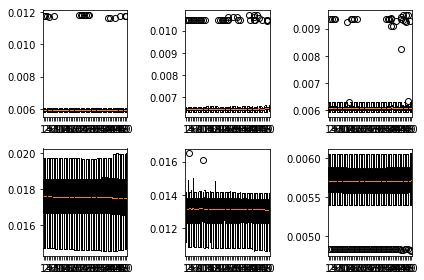

In [109]:
num_col = 3
num_row = int(np.ceil(rmse_te_loaded.shape[0]/num_col))


f, axs = plt.subplots(num_row, num_col)

for ind_group in range(rmse_te_loaded.shape[0]):
        
    ax = axs[ind_group // num_col][ind_group % num_col]
    ax.boxplot(rmse_te_loaded[ind_group,:,:])
    
    #ax.set_xlabel("pc")
    #ax.set_ylabel("pca_2")

plt.tight_layout()
plt.savefig("./plots/boxplot_error_groups_penalized_logistic_regression_basic_feature_engineering_tuning_lambda")
plt.show()

In [110]:
ind_lambda_mean = np.argmin(np.mean(rmse_te_loaded,axis=1),axis=1)
print(ind_lambda_mean)

[11 18 19 47 43 15]


In [111]:
lambda_mean = lambdas[ind_lambda_mean]

In [112]:
print(lambda_mean)

[1.32571137e-04 6.86648845e-04 8.68511374e-04 6.25055193e-01
 2.44205309e-01 3.39322177e-04]


In [113]:
ind_lambda_median = np.argmin(np.median(rmse_te_loaded,axis=1),axis=1)
print(ind_lambda_median)

[ 3 18 39 48 13  0]


Finally, with the optimal degree up to which polynomial terms of the explanatory variables should be added and the optimal hyperparameter lambda determined for each subgroup, the task of predicting whether the "decay signatures" in the test dataset are the result of a Higgs boson can be adressed.

[1.32571137e-04 6.86648845e-04 8.68511374e-04 6.25055193e-01
 2.44205309e-01 3.39322177e-04]
[9 3 3 4 4 3]
group (1/6)
Current iteration=0, the loss=29047.562517753788
Current iteration=1, the loss=26419.715631578372
Current iteration=2, the loss=25753.321504666976
Current iteration=3, the loss=25692.065488583296
Current iteration=4, the loss=25688.492040058383
Current iteration=5, the loss=25686.602659461638
Current iteration=6, the loss=25686.019813138126
Current iteration=7, the loss=25685.69625672558
Current iteration=8, the loss=25685.213891418978
Current iteration=9, the loss=25684.58755154177
Current iteration=10, the loss=25684.556692871534
Current iteration=11, the loss=25683.87000107628
Current iteration=12, the loss=25683.7305199587
Current iteration=13, the loss=25683.572373343544
Current iteration=14, the loss=25682.972618901025
Current iteration=15, the loss=25718.55573032263
Current iteration=16, the loss=inf
invalid value encountered in true_divide
group=0, degree=9 , l

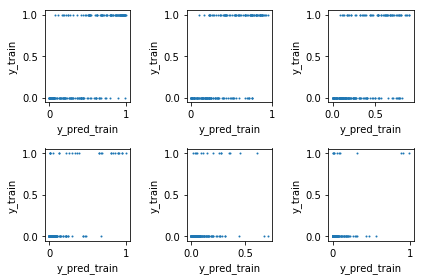

In [585]:
max_iters = 20
threshold = 10**(-8)


lambda_star_groups = lambda_mean
print(lambda_star_groups)
degrees_star_groups = degrees_median_star
print(degrees_star_groups)

gamma = 1
DATA_TEST_PATH = "../data/test.csv/test.csv"
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)
tX_split_test, ind_row_groups_test, groups_mv_num_test = split_data_according_to_pattern_of_missing_values(tX_test)

assert(np.array_equal(groups_mv_num, groups_mv_num_test))

w_star_groups = []
y_pred_test = np.zeros(tX_test.shape[0])
y_pred_train = np.zeros(tX.shape[0])

num_col = 3
num_row = int(np.ceil(rmse_te_loaded.shape[0]/num_col))
f, axs = plt.subplots(num_row, num_col)

for ind_group in range(len(groups_mv_num)):
    print('group (' + str(ind_group + 1) + '/' + str(len(groups_mv_num)) + ')')
    
    tX_group = tX[ind_row_groups[ind_group]]
    degree_group = degrees_star_groups[ind_group]
    tX_test_group = tX_test[ind_row_groups_test[ind_group]]
    y_group = rescale_y(y[ind_row_groups[ind_group]])
    lambda_group = lambda_star_groups[ind_group]
    
    # ***************************************************
    # form train and test data with polynomial basis function:
    # ***************************************************
    tX_train_group_extended = add_higher_degree_terms(tX_group, degree_group)
    tX_test_group_extended = add_higher_degree_terms(tX_test_group, degree_group)
    
    # ***************************************************
    # calcualte most likely weights through logistic regression with ridge term
    # ***************************************************
    ind_col_non_const = np.arange(len(tX_train_group_extended[0,:]))[np.std(tX_train_group_extended,0)>0]
    
    tX_train_group_extended = adding_offset(tX_train_group_extended)
    tX_test_group_extended = adding_offset(tX_test_group_extended)
    ind_col_non_const += 1
    ind_col_non_const = np.insert(ind_col_non_const,0, 0)
    
    log_likelihoods, ws = penalized_logistic_regression(y_group, tX_train_group_extended[:,ind_col_non_const], max_iters, threshold,lambda_group,gamma)
    
    ind_min = np.argmin(log_likelihoods)
    w_star = np.zeros(len(tX_train_group_extended[0,:]))
    w_star[ind_col_non_const] = ws[ind_min]

    # ***************************************************
    # calculate RMSE and ABSE for train data,and store them in rmse_tr and abse_tr respectively
    # ***************************************************
    w_star_groups.append(w_star)
    y_pred_train[ind_row_groups[ind_group]] = compute_p(w_star,tX_train_group_extended)
    y_pred_test[ind_row_groups_test[ind_group]] = compute_p(w_star,tX_test_group_extended)
    
    log_likelihoods_train = calculate_loss_logistic_regression(y_group, tX_train_group_extended, w_star)
    rmse_tr = np.linalg.norm((y_group - compute_p(w_star,tX_train_group_extended))/y_group.shape[0])
    abse_tr = np.sum(abs(y_group - [compute_p(w_star,tX_train_group_extended) > 0.5]))
    
    ax = axs[ind_group // num_col][ind_group % num_col]
    ax.scatter(y_pred_train[ind_row_groups[ind_group]][0:200],y_group[0:200],s=1)
    ax.set_xlabel("y_pred_train")
    ax.set_ylabel("y_train")
        
    print("group={g}, degree={d} , lambda={l:10.3e}, Training RMSE={tr:.3f}, Training loss={trl:.3f}, Training # Missclassification ={m_tr:.3f}".format(
        g=ind_group,d=degree_group,  l= lambda_, tr=rmse_tr, trl = log_likelihoods_train, m_tr = abse_tr))

plt.tight_layout()
plt.savefig("./plots/predictions_vs_y_value_training_groups_patter")
plt.show()
y_pred_test = rescale_predictions(y_pred_test)

## Generate predictions and save ouput in csv format for submission:

In [ ]:
DATA_TEST_PATH = '../data/test.csv' # TODO: download train data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [ ]:
OUTPUT_PATH = '../data/predicted.csv' # TODO: fill in desired name of output file for submission
tX_test, mean_x, std_x = standardize(tX_test)
tX_test  = np.c_[np.ones(tX_test.shape[0]), tX_test]
y_pred = predict_labels(w1, tX_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)

In [ ]:
#implementer 10% du train set comme test set